In [28]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [29]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../ to the sys path to access the coarsegraining package
sys.path.append(pwd + '/src/')

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from coarsegrainer.plotting import plot_line_3D, plot_graph
from experimentlogger import ExperimentLogger

In [107]:
ls results

CG_Bond_LJ_experiment2024-02-09-21.csv
CG_Bond_LJ_experiment2024-02-10-02.csv
CG_Bond_LJ_experiment2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-04.csv
CG_Bond_LJ_experiments_2024-02-10-16.csv
CG_Bond_LJ_experiments_2024-02-10-17.csv
CG_Bond_LJ_experiments_2024-02-10-18.csv
CG_Bond_LJ_experiments_2024-02-10-22.csv
CG_Bond_LJ_experiments_2024-02-10-23.csv
CG_LJ2_experiments_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-05.csv
CG_LJ2_experiments_2scale_2024-02-10-06.csv
CG_LJ2_experiments_2scale_2024-02-10-23.csv
CG_LJ2_experiments_2scale_2024-02-11-00.csv
logs/
test2024-02-09-22.csv
test2024-02-09-23.csv
test2024-02-10-22.csv


# LJ loop n=1000
Define an energy function which uses LJ for forming a loop. 
It consists of:
1. a strong backbone line graph where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [184]:
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_LJ2_experiments_2scale_2024-02-11-00.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
df = exp_logger.to_dataframe()
df

energy_function            model_name    energy       time    lr  \
0    Energy_LJ_2scale       GD_2LJ_n1000_d3 -0.001144   2.478410  0.05   
1    Energy_LJ_2scale   CG_2LJ0.33_n1000_d3  0.137294  11.926820  0.05   
2    Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3  0.031429   4.540107  0.05   
3    Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.027884   4.763441  0.05   
4    Energy_LJ_2scale   CG_2LJ0.25_n1000_d3  0.473414  16.559235  0.05   
..                ...                   ...       ...        ...   ...   
277  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.028636  11.510620  0.02   
278  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.020390   6.740879  0.02   
279  Energy_LJ_2scale   CG_2LJ0.25_n1000_d3  0.337759  28.727567  0.02   
280  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3  0.014066   7.292524  0.02   
281  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3 -0.017048   6.693585  0.02   

     clamp_grads  patience  min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20   0.000001  2.530359       1000    NaN   
1            0.1        20   0.000001  2.530359       1000  0.050   
2            0.1        20   0.000001  2.530359       1000  0.005   
3            0.1        20   0.000001  2.530359       1000  0.005   
4            0.1        20   0.000001  2.530359       1000  0.050   
..           ...       ...        ...       ...        ...    ...   
277          0.1        20   0.000001  2.530359       1000  0.020   
278          0.1        20   0.000001  2.530359       1000  0.020   
279          0.1        20   0.000001  2.530359       1000  0.200   
280          0.1        20   0.000001  2.530359       1000  0.020   
281          0.1        20   0.000001  2.530359       1000  0.020   

     cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  \
0            NaN           NaN       NaN        NaN        NaN           NaN   
1           20.0       0.00001     580.0  10.441059   0.154105         333.0   
2           20.0       0.00001      97.0   3.327611   0.041167         333.0   
3           20.0       0.00001      30.0   2.050453  -0.005726         333.0   
4           20.0       0.00001     865.0  15.198349   0.498225         250.0   
..           ...           ...       ...        ...        ...           ...   
277         20.0       0.00001      38.0   2.130914  -0.007620         333.0   
278         20.0       0.00001      23.0   1.885393   0.000166         333.0   
279         20.0       0.00001     542.0  10.112578   0.371709         250.0   
280         20.0       0.00001      42.0   2.269781   0.033723         250.0   
281         20.0       0.00001      23.0   1.849573  -0.000132         250.0   

     hidden_dims  
0            NaN  
1            NaN  
2      [8, 4, 3]  
3    [32, 16, 3]  
4            NaN  
..           ...  
277    [8, 4, 3]  
278  [32, 16, 3]  
279          NaN  
280    [8, 4, 3]  
281  [32, 16, 3]  

[282 rows x 18 columns]

In [185]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_2LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']
# ensure that the num_cg_modes is an integer
df['num_cg_modes'] = df['num_cg_modes'].astype(int)
df[:10]

energy_function            model_name    energy       time    lr  \
0  Energy_LJ_2scale       GD_2LJ_n1000_d3 -0.001144   2.478410  0.05   
1  Energy_LJ_2scale   CG_2LJ0.33_n1000_d3  0.137294  11.926820  0.05   
2  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3  0.031429   4.540107  0.05   
3  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.027884   4.763441  0.05   
4  Energy_LJ_2scale   CG_2LJ0.25_n1000_d3  0.473414  16.559235  0.05   
5  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3 -0.025779   6.505024  0.05   
6  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3 -0.027374   4.550584  0.05   
7  Energy_LJ_2scale   CG_2LJ0.20_n1000_d3  0.392523  13.861361  0.05   
8  Energy_LJ_2scale  GNN_2LJ0.20_n1000_d3  0.029852  12.173057  0.05   
9  Energy_LJ_2scale  GNN_2LJ0.20_n1000_d3 -0.017222   4.384655  0.05   

   clamp_grads  patience  min_delta    x0_std  num_nodes  lr_cg  cg_patience  \
0          0.1        20   0.000001  2.530359       1000    NaN          NaN   
1          0.1        20   0.000001  2.530359       1000  0.050         20.0   
2          0.1        20   0.000001  2.530359       1000  0.005         20.0   
3          0.1        20   0.000001  2.530359       1000  0.005         20.0   
4          0.1        20   0.000001  2.530359       1000  0.050         20.0   
5          0.1        20   0.000001  2.530359       1000  0.005         20.0   
6          0.1        20   0.000001  2.530359       1000  0.005         20.0   
7          0.1        20   0.000001  2.530359       1000  0.050         20.0   
8          0.1        20   0.000001  2.530359       1000  0.005         20.0   
9          0.1        20   0.000001  2.530359       1000  0.005         20.0   

   cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  hidden_dims  \
0           NaN       NaN        NaN        NaN          1000          NaN   
1       0.00001     580.0  10.441059   0.154105           330          NaN   
2       0.00001      97.0   3.327611   0.041167           330    [8, 4, 3]   
3       0.00001      30.0   2.050453  -0.005726           330  [32, 16, 3]   
4       0.00001     865.0  15.198349   0.498225           250          NaN   
5       0.00001     180.0   4.973676  -0.017832           250    [8, 4, 3]   
6       0.00001      35.0   2.163833  -0.005933           250  [32, 16, 3]   
7       0.00001     689.0  12.398494   0.425218           200          NaN   
8       0.00001     468.0  10.757780   0.031340           200    [8, 4, 3]   
9       0.00001      46.0   2.418844   0.000681           200  [32, 16, 3]   

   cg_ratio  
0      1.00  
1      0.33  
2      0.33  
3      0.33  
4      0.25  
5      0.25  
6      0.25  
7      0.20  
8      0.20  
9      0.20

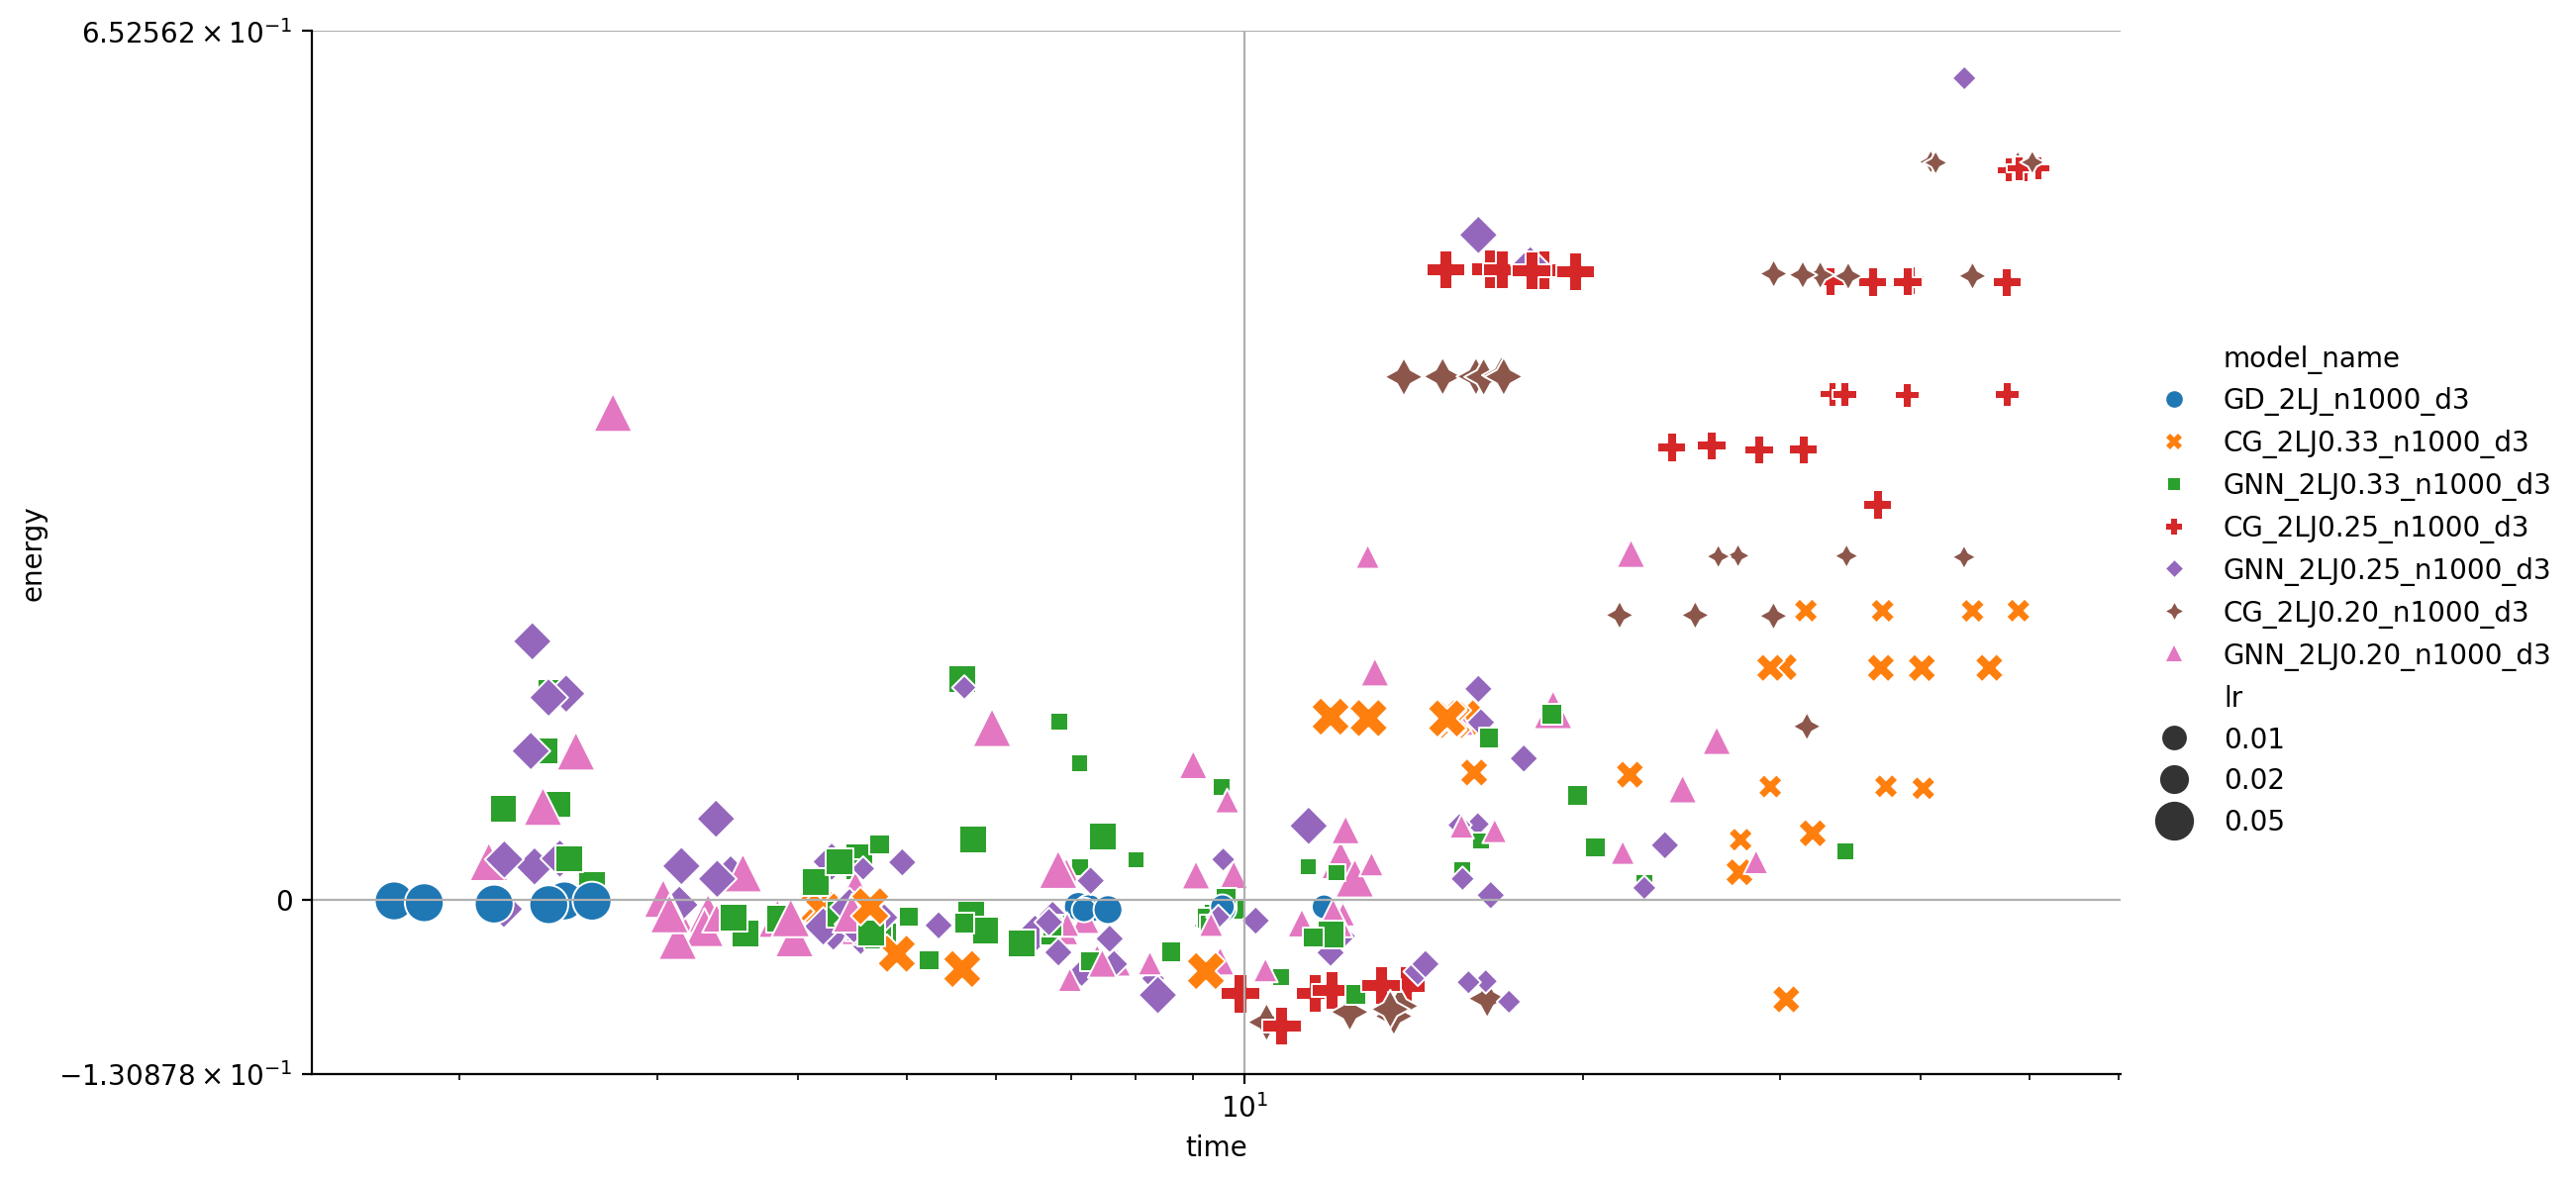

In [186]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.0234, -.0228)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

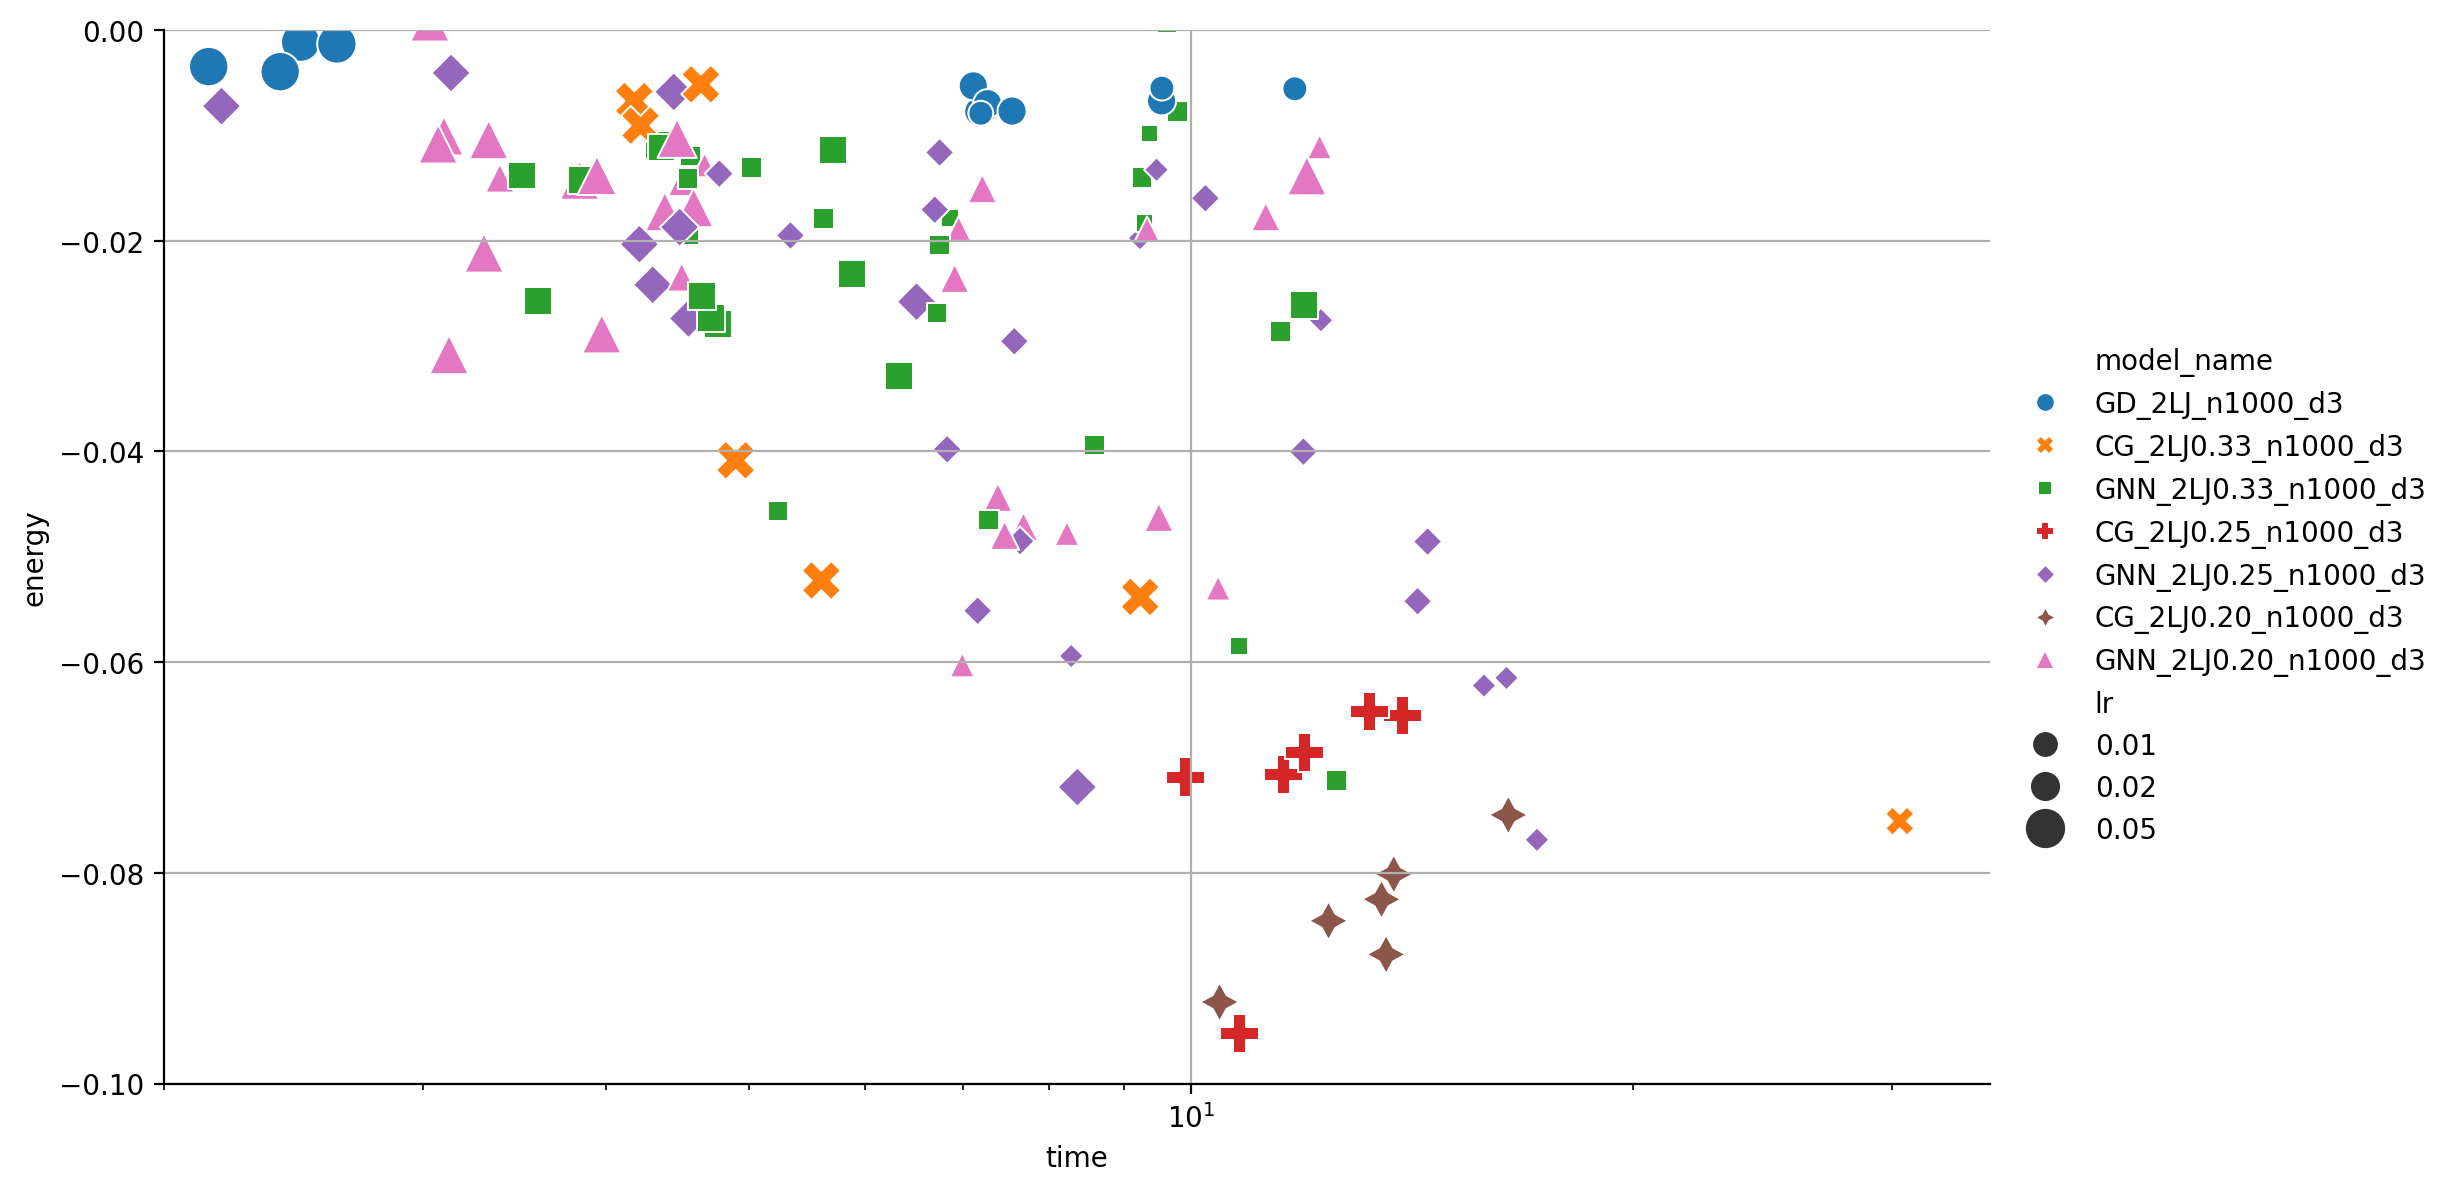

In [187]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.1, -.0)
plt.xlim(2,35)
plt.xscale('log')
plt.grid()

## Grouping similar runs

In [188]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'lr_cg', 'num_cg_modes', 'hidden_dims'])
# other options: cg_patience,cg_min_delta, 'min_delta'
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1753380/3369902939.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1753380/3369902939.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr  lr_cg num_cg_modes  hidden_dims    energy  \
                                                                     mean   
0    CG_2LJ0.20_n1000_d3  0.01  0.010          200          NaN  0.553690   
1    CG_2LJ0.20_n1000_d3  0.01  0.100          200          NaN  0.257780   
2    CG_2LJ0.20_n1000_d3  0.02  0.020          200          NaN  0.468990   
3    CG_2LJ0.20_n1000_d3  0.02  0.200          200          NaN  0.192500   
4    CG_2LJ0.20_n1000_d3  0.05  0.050          200          NaN  0.392882   
5    CG_2LJ0.20_n1000_d3  0.05  0.500          200          NaN -0.083615   
6    CG_2LJ0.25_n1000_d3  0.01  0.010          250          NaN  0.548557   
7    CG_2LJ0.25_n1000_d3  0.01  0.100          250          NaN  0.379292   
8    CG_2LJ0.25_n1000_d3  0.02  0.020          250          NaN  0.464123   
9    CG_2LJ0.25_n1000_d3  0.02  0.200          250          NaN  0.330488   
10   CG_2LJ0.25_n1000_d3  0.05  0.050          250          NaN  0.472620   
11   CG_2LJ0.25_n1000_d3  0.05  0.500          250          NaN -0.072527   
12   CG_2LJ0.33_n1000_d3  0.01  0.010          330          NaN  0.216857   
13   CG_2LJ0.33_n1000_d3  0.01  0.100          330          NaN  0.074518   
14   CG_2LJ0.33_n1000_d3  0.02  0.020          330          NaN  0.174033   
15   CG_2LJ0.33_n1000_d3  0.02  0.200          330          NaN  0.036811   
16   CG_2LJ0.33_n1000_d3  0.05  0.050          330          NaN  0.135820   
17   CG_2LJ0.33_n1000_d3  0.05  0.500          330          NaN -0.027972   
18       GD_2LJ_n1000_d3  0.01    NaN         1000          NaN -0.006609   
19       GD_2LJ_n1000_d3  0.02    NaN         1000          NaN -0.006881   
20       GD_2LJ_n1000_d3  0.05    NaN         1000          NaN -0.002242   
21  GNN_2LJ0.20_n1000_d3  0.01  0.001          200  [32, 16, 3] -0.024424   
22  GNN_2LJ0.20_n1000_d3  0.01  0.001          200    [8, 4, 3]  0.042513   
23  GNN_2LJ0.20_n1000_d3  0.01  0.010          200  [32, 16, 3] -0.007083   
24  GNN_2LJ0.20_n1000_d3  0.01  0.010          200    [8, 4, 3]  0.103986   
25  GNN_2LJ0.20_n1000_d3  0.02  0.002          200  [32, 16, 3] -0.026674   
26  GNN_2LJ0.20_n1000_d3  0.02  0.002          200    [8, 4, 3]  0.130363   
27  GNN_2LJ0.20_n1000_d3  0.02  0.020          200  [32, 16, 3] -0.015293   
28  GNN_2LJ0.20_n1000_d3  0.02  0.020          200    [8, 4, 3]  0.018166   
29  GNN_2LJ0.20_n1000_d3  0.05  0.005          200  [32, 16, 3] -0.011837   
30  GNN_2LJ0.20_n1000_d3  0.05  0.005          200    [8, 4, 3]  0.054383   
31  GNN_2LJ0.20_n1000_d3  0.05  0.050          200  [32, 16, 3]  0.084313   
32  GNN_2LJ0.20_n1000_d3  0.05  0.050          200    [8, 4, 3] -0.002636   
33  GNN_2LJ0.25_n1000_d3  0.01  0.001          250  [32, 16, 3] -0.052667   
34  GNN_2LJ0.25_n1000_d3  0.01  0.001          250    [8, 4, 3]  0.174243   
35  GNN_2LJ0.25_n1000_d3  0.01  0.010          250  [32, 16, 3]  0.004231   
36  GNN_2LJ0.25_n1000_d3  0.01  0.010          250    [8, 4, 3]  0.042209   
37  GNN_2LJ0.25_n1000_d3  0.02  0.002          250  [32, 16, 3] -0.049282   
38  GNN_2LJ0.25_n1000_d3  0.02  0.002          250    [8, 4, 3]  0.088175   
39  GNN_2LJ0.25_n1000_d3  0.02  0.020          250  [32, 16, 3] -0.015298   
40  GNN_2LJ0.25_n1000_d3  0.02  0.020          250    [8, 4, 3] -0.009376   
41  GNN_2LJ0.25_n1000_d3  0.05  0.005          250  [32, 16, 3]  0.003830   
42  GNN_2LJ0.25_n1000_d3  0.05  0.005          250    [8, 4, 3]  0.154559   
43  GNN_2LJ0.25_n1000_d3  0.05  0.050          250  [32, 16, 3]  0.102961   
44  GNN_2LJ0.25_n1000_d3  0.05  0.050          250    [8, 4, 3]  0.017138   
45  GNN_2LJ0.33_n1000_d3  0.01  0.001          330  [32, 16, 3] -0.005876   
46  GNN_2LJ0.33_n1000_d3  0.01  0.001          330    [8, 4, 3]  0.028786   
47  GNN_2LJ0.33_n1000_d3  0.01  0.010          330  [32, 16, 3] -0.007839   
48  GNN_2LJ0.33_n1000_d3  0.01  0.010          330    [8, 4, 3]  0.087579   
49  GNN_2LJ0.33_n1000_d3  0.02  0.002          330  [32, 16, 3] -0.027713   
50  GNN_2L

In [189]:
df_copy

energy_function            model_name    energy       time    lr  \
0    Energy_LJ_2scale       GD_2LJ_n1000_d3 -0.001144   2.478410  0.05   
1    Energy_LJ_2scale   CG_2LJ0.33_n1000_d3  0.137294  11.926820  0.05   
2    Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3  0.031429   4.540107  0.05   
3    Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.027884   4.763441  0.05   
4    Energy_LJ_2scale   CG_2LJ0.25_n1000_d3  0.473414  16.559235  0.05   
..                ...                   ...       ...        ...   ...   
277  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.028636  11.510620  0.02   
278  Energy_LJ_2scale  GNN_2LJ0.33_n1000_d3 -0.020390   6.740879  0.02   
279  Energy_LJ_2scale   CG_2LJ0.25_n1000_d3  0.337759  28.727567  0.02   
280  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3  0.014066   7.292524  0.02   
281  Energy_LJ_2scale  GNN_2LJ0.25_n1000_d3 -0.017048   6.693585  0.02   

     clamp_grads  patience  min_delta    x0_std  num_nodes  lr_cg cg_patience  \
0            0.1        20   0.000001  2.530359       1000     na          na   
1            0.1        20   0.000001  2.530359       1000   0.05        20.0   
2            0.1        20   0.000001  2.530359       1000  0.005        20.0   
3            0.1        20   0.000001  2.530359       1000  0.005        20.0   
4            0.1        20   0.000001  2.530359       1000   0.05        20.0   
..           ...       ...        ...       ...        ...    ...         ...   
277          0.1        20   0.000001  2.530359       1000   0.02        20.0   
278          0.1        20   0.000001  2.530359       1000   0.02        20.0   
279          0.1        20   0.000001  2.530359       1000    0.2        20.0   
280          0.1        20   0.000001  2.530359       1000   0.02        20.0   
281          0.1        20   0.000001  2.530359       1000   0.02        20.0   

    cg_min_delta cg_steps    cg_time cg_energy  num_cg_modes  hidden_dims  \
0             na       na         na        na          1000           na   
1        0.00001    580.0  10.441059  0.154105           330           na   
2        0.00001     97.0   3.327611  0.041167           330    [8, 4, 3]   
3        0.00001     30.0   2.050453 -0.005726           330  [32, 16, 3]   
4        0.00001    865.0  15.198349  0.498225           250           na   
..           ...      ...        ...       ...           ...          ...   
277      0.00001     38.0   2.130914  -0.00762           330    [8, 4, 3]   
278      0.00001     23.0   1.885393  0.000166           330  [32, 16, 3]   
279      0.00001    542.0  10.112578  0.371709           250           na   
280      0.00001     42.0   2.269781  0.033723           250    [8, 4, 3]   
281      0.00001     23.0   1.849573 -0.000132           250  [32, 16, 3]   

     cg_ratio  
0        1.00  
1        0.33  
2        0.33  
3        0.33  
4        0.25  
..        ...  
277      0.33  
278      0.33  
279      0.25  
280      0.25  
281      0.25  

[282 rows x 19 columns]

In [190]:
# get rows where  model_name starts with 'GD_'
df_gd = df_copy[df_copy['model_name'].str.startswith('GD_')]
df_gd


energy_function       model_name    energy       time    lr  \
0    Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.001144   2.478410  0.05   
19   Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.003946   2.400087  0.05   
38   Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.007726   7.171781  0.02   
57   Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.006715   9.550460  0.02   
76   Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.005569  11.768230  0.01   
95   Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.007465   7.272724  0.01   
114  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.003465   2.145811  0.05   
133  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.001117   1.747999  0.05   
152  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.005297   7.110527  0.02   
171  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.006984   7.271988  0.02   
190  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.007893   7.194186  0.01   
209  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.005510   9.554548  0.01   
228  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.001316   2.622854  0.05   
247  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.002467   1.859437  0.05   
266  Energy_LJ_2scale  GD_2LJ_n1000_d3 -0.007684   7.555557  0.02   

     clamp_grads  patience     min_delta    x0_std  num_nodes lr_cg  \
0            0.1        20  1.000000e-06  2.530359       1000    na   
19           0.1        20  1.000000e-07  2.530359       1000    na   
38           0.1        20  1.000000e-06  2.530359       1000    na   
57           0.1        20  1.000000e-07  2.530359       1000    na   
76           0.1        20  1.000000e-06  2.530359       1000    na   
95           0.1        20  1.000000e-07  2.530359       1000    na   
114          0.1        20  1.000000e-06  2.530359       1000    na   
133          0.1        20  1.000000e-07  2.530359       1000    na   
152          0.1        20  1.000000e-06  2.530359       1000    na   
171          0.1        20  1.000000e-07  2.530359       1000    na   
190          0.1        20  1.000000e-06  2.530359       1000    na   
209          0.1        20  1.000000e-07  2.530359       1000    na   
228          0.1        20  1.000000e-06  2.530359       1000    na   
247          0.1        20  1.000000e-07  2.530359       1000    na   
266          0.1        20  1.000000e-06  2.530359       1000    na   

    cg_patience cg_min_delta cg_steps cg_time cg_energy  num_cg_modes  \
0            na           na       na      na        na          1000   
19           na           na       na      na        na          1000   
38           na           na       na      na        na          1000   
57           na           na       na      na        na          1000   
76           na           na       na      na        na          1000   
95           na           na       na      na        na          1000   
114          na           na       na      na        na          1000   
133          na           na       na      na        na          1000   
152          na           na       na      na        na          1000   
171          na           na       na      na        na          1000   
190          na           na       na      na        na          1000   
209          na           na       na      na        na          1000   
228          na           na       na      na        na          1000   
247          na           na       na      na        na          1000   
266          na           na       na      na        na          1000   

    hidden_dims  cg_ratio  
0            na       1.0  
19           na       1.0  
38           na       1.0  
57           na       1.0  
76           na       1.0  
95           na       1.0  
114          na       1.0  
133          na       1.0  
152          na       1.0  
171          na       1.0  
190          na       1.0  
209          na       1.0  
228          na       1.0  
247          na       1.0  
266          na       1.0

In [191]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
# df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered = df_mean #[df_mean['energy']['std'] < std_threshold]

df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

In [192]:
df_filtered

index            model_name    lr  lr_cg  num_cg_modes  hidden_dims  \
0       0   CG_2LJ0.20_n1000_d3  0.01  0.010           200          NaN   
1       1   CG_2LJ0.20_n1000_d3  0.01  0.100           200          NaN   
2       2   CG_2LJ0.20_n1000_d3  0.02  0.020           200          NaN   
3       3   CG_2LJ0.20_n1000_d3  0.02  0.200           200          NaN   
4       4   CG_2LJ0.20_n1000_d3  0.05  0.050           200          NaN   
5       5   CG_2LJ0.20_n1000_d3  0.05  0.500           200          NaN   
6       6   CG_2LJ0.25_n1000_d3  0.01  0.010           250          NaN   
7       7   CG_2LJ0.25_n1000_d3  0.01  0.100           250          NaN   
8       8   CG_2LJ0.25_n1000_d3  0.02  0.020           250          NaN   
9       9   CG_2LJ0.25_n1000_d3  0.02  0.200           250          NaN   
10     10   CG_2LJ0.25_n1000_d3  0.05  0.050           250          NaN   
11     11   CG_2LJ0.25_n1000_d3  0.05  0.500           250          NaN   
12     12   CG_2LJ0.33_n1000_d3  0.01  0.010           330          NaN   
13     13   CG_2LJ0.33_n1000_d3  0.01  0.100           330          NaN   
14     14   CG_2LJ0.33_n1000_d3  0.02  0.020           330          NaN   
15     15   CG_2LJ0.33_n1000_d3  0.02  0.200           330          NaN   
16     16   CG_2LJ0.33_n1000_d3  0.05  0.050           330          NaN   
17     17   CG_2LJ0.33_n1000_d3  0.05  0.500           330          NaN   
18     18       GD_2LJ_n1000_d3  0.01    NaN          1000          NaN   
19     19       GD_2LJ_n1000_d3  0.02    NaN          1000          NaN   
20     20       GD_2LJ_n1000_d3  0.05    NaN          1000          NaN   
21     21  GNN_2LJ0.20_n1000_d3  0.01  0.001           200  [32, 16, 3]   
22     22  GNN_2LJ0.20_n1000_d3  0.01  0.001           200    [8, 4, 3]   
23     23  GNN_2LJ0.20_n1000_d3  0.01  0.010           200  [32, 16, 3]   
24     24  GNN_2LJ0.20_n1000_d3  0.01  0.010           200    [8, 4, 3]   
25     25  GNN_2LJ0.20_n1000_d3  0.02  0.002           200  [32, 16, 3]   
26     26  GNN_2LJ0.20_n1000_d3  0.02  0.002           200    [8, 4, 3]   
27     27  GNN_2LJ0.20_n1000_d3  0.02  0.020           200  [32, 16, 3]   
28     28  GNN_2LJ0.20_n1000_d3  0.02  0.020           200    [8, 4, 3]   
29     29  GNN_2LJ0.20_n1000_d3  0.05  0.005           200  [32, 16, 3]   
30     30  GNN_2LJ0.20_n1000_d3  0.05  0.005           200    [8, 4, 3]   
31     31  GNN_2LJ0.20_n1000_d3  0.05  0.050           200  [32, 16, 3]   
32     32  GNN_2LJ0.20_n1000_d3  0.05  0.050           200    [8, 4, 3]   
33     33  GNN_2LJ0.25_n1000_d3  0.01  0.001           250  [32, 16, 3]   
34     34  GNN_2LJ0.25_n1000_d3  0.01  0.001           250    [8, 4, 3]   
35     35  GNN_2LJ0.25_n1000_d3  0.01  0.010           250  [32, 16, 3]   
36     36  GNN_2LJ0.25_n1000_d3  0.01  0.010           250    [8, 4, 3]   
37     37  GNN_2LJ0.25_n1000_d3  0.02  0.002           250  [32, 16, 3]   
38     38  GNN_2LJ0.25_n1000_d3  0.02  0.002           250    [8, 4, 3]   
39     39  GNN_2LJ0.25_n1000_d3  0.02  0.020           250  [32, 16, 3]   
40     40  GNN_2LJ0.25_n1000_d3  0.02  0.020           250    [8, 4, 3]   
41     41  GNN_2LJ0.25_n1000_d3  0.05  0.005           250  [32, 16, 3]   
42     42  GNN_2LJ0.25_n1000_d3  0.05  0.005           250    [8, 4, 3]   
43     43  GNN_2LJ0.25_n1000_d3  0.05  0.050           250  [32, 16, 3]   
44     44  GNN_2LJ0.25_n1000_d3  0.05  0.050           250    [8, 4, 3]   
45     45  GNN_2LJ0.33_n1000_d3  0.01  0.001           330  [32, 16, 3]   
46     46  GNN_2LJ0.33_n1000_d3  0.01  0.001           330    [8, 4, 3]   
47     47  GNN_2LJ0.33_n1000_d3  0.01  0.010           330  [32, 16, 3]   
48     48  GNN_2LJ0.33_n1000_d3  0.01  0.010           330    [8, 4, 3]   
49     49  GNN_2LJ0.33_n1000_d3  0.02  0.002           330  [32, 16, 3]   
50     50  GNN_2LJ0.33_n1000_d3  0.02  0.002           330    [8, 4, 3]   
51     51  GNN_2LJ0.33_n1000_d3  0.02  0.020           330  [32, 16, 3]   
52     52  GNN_2LJ0.33_n1000_

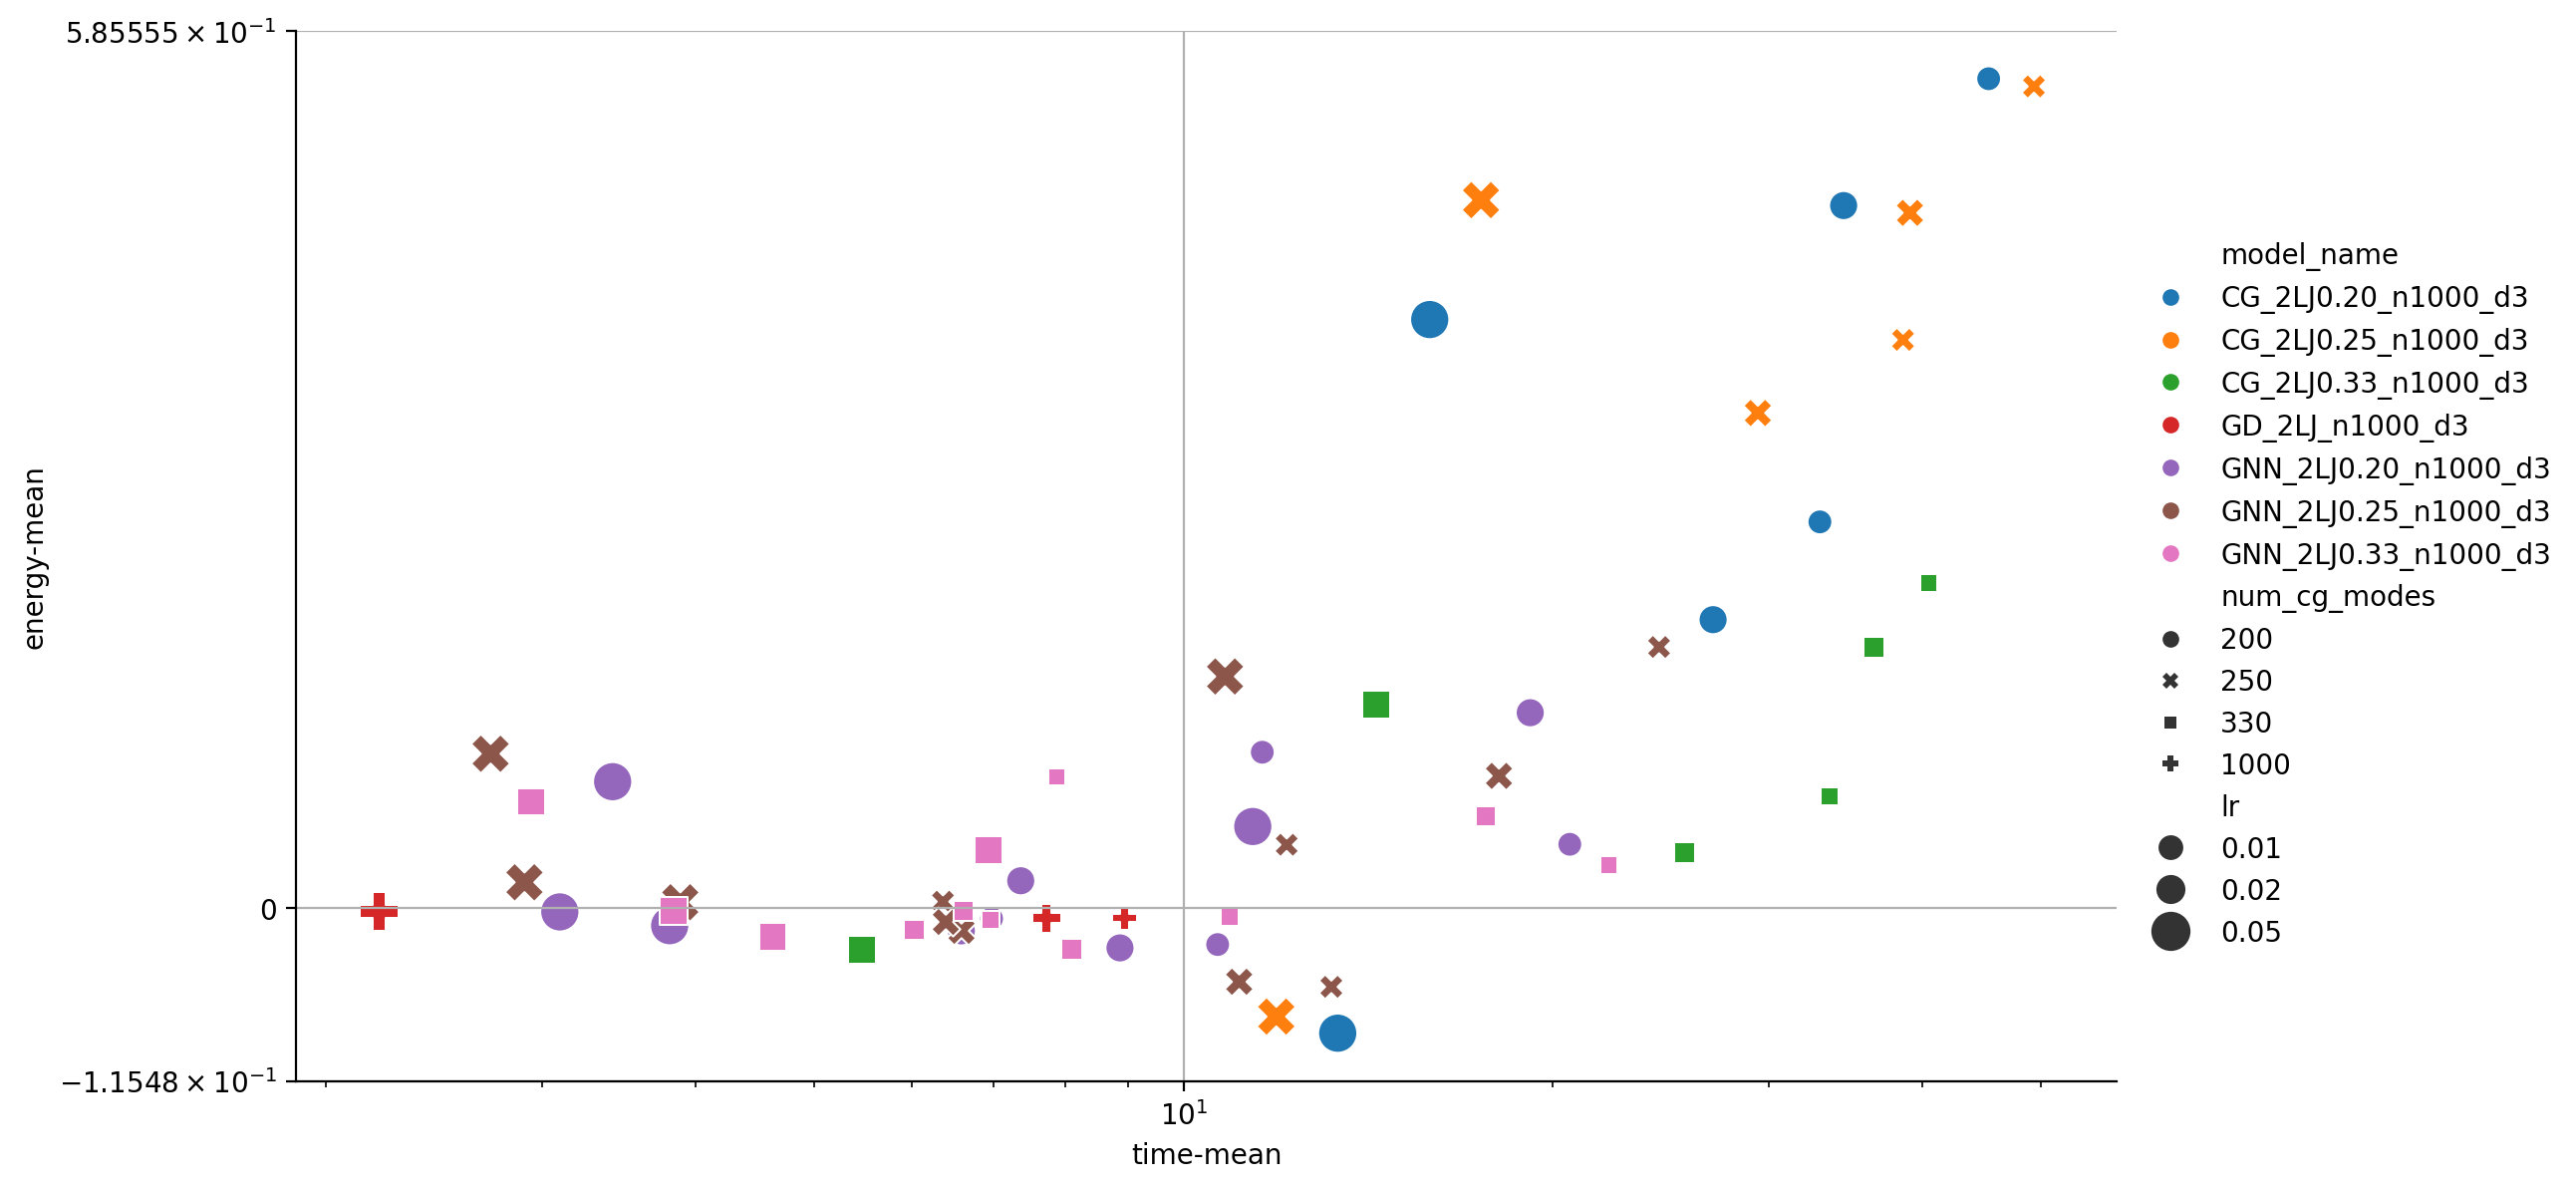

In [193]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', #'min_delta', 
            kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

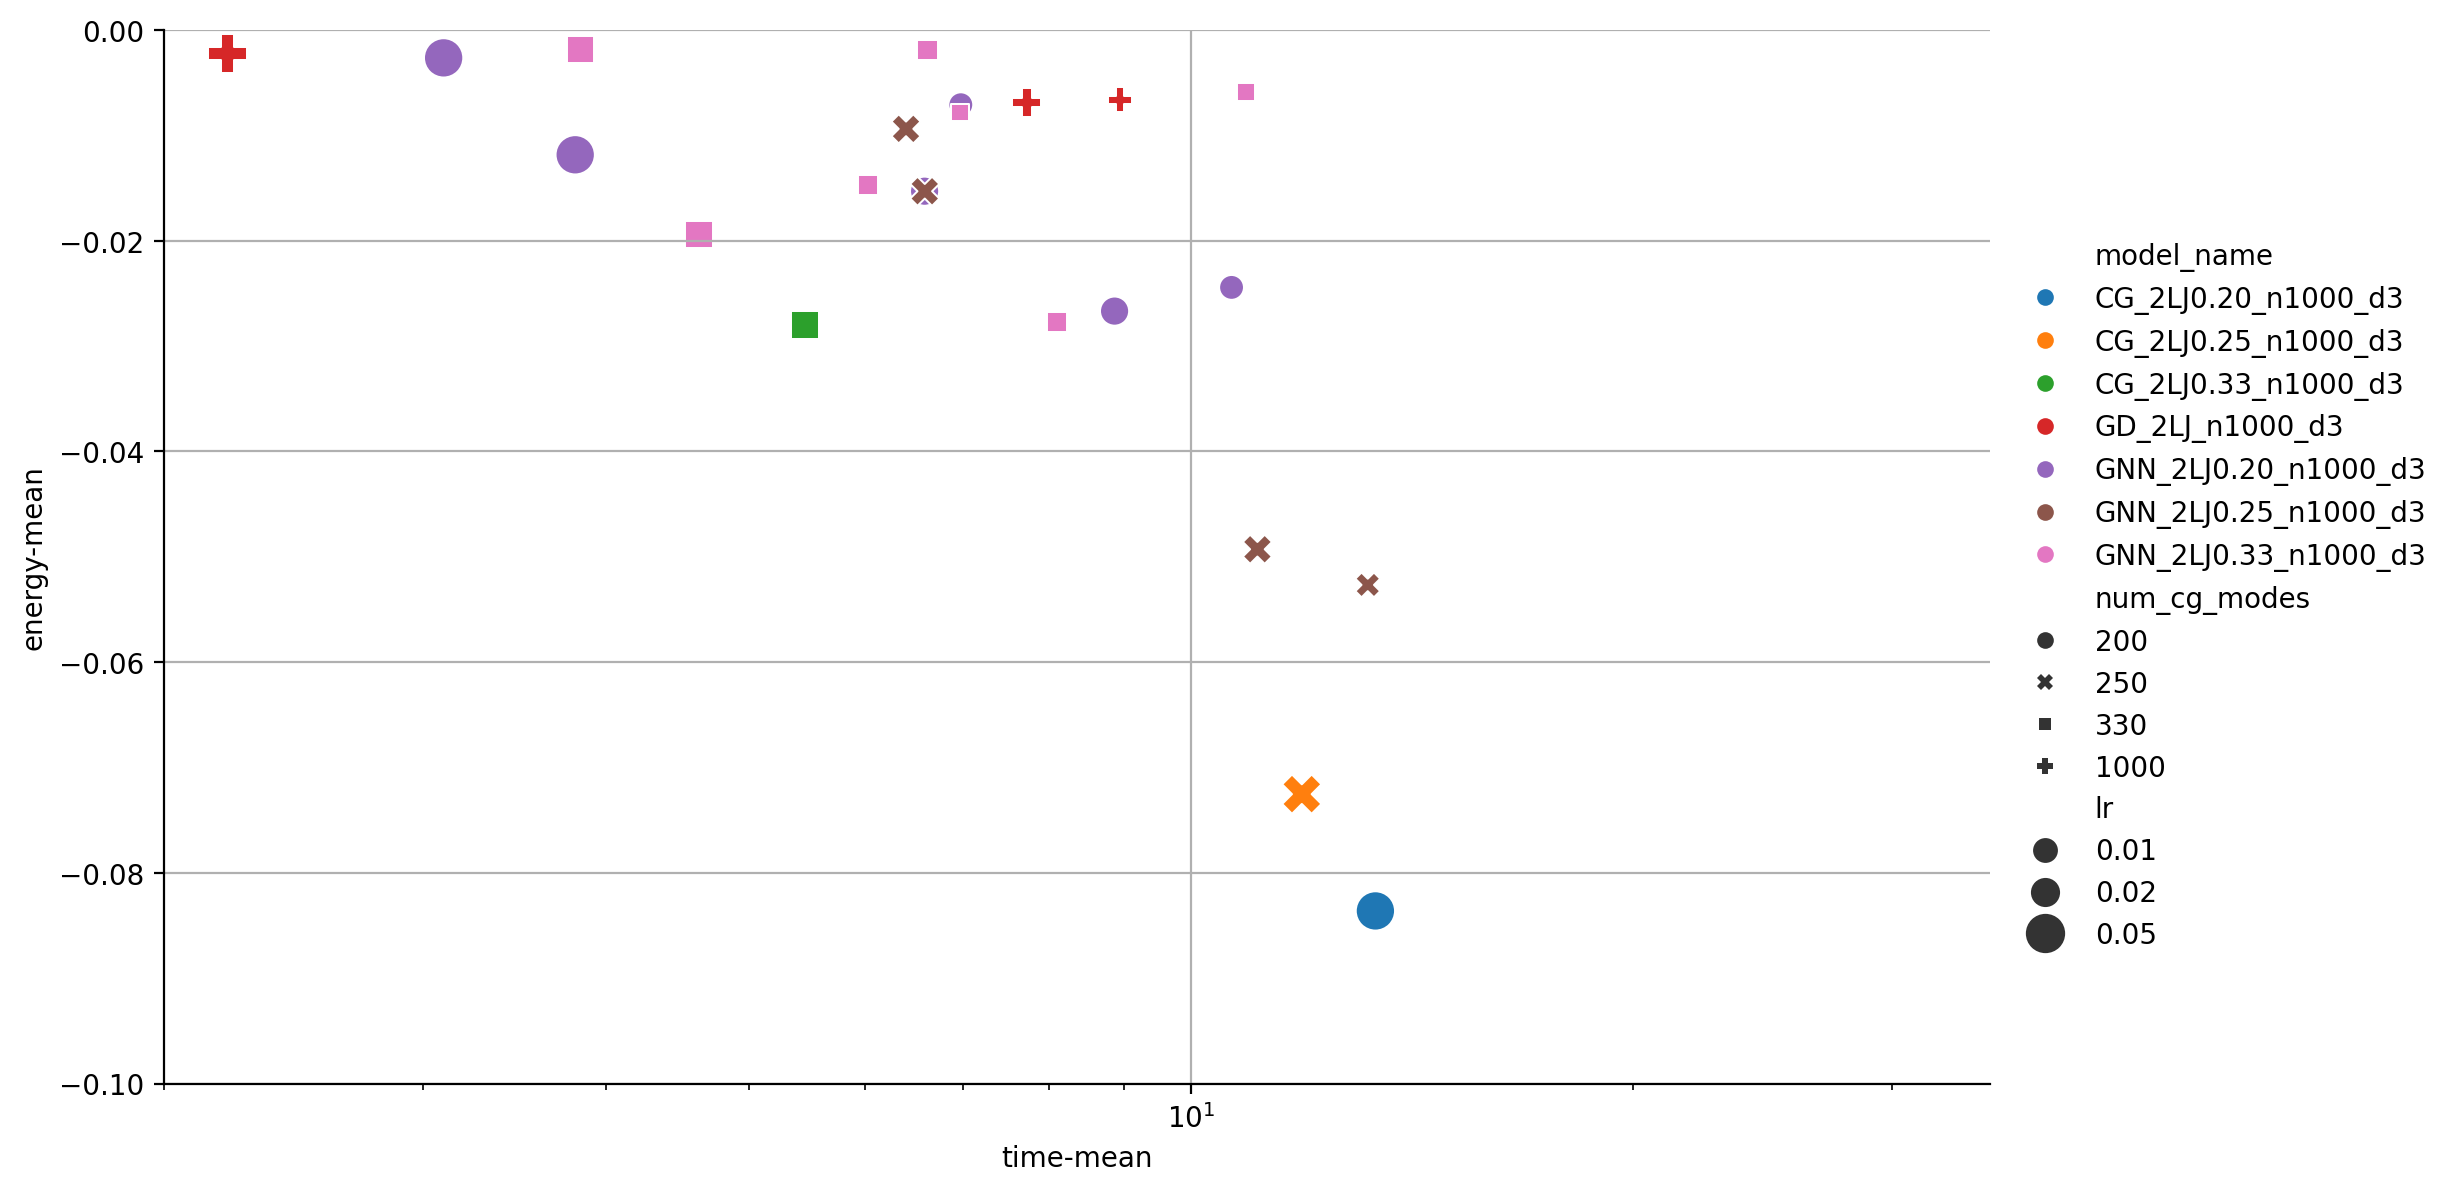

In [194]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))


plt.ylim(-.1, -.0)
plt.xlim(2,35)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

In [195]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('2LJ')].replace('_', ' ') or "Adam")

In [196]:
df_cleaned

index model_name    lr  lr_cg  num_cg_modes  hidden_dims  energy-mean  \
0       0        CG   0.01  0.010           200          NaN     0.553690   
1       1        CG   0.01  0.100           200          NaN     0.257780   
2       2        CG   0.02  0.020           200          NaN     0.468990   
3       3        CG   0.02  0.200           200          NaN     0.192500   
4       4        CG   0.05  0.050           200          NaN     0.392882   
5       5        CG   0.05  0.500           200          NaN    -0.083615   
6       6        CG   0.01  0.010           250          NaN     0.548557   
7       7        CG   0.01  0.100           250          NaN     0.379292   
8       8        CG   0.02  0.020           250          NaN     0.464123   
9       9        CG   0.02  0.200           250          NaN     0.330488   
10     10        CG   0.05  0.050           250          NaN     0.472620   
11     11        CG   0.05  0.500           250          NaN    -0.072527   
12     12        CG   0.01  0.010           330          NaN     0.216857   
13     13        CG   0.01  0.100           330          NaN     0.074518   
14     14        CG   0.02  0.020           330          NaN     0.174033   
15     15        CG   0.02  0.200           330          NaN     0.036811   
16     16        CG   0.05  0.050           330          NaN     0.135820   
17     17        CG   0.05  0.500           330          NaN    -0.027972   
18     18        GD   0.01    NaN          1000          NaN    -0.006609   
19     19        GD   0.02    NaN          1000          NaN    -0.006881   
20     20        GD   0.05    NaN          1000          NaN    -0.002242   
21     21       GNN   0.01  0.001           200  [32, 16, 3]    -0.024424   
22     22       GNN   0.01  0.001           200    [8, 4, 3]     0.042513   
23     23       GNN   0.01  0.010           200  [32, 16, 3]    -0.007083   
24     24       GNN   0.01  0.010           200    [8, 4, 3]     0.103986   
25     25       GNN   0.02  0.002           200  [32, 16, 3]    -0.026674   
26     26       GNN   0.02  0.002           200    [8, 4, 3]     0.130363   
27     27       GNN   0.02  0.020           200  [32, 16, 3]    -0.015293   
28     28       GNN   0.02  0.020           200    [8, 4, 3]     0.018166   
29     29       GNN   0.05  0.005           200  [32, 16, 3]    -0.011837   
30     30       GNN   0.05  0.005           200    [8, 4, 3]     0.054383   
31     31       GNN   0.05  0.050           200  [32, 16, 3]     0.084313   
32     32       GNN   0.05  0.050           200    [8, 4, 3]    -0.002636   
33     33       GNN   0.01  0.001           250  [32, 16, 3]    -0.052667   
34     34       GNN   0.01  0.001           250    [8, 4, 3]     0.174243   
35     35       GNN   0.01  0.010           250  [32, 16, 3]     0.004231   
36     36       GNN   0.01  0.010           250    [8, 4, 3]     0.042209   
37     37       GNN   0.02  0.002           250  [32, 16, 3]    -0.049282   
38     38       GNN   0.02  0.002           250    [8, 4, 3]     0.088175   
39     39       GNN   0.02  0.020           250  [32, 16, 3]    -0.015298   
40     40       GNN   0.02  0.020           250    [8, 4, 3]    -0.009376   
41     41       GNN   0.05  0.005           250  [32, 16, 3]     0.003830   
42     42       GNN   0.05  0.005           250    [8, 4, 3]     0.154559   
43     43       GNN   0.05  0.050           250  [32, 16, 3]     0.102961   
44     44       GNN   0.05  0.050           250    [8, 4, 3]     0.017138   
45     45       GNN   0.01  0.001           330  [32, 16, 3]    -0.005876   
46     46       GNN   0.01  0.001           330    [8, 4, 3]     0.028786   
47     47       GNN   0.01  0.010           330  [32, 16, 3]    -0.007839   
48     48       GNN   0.01  0.010           330    [8, 4, 3]     0.087579   
49     49       GNN   0.02  0.002           330  [32, 16, 3]    -0.027713   
50     50       GNN   0.02  0.002           330    [8, 4, 3]     0.061300   


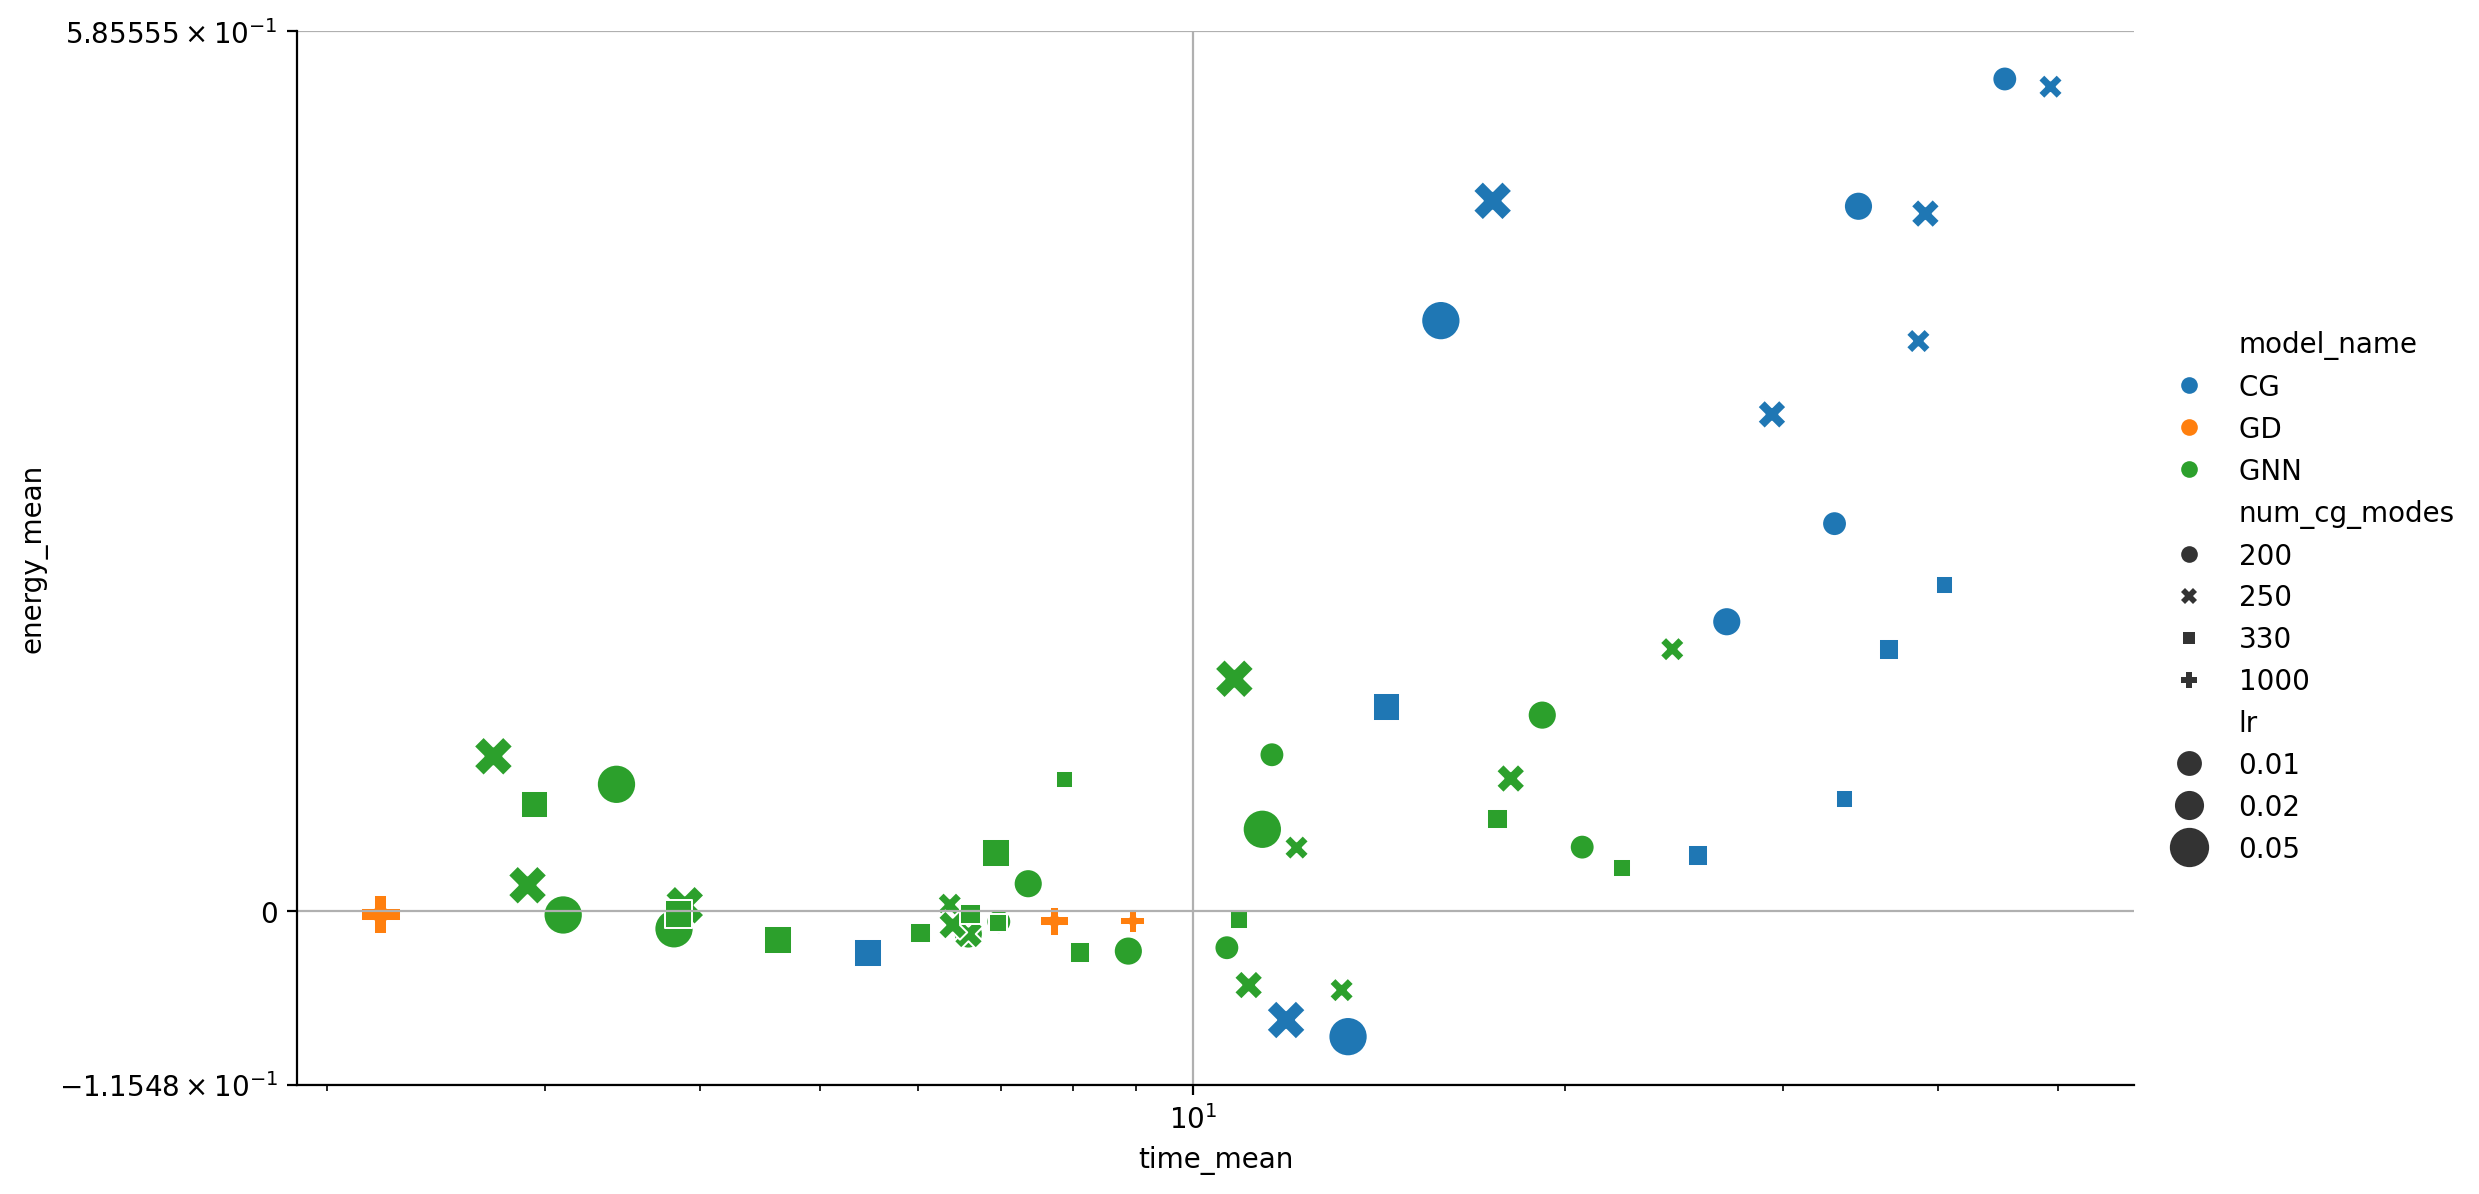

In [197]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='num_cg_modes',#'min_delta',
            kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

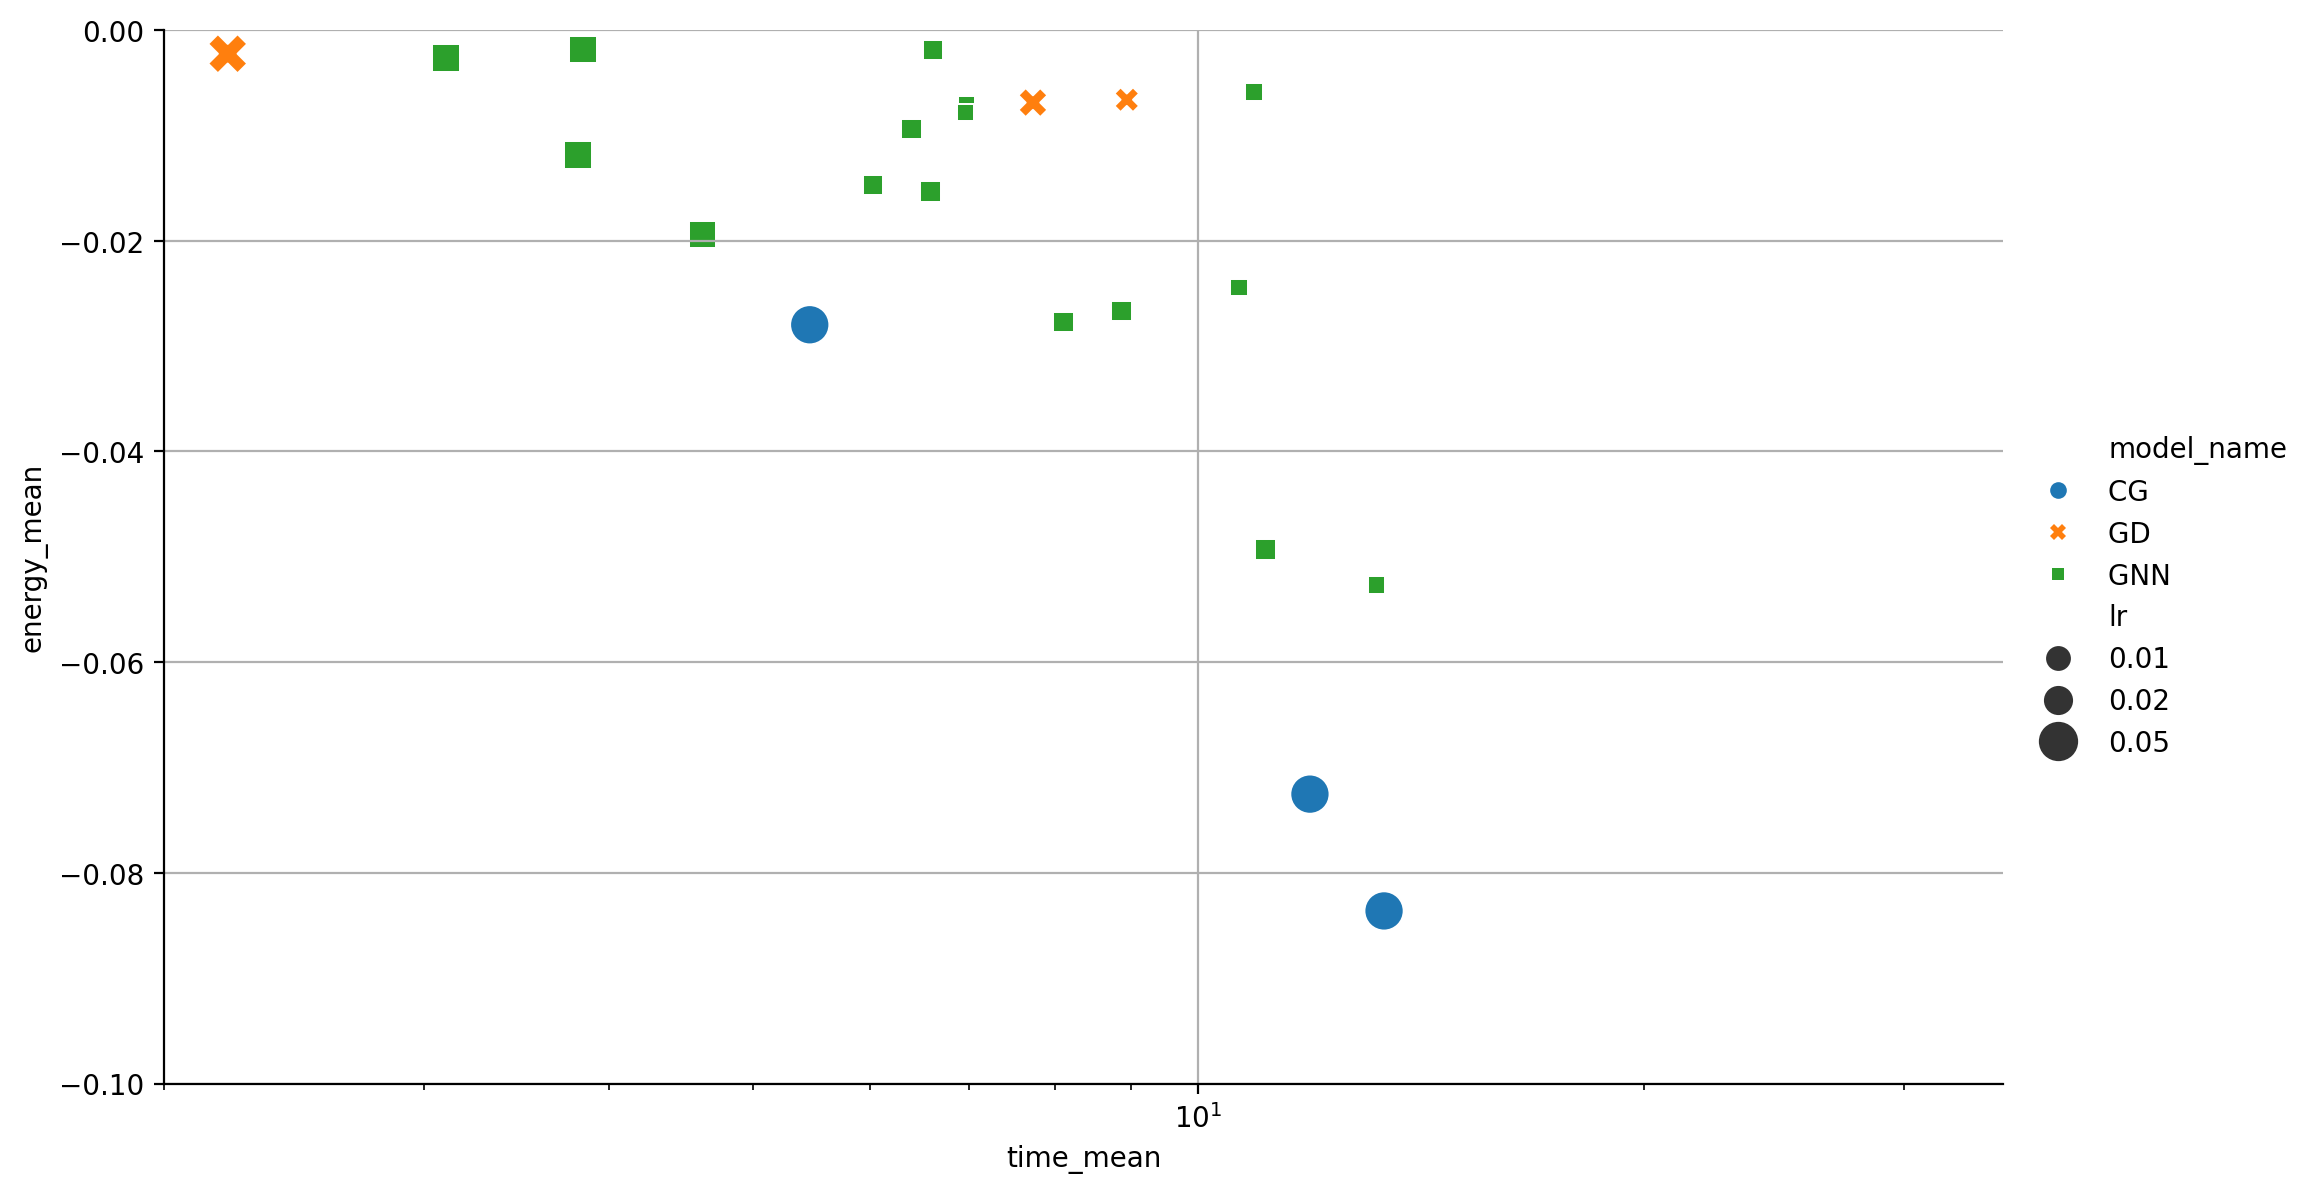

In [198]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='model_name', #'min_delta', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.1, -.0)
plt.xlim(2,35)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

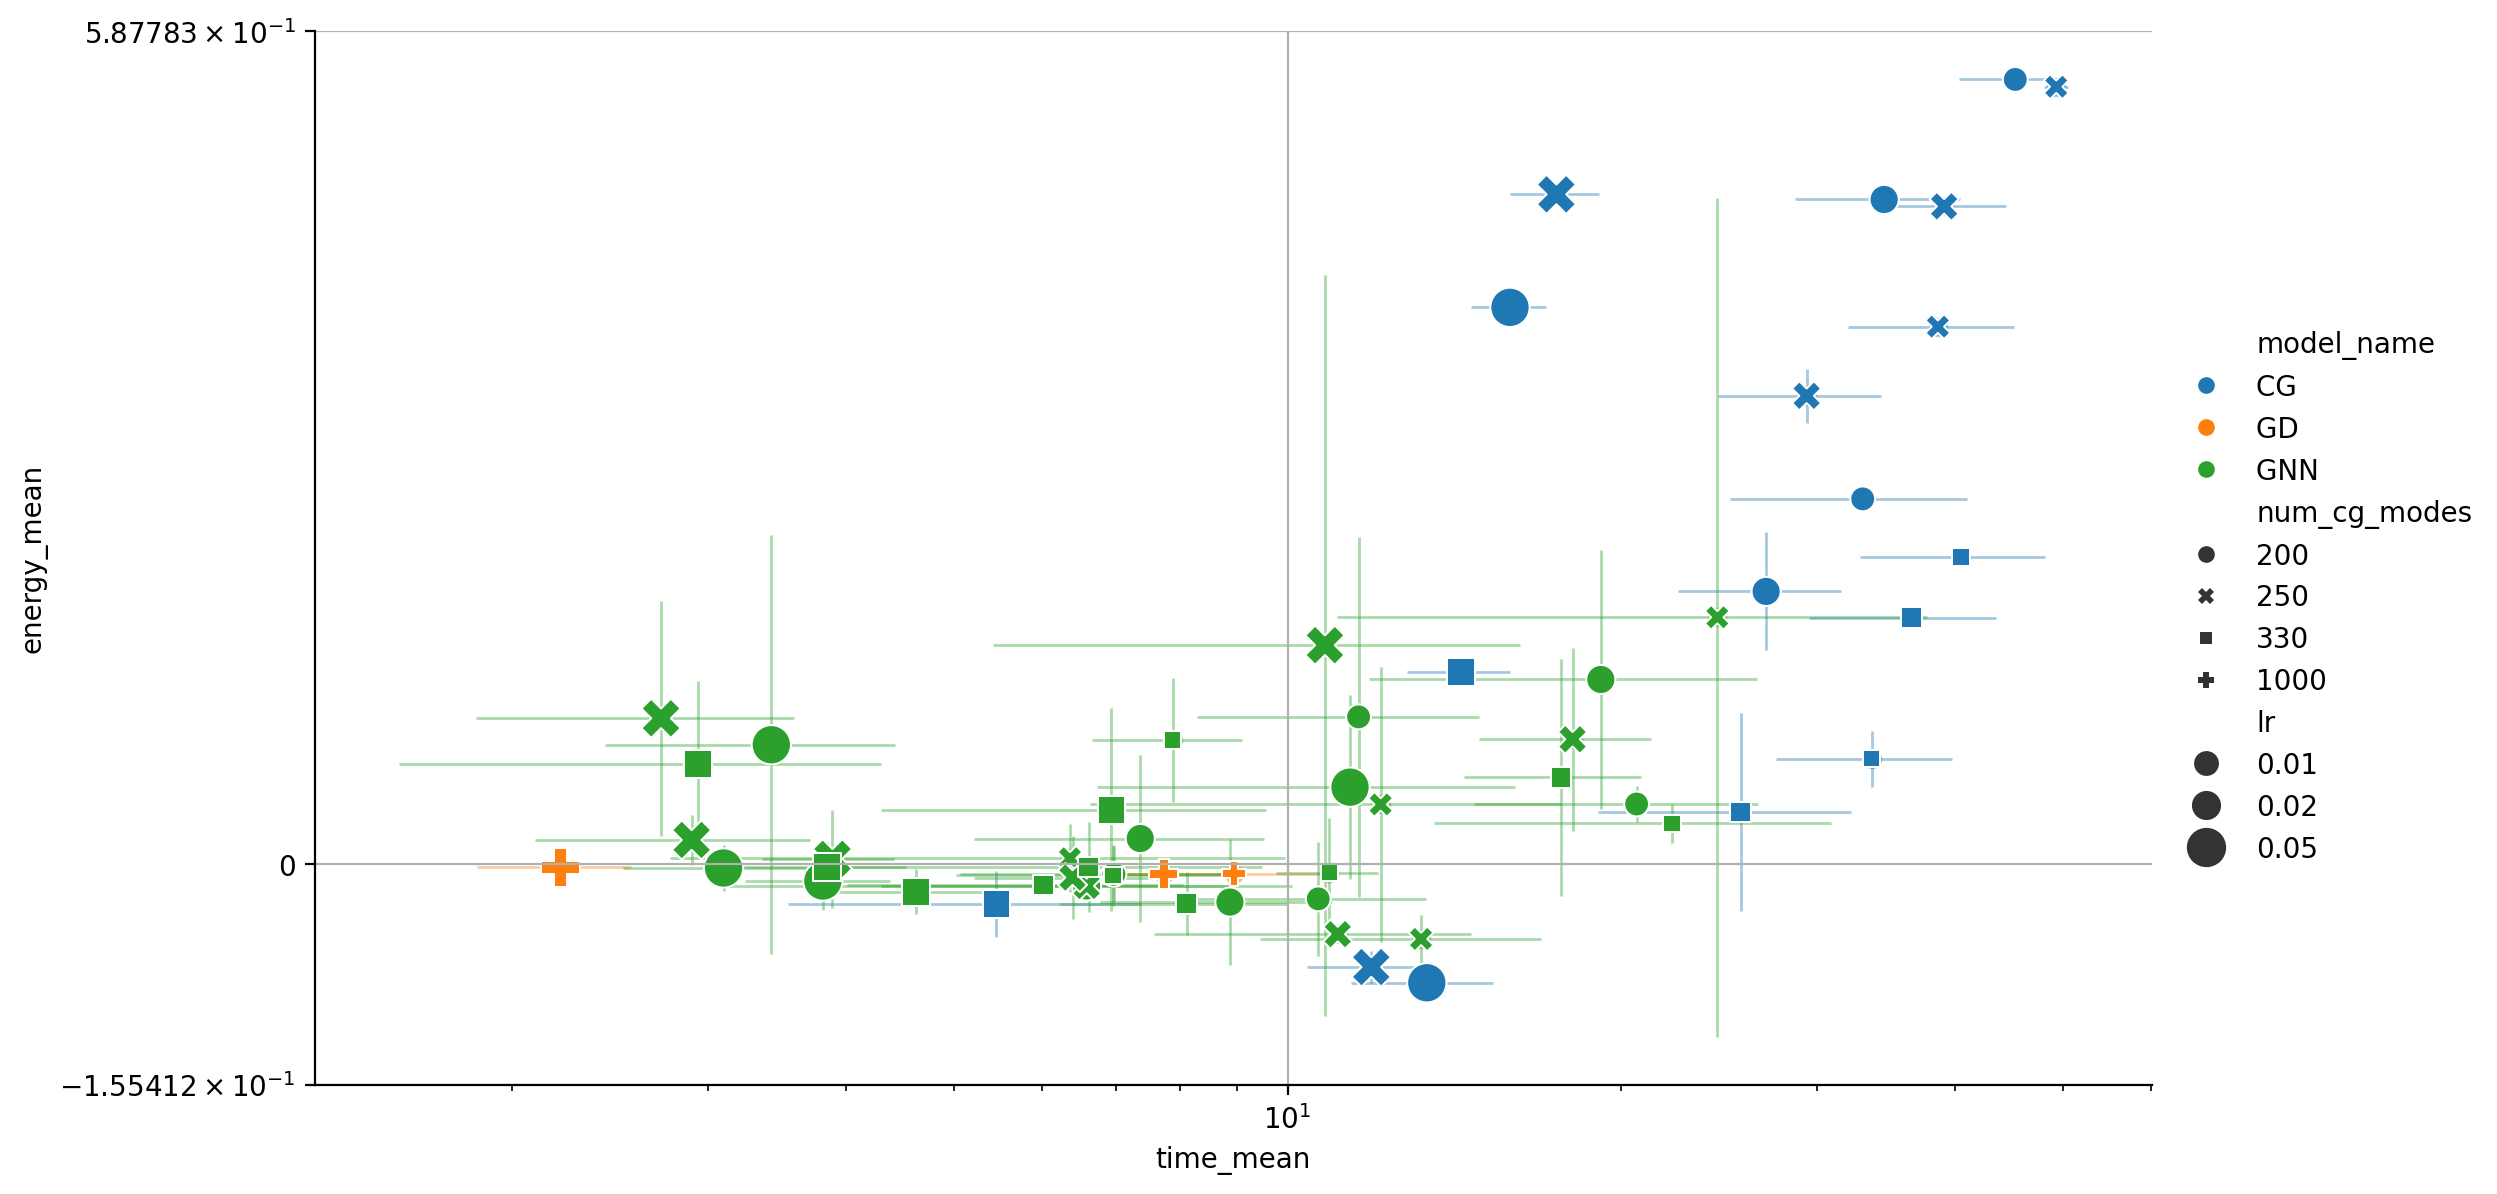

In [199]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', #'min_delta', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

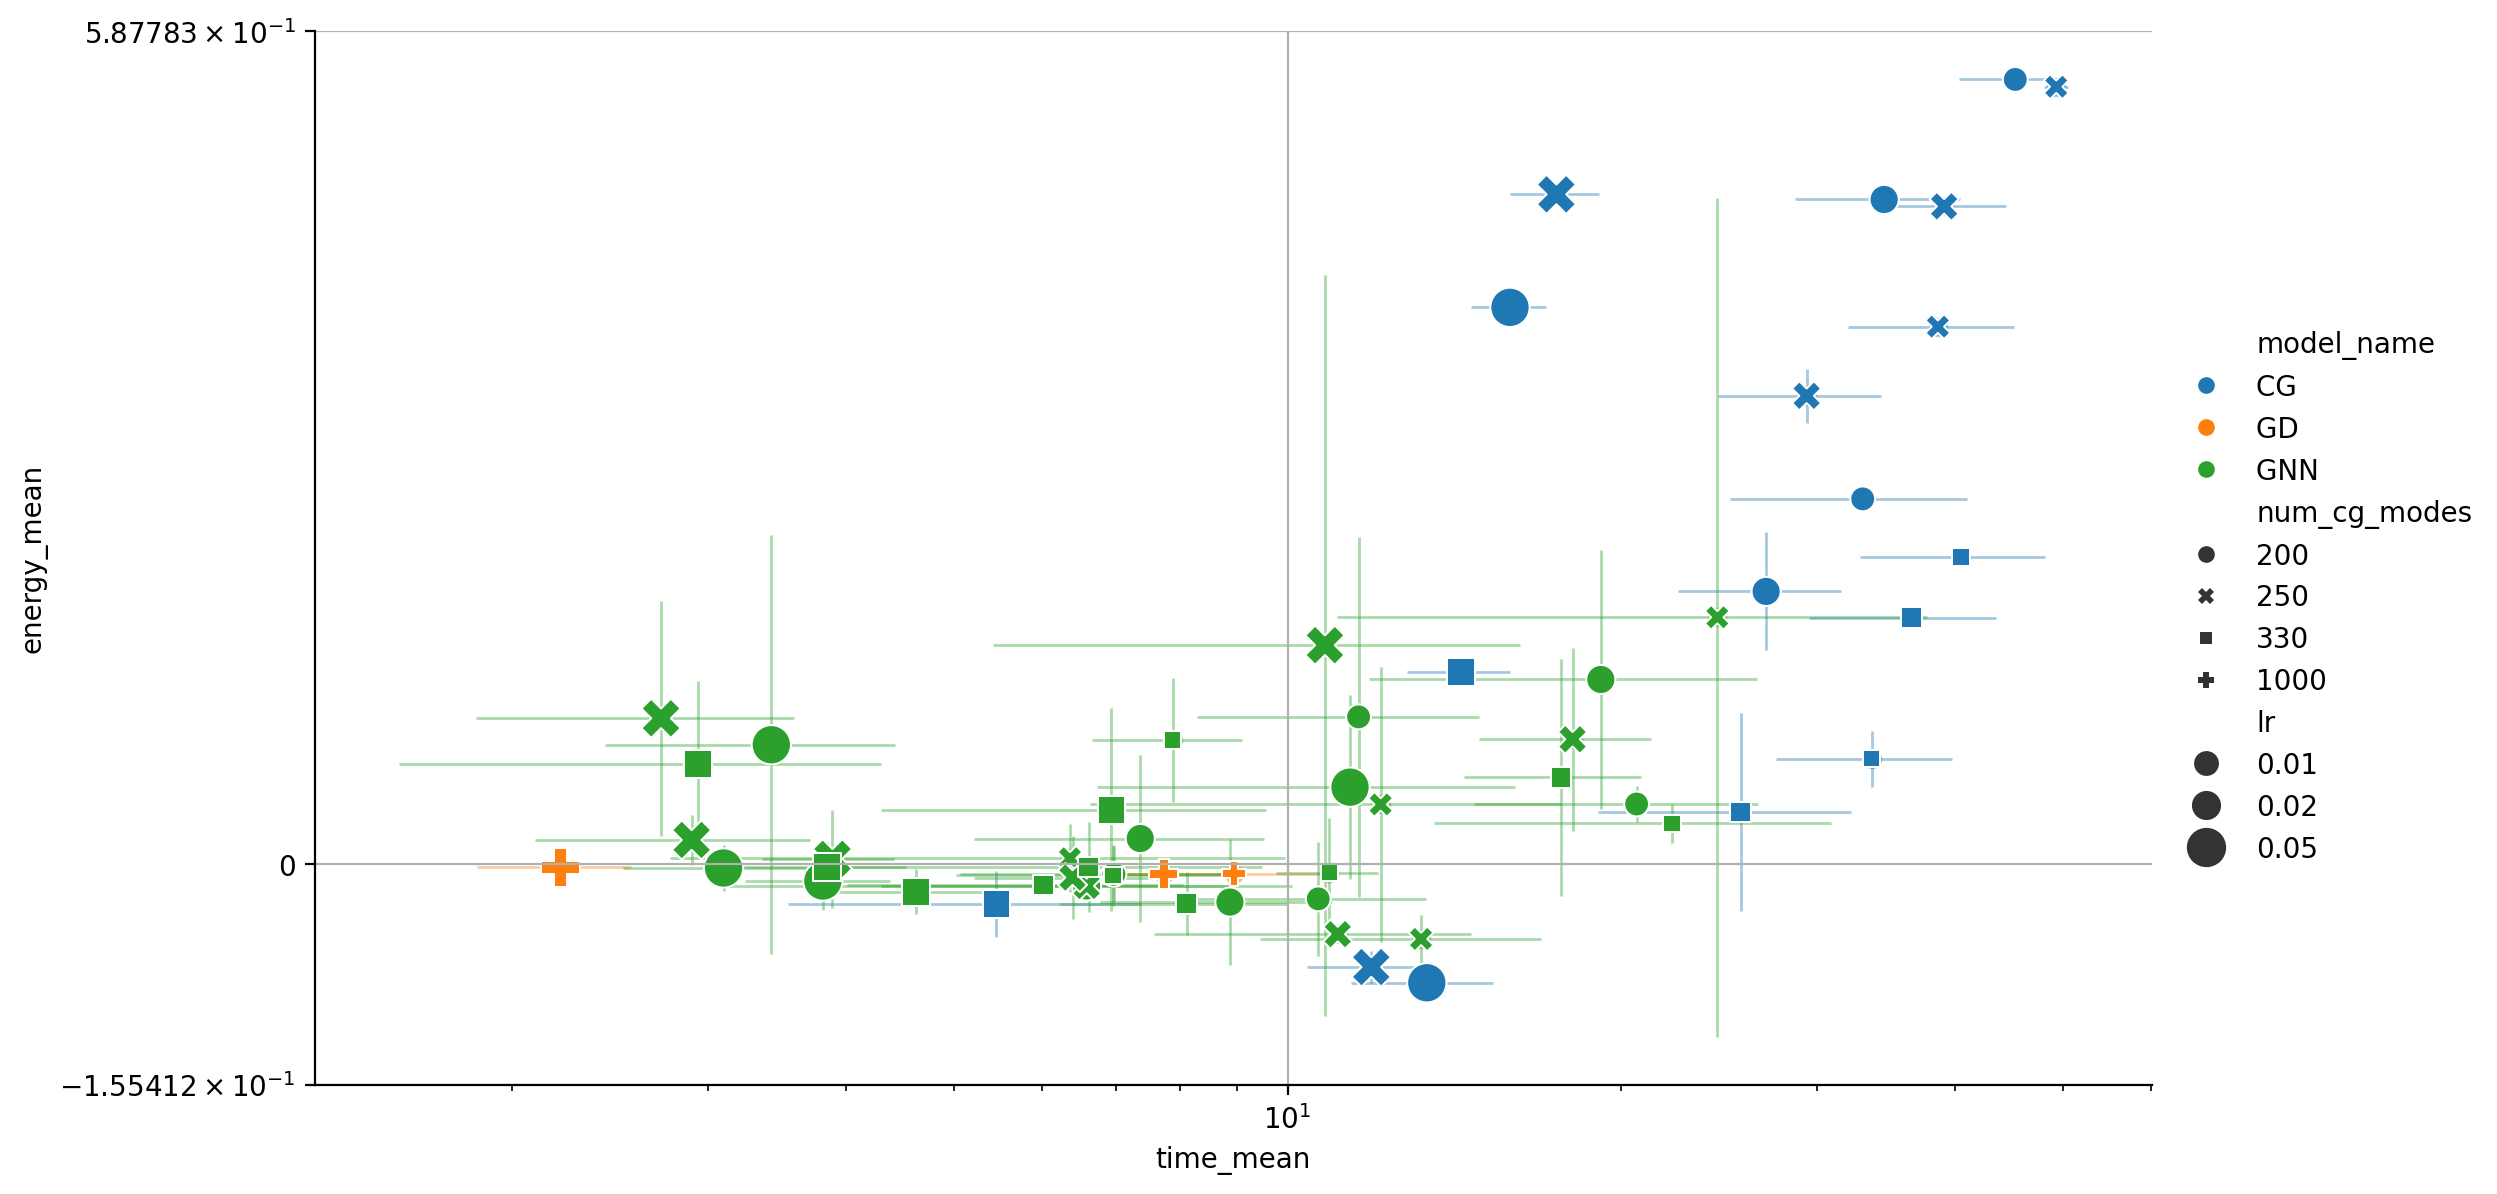

In [200]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.1, .05)
# plt.xlim(2,35)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

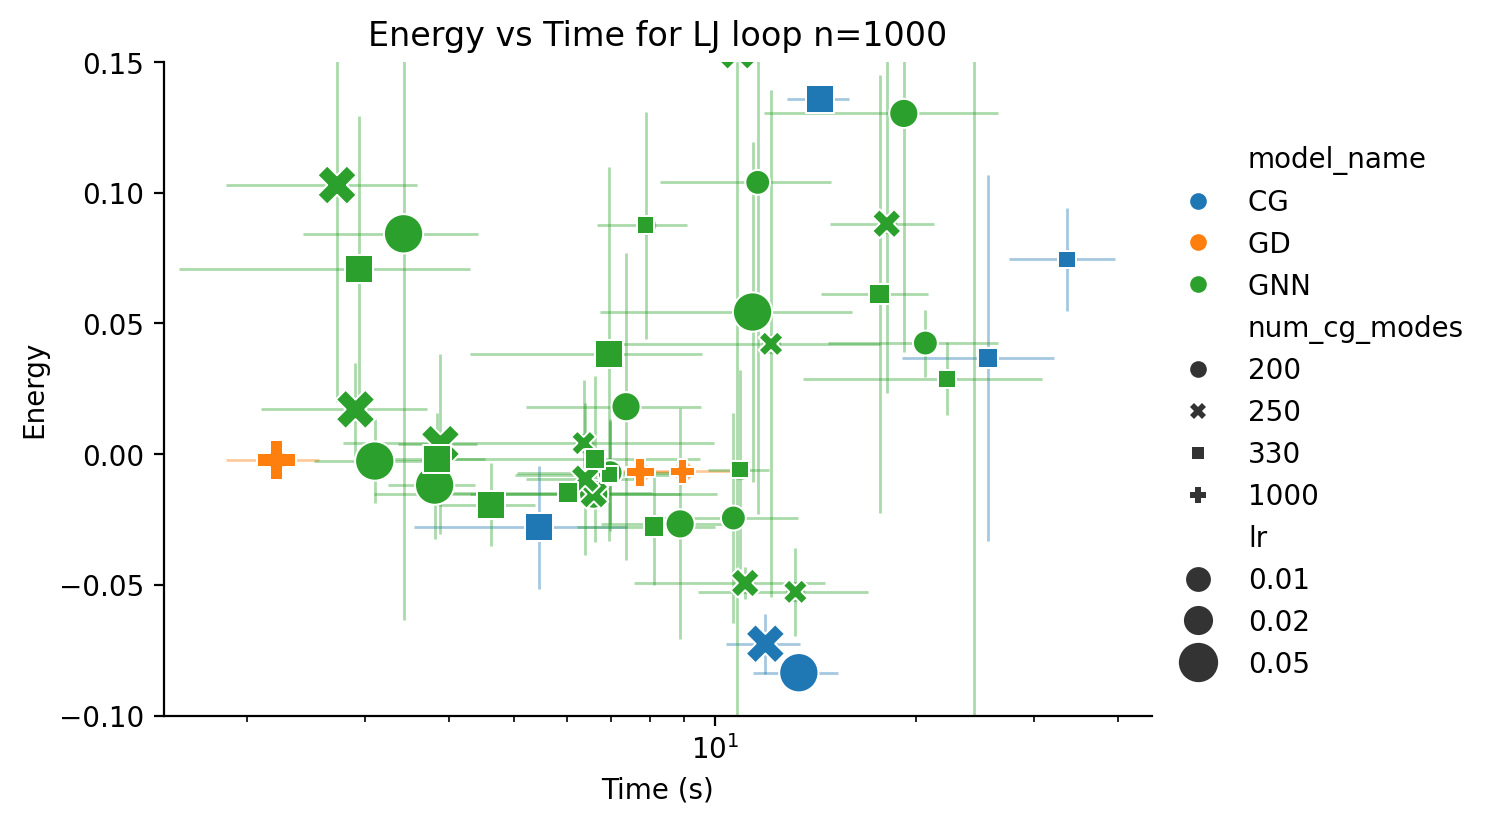

In [202]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=4, aspect=1.5, sizes=(80, 200))
plt.xlabel('Time (s)')
plt.ylabel('Energy')

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)


plt.ylim(-.1, .15)
plt.xlim(1.5,45)
plt.xscale('log')
# plt.yscale('symlog')
# plt.grid()
num_nodes = df['num_nodes'][0]
plt.title(f'Energy vs Time for LJ loop n={num_nodes}')
plt.savefig(f'./figs/energy_vs_time_LJ_loop_n{num_nodes}.png', dpi=300, bbox_inches='tight')
# also save pdf for publication
plt.savefig(f'./figs/energy_vs_time_LJ_loop_n{num_nodes}.pdf', dpi=300, bbox_inches='tight')

In [131]:
df.columns

Index(['energy_function', 'model_name', 'energy', 'time', 'lr', 'clamp_grads',
       'patience', 'min_delta', 'x0_std', 'num_nodes', 'lr_cg', 'cg_patience',
       'cg_min_delta', 'cg_steps', 'cg_time', 'cg_energy', 'num_cg_modes',
       'hidden_dims', 'cg_ratio'],
      dtype='object')

In [129]:
' '.join(df['energy_function'][0].split('_')[1:])

'LJ 2scale'

# Quadratic Bonds + LJ loop n=1000
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph with quadratic bonds, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [162]:
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_Bond_LJ_experiments_2024-02-10-23.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
df = exp_logger.to_dataframe()
df

energy_function                model_name    energy       time    lr  \
0    Energy_Bond_LJ       GD_Bond_LJ_n1000_d3 -0.022777  10.918500  0.05   
1    Energy_Bond_LJ   CG_Bond_LJ0.33_n1000_d3 -0.023312  14.456980  0.05   
2    Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.014732  20.726403  0.05   
3    Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.020530   6.009238  0.05   
4    Energy_Bond_LJ   CG_Bond_LJ0.25_n1000_d3 -0.014197   9.047730  0.05   
..              ...                       ...       ...        ...   ...   
292  Energy_Bond_LJ   CG_Bond_LJ0.20_n1000_d3 -0.023392  24.385888  0.02   
293  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.023202  22.378541  0.02   
294  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.021678  11.162275  0.02   
295  Energy_Bond_LJ   CG_Bond_LJ0.33_n1000_d3 -0.015951   4.319833  0.02   
296  Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.022103   6.396595  0.02   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  2.449459       1000    NaN   
1            0.1        20  1.000000e-06  2.449459       1000  0.050   
2            0.1        20  1.000000e-06  2.449459       1000  0.005   
3            0.1        20  1.000000e-06  2.449459       1000  0.005   
4            0.1        20  1.000000e-06  2.449459       1000  0.050   
..           ...       ...           ...       ...        ...    ...   
292          0.1        20  1.000000e-07  2.449459       1000  0.020   
293          0.1        20  1.000000e-07  2.449459       1000  0.002   
294          0.1        20  1.000000e-07  2.449459       1000  0.002   
295          0.1        20  1.000000e-07  2.449459       1000  0.200   
296          0.1        20  1.000000e-07  2.449459       1000  0.020   

     cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  \
0            NaN           NaN       NaN        NaN        NaN           NaN   
1           20.0      0.000010     544.0  10.700821  -0.020303         333.0   
2           20.0      0.000010     614.0  14.978873  -0.014175         333.0   
3           20.0      0.000010     208.0   5.664539  -0.017016         333.0   
4           20.0      0.000010     359.0   7.528658  -0.012860         250.0   
..           ...           ...       ...        ...        ...           ...   
292         20.0      0.000001     916.0  18.518092  -0.022364         200.0   
293         20.0      0.000001     767.0  19.272107  -0.022969         200.0   
294         20.0      0.000001     430.0  10.811344  -0.020804         200.0   
295         20.0      0.000001     169.0   3.948196  -0.012326         333.0   
296         20.0      0.000001     236.0   6.046359  -0.018556         333.0   

     hidden_dims  
0            NaN  
1            NaN  
2      [8, 4, 3]  
3    [32, 16, 3]  
4            NaN  
..           ...  
292          NaN  
293    [8, 4, 3]  
294  [32, 16, 3]  
295          NaN  
296    [8, 4, 3]  

[297 rows x 18 columns]

In [163]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']
# ensure that the num_cg_modes is an integer
df['num_cg_modes'] = df['num_cg_modes'].astype(int)
df[:10]

energy_function                model_name    energy       time    lr  \
0  Energy_Bond_LJ       GD_Bond_LJ_n1000_d3 -0.022777  10.918500  0.05   
1  Energy_Bond_LJ   CG_Bond_LJ0.33_n1000_d3 -0.023312  14.456980  0.05   
2  Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.014732  20.726403  0.05   
3  Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.020530   6.009238  0.05   
4  Energy_Bond_LJ   CG_Bond_LJ0.25_n1000_d3 -0.014197   9.047730  0.05   
5  Energy_Bond_LJ  GNN_Bond_LJ0.25_n1000_d3 -0.014698  13.584062  0.05   
6  Energy_Bond_LJ  GNN_Bond_LJ0.25_n1000_d3 -0.022771  12.646562  0.05   
7  Energy_Bond_LJ   CG_Bond_LJ0.20_n1000_d3 -0.023343  13.153043  0.05   
8  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.023112  17.938087  0.05   
9  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.021056   7.102287  0.05   

   clamp_grads  patience  min_delta    x0_std  num_nodes  lr_cg  cg_patience  \
0          0.1        20   0.000001  2.449459       1000    NaN          NaN   
1          0.1        20   0.000001  2.449459       1000  0.050         20.0   
2          0.1        20   0.000001  2.449459       1000  0.005         20.0   
3          0.1        20   0.000001  2.449459       1000  0.005         20.0   
4          0.1        20   0.000001  2.449459       1000  0.050         20.0   
5          0.1        20   0.000001  2.449459       1000  0.005         20.0   
6          0.1        20   0.000001  2.449459       1000  0.005         20.0   
7          0.1        20   0.000001  2.449459       1000  0.050         20.0   
8          0.1        20   0.000001  2.449459       1000  0.005         20.0   
9          0.1        20   0.000001  2.449459       1000  0.005         20.0   

   cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  hidden_dims  \
0           NaN       NaN        NaN        NaN          1000          NaN   
1       0.00001     544.0  10.700821  -0.020303           330          NaN   
2       0.00001     614.0  14.978873  -0.014175           330    [8, 4, 3]   
3       0.00001     208.0   5.664539  -0.017016           330  [32, 16, 3]   
4       0.00001     359.0   7.528658  -0.012860           250          NaN   
5       0.00001     431.0  10.562077  -0.013498           250    [8, 4, 3]   
6       0.00001     253.0   6.934950  -0.022274           250  [32, 16, 3]   
7       0.00001     591.0  11.943967  -0.022390           200          NaN   
8       0.00001     619.0  14.890392  -0.022722           200    [8, 4, 3]   
9       0.00001     241.0   6.754832  -0.016494           200  [32, 16, 3]   

   cg_ratio  
0      1.00  
1      0.33  
2      0.33  
3      0.33  
4      0.25  
5      0.25  
6      0.25  
7      0.20  
8      0.20  
9      0.20

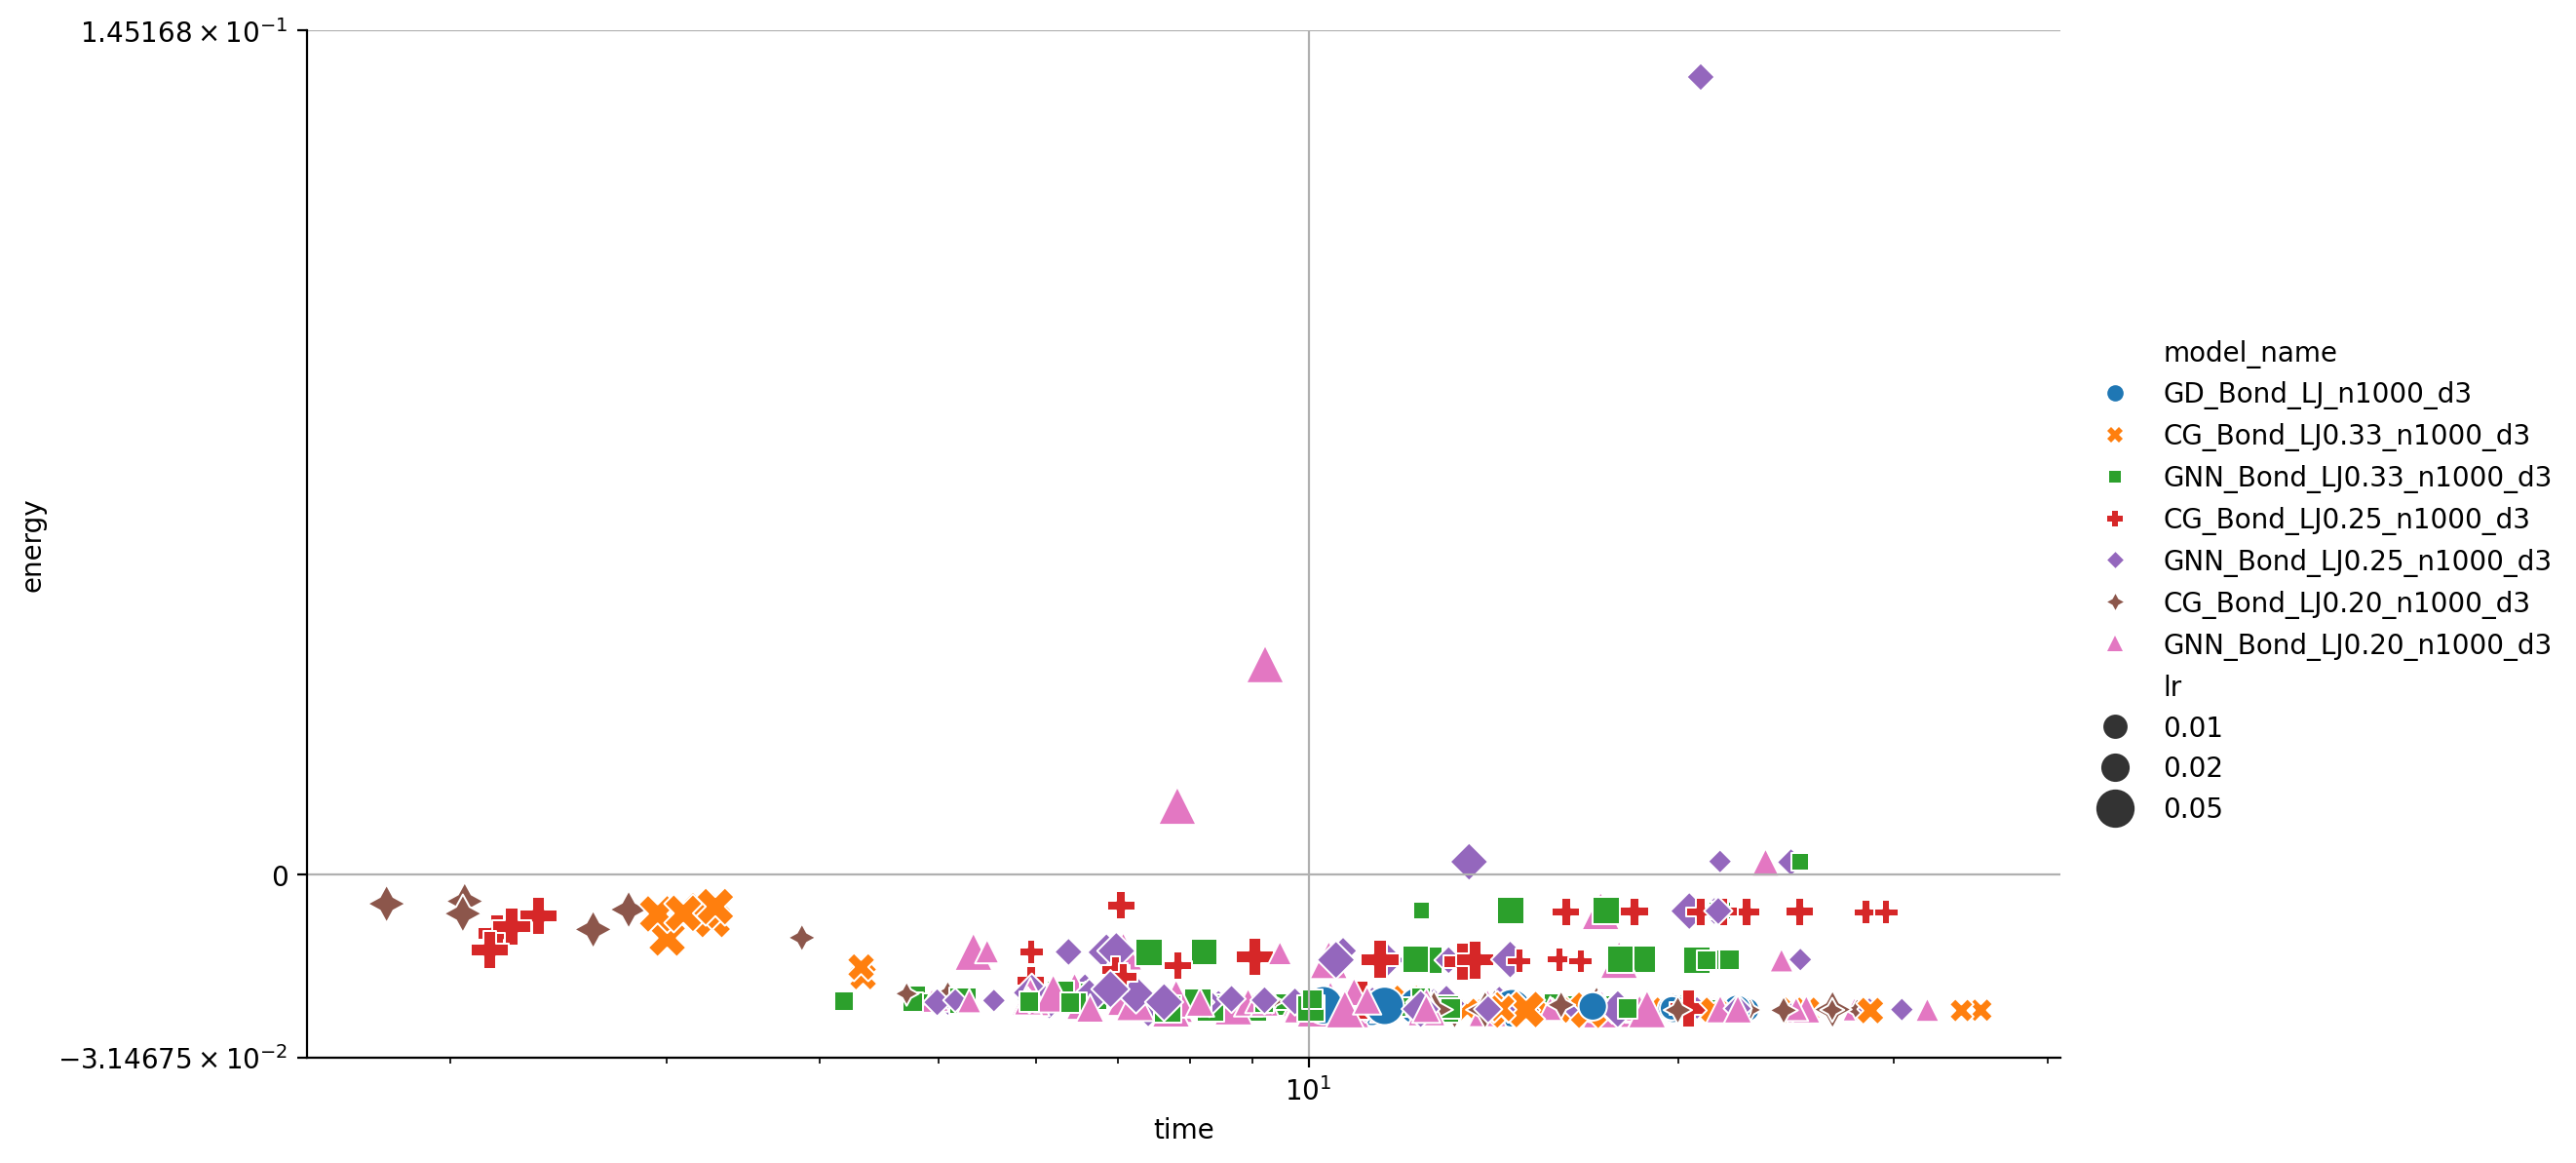

In [164]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.0234, -.0228)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

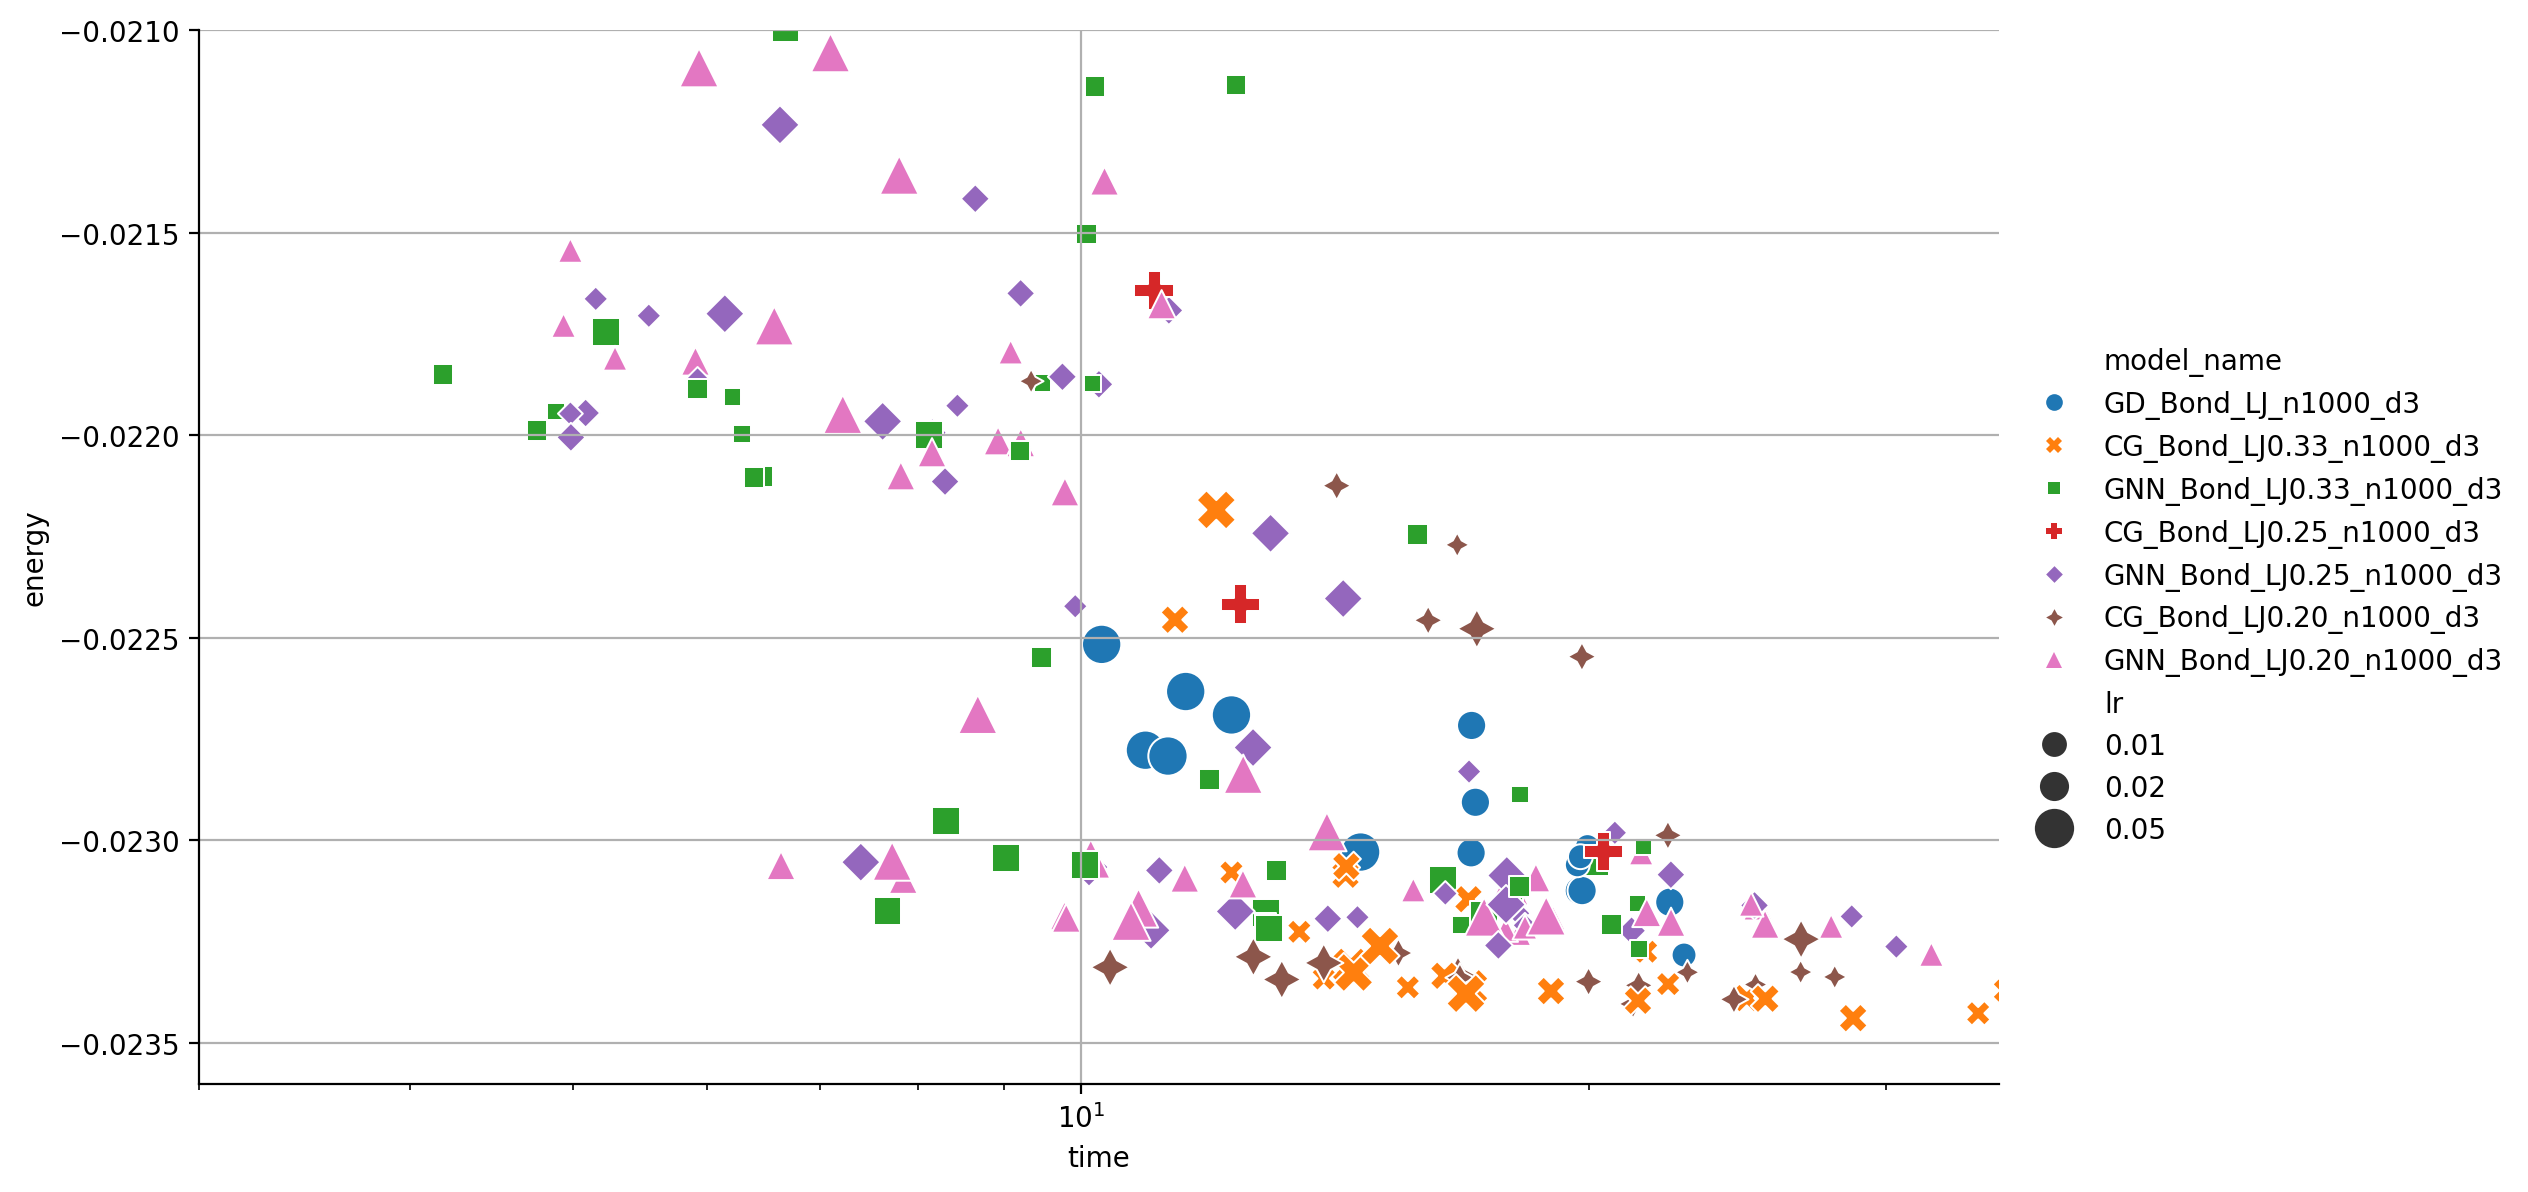

In [165]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0236, -.0210)
plt.xlim(3,35)
plt.xscale('log')
plt.grid()

## Grouping similar runs

In [166]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'num_cg_modes', 'lr_cg', 'hidden_dims'])
# other options: cg_patience,cg_min_delta, 'min_delta'
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1753380/1693138012.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1753380/1693138012.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr num_cg_modes  lr_cg  hidden_dims    energy  \
                                                                         mean   
0    CG_Bond_LJ0.20_n1000_d3  0.01          200  0.010          NaN -0.023336   
1    CG_Bond_LJ0.20_n1000_d3  0.01          200  0.100          NaN -0.021253   
2    CG_Bond_LJ0.20_n1000_d3  0.02          200  0.020          NaN -0.023353   
3    CG_Bond_LJ0.20_n1000_d3  0.02          200  0.200          NaN -0.020204   
4    CG_Bond_LJ0.20_n1000_d3  0.05          200  0.050          NaN -0.023304   
5    CG_Bond_LJ0.20_n1000_d3  0.05          200  0.500          NaN -0.009080   
6    CG_Bond_LJ0.25_n1000_d3  0.01          250  0.010          NaN -0.006447   
7    CG_Bond_LJ0.25_n1000_d3  0.01          250  0.100          NaN -0.014464   
8    CG_Bond_LJ0.25_n1000_d3  0.02          250  0.020          NaN -0.006457   
9    CG_Bond_LJ0.25_n1000_d3  0.02          250  0.200          NaN -0.014695   
10   CG_Bond_LJ0.25_n1000_d3  0.05          250  0.050          NaN -0.016094   
11   CG_Bond_LJ0.25_n1000_d3  0.05          250  0.500          NaN -0.013908   
12   CG_Bond_LJ0.33_n1000_d3  0.01          330  0.010          NaN -0.023357   
13   CG_Bond_LJ0.33_n1000_d3  0.01          330  0.100          NaN -0.023252   
14   CG_Bond_LJ0.33_n1000_d3  0.02          330  0.020          NaN -0.023387   
15   CG_Bond_LJ0.33_n1000_d3  0.02          330  0.200          NaN -0.020881   
16   CG_Bond_LJ0.33_n1000_d3  0.05          330  0.050          NaN -0.023138   
17   CG_Bond_LJ0.33_n1000_d3  0.05          330  0.500          NaN -0.007341   
18       GD_Bond_LJ_n1000_d3  0.01         1000    NaN          NaN -0.023100   
19       GD_Bond_LJ_n1000_d3  0.02         1000    NaN          NaN -0.023009   
20       GD_Bond_LJ_n1000_d3  0.05         1000    NaN          NaN -0.022739   
21  GNN_Bond_LJ0.20_n1000_d3  0.01          200  0.001  [32, 16, 3] -0.023166   
22  GNN_Bond_LJ0.20_n1000_d3  0.01          200  0.001    [8, 4, 3] -0.021108   
23  GNN_Bond_LJ0.20_n1000_d3  0.01          200  0.010  [32, 16, 3] -0.019576   
24  GNN_Bond_LJ0.20_n1000_d3  0.01          200  0.010    [8, 4, 3] -0.020417   
25  GNN_Bond_LJ0.20_n1000_d3  0.02          200  0.002  [32, 16, 3] -0.021549   
26  GNN_Bond_LJ0.20_n1000_d3  0.02          200  0.002    [8, 4, 3] -0.018965   
27  GNN_Bond_LJ0.20_n1000_d3  0.02          200  0.020  [32, 16, 3] -0.022870   
28  GNN_Bond_LJ0.20_n1000_d3  0.02          200  0.020    [8, 4, 3] -0.022253   
29  GNN_Bond_LJ0.20_n1000_d3  0.05          200  0.005  [32, 16, 3] -0.021138   
30  GNN_Bond_LJ0.20_n1000_d3  0.05          200  0.005    [8, 4, 3] -0.018848   
31  GNN_Bond_LJ0.20_n1000_d3  0.05          200  0.050  [32, 16, 3] -0.019861   
32  GNN_Bond_LJ0.20_n1000_d3  0.05          200  0.050    [8, 4, 3] -0.005574   
33  GNN_Bond_LJ0.25_n1000_d3  0.01          250  0.001  [32, 16, 3] -0.023050   
34  GNN_Bond_LJ0.25_n1000_d3  0.01          250  0.001    [8, 4, 3] -0.014724   
35  GNN_Bond_LJ0.25_n1000_d3  0.01          250  0.010  [32, 16, 3] -0.021794   
36  GNN_Bond_LJ0.25_n1000_d3  0.01          250  0.010    [8, 4, 3] -0.022667   
37  GNN_Bond_LJ0.25_n1000_d3  0.02          250  0.002  [32, 16, 3] -0.020275   
38  GNN_Bond_LJ0.25_n1000_d3  0.02          250  0.002    [8, 4, 3]  0.013394   
39  GNN_Bond_LJ0.25_n1000_d3  0.02          250  0.020  [32, 16, 3] -0.020725   
40  GNN_Bond_LJ0.25_n1000_d3  0.02          250  0.020    [8, 4, 3] -0.021057   
41  GNN_Bond_LJ0.25_n1000_d3  0.05          250  0.005  [32, 16, 3] -0.020842   
42  GNN_Bond_LJ0.25_n1000_d3  0.05          250  0.005    [8, 4, 3] -0.017247   
43  GNN_Bond_LJ0.25_n1000_d3  0.05          250  0.050  [32, 16, 3] -0.019841   
44  GNN_Bond_LJ0.25_n1000_d3  0.05          250  0.050    [8, 4, 3] -0.015685   
45  GNN_Bond_LJ0.33_n1000_d3  0.01          330  0.001  [32, 16, 3] -0.023127   
46  GNN_Bond_LJ0.33_n1000_d3  0.01          330  0.001    [8, 4, 3] -0.008380   
47  GNN_Bond_LJ0.33_n1000_d3  0.01          330  

In [167]:
df_copy

energy_function                model_name    energy       time    lr  \
0    Energy_Bond_LJ       GD_Bond_LJ_n1000_d3 -0.022777  10.918500  0.05   
1    Energy_Bond_LJ   CG_Bond_LJ0.33_n1000_d3 -0.023312  14.456980  0.05   
2    Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.014732  20.726403  0.05   
3    Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.020530   6.009238  0.05   
4    Energy_Bond_LJ   CG_Bond_LJ0.25_n1000_d3 -0.014197   9.047730  0.05   
..              ...                       ...       ...        ...   ...   
292  Energy_Bond_LJ   CG_Bond_LJ0.20_n1000_d3 -0.023392  24.385888  0.02   
293  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.023202  22.378541  0.02   
294  Energy_Bond_LJ  GNN_Bond_LJ0.20_n1000_d3 -0.021678  11.162275  0.02   
295  Energy_Bond_LJ   CG_Bond_LJ0.33_n1000_d3 -0.015951   4.319833  0.02   
296  Energy_Bond_LJ  GNN_Bond_LJ0.33_n1000_d3 -0.022103   6.396595  0.02   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  2.449459       1000     na   
1            0.1        20  1.000000e-06  2.449459       1000   0.05   
2            0.1        20  1.000000e-06  2.449459       1000  0.005   
3            0.1        20  1.000000e-06  2.449459       1000  0.005   
4            0.1        20  1.000000e-06  2.449459       1000   0.05   
..           ...       ...           ...       ...        ...    ...   
292          0.1        20  1.000000e-07  2.449459       1000   0.02   
293          0.1        20  1.000000e-07  2.449459       1000  0.002   
294          0.1        20  1.000000e-07  2.449459       1000  0.002   
295          0.1        20  1.000000e-07  2.449459       1000    0.2   
296          0.1        20  1.000000e-07  2.449459       1000   0.02   

    cg_patience cg_min_delta cg_steps    cg_time cg_energy  num_cg_modes  \
0            na           na       na         na        na          1000   
1          20.0      0.00001    544.0  10.700821 -0.020303           330   
2          20.0      0.00001    614.0  14.978873 -0.014175           330   
3          20.0      0.00001    208.0   5.664539 -0.017016           330   
4          20.0      0.00001    359.0   7.528658  -0.01286           250   
..          ...          ...      ...        ...       ...           ...   
292        20.0     0.000001    916.0  18.518092 -0.022364           200   
293        20.0     0.000001    767.0  19.272107 -0.022969           200   
294        20.0     0.000001    430.0  10.811344 -0.020804           200   
295        20.0     0.000001    169.0   3.948196 -0.012326           330   
296        20.0     0.000001    236.0   6.046359 -0.018556           330   

     hidden_dims  cg_ratio  
0             na      1.00  
1             na      0.33  
2      [8, 4, 3]      0.33  
3    [32, 16, 3]      0.33  
4             na      0.25  
..           ...       ...  
292           na      0.20  
293    [8, 4, 3]      0.20  
294  [32, 16, 3]      0.20  
295           na      0.33  
296    [8, 4, 3]      0.33  

[297 rows x 19 columns]

In [168]:
# get rows where  model_name starts with 'GD_'
df_gd = df_copy[df_copy['model_name'].str.startswith('GD_')]
df_gd


energy_function           model_name    energy       time    lr  \
0    Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022777  10.918500  0.05   
19   Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022792  11.259418  0.05   
38   Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022906  17.132535  0.02   
57   Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023124  19.744540  0.02   
76   Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023283  22.779221  0.01   
95   Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023015  19.965389  0.01   
114  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023029  14.647153  0.05   
133  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022690  12.279235  0.05   
152  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023031  17.032860  0.02   
171  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023124  19.819117  0.02   
190  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023060  19.690192  0.01   
209  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023040  19.773942  0.01   
228  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022516  10.284926  0.05   
247  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022632  11.535480  0.05   
266  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.023152  22.340201  0.02   
285  Energy_Bond_LJ  GD_Bond_LJ_n1000_d3 -0.022716  17.043721  0.02   

     clamp_grads  patience     min_delta    x0_std  num_nodes lr_cg  \
0            0.1        20  1.000000e-06  2.449459       1000    na   
19           0.1        20  1.000000e-07  2.449459       1000    na   
38           0.1        20  1.000000e-06  2.449459       1000    na   
57           0.1        20  1.000000e-07  2.449459       1000    na   
76           0.1        20  1.000000e-06  2.449459       1000    na   
95           0.1        20  1.000000e-07  2.449459       1000    na   
114          0.1        20  1.000000e-06  2.449459       1000    na   
133          0.1        20  1.000000e-07  2.449459       1000    na   
152          0.1        20  1.000000e-06  2.449459       1000    na   
171          0.1        20  1.000000e-07  2.449459       1000    na   
190          0.1        20  1.000000e-06  2.449459       1000    na   
209          0.1        20  1.000000e-07  2.449459       1000    na   
228          0.1        20  1.000000e-06  2.449459       1000    na   
247          0.1        20  1.000000e-07  2.449459       1000    na   
266          0.1        20  1.000000e-06  2.449459       1000    na   
285          0.1        20  1.000000e-07  2.449459       1000    na   

    cg_patience cg_min_delta cg_steps cg_time cg_energy  num_cg_modes  \
0            na           na       na      na        na          1000   
19           na           na       na      na        na          1000   
38           na           na       na      na        na          1000   
57           na           na       na      na        na          1000   
76           na           na       na      na        na          1000   
95           na           na       na      na        na          1000   
114          na           na       na      na        na          1000   
133          na           na       na      na        na          1000   
152          na           na       na      na        na          1000   
171          na           na       na      na        na          1000   
190          na           na       na      na        na          1000   
209          na           na       na      na        na          1000   
228          na           na       na      na        na          1000   
247          na           na       na      na        na          1000   
266          na           na       na      na        na          1000   
285          na           na       na      na        na          1000   

    hidden_dims  cg_ratio  
0            na       1.0  
19           na       1.0  
38           na       1.0  
57           na       1.0  
76           na       1.0  
95           na       1.0  
114          na       1.0  
133          na       1.0  
152          na       1.0  
171          na       1.0  
190          na       1.0  
209       

In [169]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
# df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered = df_mean #[df_mean['energy']['std'] < std_threshold]

df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

In [170]:
df_filtered

index                model_name    lr  num_cg_modes  lr_cg  hidden_dims  \
0       0   CG_Bond_LJ0.20_n1000_d3  0.01           200  0.010          NaN   
1       1   CG_Bond_LJ0.20_n1000_d3  0.01           200  0.100          NaN   
2       2   CG_Bond_LJ0.20_n1000_d3  0.02           200  0.020          NaN   
3       3   CG_Bond_LJ0.20_n1000_d3  0.02           200  0.200          NaN   
4       4   CG_Bond_LJ0.20_n1000_d3  0.05           200  0.050          NaN   
5       5   CG_Bond_LJ0.20_n1000_d3  0.05           200  0.500          NaN   
6       6   CG_Bond_LJ0.25_n1000_d3  0.01           250  0.010          NaN   
7       7   CG_Bond_LJ0.25_n1000_d3  0.01           250  0.100          NaN   
8       8   CG_Bond_LJ0.25_n1000_d3  0.02           250  0.020          NaN   
9       9   CG_Bond_LJ0.25_n1000_d3  0.02           250  0.200          NaN   
10     10   CG_Bond_LJ0.25_n1000_d3  0.05           250  0.050          NaN   
11     11   CG_Bond_LJ0.25_n1000_d3  0.05           250  0.500          NaN   
12     12   CG_Bond_LJ0.33_n1000_d3  0.01           330  0.010          NaN   
13     13   CG_Bond_LJ0.33_n1000_d3  0.01           330  0.100          NaN   
14     14   CG_Bond_LJ0.33_n1000_d3  0.02           330  0.020          NaN   
15     15   CG_Bond_LJ0.33_n1000_d3  0.02           330  0.200          NaN   
16     16   CG_Bond_LJ0.33_n1000_d3  0.05           330  0.050          NaN   
17     17   CG_Bond_LJ0.33_n1000_d3  0.05           330  0.500          NaN   
18     18       GD_Bond_LJ_n1000_d3  0.01          1000    NaN          NaN   
19     19       GD_Bond_LJ_n1000_d3  0.02          1000    NaN          NaN   
20     20       GD_Bond_LJ_n1000_d3  0.05          1000    NaN          NaN   
21     21  GNN_Bond_LJ0.20_n1000_d3  0.01           200  0.001  [32, 16, 3]   
22     22  GNN_Bond_LJ0.20_n1000_d3  0.01           200  0.001    [8, 4, 3]   
23     23  GNN_Bond_LJ0.20_n1000_d3  0.01           200  0.010  [32, 16, 3]   
24     24  GNN_Bond_LJ0.20_n1000_d3  0.01           200  0.010    [8, 4, 3]   
25     25  GNN_Bond_LJ0.20_n1000_d3  0.02           200  0.002  [32, 16, 3]   
26     26  GNN_Bond_LJ0.20_n1000_d3  0.02           200  0.002    [8, 4, 3]   
27     27  GNN_Bond_LJ0.20_n1000_d3  0.02           200  0.020  [32, 16, 3]   
28     28  GNN_Bond_LJ0.20_n1000_d3  0.02           200  0.020    [8, 4, 3]   
29     29  GNN_Bond_LJ0.20_n1000_d3  0.05           200  0.005  [32, 16, 3]   
30     30  GNN_Bond_LJ0.20_n1000_d3  0.05           200  0.005    [8, 4, 3]   
31     31  GNN_Bond_LJ0.20_n1000_d3  0.05           200  0.050  [32, 16, 3]   
32     32  GNN_Bond_LJ0.20_n1000_d3  0.05           200  0.050    [8, 4, 3]   
33     33  GNN_Bond_LJ0.25_n1000_d3  0.01           250  0.001  [32, 16, 3]   
34     34  GNN_Bond_LJ0.25_n1000_d3  0.01           250  0.001    [8, 4, 3]   
35     35  GNN_Bond_LJ0.25_n1000_d3  0.01           250  0.010  [32, 16, 3]   
36     36  GNN_Bond_LJ0.25_n1000_d3  0.01           250  0.010    [8, 4, 3]   
37     37  GNN_Bond_LJ0.25_n1000_d3  0.02           250  0.002  [32, 16, 3]   
38     38  GNN_Bond_LJ0.25_n1000_d3  0.02           250  0.002    [8, 4, 3]   
39     39  GNN_Bond_LJ0.25_n1000_d3  0.02           250  0.020  [32, 16, 3]   
40     40  GNN_Bond_LJ0.25_n1000_d3  0.02           250  0.020    [8, 4, 3]   
41     41  GNN_Bond_LJ0.25_n1000_d3  0.05           250  0.005  [32, 16, 3]   
42     42  GNN_Bond_LJ0.25_n1000_d3  0.05           250  0.005    [8, 4, 3]   
43     43  GNN_Bond_LJ0.25_n1000_d3  0.05           250  0.050  [32, 16, 3]   
44     44  GNN_Bond_LJ0.25_n1000_d3  0.05           250  0.050    [8, 4, 3]   
45     45  GNN_Bond_LJ0.33_n1000_d3  0.01           330  0.001  [32, 16, 3]   
46     46  GNN_Bond_LJ0.33_n1000_d3  0.01           330  0.001    [8, 4, 3]   
47     47  GNN_Bond_LJ0.33_n1000_d3  0.01           330  0.010  [32, 16, 3]   
48     48  GNN_Bond_LJ0.33_n1000_d3  0.01           330  0.010    [8, 4, 3]   
49     49  GNN_Bond_LJ0.33_n1000_d3  0.02           33

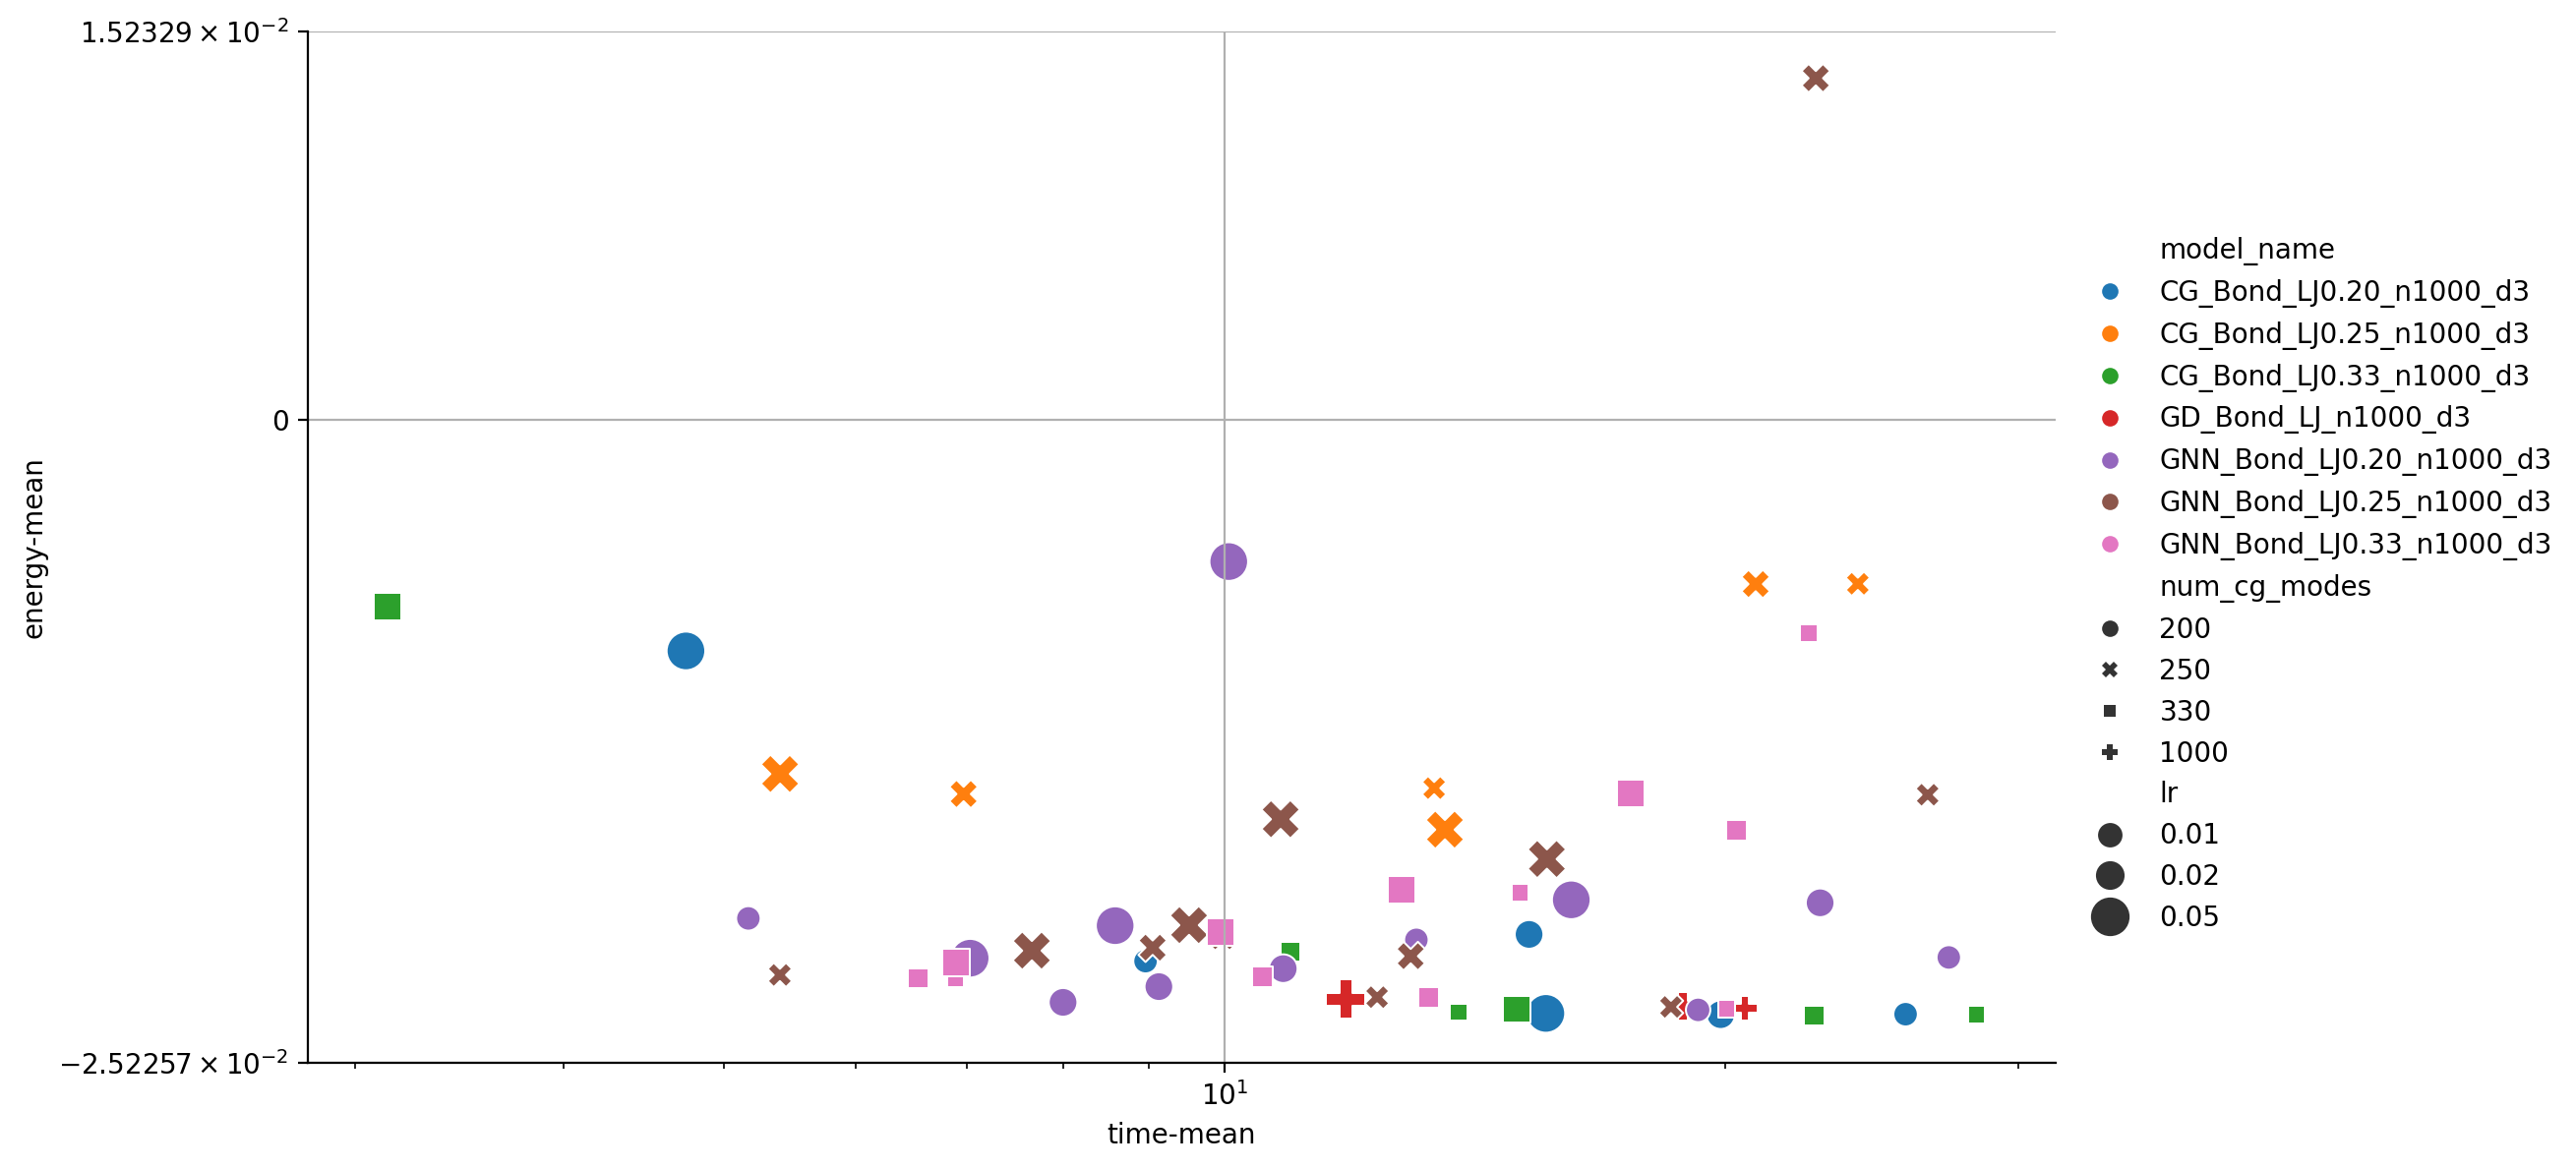

In [171]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', #'min_delta',
            kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

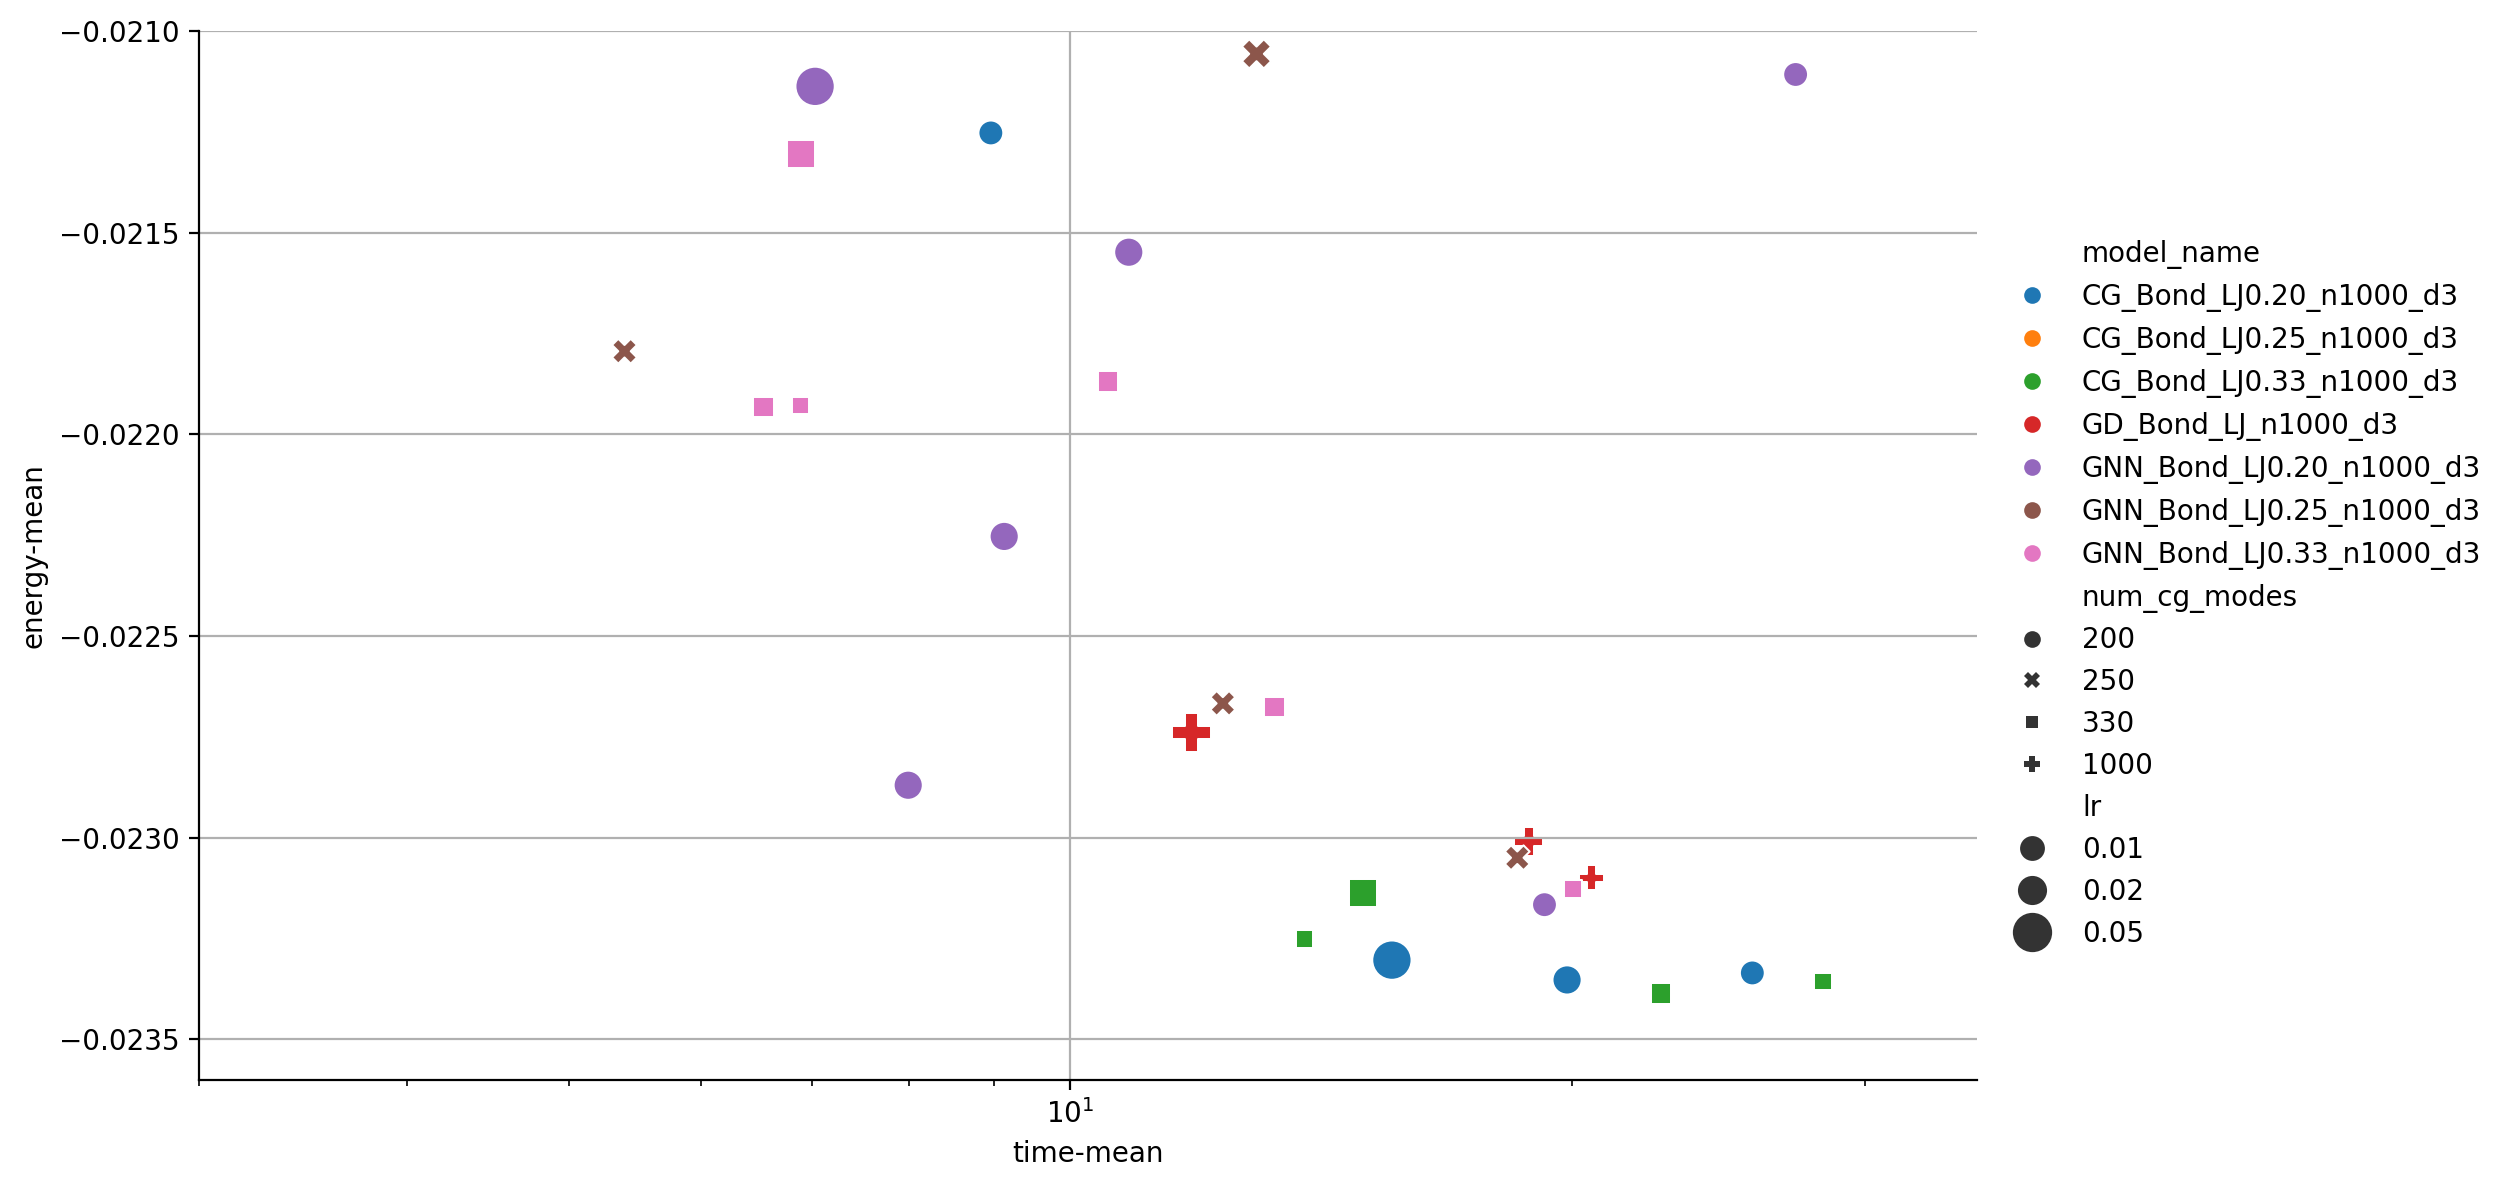

In [172]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0236, -.0210)
plt.xlim(3,35)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

In [173]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [174]:
df_cleaned

index model_name    lr  num_cg_modes  lr_cg  hidden_dims  energy-mean  \
0       0        CG   0.01           200  0.010          NaN    -0.023336   
1       1        CG   0.01           200  0.100          NaN    -0.021253   
2       2        CG   0.02           200  0.020          NaN    -0.023353   
3       3        CG   0.02           200  0.200          NaN    -0.020204   
4       4        CG   0.05           200  0.050          NaN    -0.023304   
5       5        CG   0.05           200  0.500          NaN    -0.009080   
6       6        CG   0.01           250  0.010          NaN    -0.006447   
7       7        CG   0.01           250  0.100          NaN    -0.014464   
8       8        CG   0.02           250  0.020          NaN    -0.006457   
9       9        CG   0.02           250  0.200          NaN    -0.014695   
10     10        CG   0.05           250  0.050          NaN    -0.016094   
11     11        CG   0.05           250  0.500          NaN    -0.013908   
12     12        CG   0.01           330  0.010          NaN    -0.023357   
13     13        CG   0.01           330  0.100          NaN    -0.023252   
14     14        CG   0.02           330  0.020          NaN    -0.023387   
15     15        CG   0.02           330  0.200          NaN    -0.020881   
16     16        CG   0.05           330  0.050          NaN    -0.023138   
17     17        CG   0.05           330  0.500          NaN    -0.007341   
18     18        GD   0.01          1000    NaN          NaN    -0.023100   
19     19        GD   0.02          1000    NaN          NaN    -0.023009   
20     20        GD   0.05          1000    NaN          NaN    -0.022739   
21     21       GNN   0.01           200  0.001  [32, 16, 3]    -0.023166   
22     22       GNN   0.01           200  0.001    [8, 4, 3]    -0.021108   
23     23       GNN   0.01           200  0.010  [32, 16, 3]    -0.019576   
24     24       GNN   0.01           200  0.010    [8, 4, 3]    -0.020417   
25     25       GNN   0.02           200  0.002  [32, 16, 3]    -0.021549   
26     26       GNN   0.02           200  0.002    [8, 4, 3]    -0.018965   
27     27       GNN   0.02           200  0.020  [32, 16, 3]    -0.022870   
28     28       GNN   0.02           200  0.020    [8, 4, 3]    -0.022253   
29     29       GNN   0.05           200  0.005  [32, 16, 3]    -0.021138   
30     30       GNN   0.05           200  0.005    [8, 4, 3]    -0.018848   
31     31       GNN   0.05           200  0.050  [32, 16, 3]    -0.019861   
32     32       GNN   0.05           200  0.050    [8, 4, 3]    -0.005574   
33     33       GNN   0.01           250  0.001  [32, 16, 3]    -0.023050   
34     34       GNN   0.01           250  0.001    [8, 4, 3]    -0.014724   
35     35       GNN   0.01           250  0.010  [32, 16, 3]    -0.021794   
36     36       GNN   0.01           250  0.010    [8, 4, 3]    -0.022667   
37     37       GNN   0.02           250  0.002  [32, 16, 3]    -0.020275   
38     38       GNN   0.02           250  0.002    [8, 4, 3]     0.013394   
39     39       GNN   0.02           250  0.020  [32, 16, 3]    -0.020725   
40     40       GNN   0.02           250  0.020    [8, 4, 3]    -0.021057   
41     41       GNN   0.05           250  0.005  [32, 16, 3]    -0.020842   
42     42       GNN   0.05           250  0.005    [8, 4, 3]    -0.017247   
43     43       GNN   0.05           250  0.050  [32, 16, 3]    -0.019841   
44     44       GNN   0.05           250  0.050    [8, 4, 3]    -0.015685   
45     45       GNN   0.01           330  0.001  [32, 16, 3]    -0.023127   
46     46       GNN   0.01           330  0.001    [8, 4, 3]    -0.008380   
47     47       GNN   0.01           330  0.010  [32, 16, 3]    -0.021929   
48     48       GNN   0.01           330  0.010    [8, 4, 3]    -0.018568   
49     49       GNN   0.02           330  0.002  [32, 16, 3]    -0.021869   
50     50       GNN   0.02           330  0.002    [8, 4, 3]    -0.016129   


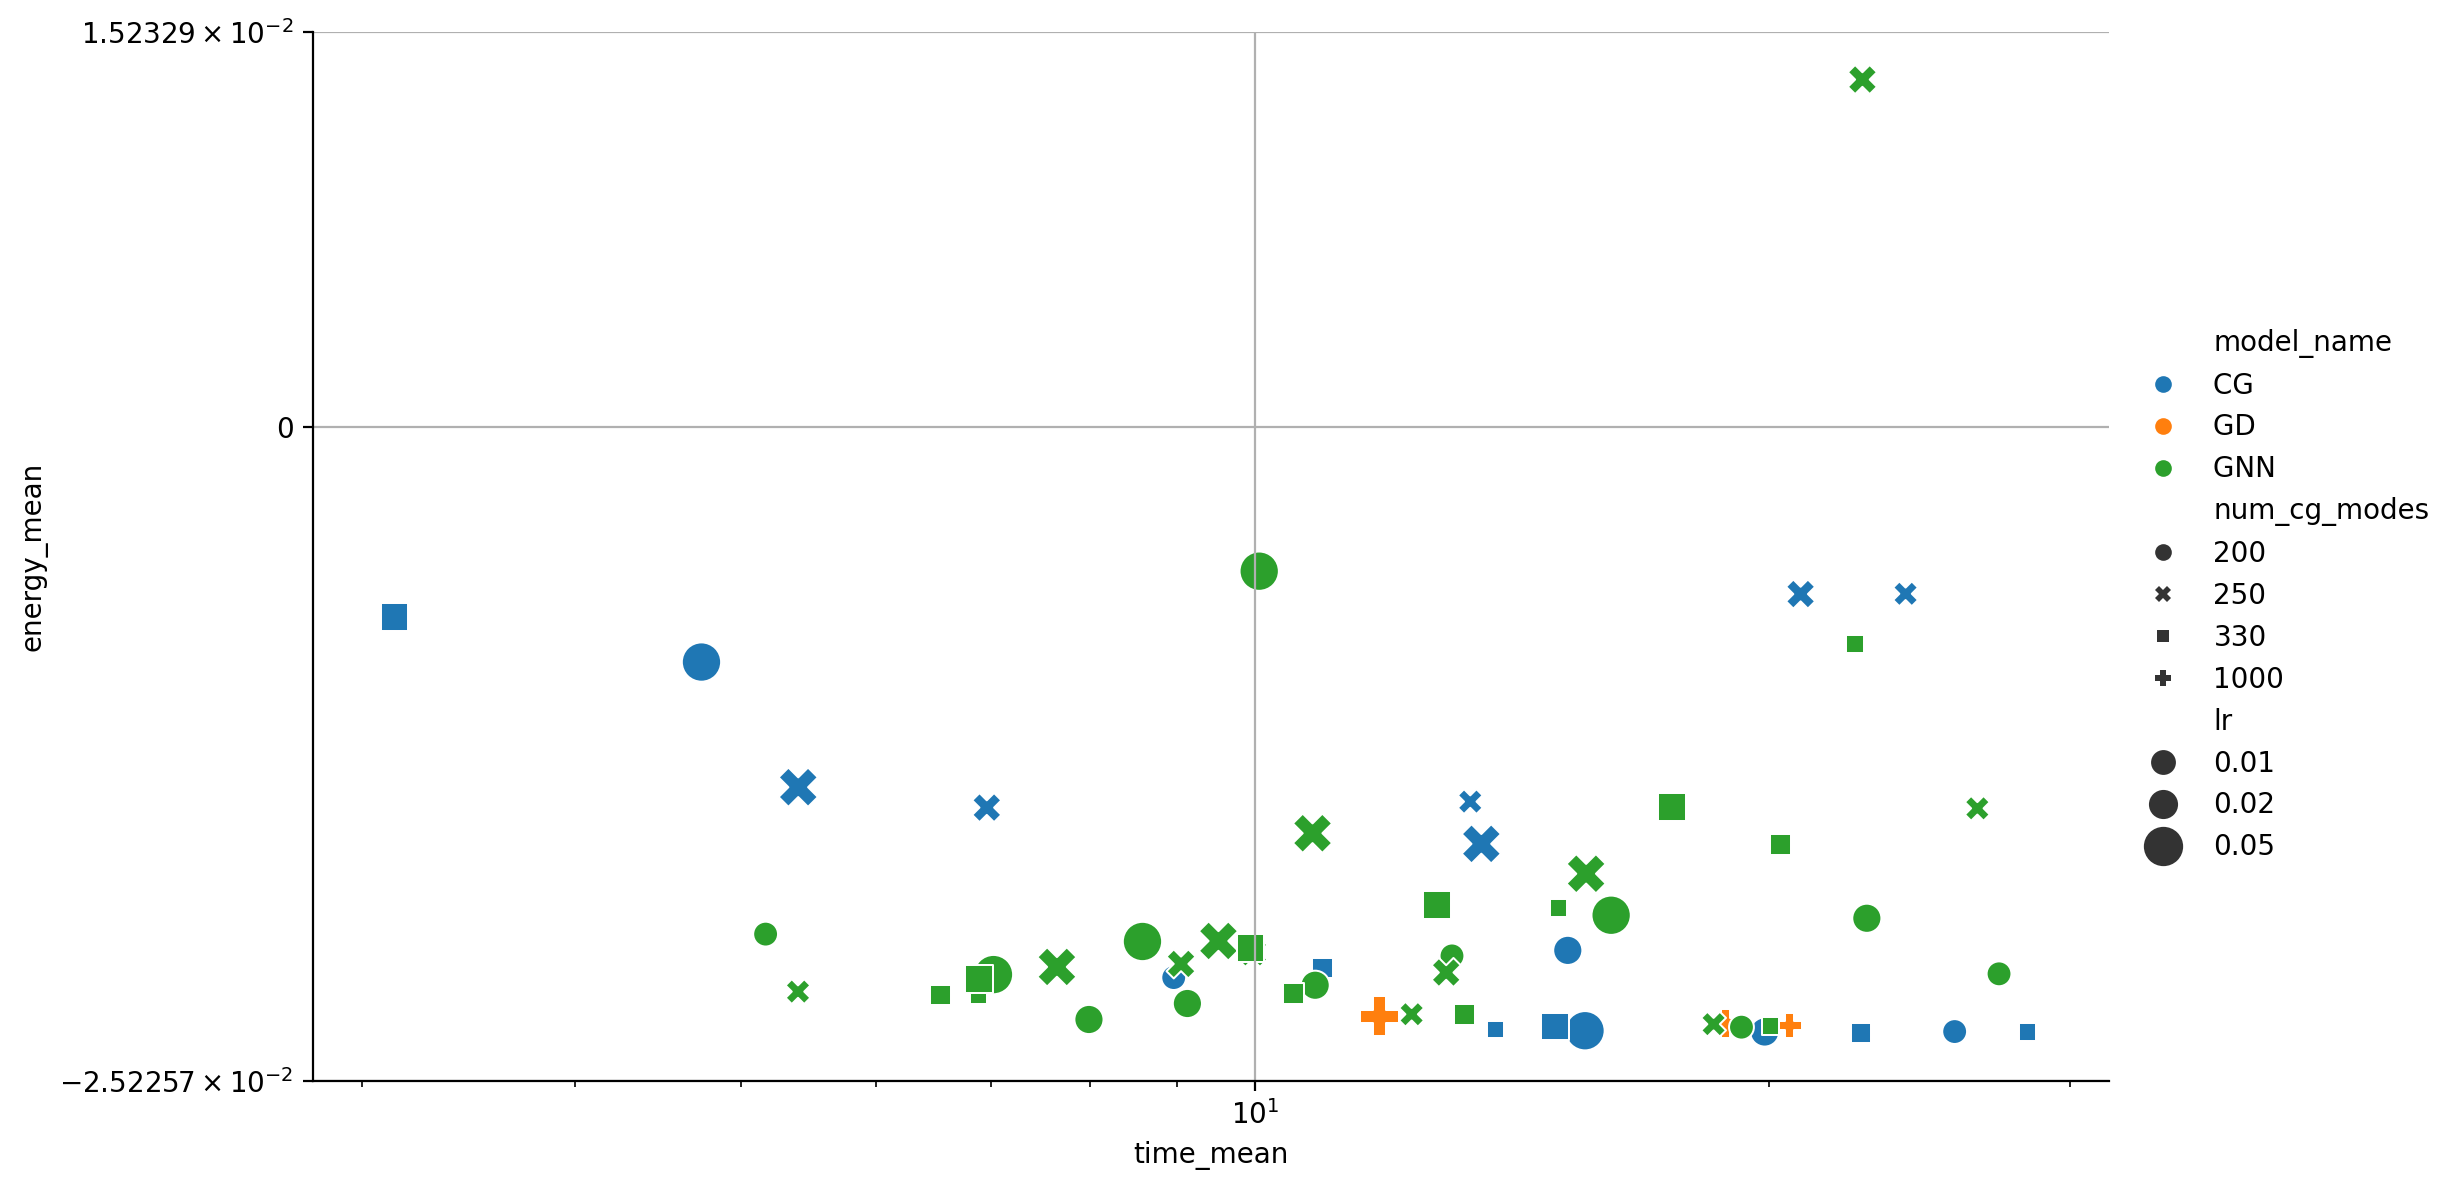

In [175]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='num_cg_modes',#'min_delta',
            kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

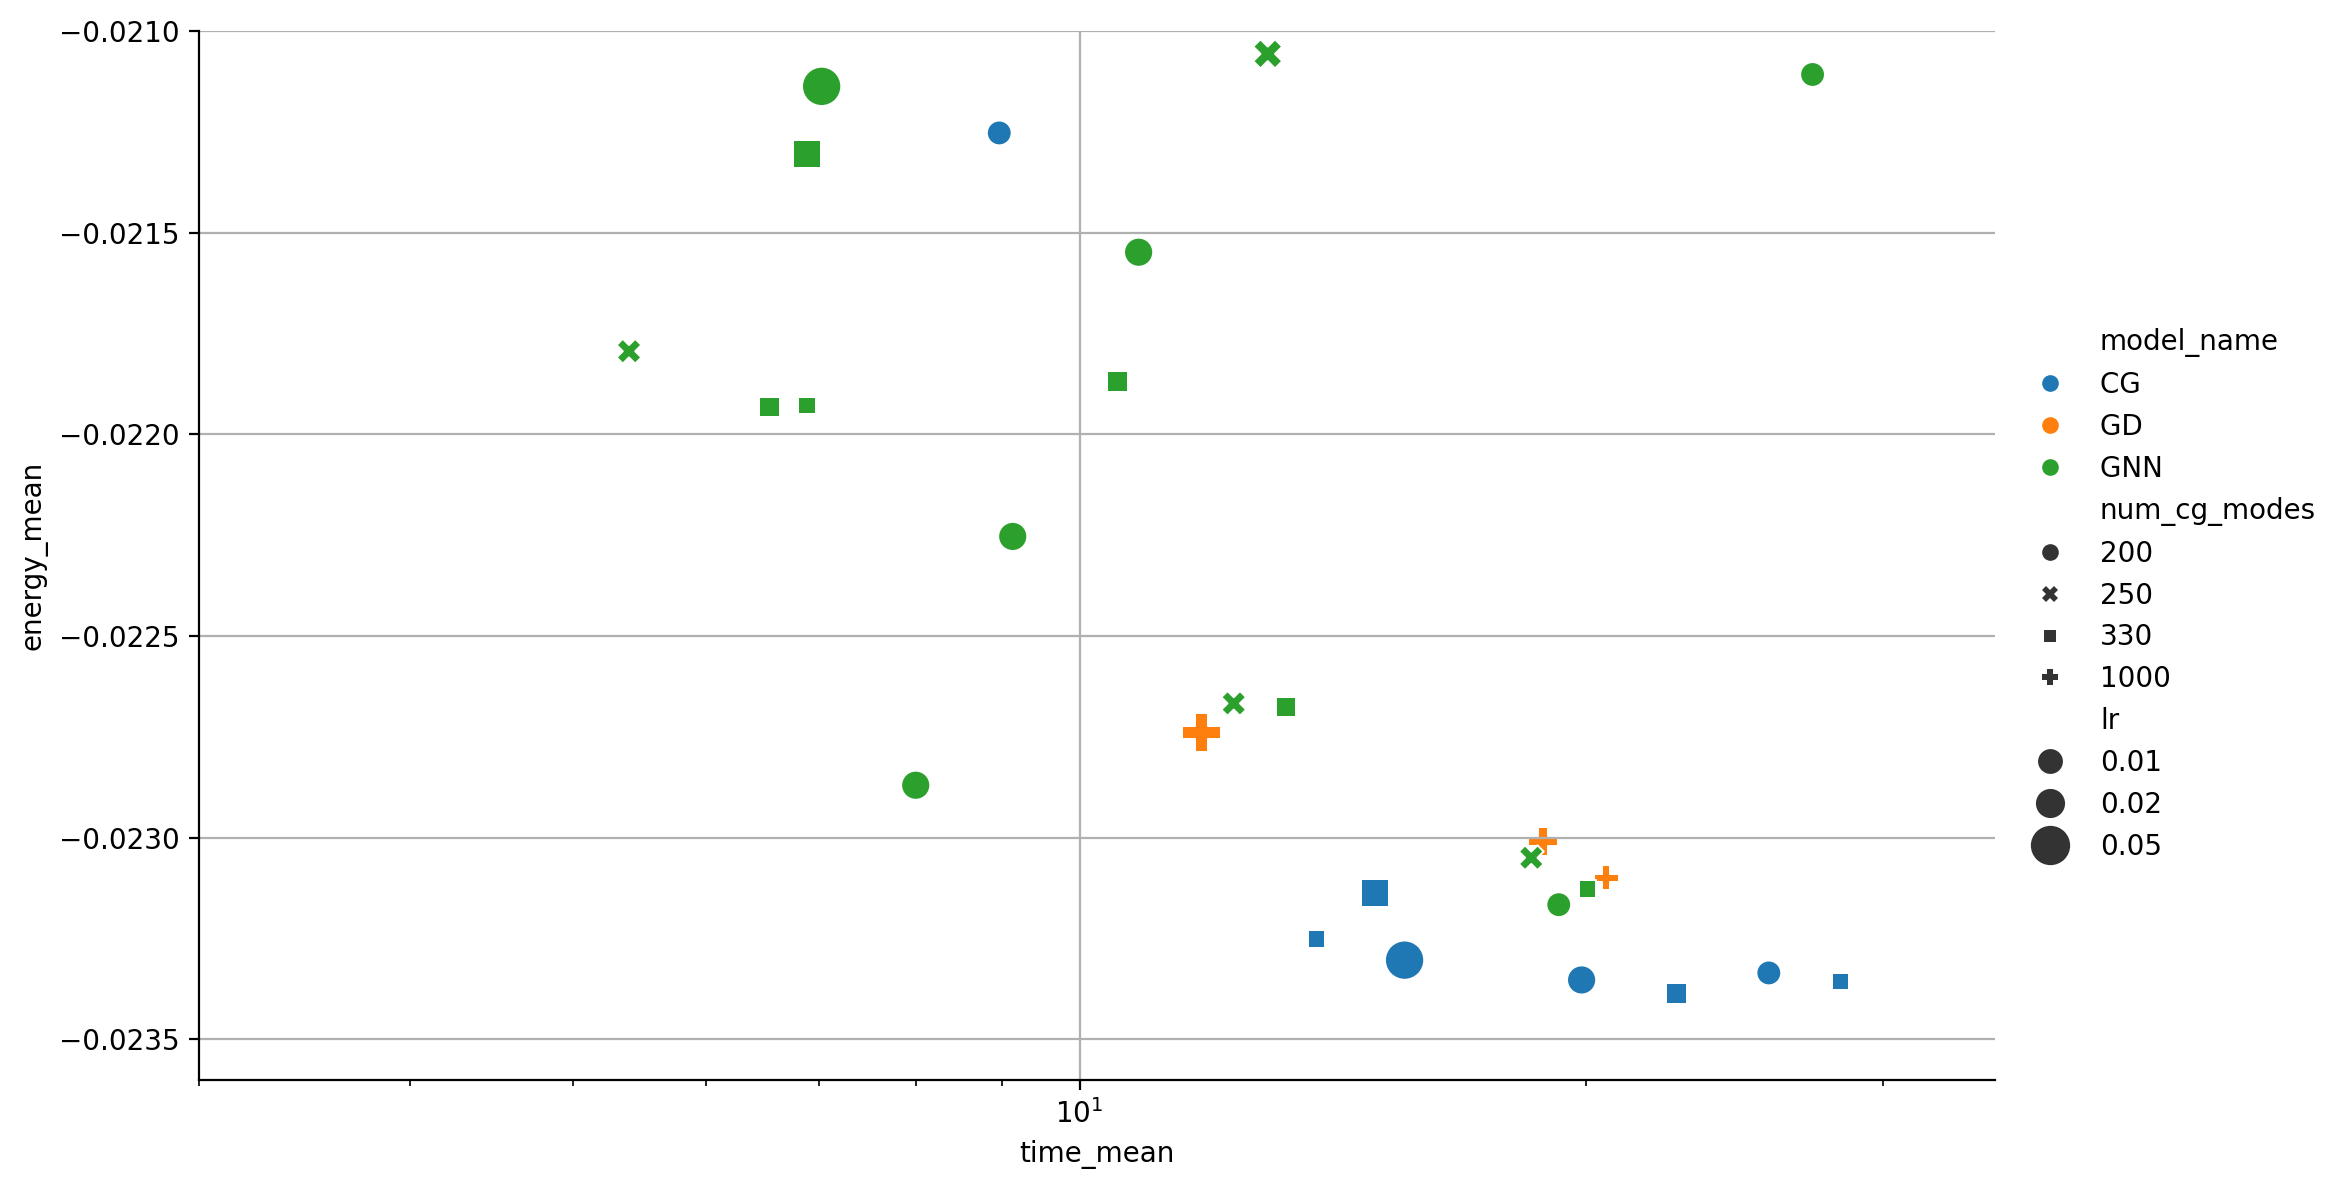

In [176]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', #'min_delta', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0236, -.0210)
plt.xlim(3,35)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

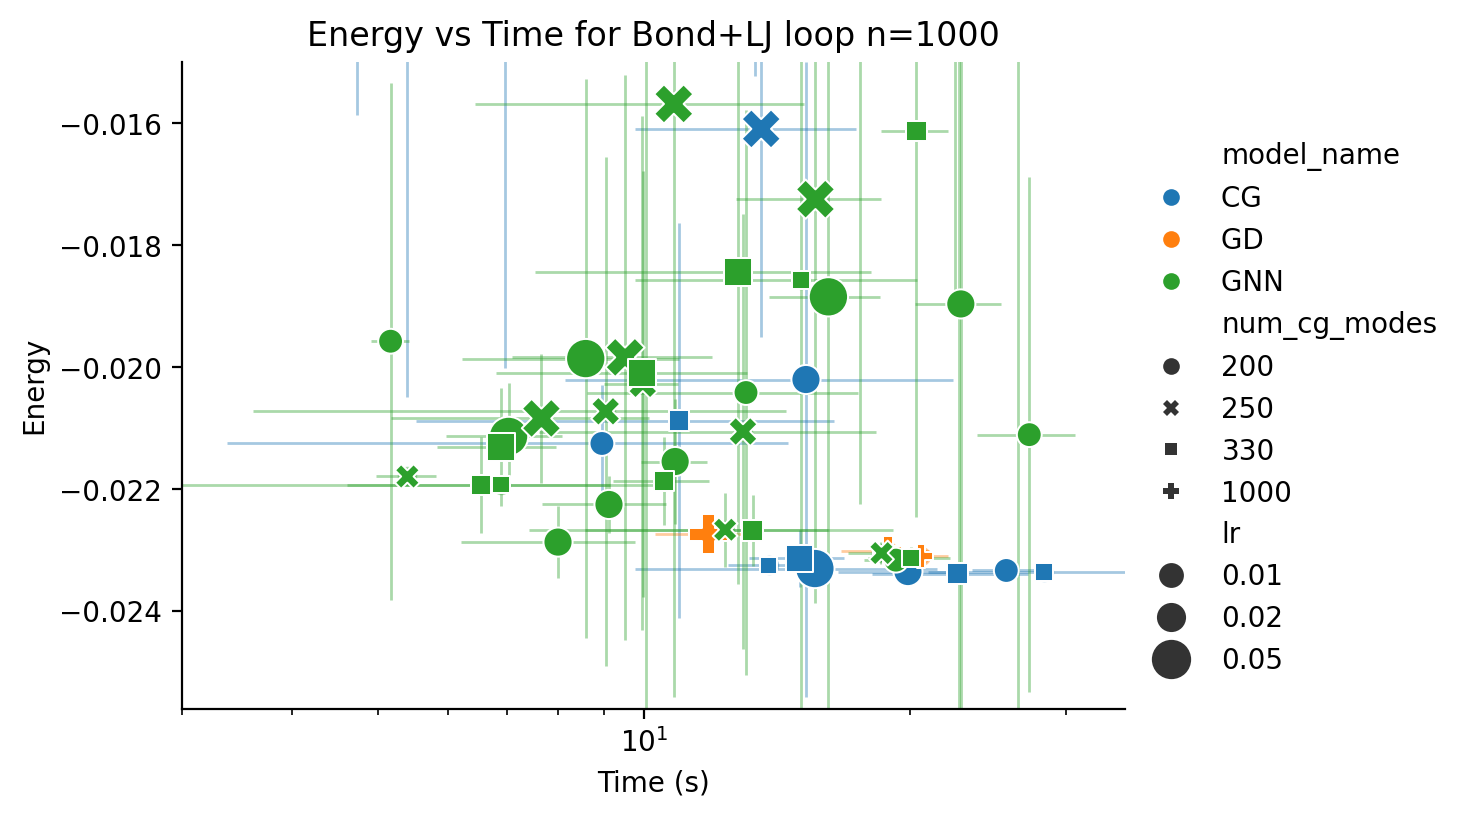

In [183]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=4, aspect=1.5, sizes=(80, 200))
plt.xlabel('Time (s)')
plt.ylabel('Energy')

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)


plt.ylim(-.0256, -.0150)
plt.xlim(3,35)
plt.xscale('log')
# plt.yscale('symlog')
# plt.grid()
num_nodes = df['num_nodes'][0]
plt.title(f'Energy vs Time for Bond+LJ loop n={num_nodes}')
plt.savefig(f'./figs/energy_vs_time_BondLJ_loop_n{num_nodes}.png', dpi=300, bbox_inches='tight')
# also save pdf for publication
plt.savefig(f'./figs/energy_vs_time_BondLJ_loop_n{num_nodes}.pdf', dpi=300, bbox_inches='tight')

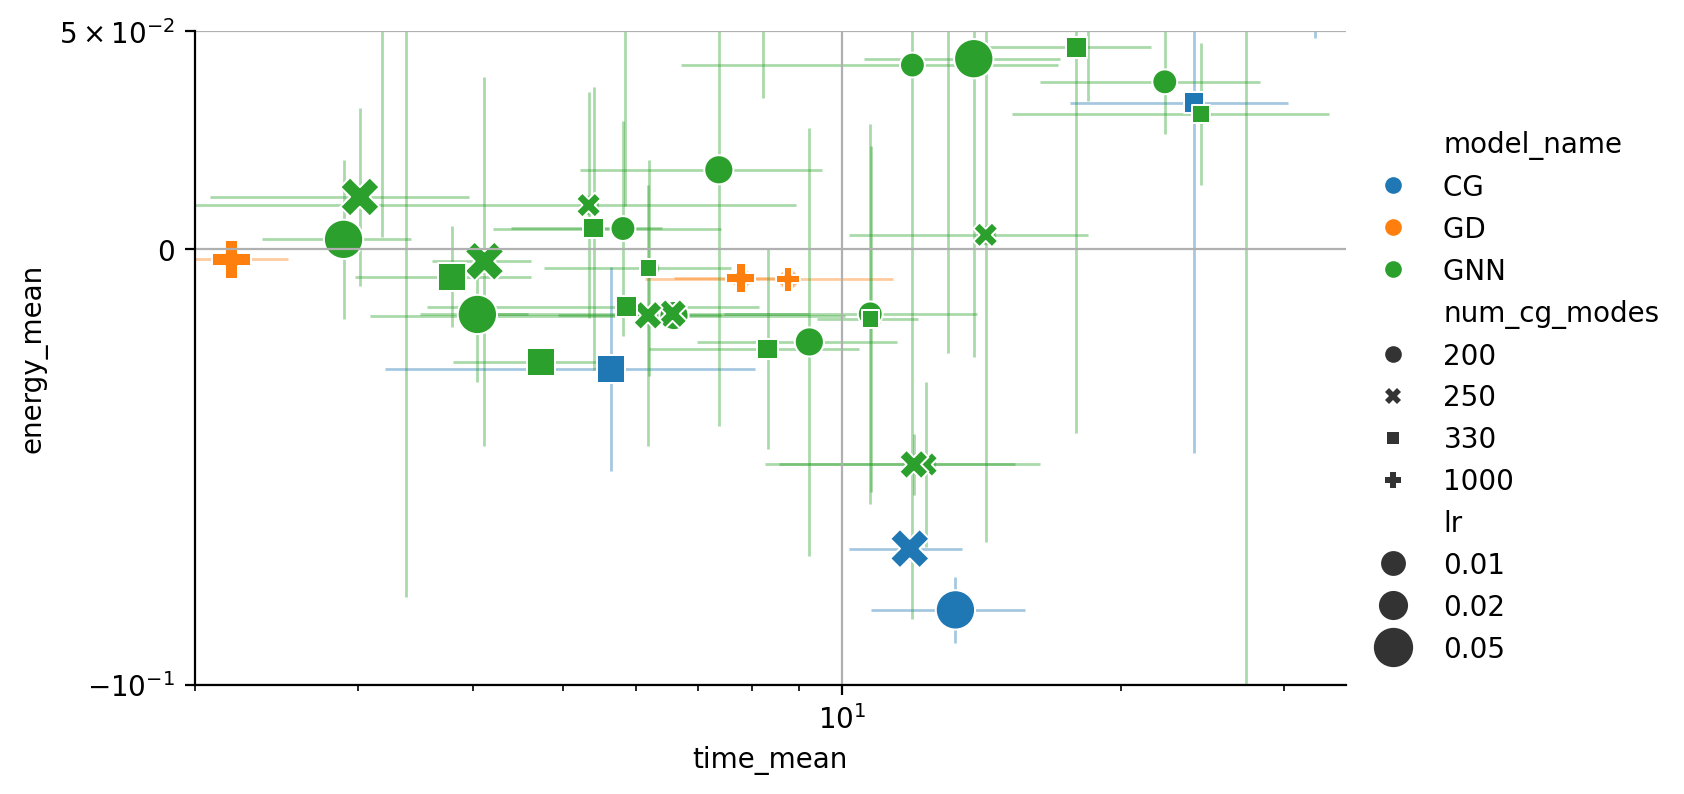

In [ ]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=4, aspect=1.7, sizes=(80, 200))
plt.xlabel('Time (s)')
plt.ylabel('Energy')

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)



plt.ylim(-.028, .02)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()
num_nodes = df['num_nodes'][0]
plt.title(f'Energy vs Time for Bond+LJ loop n={num_nodes}')

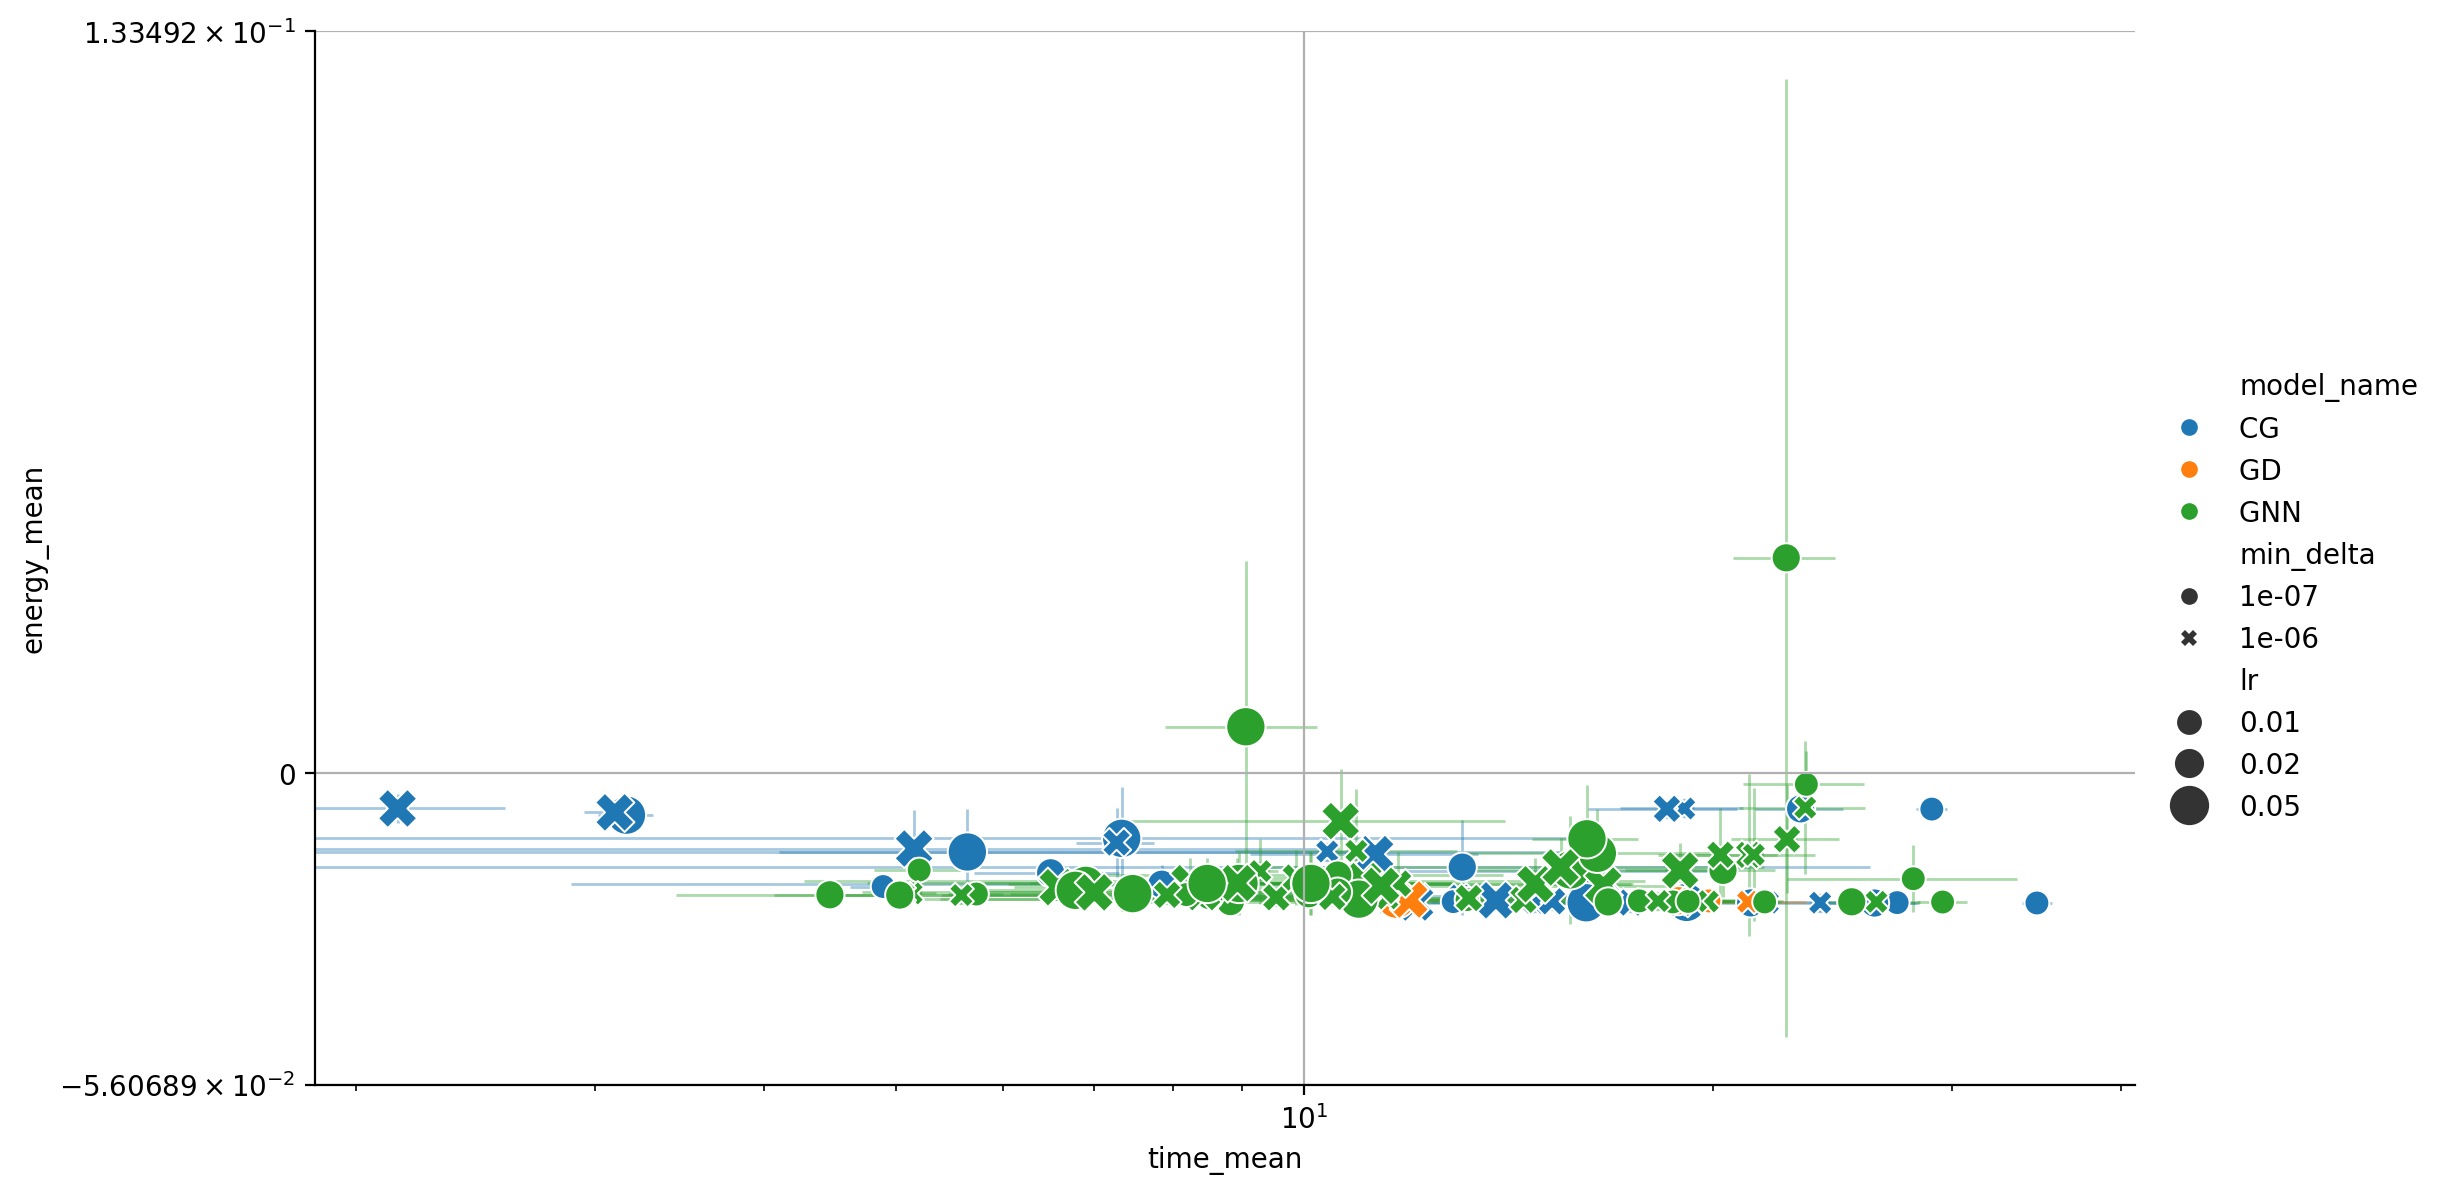

In [99]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

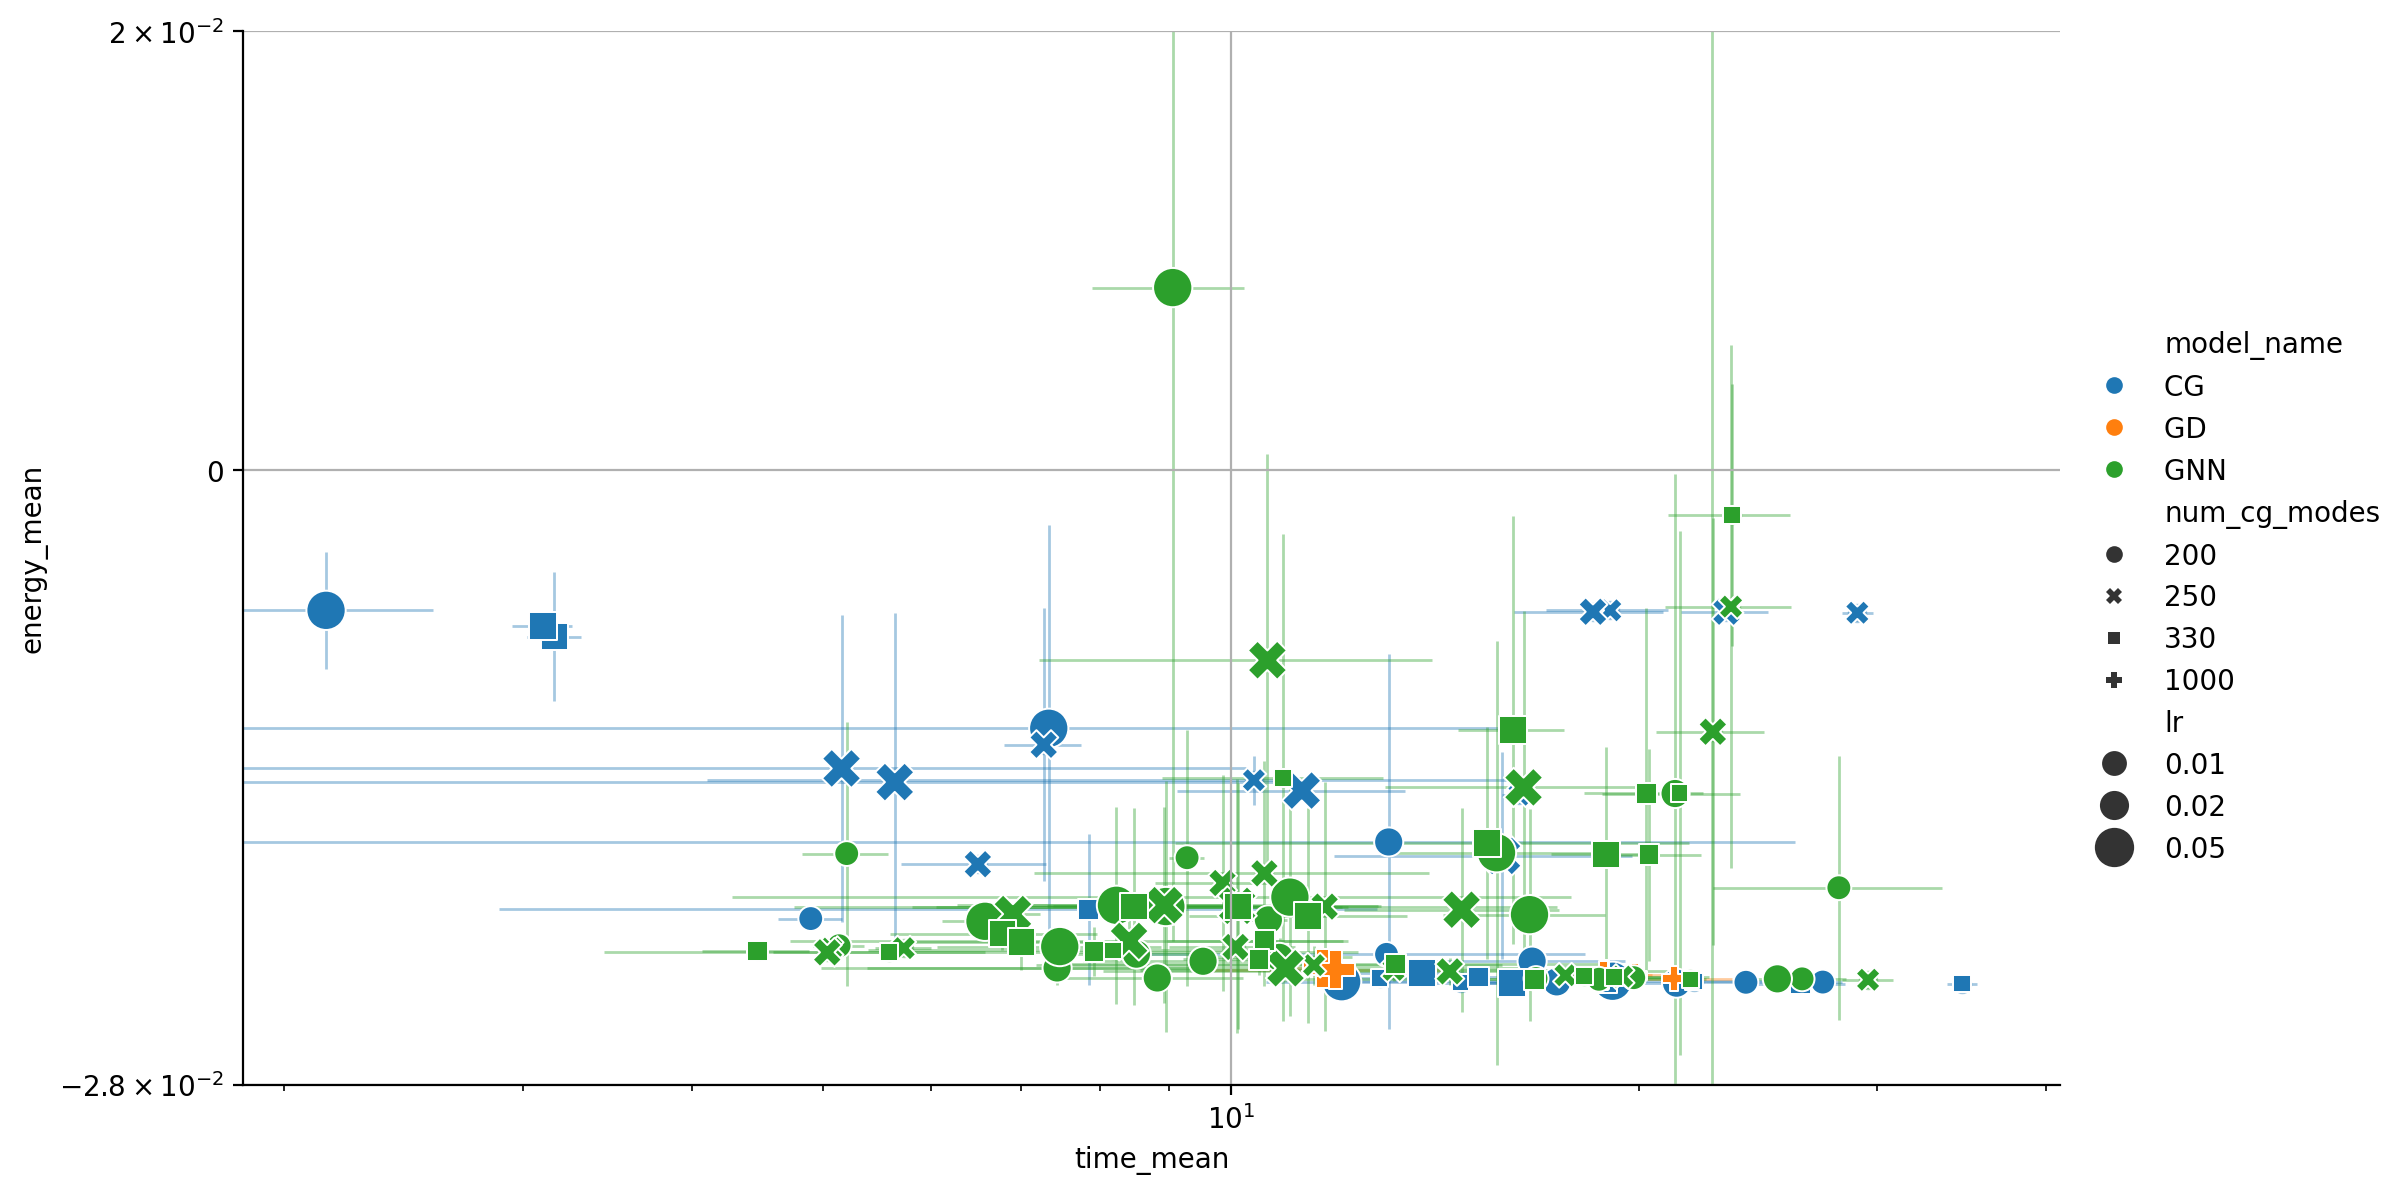

In [100]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

plt.ylim(-.028, .02)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

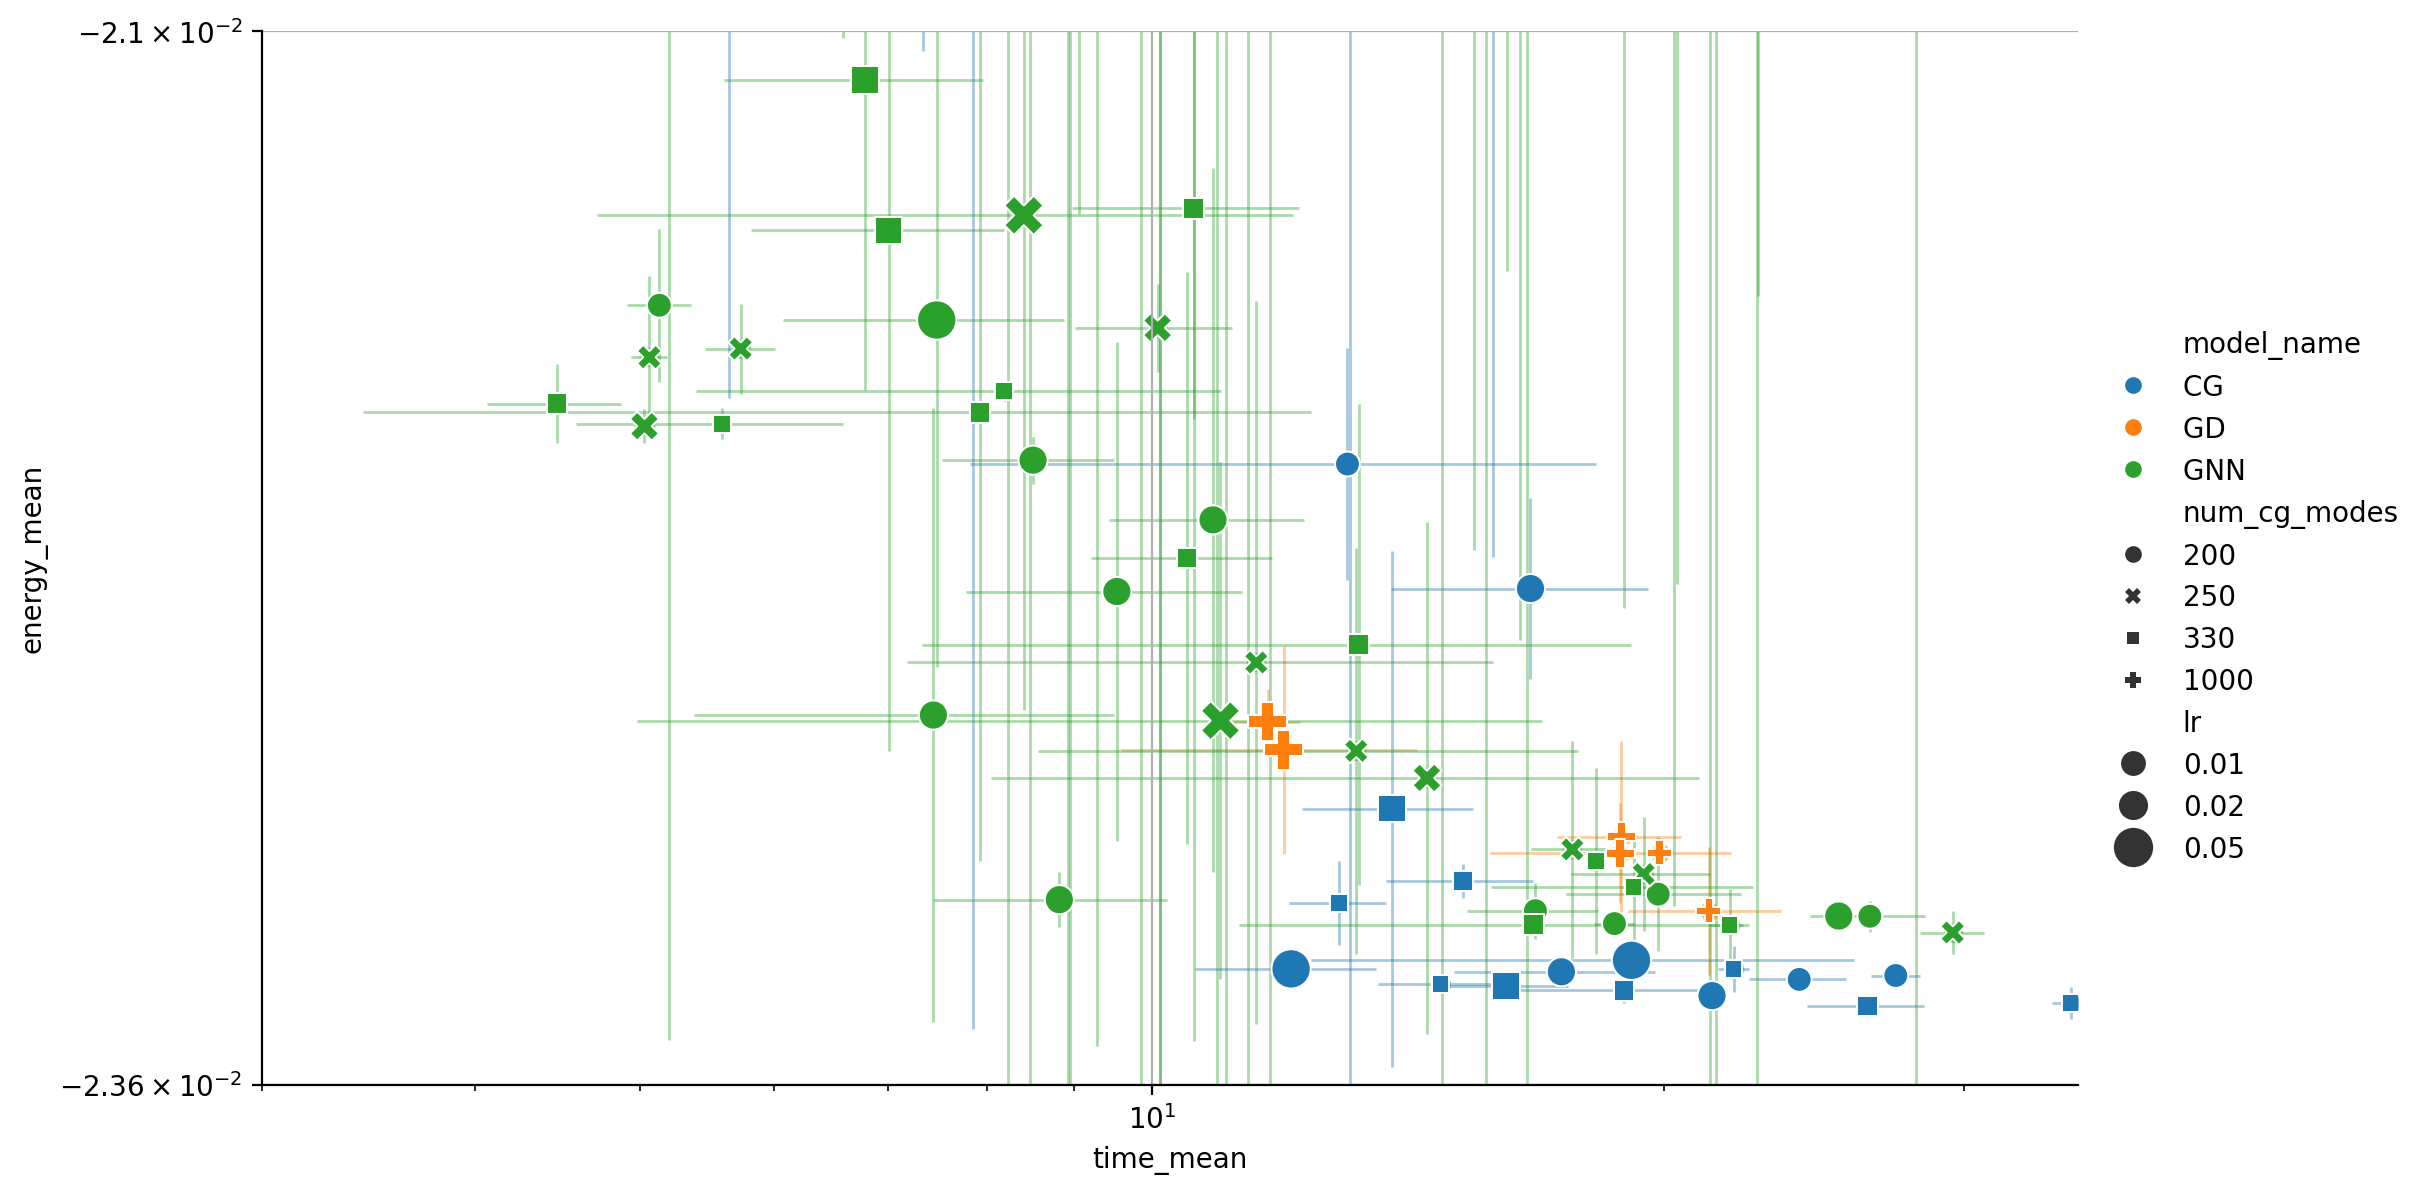

In [101]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)


plt.ylim(-.0236, -.0210)
plt.xlim(3,35)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

# Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph with quadratic bonds, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [140]:
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_Bond_LJ_experiments_2024-02-10-17.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
df = exp_logger.to_dataframe()
df

energy_function               model_name    energy       time    lr  \
0    Energy_Bond_LJ       GD_Bond_LJ_n400_d3 -0.022754   8.543608  0.05   
1    Energy_Bond_LJ   CG_Bond_LJ0.33_n400_d3 -0.023195  11.070001  0.05   
2    Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023063  14.817611  0.05   
3    Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023160  12.972471  0.05   
4    Energy_Bond_LJ   CG_Bond_LJ0.25_n400_d3 -0.022552  11.890551  0.05   
..              ...                      ...       ...        ...   ...   
218  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.023180  18.245872  0.01   
219  Energy_Bond_LJ   CG_Bond_LJ0.33_n400_d3 -0.023054  12.030343  0.01   
220  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.021670   8.803119  0.01   
221  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.021730   5.332700  0.01   
222  Energy_Bond_LJ   CG_Bond_LJ0.25_n400_d3 -0.023287  17.136928  0.01   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  1.836791        400    NaN   
1            0.1        20  1.000000e-06  1.836791        400  0.050   
2            0.1        20  1.000000e-06  1.836791        400  0.005   
3            0.1        20  1.000000e-06  1.836791        400  0.005   
4            0.1        20  1.000000e-06  1.836791        400  0.050   
..           ...       ...           ...       ...        ...    ...   
218          0.1        20  1.000000e-07  1.836791        400  0.001   
219          0.1        20  1.000000e-07  1.836791        400  0.100   
220          0.1        20  1.000000e-07  1.836791        400  0.010   
221          0.1        20  1.000000e-07  1.836791        400  0.010   
222          0.1        20  1.000000e-07  1.836791        400  0.100   

     cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  \
0            NaN           NaN       NaN        NaN        NaN           NaN   
1           20.0      0.000010     405.0   8.181297  -0.022475           NaN   
2           20.0      0.000010     466.0  11.557696  -0.022810         133.0   
3           20.0      0.000010     269.0   6.974455  -0.022601         133.0   
4           20.0      0.000010     422.0   8.777099  -0.020056           NaN   
..           ...           ...       ...        ...        ...           ...   
218         20.0      0.000001     619.0  15.152352  -0.023123          80.0   
219         20.0      0.000001     158.0   3.501764  -0.016735           NaN   
220         20.0      0.000001     349.0   8.448489  -0.017432         133.0   
221         20.0      0.000001     189.0   4.980847  -0.017956         133.0   
222         20.0      0.000001     264.0   5.757189  -0.018749           NaN   

     hidden_dims  
0            NaN  
1            NaN  
2      [8, 4, 3]  
3    [32, 16, 3]  
4            NaN  
..           ...  
218  [32, 16, 3]  
219          NaN  
220    [8, 4, 3]  
221  [32, 16, 3]  
222          NaN  

[223 rows x 18 columns]

In [141]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']
# ensure that the num_cg_modes is an integer
df['num_cg_modes'] = df['num_cg_modes'].astype(int)
df[:10]

energy_function               model_name    energy       time    lr  \
0  Energy_Bond_LJ       GD_Bond_LJ_n400_d3 -0.022754   8.543608  0.05   
1  Energy_Bond_LJ   CG_Bond_LJ0.33_n400_d3 -0.023195  11.070001  0.05   
2  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023063  14.817611  0.05   
3  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023160  12.972471  0.05   
4  Energy_Bond_LJ   CG_Bond_LJ0.25_n400_d3 -0.022552  11.890551  0.05   
5  Energy_Bond_LJ  GNN_Bond_LJ0.25_n400_d3 -0.023146  21.659890  0.05   
6  Energy_Bond_LJ  GNN_Bond_LJ0.25_n400_d3 -0.019123   7.026602  0.05   
7  Energy_Bond_LJ   CG_Bond_LJ0.20_n400_d3  0.019693  11.531193  0.05   
8  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3  0.019770  17.694227  0.05   
9  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.021371   5.907160  0.05   

   clamp_grads  patience  min_delta    x0_std  num_nodes  lr_cg  cg_patience  \
0          0.1        20   0.000001  1.836791        400    NaN          NaN   
1          0.1        20   0.000001  1.836791        400  0.050         20.0   
2          0.1        20   0.000001  1.836791        400  0.005         20.0   
3          0.1        20   0.000001  1.836791        400  0.005         20.0   
4          0.1        20   0.000001  1.836791        400  0.050         20.0   
5          0.1        20   0.000001  1.836791        400  0.005         20.0   
6          0.1        20   0.000001  1.836791        400  0.005         20.0   
7          0.1        20   0.000001  1.836791        400  0.050         20.0   
8          0.1        20   0.000001  1.836791        400  0.005         20.0   
9          0.1        20   0.000001  1.836791        400  0.005         20.0   

   cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  hidden_dims  \
0           NaN       NaN        NaN        NaN         400.0          NaN   
1       0.00001     405.0   8.181297  -0.022475         132.0          NaN   
2       0.00001     466.0  11.557696  -0.022810         132.0    [8, 4, 3]   
3       0.00001     269.0   6.974455  -0.022601         132.0  [32, 16, 3]   
4       0.00001     422.0   8.777099  -0.020056         100.0          NaN   
5       0.00001     620.0  15.475063  -0.022653         100.0    [8, 4, 3]   
6       0.00001     256.0   6.655472  -0.011929         100.0  [32, 16, 3]   
7       0.00001     429.0   8.934613   0.023910          80.0          NaN   
8       0.00001     616.0  14.709538   0.019986          80.0    [8, 4, 3]   
9       0.00001     220.0   5.556619  -0.015677          80.0  [32, 16, 3]   

   cg_ratio  
0      1.00  
1      0.33  
2      0.33  
3      0.33  
4      0.25  
5      0.25  
6      0.25  
7      0.20  
8      0.20  
9      0.20

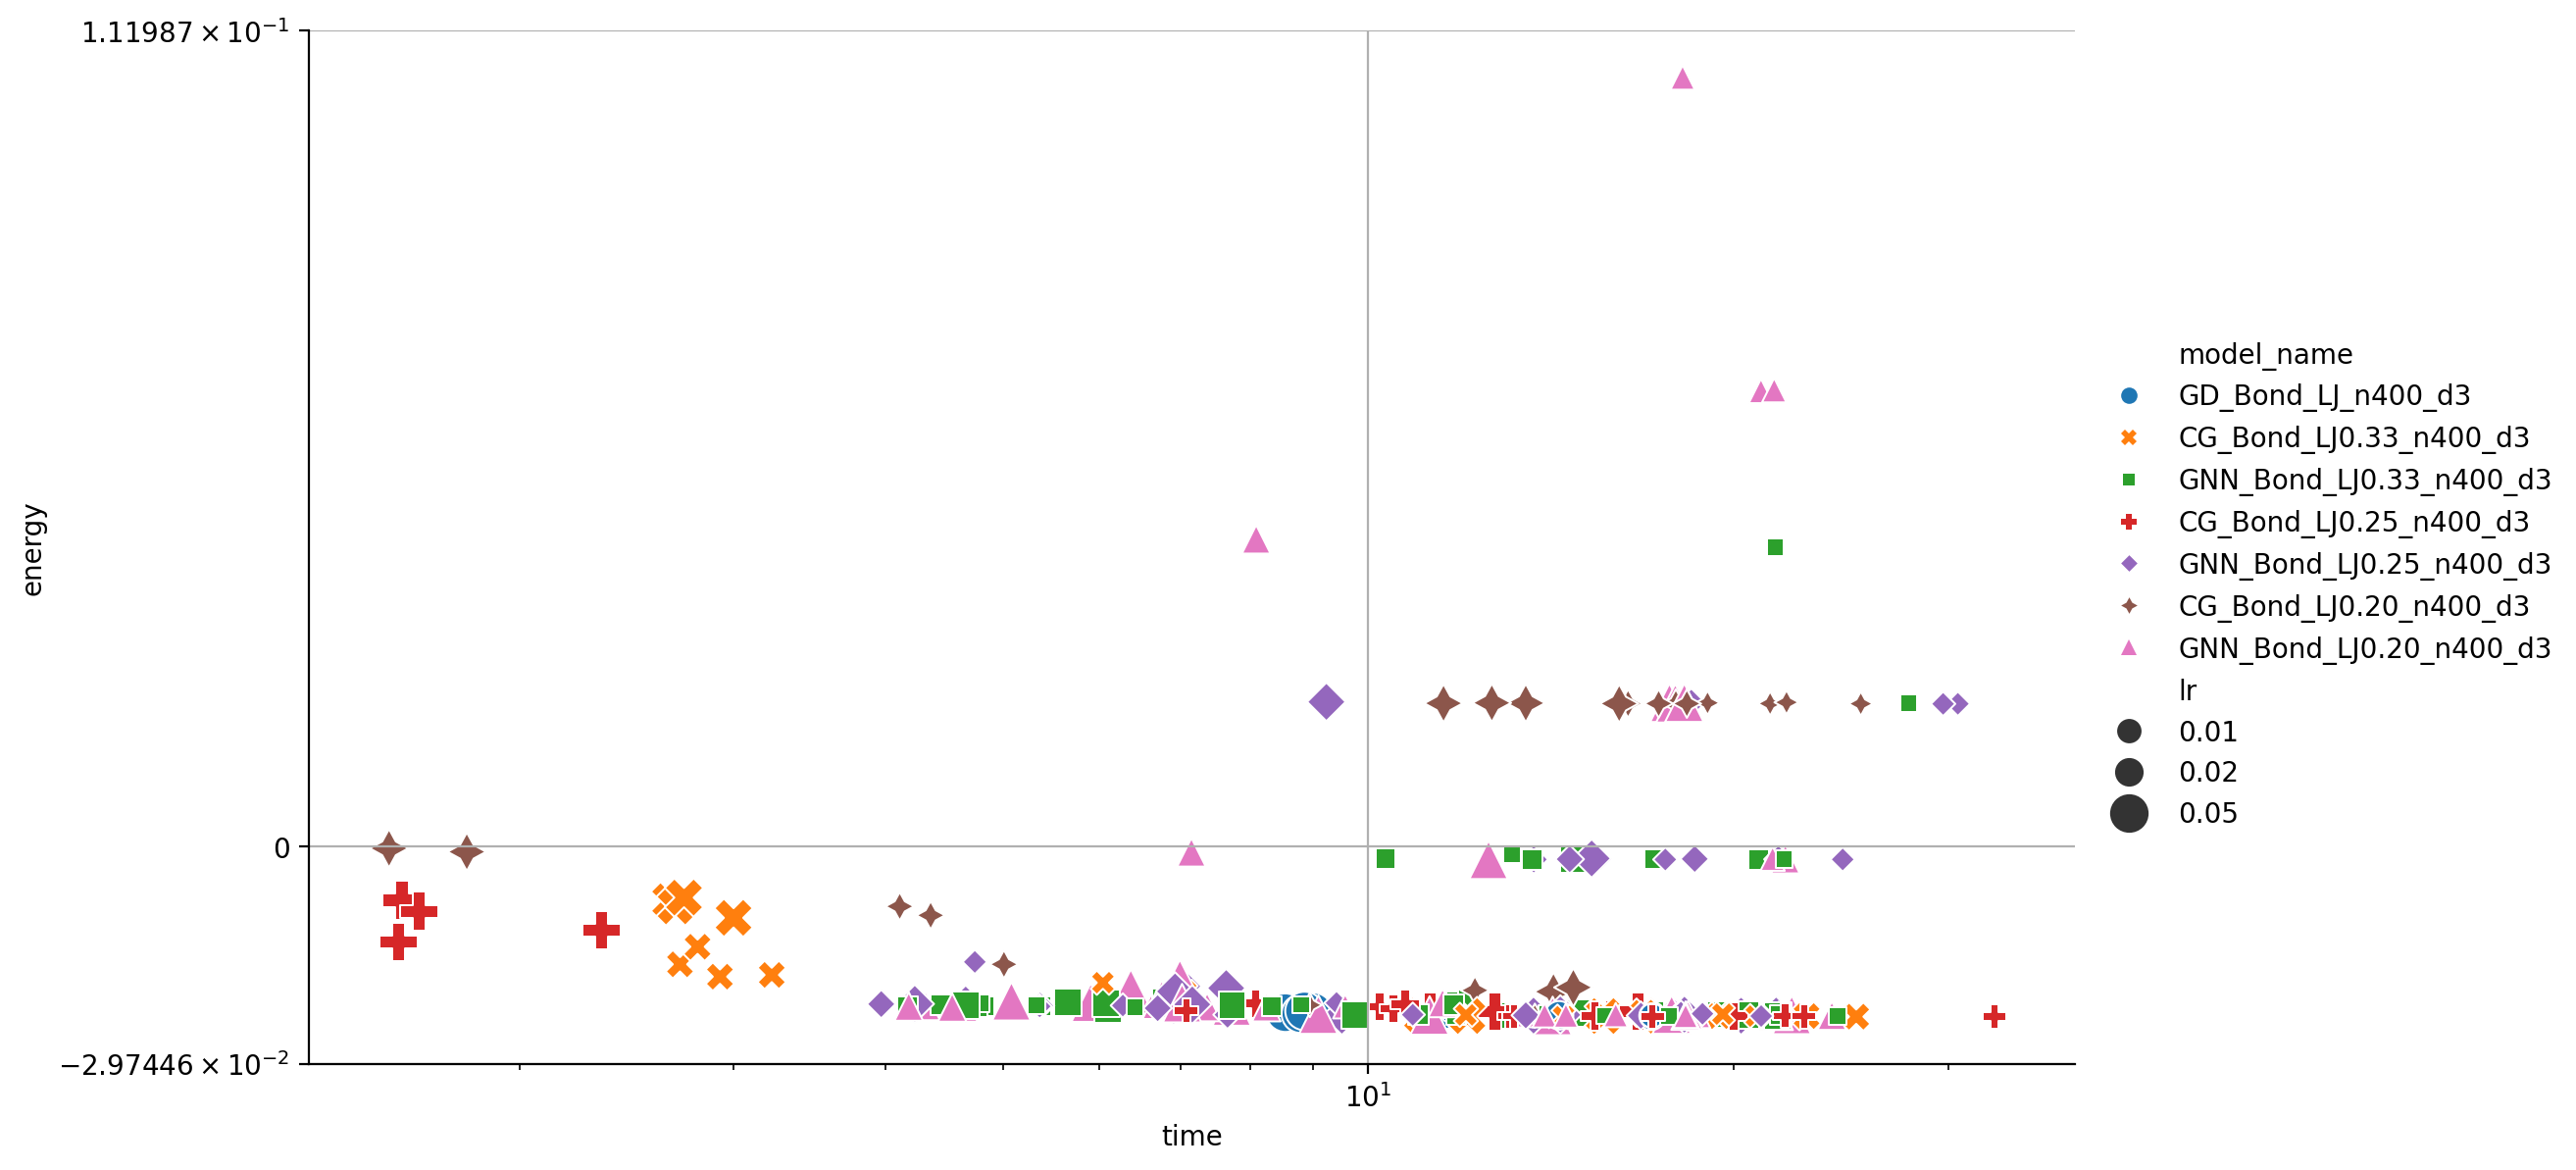

In [142]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.0234, -.0228)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

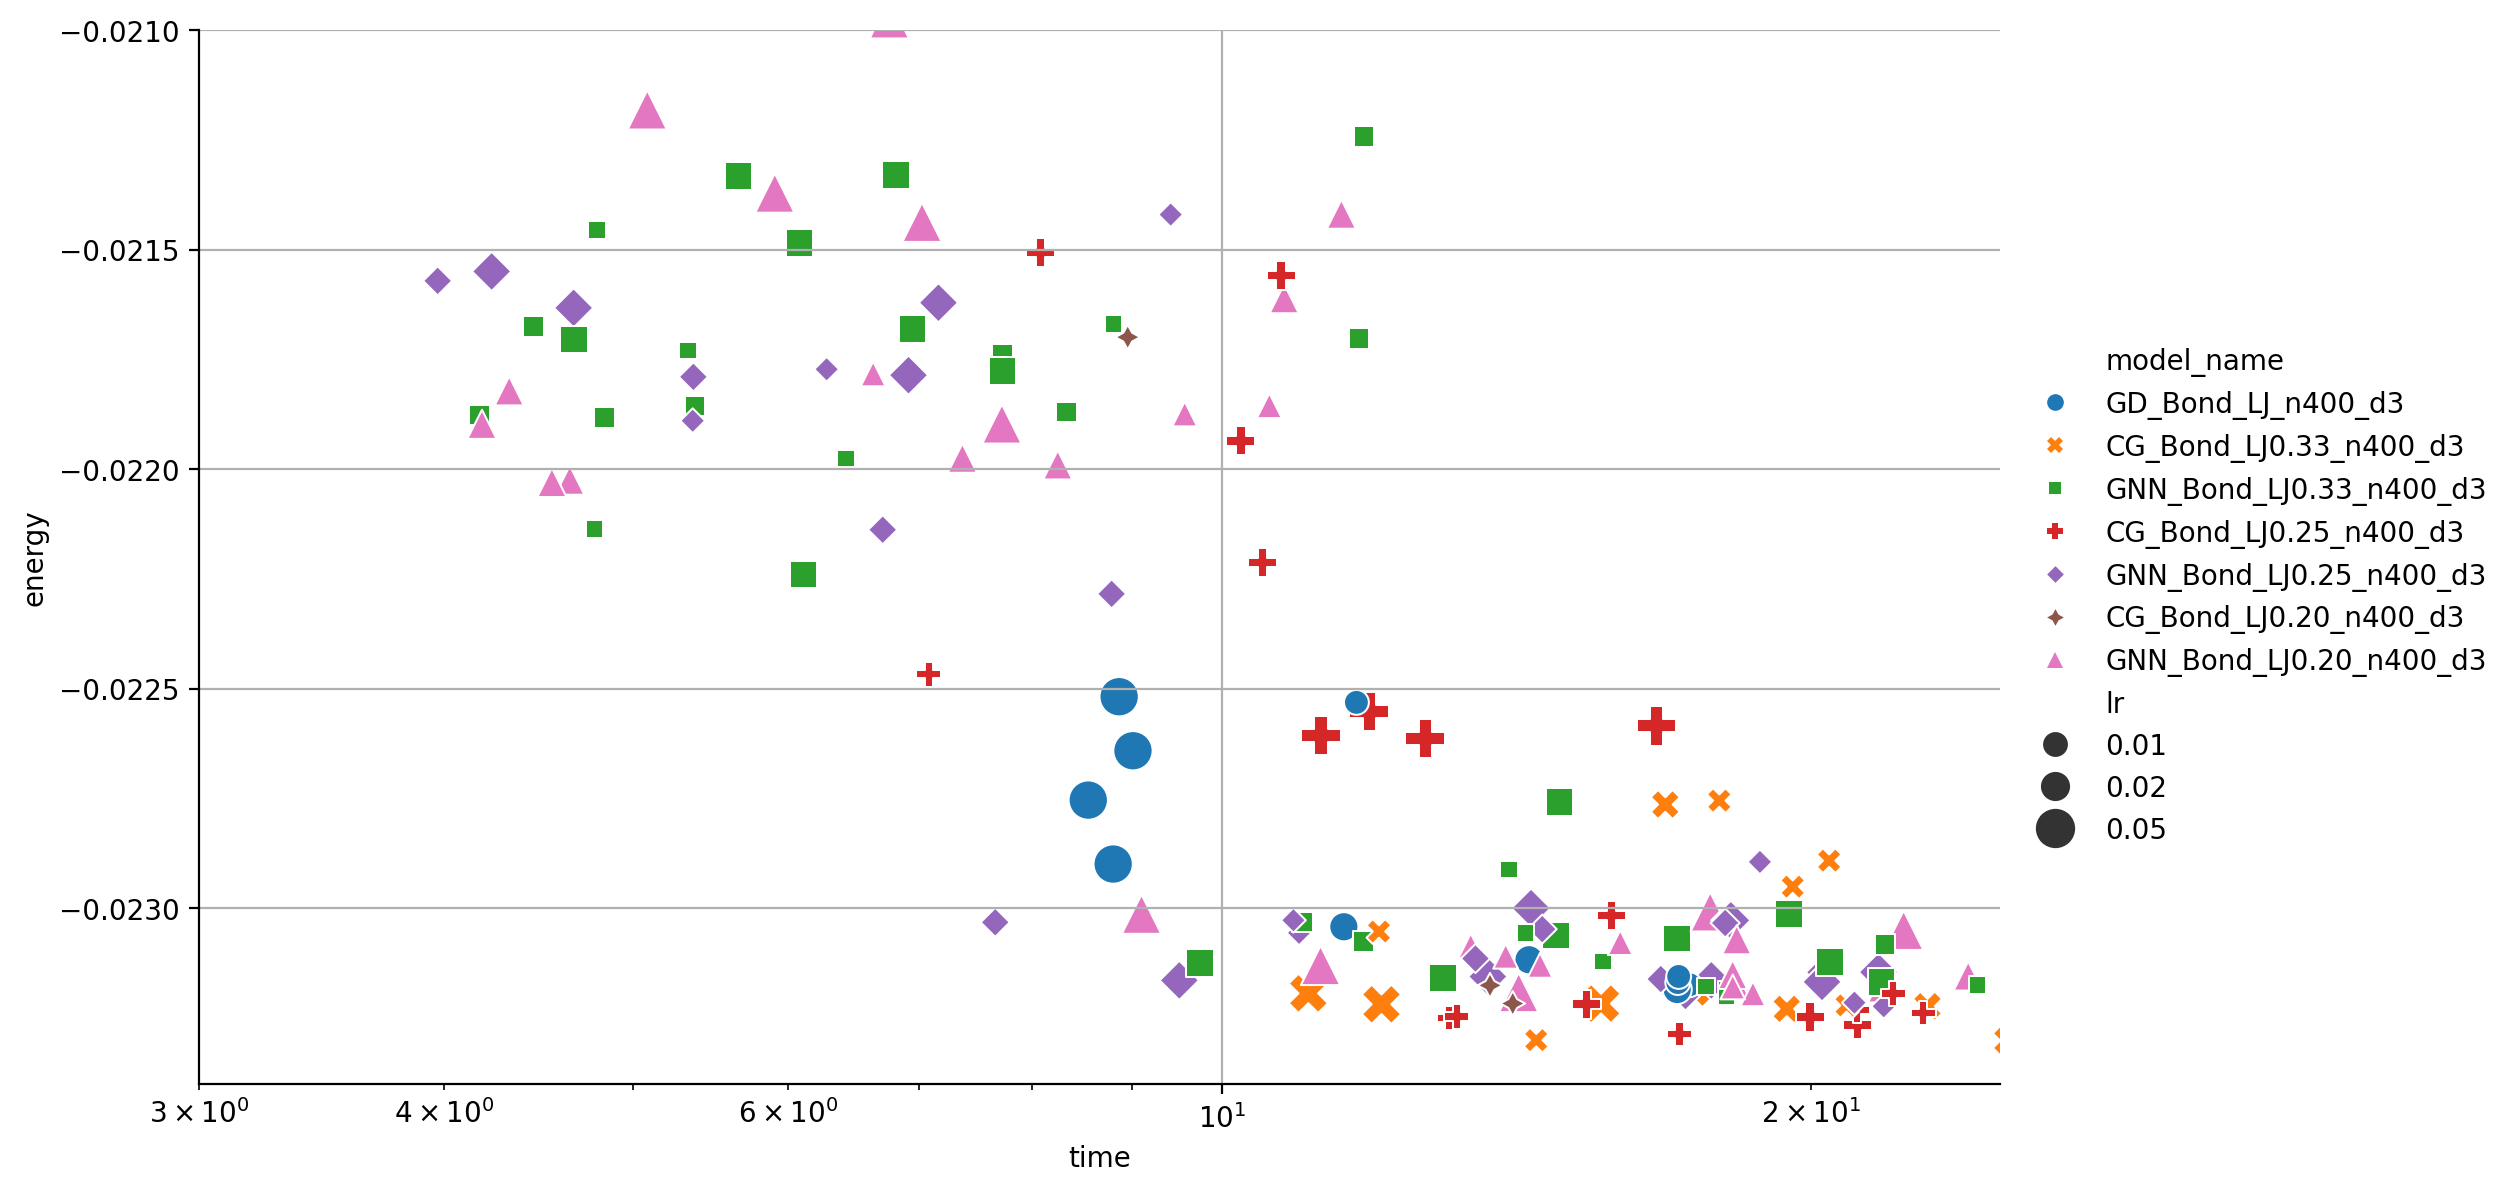

In [143]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.0210)
plt.xlim(3,25)
plt.xscale('log')
plt.grid()

## Grouping similar runs

In [144]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'min_delta', 'num_cg_modes', 'lr_cg', 'hidden_dims'])
# other options: cg_patience,cg_min_delta
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1651258/3992581159.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1651258/3992581159.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr     min_delta num_cg_modes  lr_cg  \
                                                                       
0     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07         80.0  0.010   
1     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07         80.0  0.100   
2     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06         80.0  0.010   
3     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06         80.0  0.100   
4     CG_Bond_LJ0.20_n400_d3  0.02  1.000000e-07         80.0  0.020   
..                       ...   ...           ...          ...    ...   
109  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-07        132.0  0.050   
110  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
111  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
112  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   
113  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   

     hidden_dims    energy                 time            
                      mean       std       mean       std  
0            NaN  0.019737  0.000118  21.753684  0.479054  
1            NaN -0.023218       NaN  14.081982       NaN  
2            NaN  0.019688  0.000084  22.225205  4.532486  
3            NaN -0.022438  0.001044  11.329975  3.366210  
4            NaN  0.019649  0.000007  18.099378  0.267388  
..           ...       ...       ...        ...       ...  
109    [8, 4, 3] -0.023091  0.000109  20.618664  1.584142  
110  [32, 16, 3] -0.022245  0.001294   9.892986  4.355049  
111    [8, 4, 3] -0.023066  0.000005  15.950243  1.601783  
112  [32, 16, 3] -0.022229  0.001267   7.703062  2.890561  
113    [8, 4, 3] -0.011759  0.014166  11.234873  4.967021  

[114 rows x 10 columns]

In [145]:
df_copy

energy_function               model_name    energy       time    lr  \
0    Energy_Bond_LJ       GD_Bond_LJ_n400_d3 -0.022754   8.543608  0.05   
1    Energy_Bond_LJ   CG_Bond_LJ0.33_n400_d3 -0.023195  11.070001  0.05   
2    Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023063  14.817611  0.05   
3    Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.023160  12.972471  0.05   
4    Energy_Bond_LJ   CG_Bond_LJ0.25_n400_d3 -0.022552  11.890551  0.05   
..              ...                      ...       ...        ...   ...   
218  Energy_Bond_LJ  GNN_Bond_LJ0.20_n400_d3 -0.023180  18.245872  0.01   
219  Energy_Bond_LJ   CG_Bond_LJ0.33_n400_d3 -0.023054  12.030343  0.01   
220  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.021670   8.803119  0.01   
221  Energy_Bond_LJ  GNN_Bond_LJ0.33_n400_d3 -0.021730   5.332700  0.01   
222  Energy_Bond_LJ   CG_Bond_LJ0.25_n400_d3 -0.023287  17.136928  0.01   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  1.836791        400     na   
1            0.1        20  1.000000e-06  1.836791        400   0.05   
2            0.1        20  1.000000e-06  1.836791        400  0.005   
3            0.1        20  1.000000e-06  1.836791        400  0.005   
4            0.1        20  1.000000e-06  1.836791        400   0.05   
..           ...       ...           ...       ...        ...    ...   
218          0.1        20  1.000000e-07  1.836791        400  0.001   
219          0.1        20  1.000000e-07  1.836791        400    0.1   
220          0.1        20  1.000000e-07  1.836791        400   0.01   
221          0.1        20  1.000000e-07  1.836791        400   0.01   
222          0.1        20  1.000000e-07  1.836791        400    0.1   

    cg_patience cg_min_delta cg_steps    cg_time cg_energy  num_cg_modes  \
0            na           na       na         na        na         400.0   
1          20.0      0.00001    405.0   8.181297 -0.022475         132.0   
2          20.0      0.00001    466.0  11.557696  -0.02281         132.0   
3          20.0      0.00001    269.0   6.974455 -0.022601         132.0   
4          20.0      0.00001    422.0   8.777099 -0.020056         100.0   
..          ...          ...      ...        ...       ...           ...   
218        20.0     0.000001    619.0  15.152352 -0.023123          80.0   
219        20.0     0.000001    158.0   3.501764 -0.016735         132.0   
220        20.0     0.000001    349.0   8.448489 -0.017432         132.0   
221        20.0     0.000001    189.0   4.980847 -0.017956         132.0   
222        20.0     0.000001    264.0   5.757189 -0.018749         100.0   

     hidden_dims  cg_ratio  
0             na      1.00  
1             na      0.33  
2      [8, 4, 3]      0.33  
3    [32, 16, 3]      0.33  
4             na      0.25  
..           ...       ...  
218  [32, 16, 3]      0.20  
219           na      0.33  
220    [8, 4, 3]      0.33  
221  [32, 16, 3]      0.33  
222           na      0.25  

[223 rows x 19 columns]

In [146]:
# get rows where  model_name starts with 'GD_'
df_gd = df_copy[df_copy['model_name'].str.startswith('GD_')]
df_gd


energy_function          model_name    energy       time    lr  \
0    Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.022754   8.543608  0.05   
19   Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.022642   9.005259  0.05   
38   Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023177  17.000027  0.02   
57   Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023043  11.542883  0.02   
76   Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.022532  11.715016  0.01   
95   Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023175  17.339687  0.01   
114  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.022900   8.797736  0.05   
133  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.022519   8.859826  0.05   
152  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023186  17.089710  0.02   
171  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023118  14.354212  0.02   
190  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023170  17.101470  0.01   
209  Energy_Bond_LJ  GD_Bond_LJ_n400_d3 -0.023156  17.119876  0.01   

     clamp_grads  patience     min_delta    x0_std  num_nodes lr_cg  \
0            0.1        20  1.000000e-06  1.836791        400    na   
19           0.1        20  1.000000e-07  1.836791        400    na   
38           0.1        20  1.000000e-06  1.836791        400    na   
57           0.1        20  1.000000e-07  1.836791        400    na   
76           0.1        20  1.000000e-06  1.836791        400    na   
95           0.1        20  1.000000e-07  1.836791        400    na   
114          0.1        20  1.000000e-06  1.836791        400    na   
133          0.1        20  1.000000e-07  1.836791        400    na   
152          0.1        20  1.000000e-06  1.836791        400    na   
171          0.1        20  1.000000e-07  1.836791        400    na   
190          0.1        20  1.000000e-06  1.836791        400    na   
209          0.1        20  1.000000e-07  1.836791        400    na   

    cg_patience cg_min_delta cg_steps cg_time cg_energy  num_cg_modes  \
0            na           na       na      na        na         400.0   
19           na           na       na      na        na         400.0   
38           na           na       na      na        na         400.0   
57           na           na       na      na        na         400.0   
76           na           na       na      na        na         400.0   
95           na           na       na      na        na         400.0   
114          na           na       na      na        na         400.0   
133          na           na       na      na        na         400.0   
152          na           na       na      na        na         400.0   
171          na           na       na      na        na         400.0   
190          na           na       na      na        na         400.0   
209          na           na       na      na        na         400.0   

    hidden_dims  cg_ratio  
0            na       1.0  
19           na       1.0  
38           na       1.0  
57           na       1.0  
76           na       1.0  
95           na       1.0  
114          na       1.0  
133          na       1.0  
152          na       1.0  
171          na       1.0  
190          na       1.0  
209          na       1.0

In [147]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
# df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered = df_mean #[df_mean['energy']['std'] < std_threshold]

df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

In [148]:
df_filtered

index               model_name    lr     min_delta  num_cg_modes  lr_cg  \
0        0   CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07          80.0  0.010   
1        1   CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07          80.0  0.100   
2        2   CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06          80.0  0.010   
3        3   CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06          80.0  0.100   
4        4   CG_Bond_LJ0.20_n400_d3  0.02  1.000000e-07          80.0  0.020   
..     ...                      ...   ...           ...           ...    ...   
109    109  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-07         132.0  0.050   
110    110  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06         132.0  0.005   
111    111  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06         132.0  0.005   
112    112  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06         132.0  0.050   
113    113  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06         132.0  0.050   

     hidden_dims  energy-mean  energy-std  time-mean  time-std  energy_mean  \
0            NaN     0.019737    0.000118  21.753684  0.479054     0.019737   
1            NaN    -0.023218         NaN  14.081982       NaN    -0.023218   
2            NaN     0.019688    0.000084  22.225205  4.532486     0.019688   
3            NaN    -0.022438    0.001044  11.329975  3.366210    -0.022438   
4            NaN     0.019649    0.000007  18.099378  0.267388     0.019649   
..           ...          ...         ...        ...       ...          ...   
109    [8, 4, 3]    -0.023091    0.000109  20.618664  1.584142    -0.023091   
110  [32, 16, 3]    -0.022245    0.001294   9.892986  4.355049    -0.022245   
111    [8, 4, 3]    -0.023066    0.000005  15.950243  1.601783    -0.023066   
112  [32, 16, 3]    -0.022229    0.001267   7.703062  2.890561    -0.022229   
113    [8, 4, 3]    -0.011759    0.014166  11.234873  4.967021    -0.011759   

     energy_std  time_mean  time_std  
0      0.000118  21.753684  0.479054  
1           NaN  14.081982       NaN  
2      0.000084  22.225205  4.532486  
3      0.001044  11.329975  3.366210  
4      0.000007  18.099378  0.267388  
..          ...        ...       ...  
109    0.000109  20.618664  1.584142  
110    0.001294   9.892986  4.355049  
111    0.000005  15.950243  1.601783  
112    0.001267   7.703062  2.890561  
113    0.014166  11.234873  4.967021  

[114 rows x 15 columns]

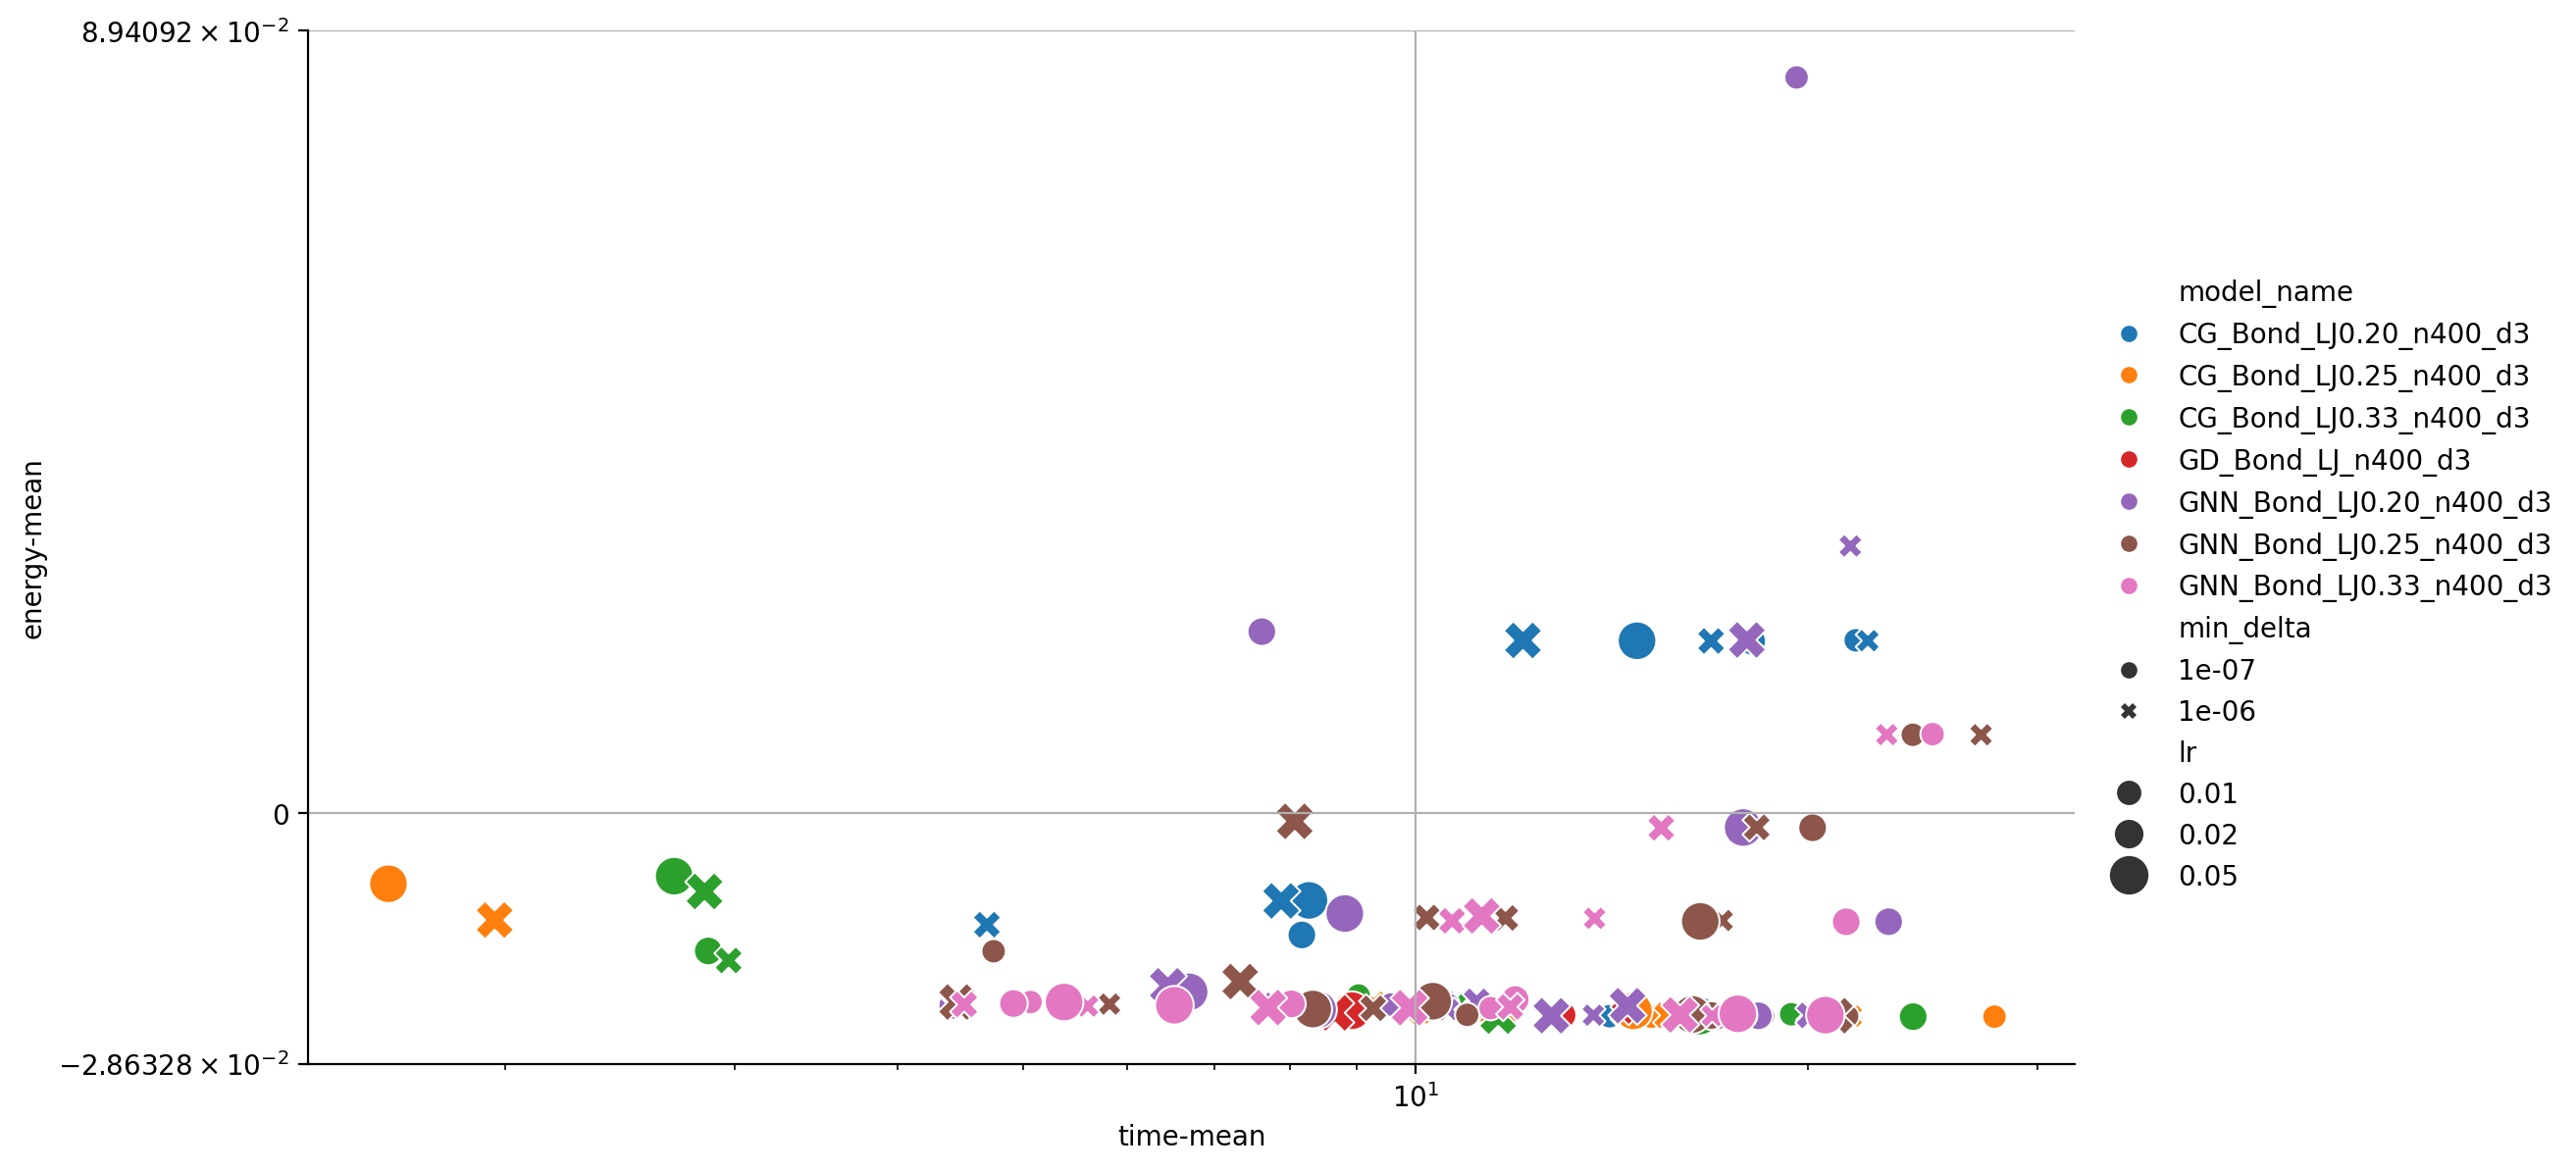

In [149]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

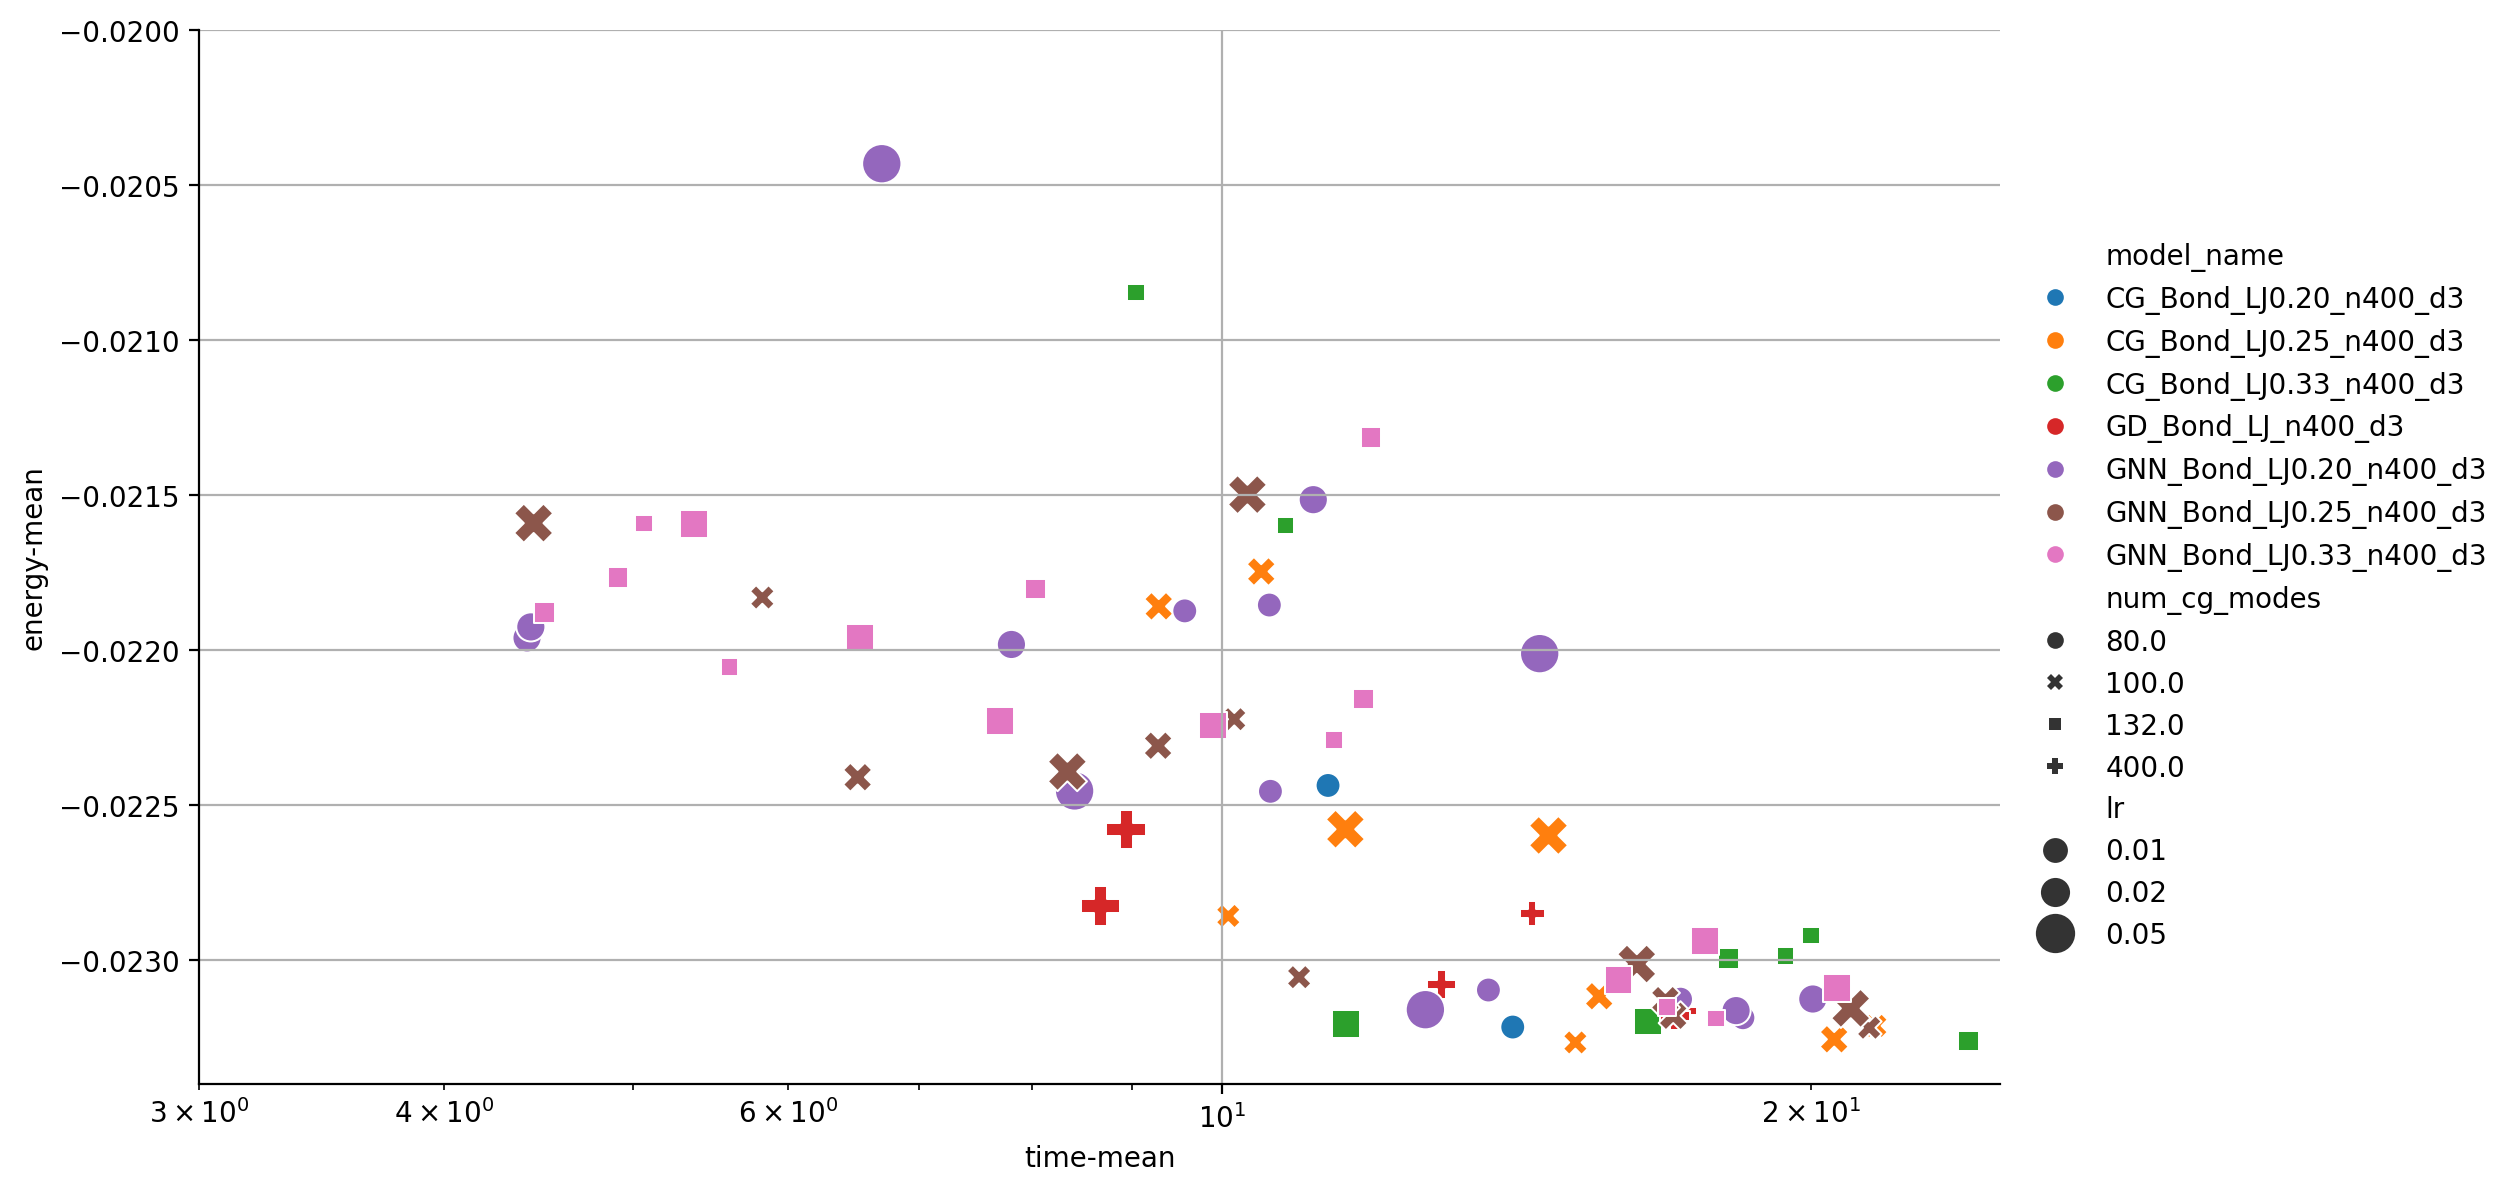

In [150]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.020)
plt.xlim(3,25)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

In [151]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [152]:
df_cleaned

index model_name    lr     min_delta  num_cg_modes  lr_cg  hidden_dims  \
0        0        CG   0.01  1.000000e-07          80.0  0.010          NaN   
1        1        CG   0.01  1.000000e-07          80.0  0.100          NaN   
2        2        CG   0.01  1.000000e-06          80.0  0.010          NaN   
3        3        CG   0.01  1.000000e-06          80.0  0.100          NaN   
4        4        CG   0.02  1.000000e-07          80.0  0.020          NaN   
..     ...        ...   ...           ...           ...    ...          ...   
109    109       GNN   0.05  1.000000e-07         132.0  0.050    [8, 4, 3]   
110    110       GNN   0.05  1.000000e-06         132.0  0.005  [32, 16, 3]   
111    111       GNN   0.05  1.000000e-06         132.0  0.005    [8, 4, 3]   
112    112       GNN   0.05  1.000000e-06         132.0  0.050  [32, 16, 3]   
113    113       GNN   0.05  1.000000e-06         132.0  0.050    [8, 4, 3]   

     energy-mean  energy-std  time-mean  time-std  energy_mean  energy_std  \
0       0.019737    0.000118  21.753684  0.479054     0.019737    0.000118   
1      -0.023218         NaN  14.081982       NaN    -0.023218         NaN   
2       0.019688    0.000084  22.225205  4.532486     0.019688    0.000084   
3      -0.022438    0.001044  11.329975  3.366210    -0.022438    0.001044   
4       0.019649    0.000007  18.099378  0.267388     0.019649    0.000007   
..           ...         ...        ...       ...          ...         ...   
109    -0.023091    0.000109  20.618664  1.584142    -0.023091    0.000109   
110    -0.022245    0.001294   9.892986  4.355049    -0.022245    0.001294   
111    -0.023066    0.000005  15.950243  1.601783    -0.023066    0.000005   
112    -0.022229    0.001267   7.703062  2.890561    -0.022229    0.001267   
113    -0.011759    0.014166  11.234873  4.967021    -0.011759    0.014166   

     time_mean  time_std  
0    21.753684  0.479054  
1    14.081982       NaN  
2    22.225205  4.532486  
3    11.329975  3.366210  
4    18.099378  0.267388  
..         ...       ...  
109  20.618664  1.584142  
110   9.892986  4.355049  
111  15.950243  1.601783  
112   7.703062  2.890561  
113  11.234873  4.967021  

[114 rows x 15 columns]

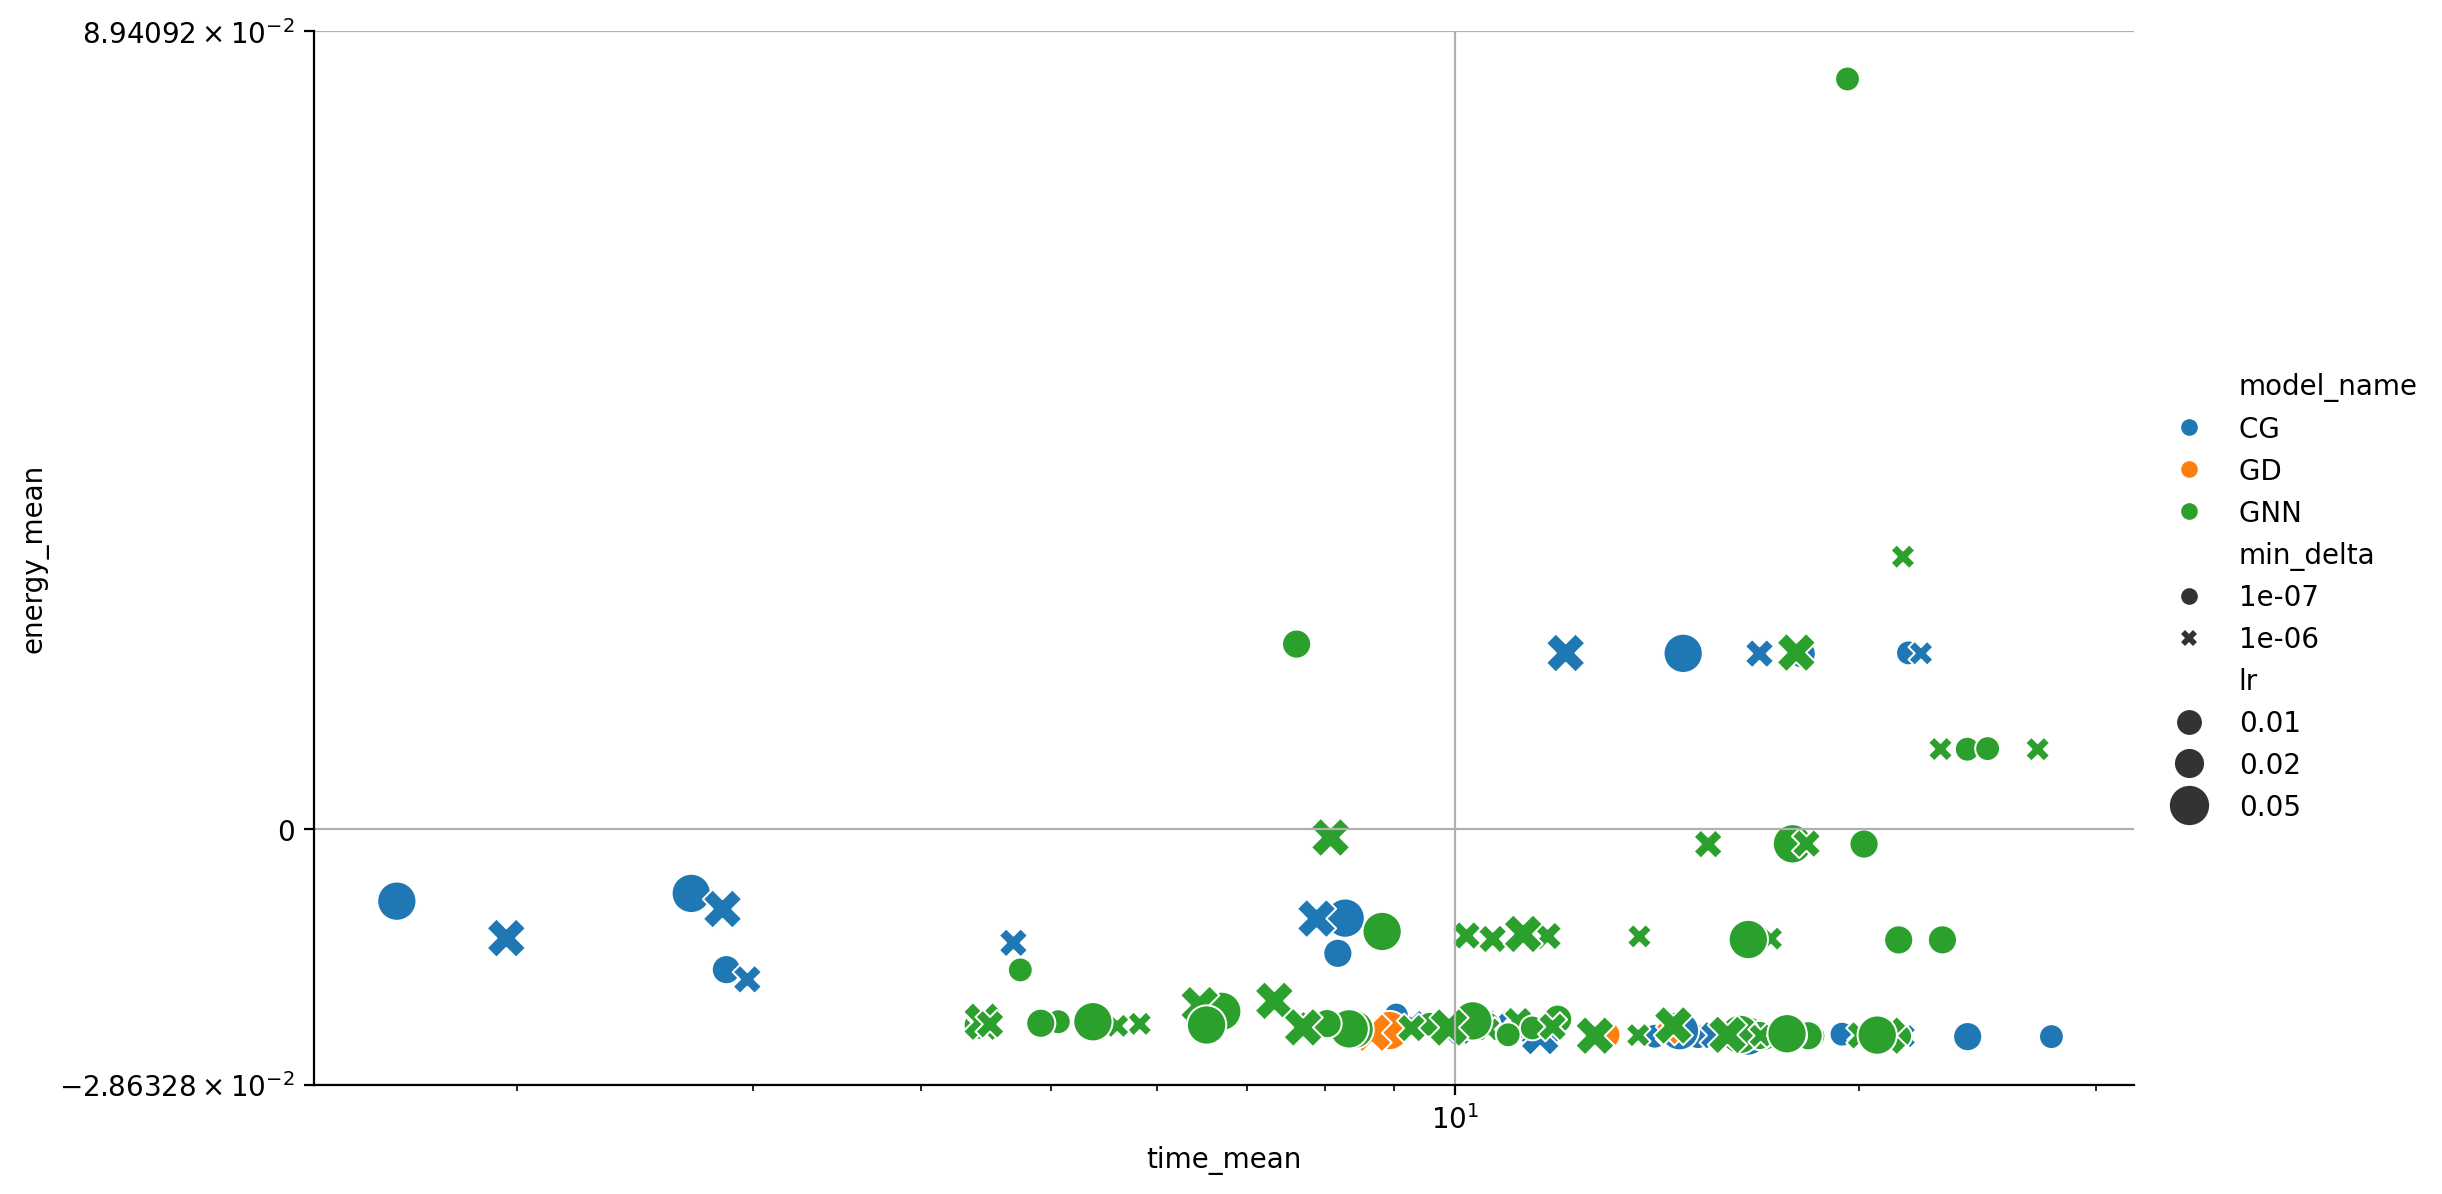

In [153]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

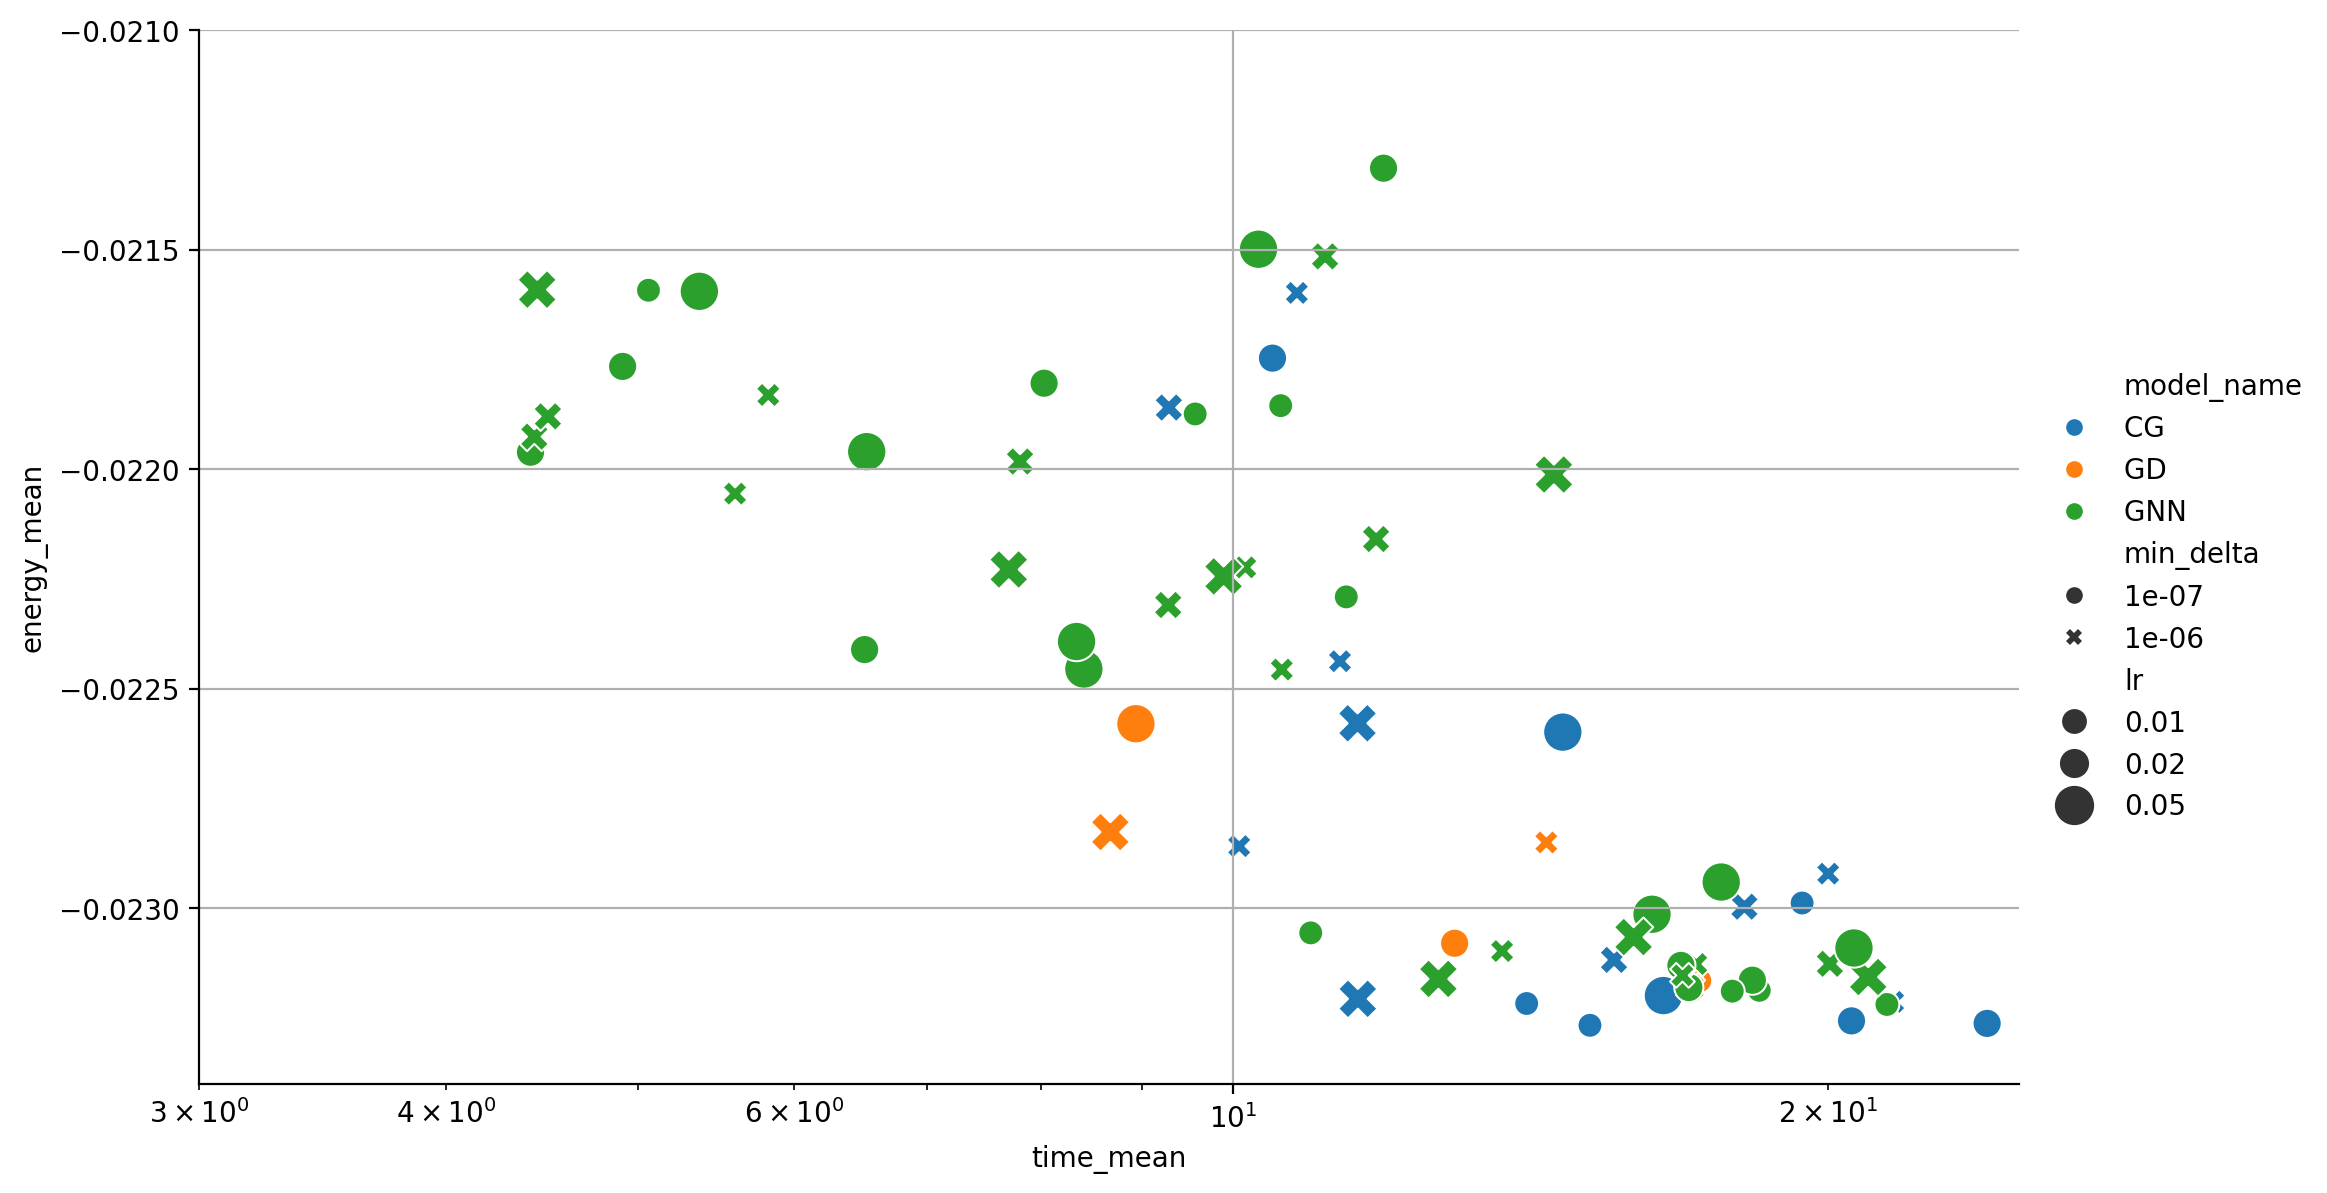

In [154]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.0210)
plt.xlim(3,25)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

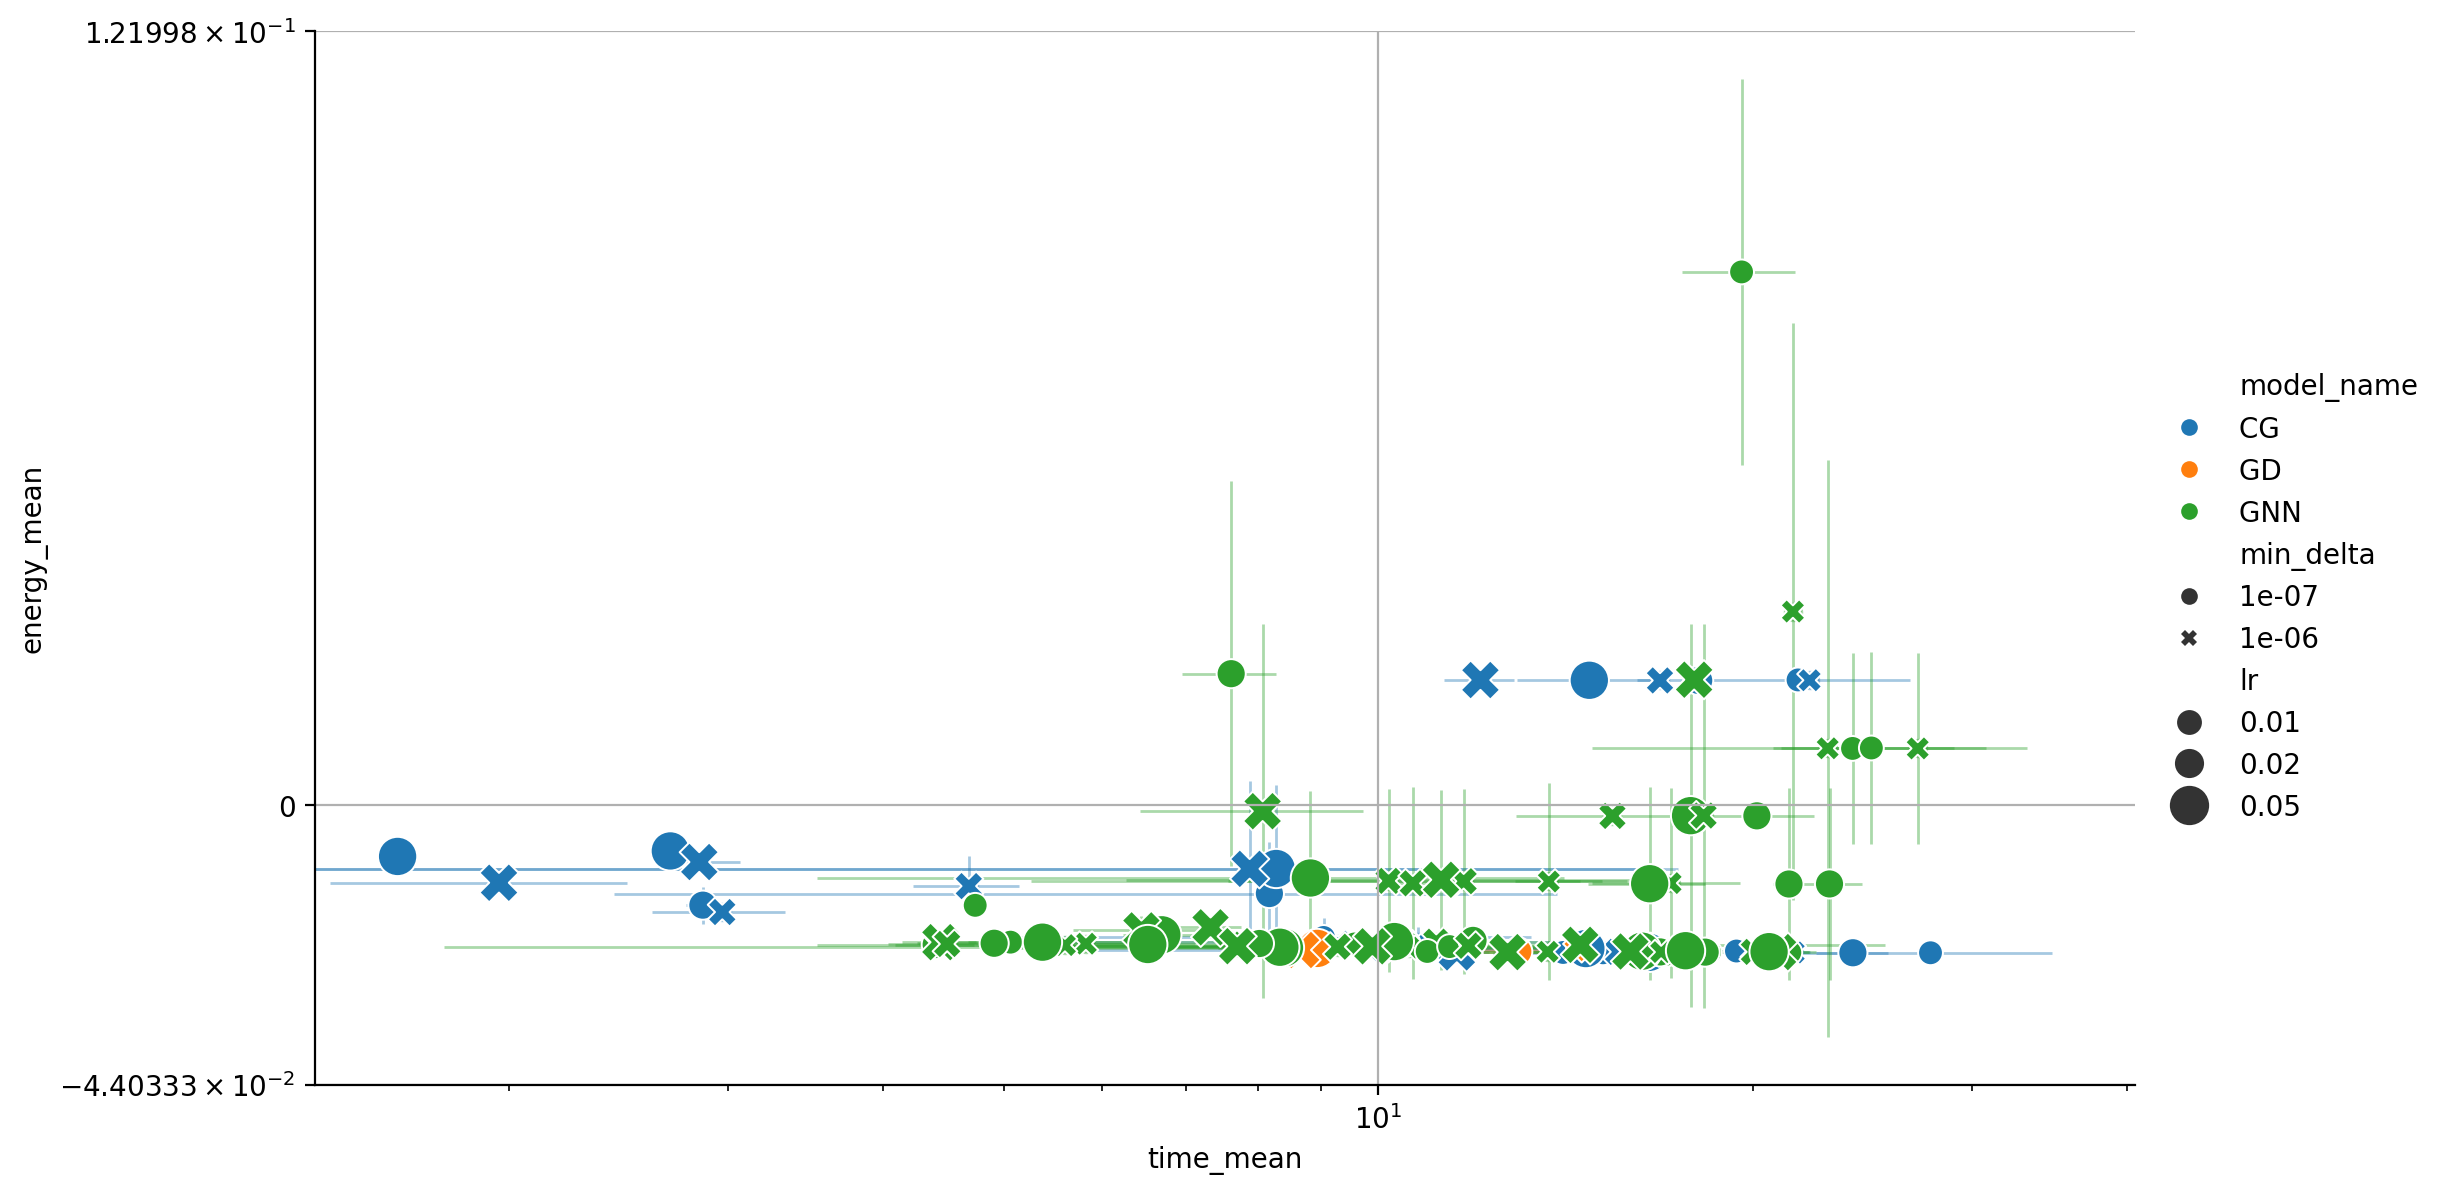

In [155]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

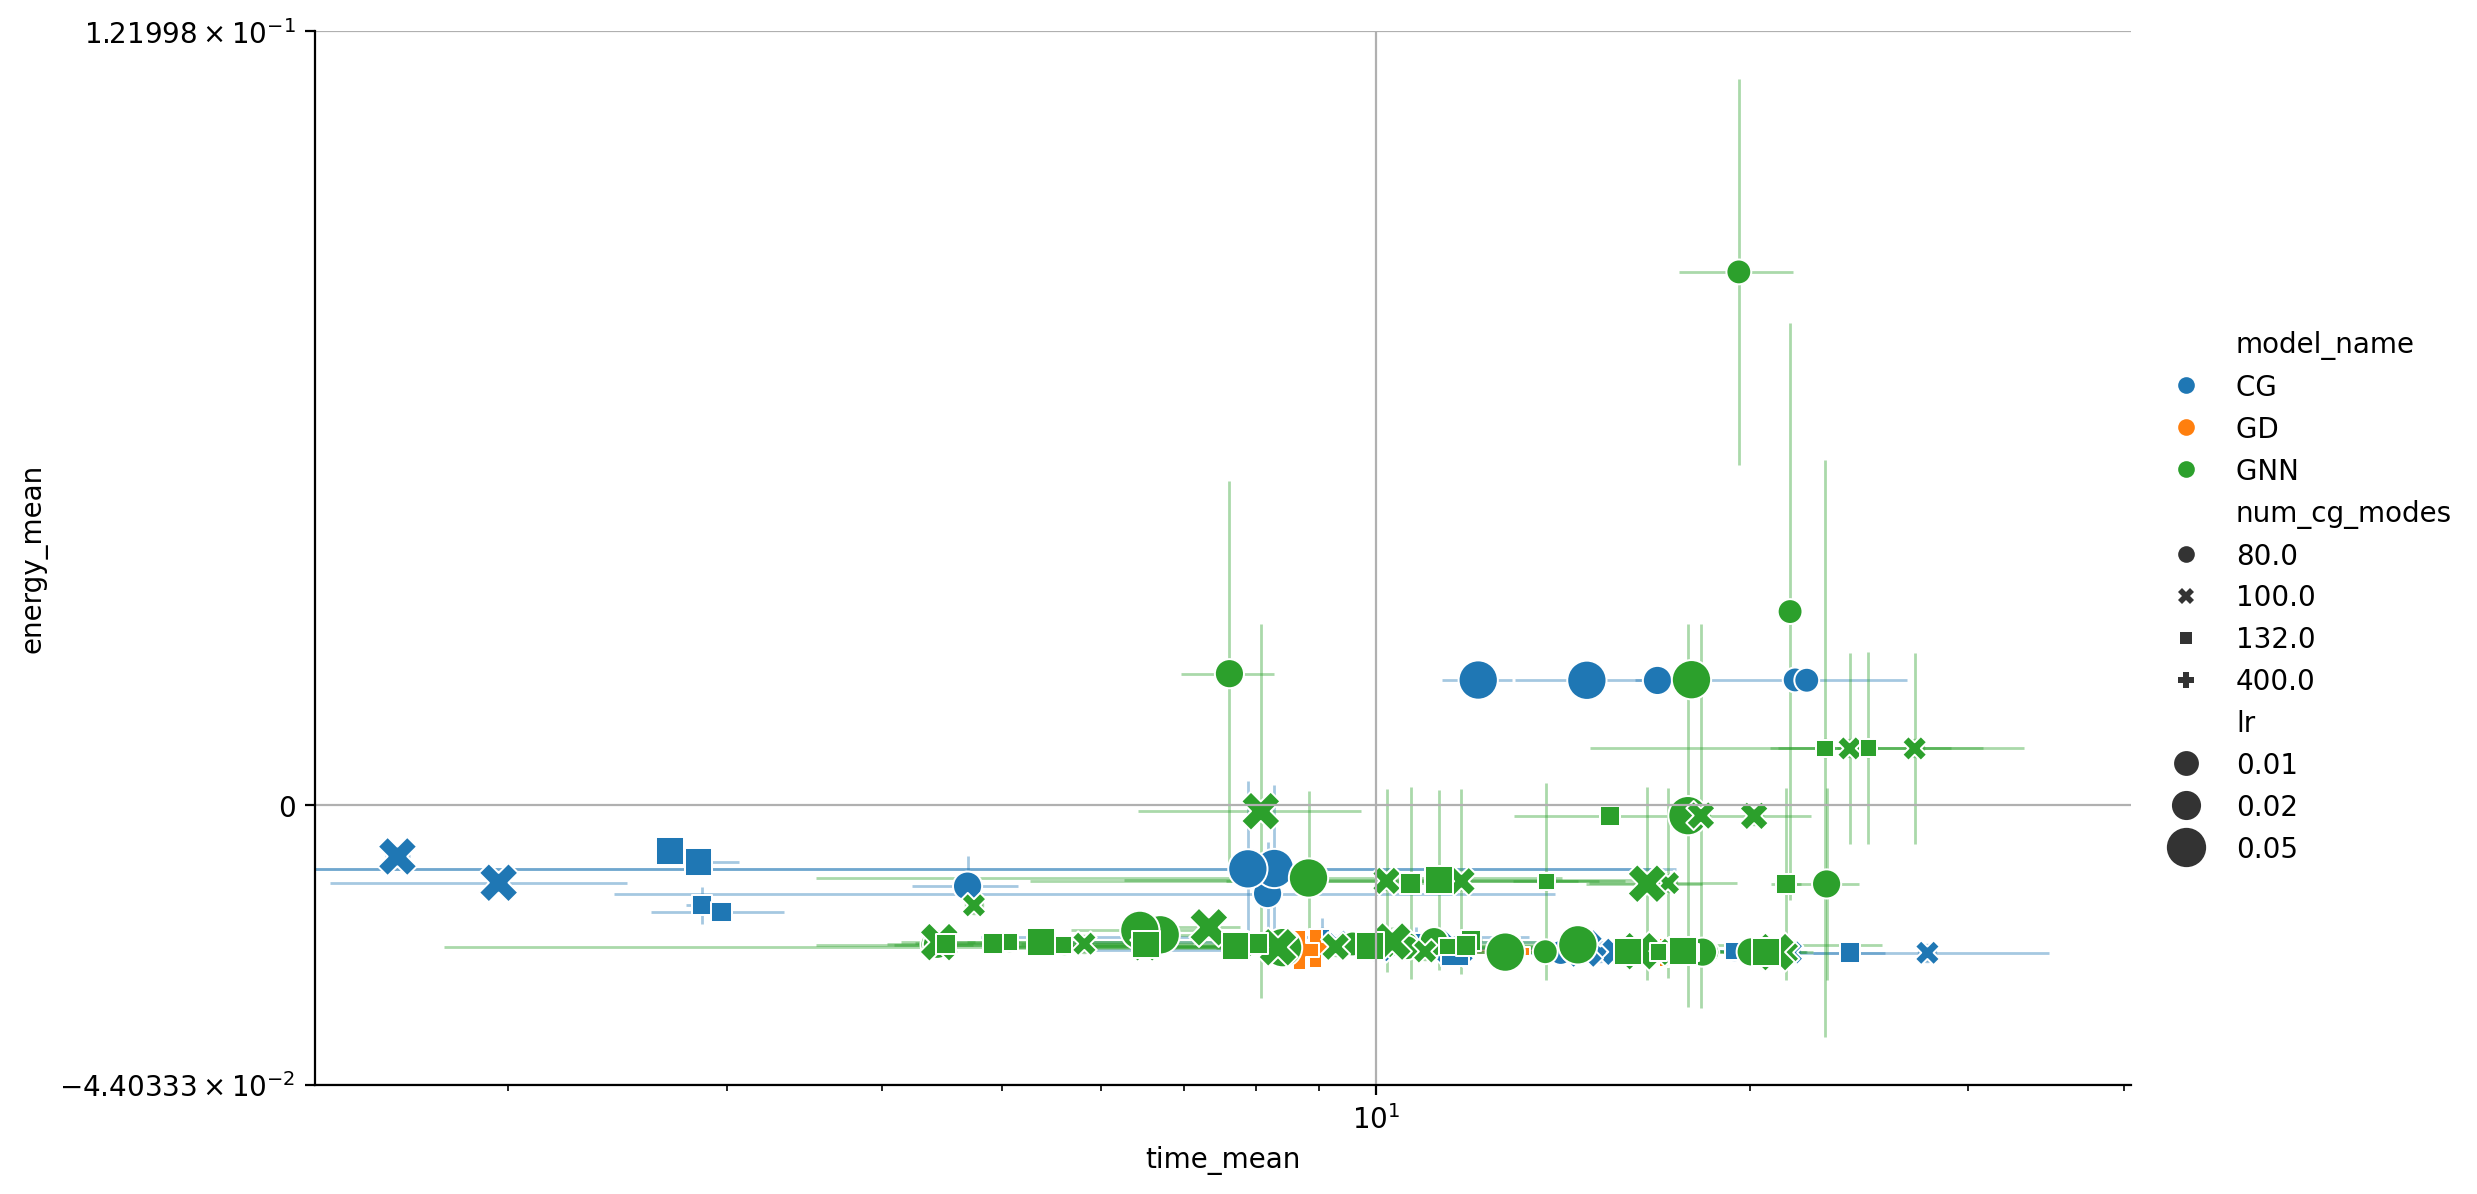

In [156]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

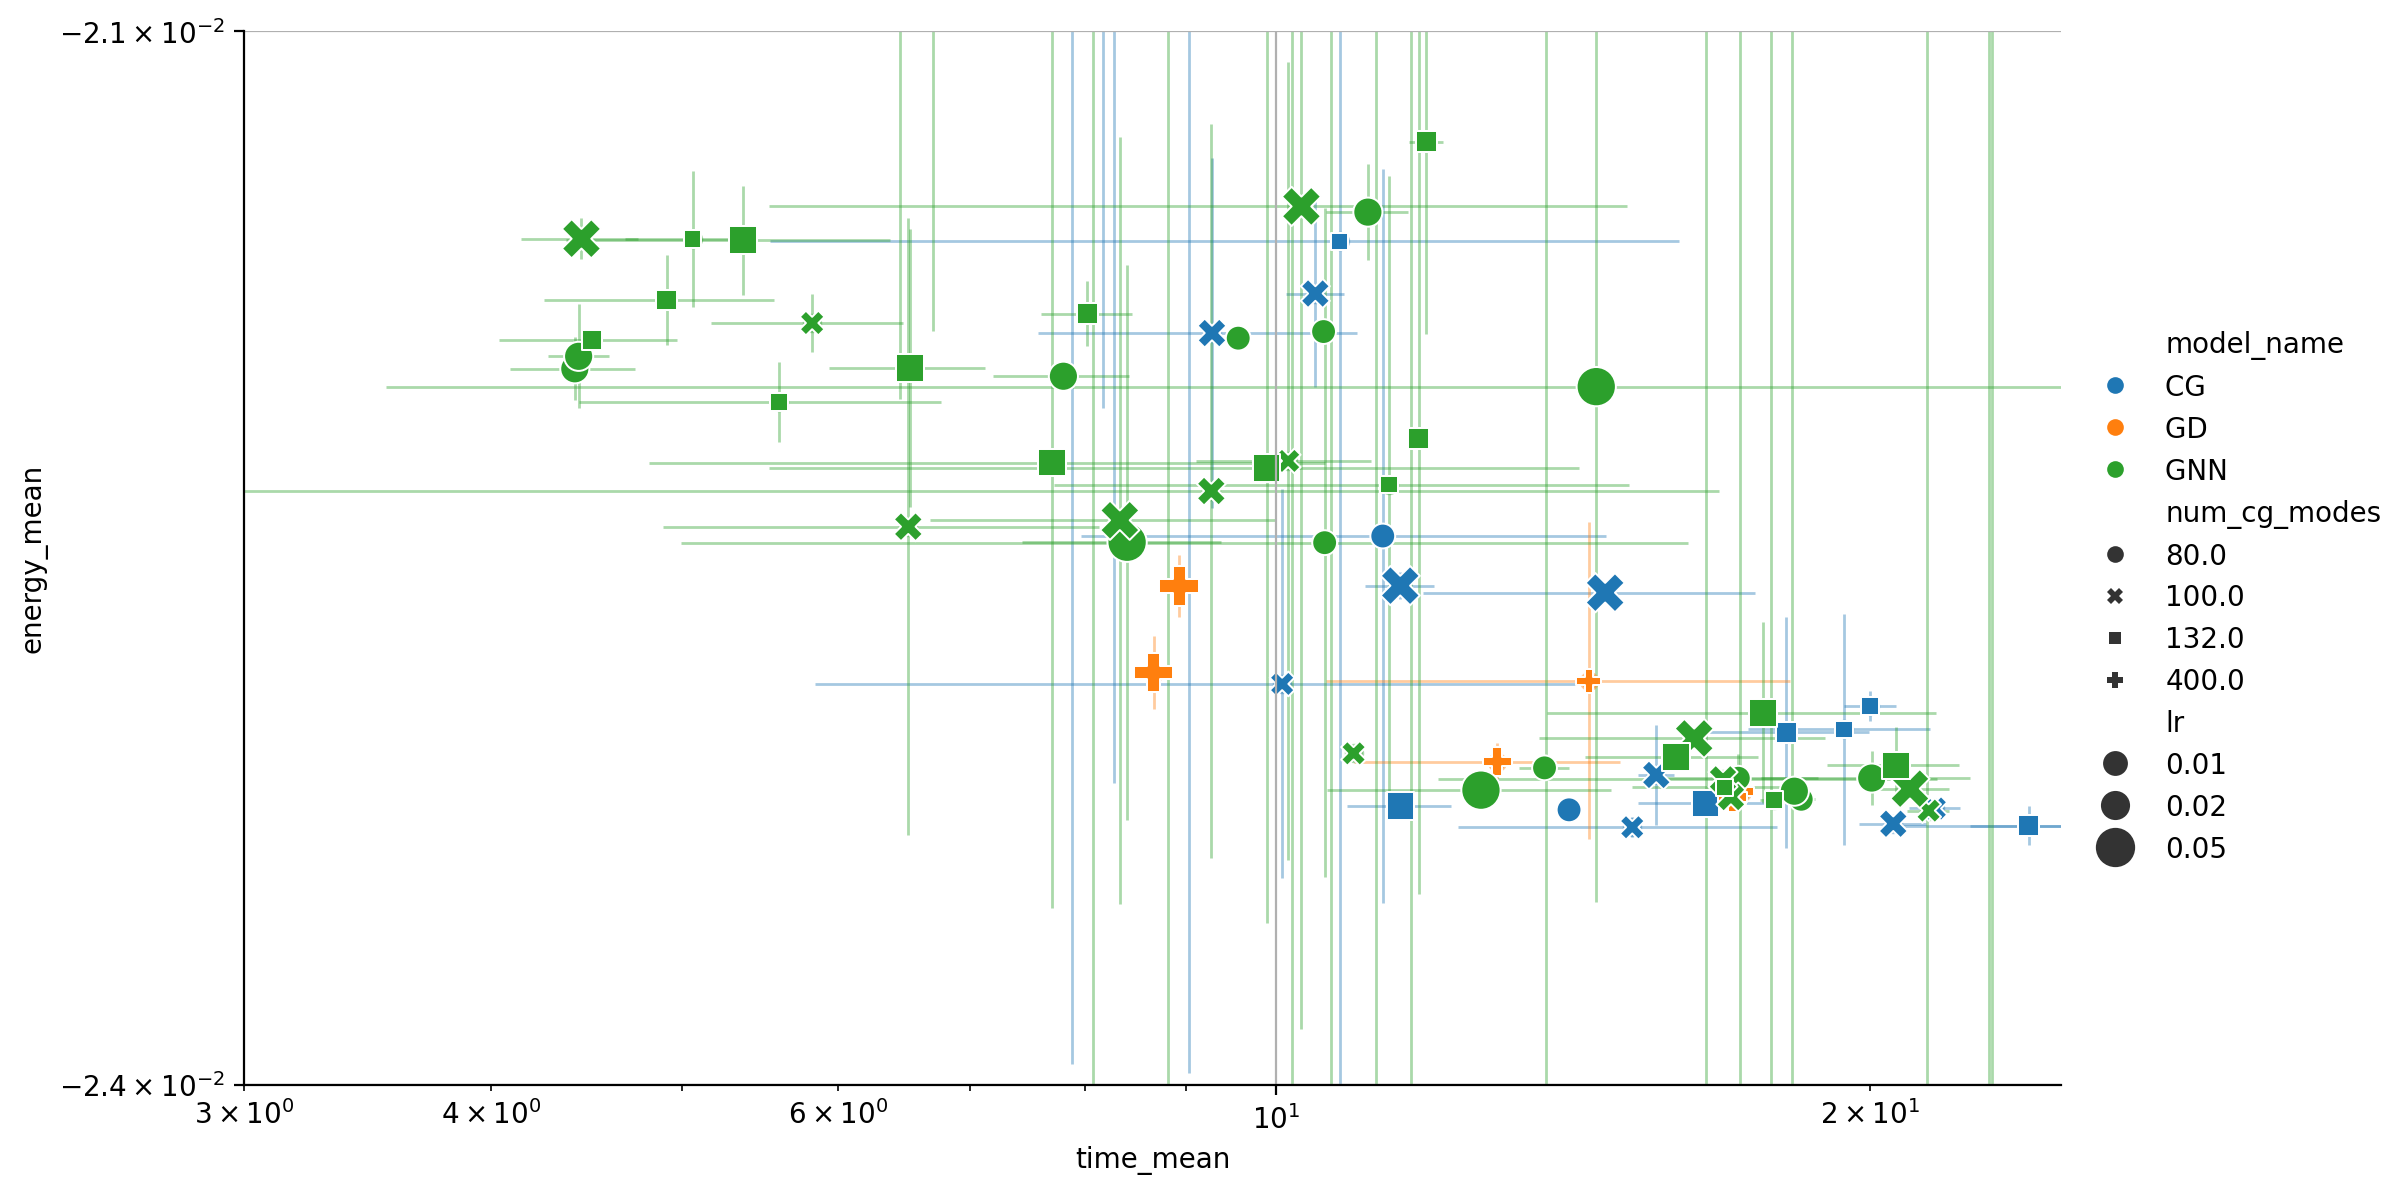

In [157]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

plt.ylim(-.024, -.0210)
plt.xlim(3,25)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

# LJ double scale loop
Define an energy function which uses LJ with a coupling that has two levels of strength for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [1]:
ls results

CG_Bond_LJ_experiment2024-02-09-21.csv
CG_Bond_LJ_experiment2024-02-10-02.csv
CG_Bond_LJ_experiment2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-04.csv
CG_Bond_LJ_experiments_2024-02-10-16.csv
CG_LJ2_experiments_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-05.csv
CG_LJ2_experiments_2scale_2024-02-10-06.csv
logs/
test2024-02-09-22.csv
test2024-02-09-23.csv


In [9]:
# exp_logger = ExperimentLogger(previous_results_csv='./results/CG_LJ2_experiments_2024-02-10-04.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_LJ2_experiments_2scale_2024-02-10-06.csv')
df = exp_logger.to_dataframe()

In [130]:
df

energy_function               model_name    energy       time    lr  \
0    Energy_LJ_2scale          Bond_LJ_n400_d3  0.247403   1.392278  0.05   
1    Energy_LJ_2scale   CG_Bond_LJ0.33_n400_d3  0.727117   9.580374  0.05   
2    Energy_LJ_2scale  GNN_Bond_LJ0.33_n400_d3  0.327568  10.335653  0.05   
3    Energy_LJ_2scale  GNN_Bond_LJ0.33_n400_d3 -0.053740   3.725070  0.05   
4    Energy_LJ_2scale   CG_Bond_LJ0.25_n400_d3  0.518101  14.386985  0.05   
..                ...                      ...       ...        ...   ...   
565  Energy_LJ_2scale  GNN_Bond_LJ0.25_n400_d3  0.378161   9.386935  0.01   
566  Energy_LJ_2scale  GNN_Bond_LJ0.25_n400_d3 -0.035773   7.855705  0.01   
567  Energy_LJ_2scale   CG_Bond_LJ0.20_n400_d3  0.723125  19.358500  0.01   
568  Energy_LJ_2scale  GNN_Bond_LJ0.20_n400_d3  0.642706  10.697762  0.01   
569  Energy_LJ_2scale  GNN_Bond_LJ0.20_n400_d3 -0.040278   5.829245  0.01   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  1.838327        400    NaN   
1            0.1        20  1.000000e-06  1.838327        400  0.050   
2            0.1        20  1.000000e-06  1.838327        400  0.005   
3            0.1        20  1.000000e-06  1.838327        400  0.005   
4            0.1        20  1.000000e-06  1.838327        400  0.050   
..           ...       ...           ...       ...        ...    ...   
565          0.1        20  1.000000e-07  1.838327        400  0.010   
566          0.1        20  1.000000e-07  1.838327        400  0.010   
567          0.1        20  1.000000e-07  1.838327        400  0.100   
568          0.1        20  1.000000e-07  1.838327        400  0.010   
569          0.1        20  1.000000e-07  1.838327        400  0.010   

     cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  \
0            NaN           NaN       NaN        NaN        NaN           NaN   
1           20.0      0.000010     527.0   8.515158   0.749255           NaN   
2           20.0      0.000010     422.0   8.722153   0.328345         133.0   
3           20.0      0.000010      34.0   1.192533  -0.018955         133.0   
4           20.0      0.000010     822.0  13.196695   0.542127           NaN   
..           ...           ...       ...        ...        ...           ...   
565         20.0      0.000001     220.0   4.761004   0.396002         100.0   
566         20.0      0.000001      26.0   1.015844  -0.003536         100.0   
567         20.0      0.000001     635.0  10.377081   0.760114           NaN   
568         20.0      0.000001     398.0   8.248155   0.643227          80.0   
569         20.0      0.000001      27.0   1.042117  -0.006536          80.0   

     hidden_dims  
0            NaN  
1            NaN  
2      [8, 4, 3]  
3    [32, 16, 3]  
4            NaN  
..           ...  
565    [8, 4, 3]  
566  [32, 16, 3]  
567          NaN  
568    [8, 4, 3]  
569  [32, 16, 3]  

[570 rows x 18 columns]

In [133]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']
# ensure that the num_cg_modes is an integer
df['num_cg_modes'] = df['num_cg_modes'].astype(int)

In [136]:
df

energy_function               model_name    energy       time    lr  \
0    Energy_LJ_2scale          Bond_LJ_n400_d3  0.247403   1.392278  0.05   
1    Energy_LJ_2scale   CG_Bond_LJ0.33_n400_d3  0.727117   9.580374  0.05   
2    Energy_LJ_2scale  GNN_Bond_LJ0.33_n400_d3  0.327568  10.335653  0.05   
3    Energy_LJ_2scale  GNN_Bond_LJ0.33_n400_d3 -0.053740   3.725070  0.05   
4    Energy_LJ_2scale   CG_Bond_LJ0.25_n400_d3  0.518101  14.386985  0.05   
..                ...                      ...       ...        ...   ...   
565  Energy_LJ_2scale  GNN_Bond_LJ0.25_n400_d3  0.378161   9.386935  0.01   
566  Energy_LJ_2scale  GNN_Bond_LJ0.25_n400_d3 -0.035773   7.855705  0.01   
567  Energy_LJ_2scale   CG_Bond_LJ0.20_n400_d3  0.723125  19.358500  0.01   
568  Energy_LJ_2scale  GNN_Bond_LJ0.20_n400_d3  0.642706  10.697762  0.01   
569  Energy_LJ_2scale  GNN_Bond_LJ0.20_n400_d3 -0.040278   5.829245  0.01   

     clamp_grads  patience     min_delta    x0_std  num_nodes  lr_cg  \
0            0.1        20  1.000000e-06  1.838327        400    NaN   
1            0.1        20  1.000000e-06  1.838327        400  0.050   
2            0.1        20  1.000000e-06  1.838327        400  0.005   
3            0.1        20  1.000000e-06  1.838327        400  0.005   
4            0.1        20  1.000000e-06  1.838327        400  0.050   
..           ...       ...           ...       ...        ...    ...   
565          0.1        20  1.000000e-07  1.838327        400  0.010   
566          0.1        20  1.000000e-07  1.838327        400  0.010   
567          0.1        20  1.000000e-07  1.838327        400  0.100   
568          0.1        20  1.000000e-07  1.838327        400  0.010   
569          0.1        20  1.000000e-07  1.838327        400  0.010   

     cg_patience  cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  \
0            NaN           NaN       NaN        NaN        NaN         400.0   
1           20.0      0.000010     527.0   8.515158   0.749255         132.0   
2           20.0      0.000010     422.0   8.722153   0.328345         132.0   
3           20.0      0.000010      34.0   1.192533  -0.018955         132.0   
4           20.0      0.000010     822.0  13.196695   0.542127         100.0   
..           ...           ...       ...        ...        ...           ...   
565         20.0      0.000001     220.0   4.761004   0.396002         100.0   
566         20.0      0.000001      26.0   1.015844  -0.003536         100.0   
567         20.0      0.000001     635.0  10.377081   0.760114          80.0   
568         20.0      0.000001     398.0   8.248155   0.643227          80.0   
569         20.0      0.000001      27.0   1.042117  -0.006536          80.0   

     hidden_dims  cg_ratio  
0            NaN      1.00  
1            NaN      0.33  
2      [8, 4, 3]      0.33  
3    [32, 16, 3]      0.33  
4            NaN      0.25  
..           ...       ...  
565    [8, 4, 3]      0.25  
566  [32, 16, 3]      0.25  
567          NaN      0.20  
568    [8, 4, 3]      0.20  
569  [32, 16, 3]      0.20  

[570 rows x 19 columns]

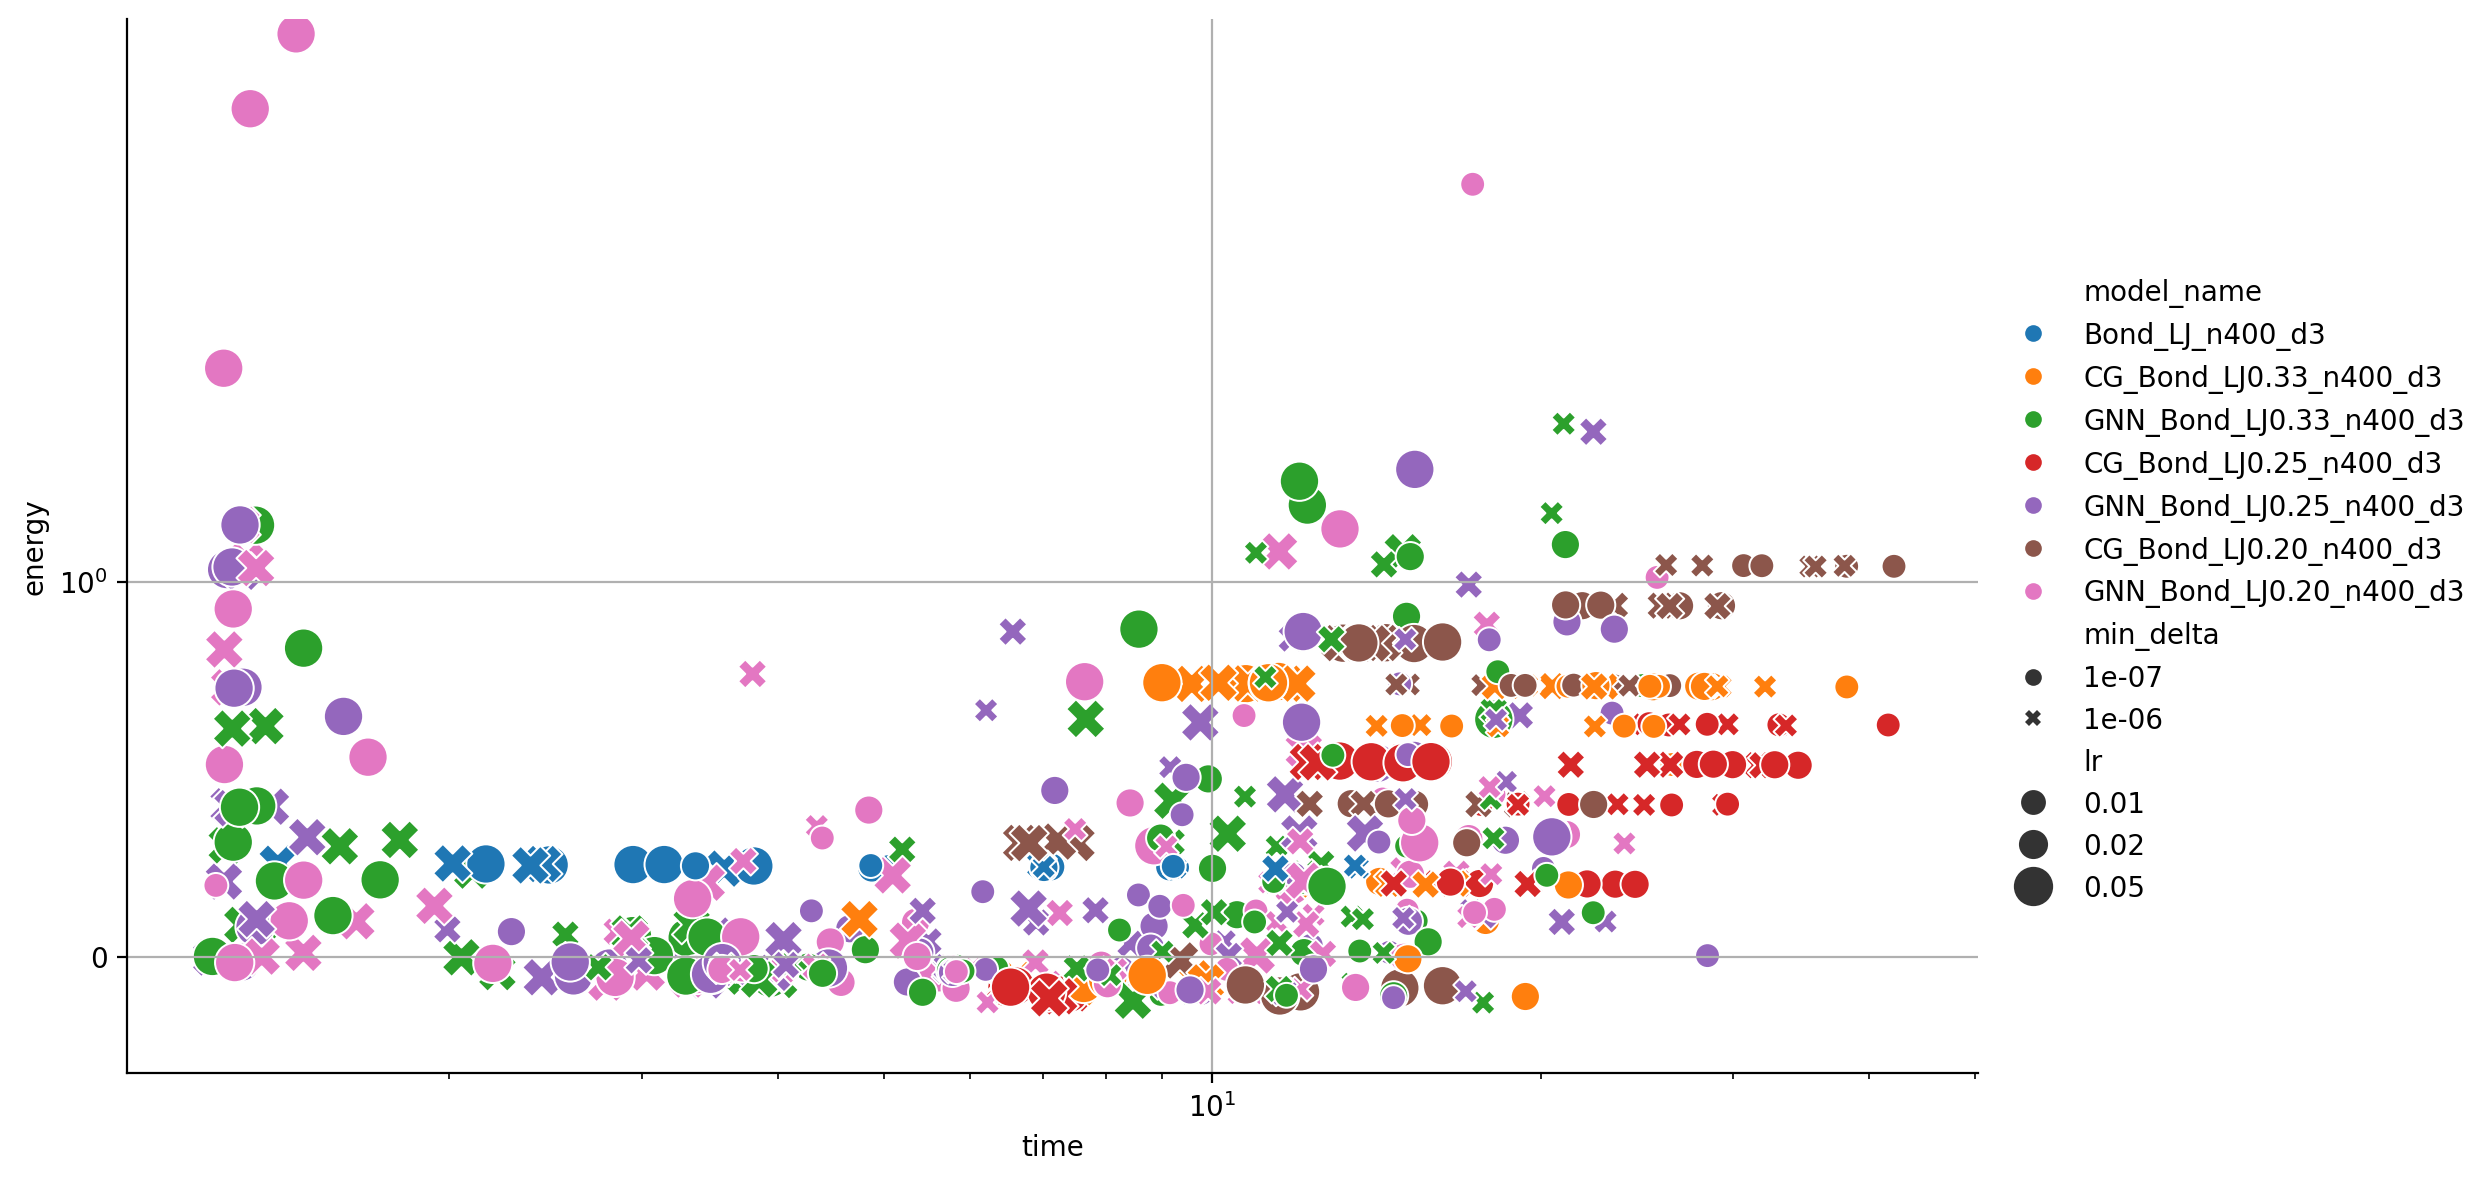

In [137]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

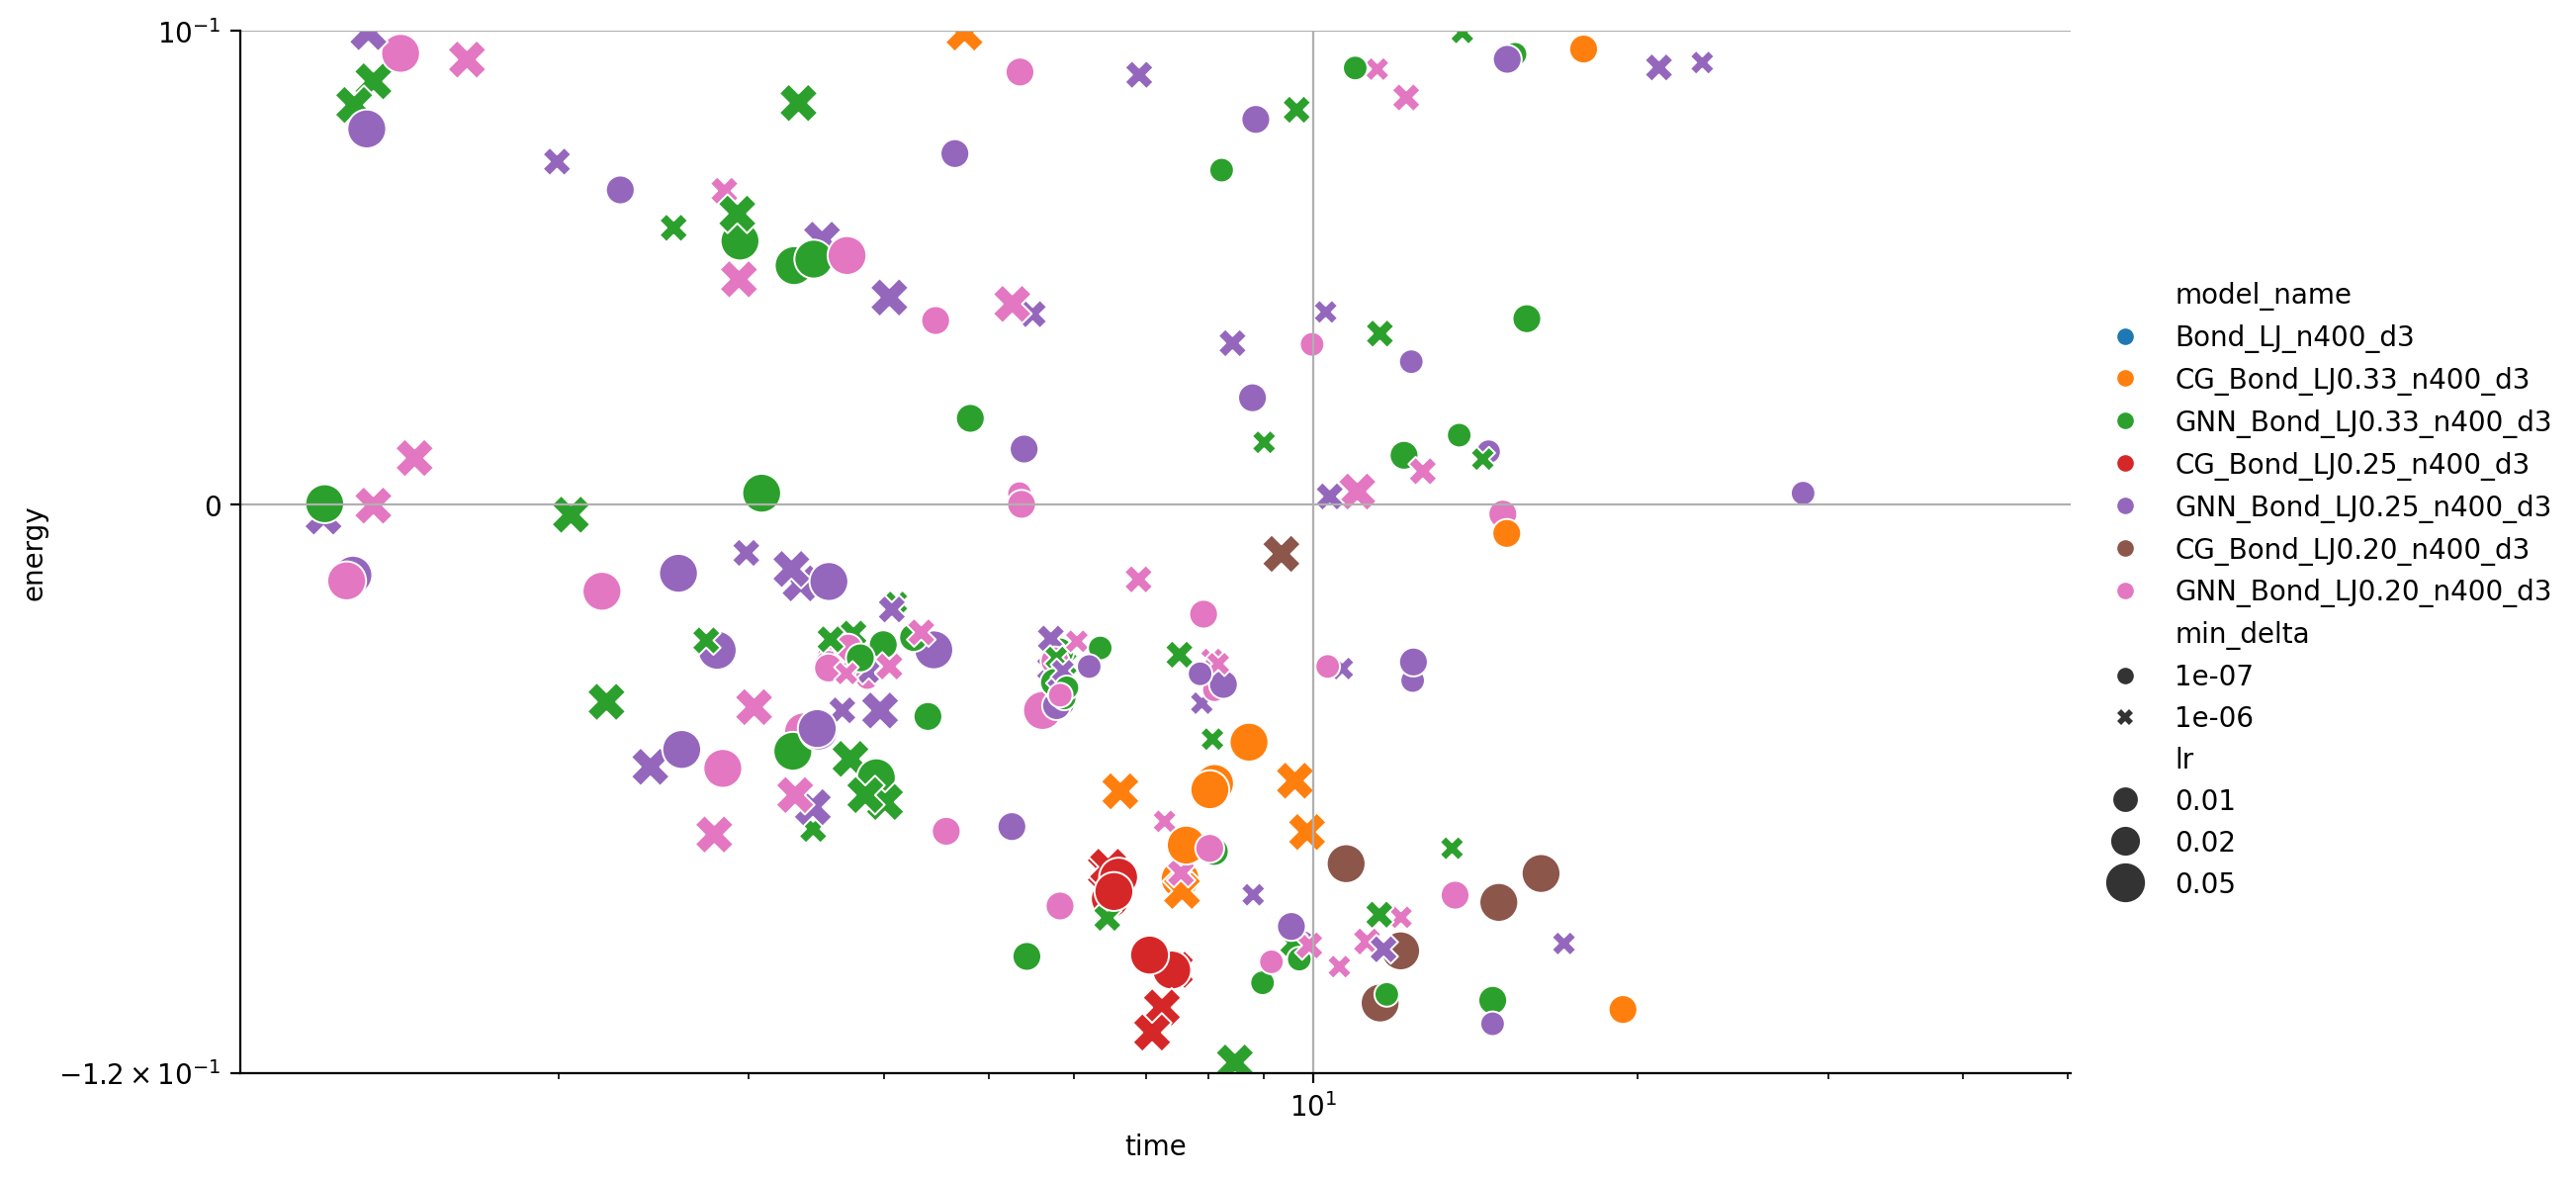

In [139]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

## Grouping similar runs

In [140]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'min_delta', 'num_cg_modes', 'lr_cg', 'hidden_dims'])
# other options: cg_patience,cg_min_delta
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1624139/3992581159.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1624139/3992581159.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr     min_delta num_cg_modes  lr_cg  \
                                                                       
0            Bond_LJ_n400_d3  0.01  1.000000e-07        400.0    NaN   
1            Bond_LJ_n400_d3  0.01  1.000000e-06        400.0    NaN   
2            Bond_LJ_n400_d3  0.02  1.000000e-07        400.0    NaN   
3            Bond_LJ_n400_d3  0.02  1.000000e-06        400.0    NaN   
4            Bond_LJ_n400_d3  0.05  1.000000e-07        400.0    NaN   
..                       ...   ...           ...          ...    ...   
109  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-07        132.0  0.050   
110  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
111  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
112  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   
113  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   

     hidden_dims    energy                 time            
                      mean       std       mean       std  
0            NaN  0.239989  0.001858   7.085380  2.150125  
1            NaN  0.239260  0.002345  10.083259  3.301501  
2            NaN  0.238705  0.002149   6.301677  2.231569  
3            NaN  0.241878  0.004612   7.884045  1.981954  
4            NaN  0.244587  0.001987   2.904738  0.634405  
..           ...       ...       ...        ...       ...  
109    [8, 4, 3]  0.103540  0.100937   1.793974  0.745505  
110  [32, 16, 3] -0.031653  0.052676   3.343983  0.757289  
111    [8, 4, 3]  0.467462  0.437481  10.121132  2.875315  
112  [32, 16, 3]  0.379413  0.228405   1.350057  0.138640  
113    [8, 4, 3]  0.142383  0.125467   2.126317  0.738173  

[114 rows x 10 columns]

In [143]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

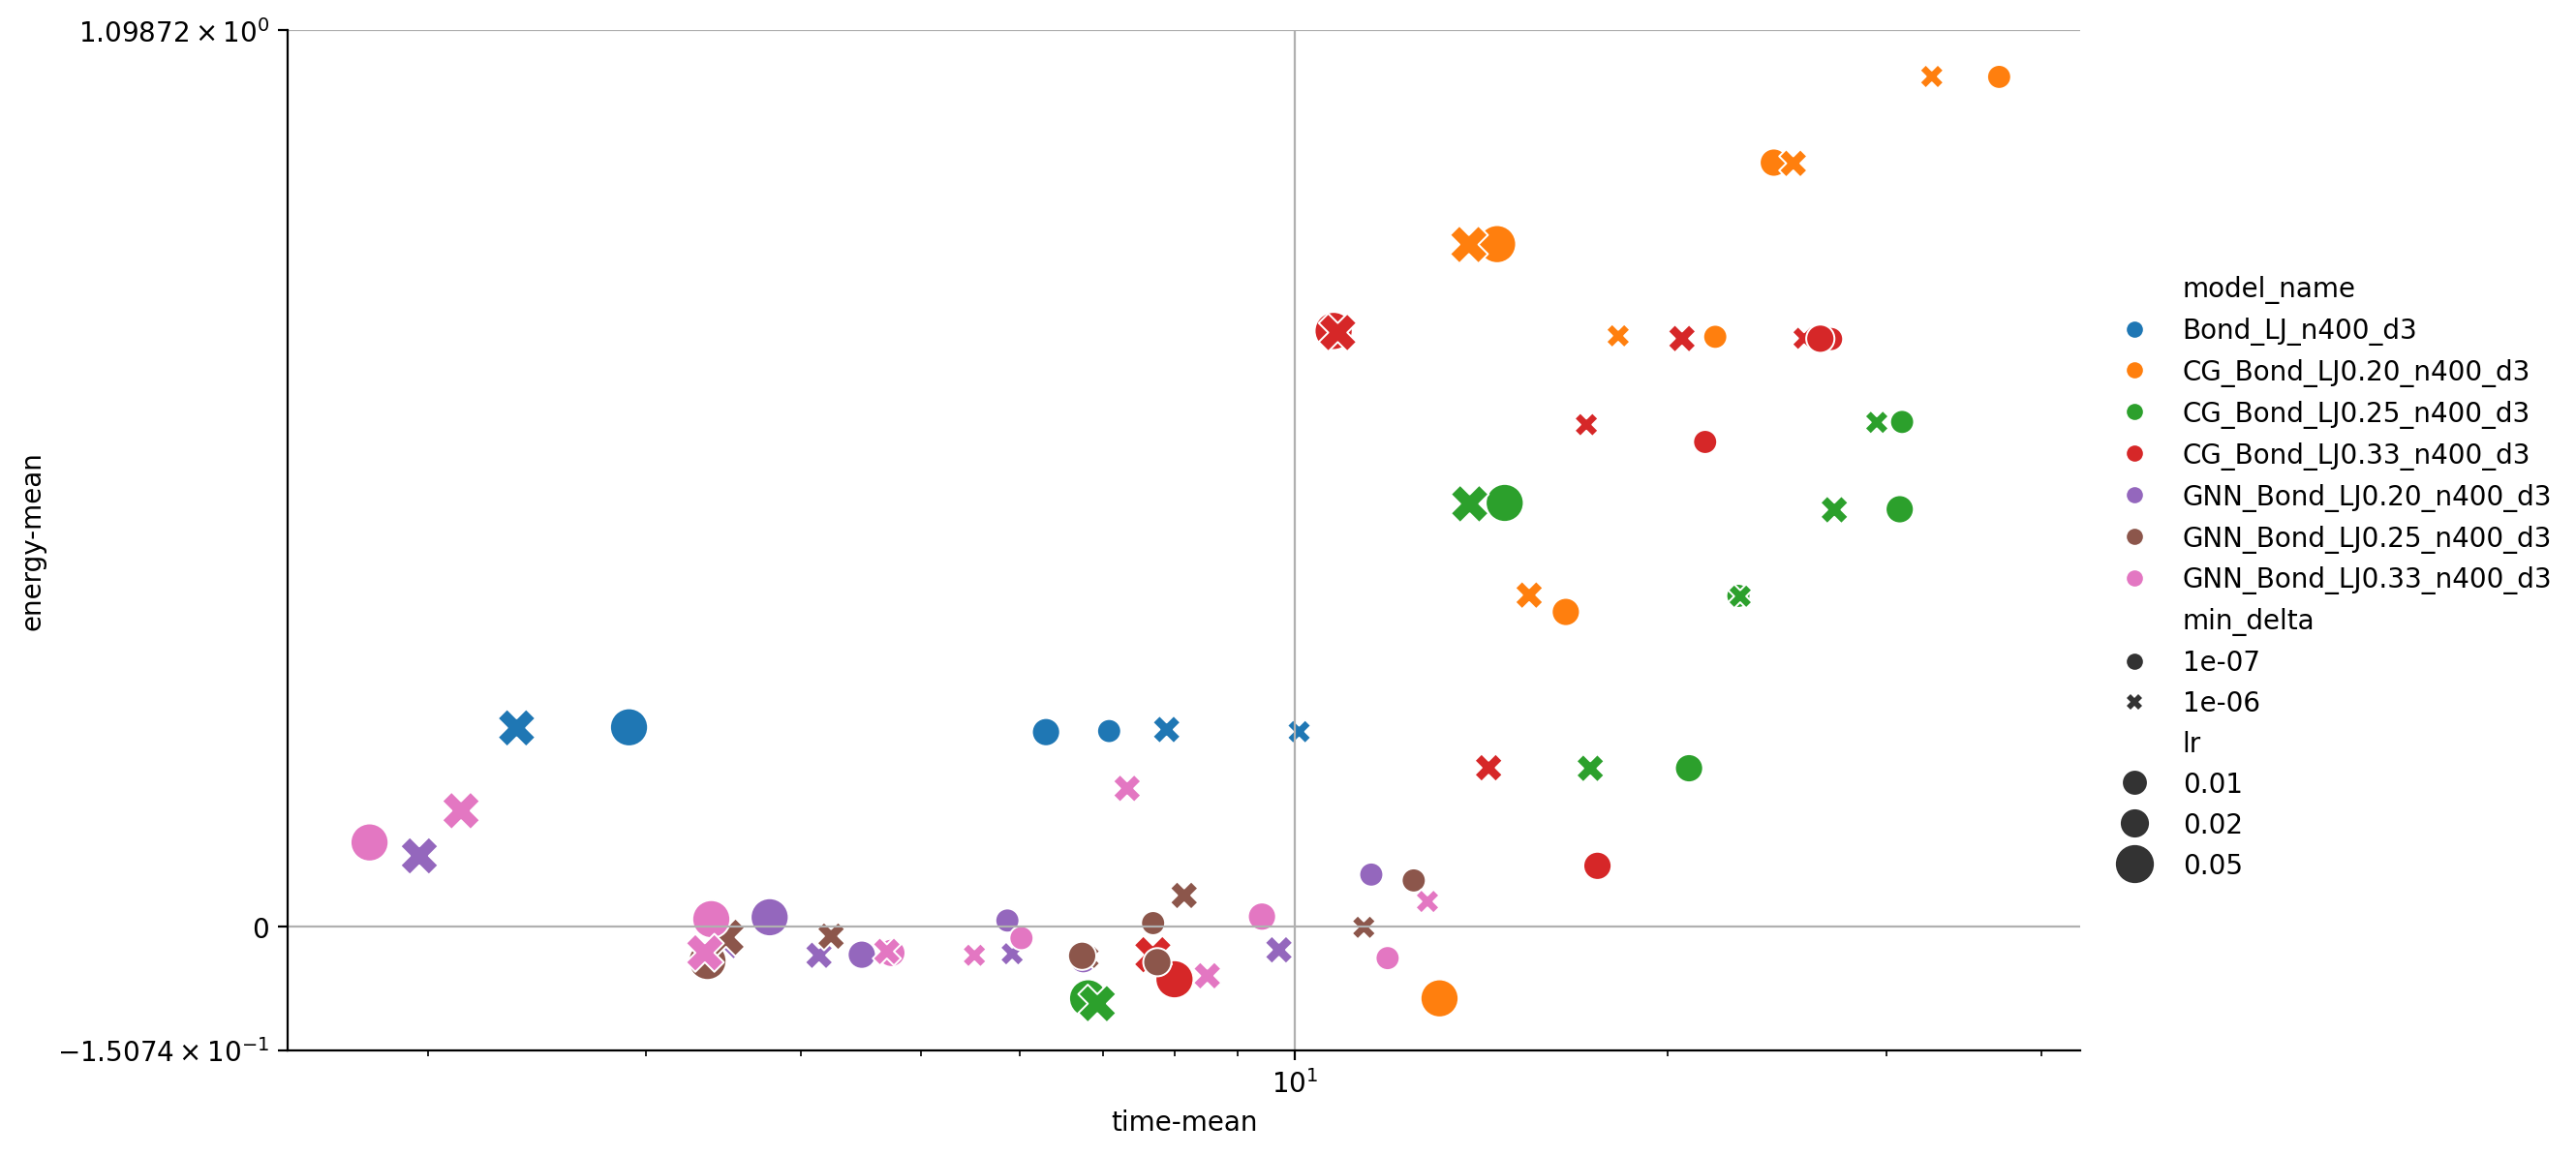

In [144]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

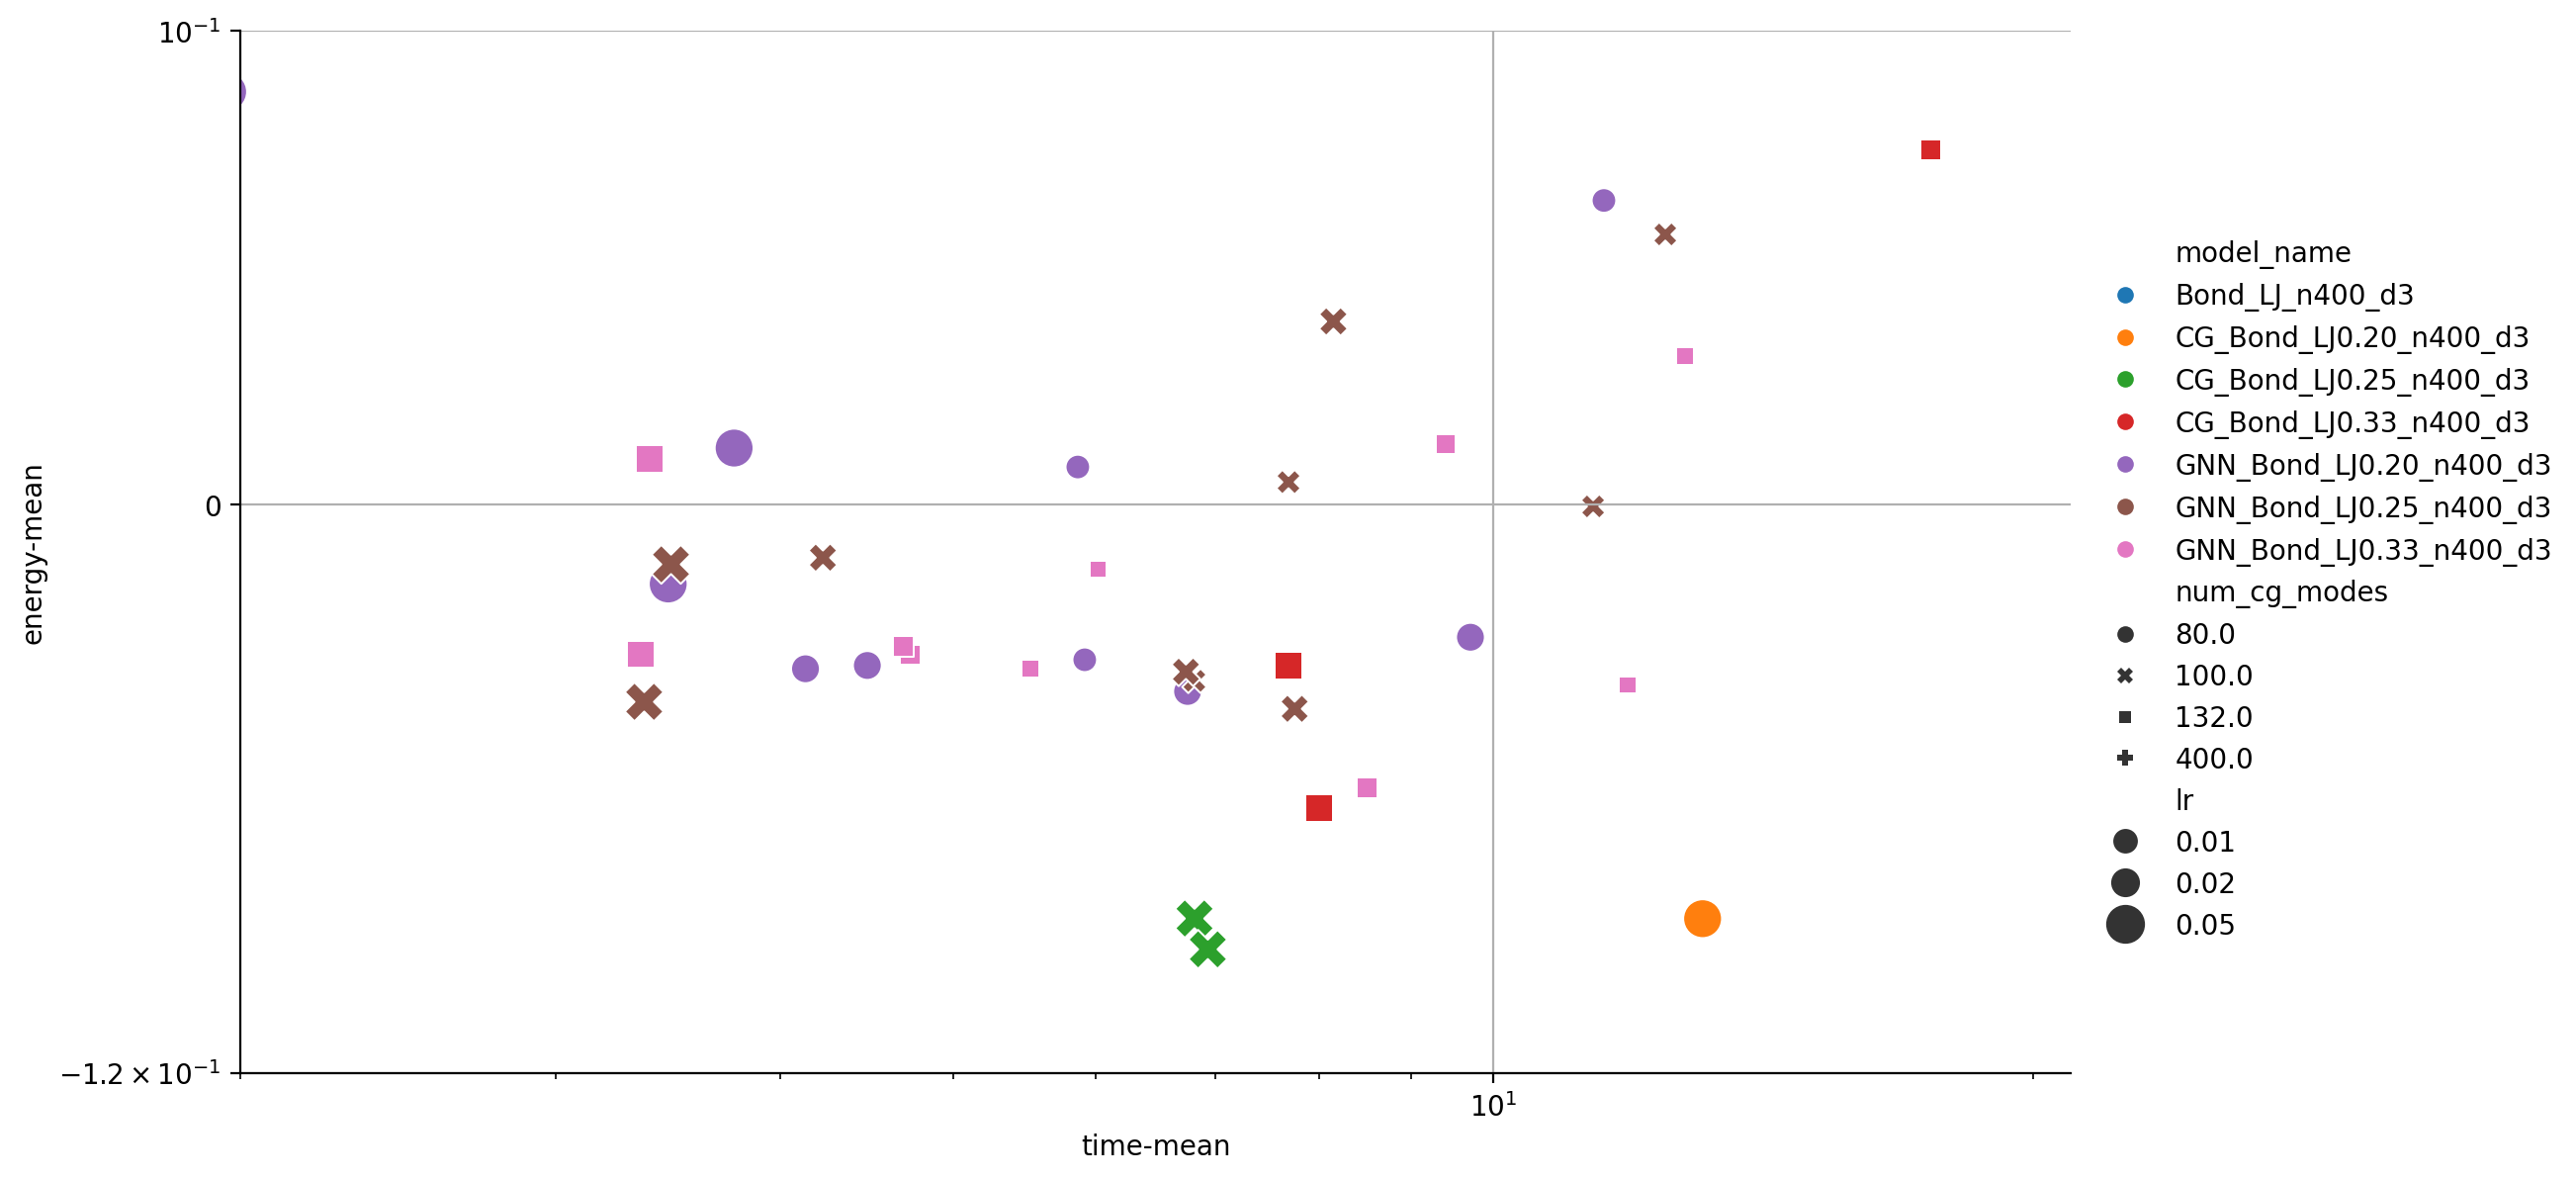

In [145]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
plt.xlim(2,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

In [146]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [147]:
df_cleaned

index model_name    lr     min_delta  num_cg_modes  lr_cg  hidden_dims  \
0       0       Adam  0.01  1.000000e-07         400.0    NaN          NaN   
1       1       Adam  0.01  1.000000e-06         400.0    NaN          NaN   
2       2       Adam  0.02  1.000000e-07         400.0    NaN          NaN   
3       3       Adam  0.02  1.000000e-06         400.0    NaN          NaN   
4       4       Adam  0.05  1.000000e-07         400.0    NaN          NaN   
..    ...        ...   ...           ...           ...    ...          ...   
69    105       GNN   0.02  1.000000e-06         132.0  0.020    [8, 4, 3]   
70    106       GNN   0.05  1.000000e-07         132.0  0.005  [32, 16, 3]   
71    109       GNN   0.05  1.000000e-07         132.0  0.050    [8, 4, 3]   
72    110       GNN   0.05  1.000000e-06         132.0  0.005  [32, 16, 3]   
73    113       GNN   0.05  1.000000e-06         132.0  0.050    [8, 4, 3]   

    energy-mean  energy-std  time-mean  time-std  energy_mean  energy_std  \
0      0.239989    0.001858   7.085380  2.150125     0.239989    0.001858   
1      0.239260    0.002345  10.083259  3.301501     0.239260    0.002345   
2      0.238705    0.002149   6.301677  2.231569     0.238705    0.002149   
3      0.241878    0.004612   7.884045  1.981954     0.241878    0.004612   
4      0.244587    0.001987   2.904738  0.634405     0.244587    0.001987   
..          ...         ...        ...       ...          ...         ...   
69     0.169767    0.116026   7.326153  3.298457     0.169767    0.116026   
70     0.009590    0.058958   3.384293  0.359979     0.009590    0.058958   
71     0.103540    0.100937   1.793974  0.745505     0.103540    0.100937   
72    -0.031653    0.052676   3.343983  0.757289    -0.031653    0.052676   
73     0.142383    0.125467   2.126317  0.738173     0.142383    0.125467   

    time_mean  time_std  
0    7.085380  2.150125  
1   10.083259  3.301501  
2    6.301677  2.231569  
3    7.884045  1.981954  
4    2.904738  0.634405  
..        ...       ...  
69   7.326153  3.298457  
70   3.384293  0.359979  
71   1.793974  0.745505  
72   3.343983  0.757289  
73   2.126317  0.738173  

[74 rows x 15 columns]

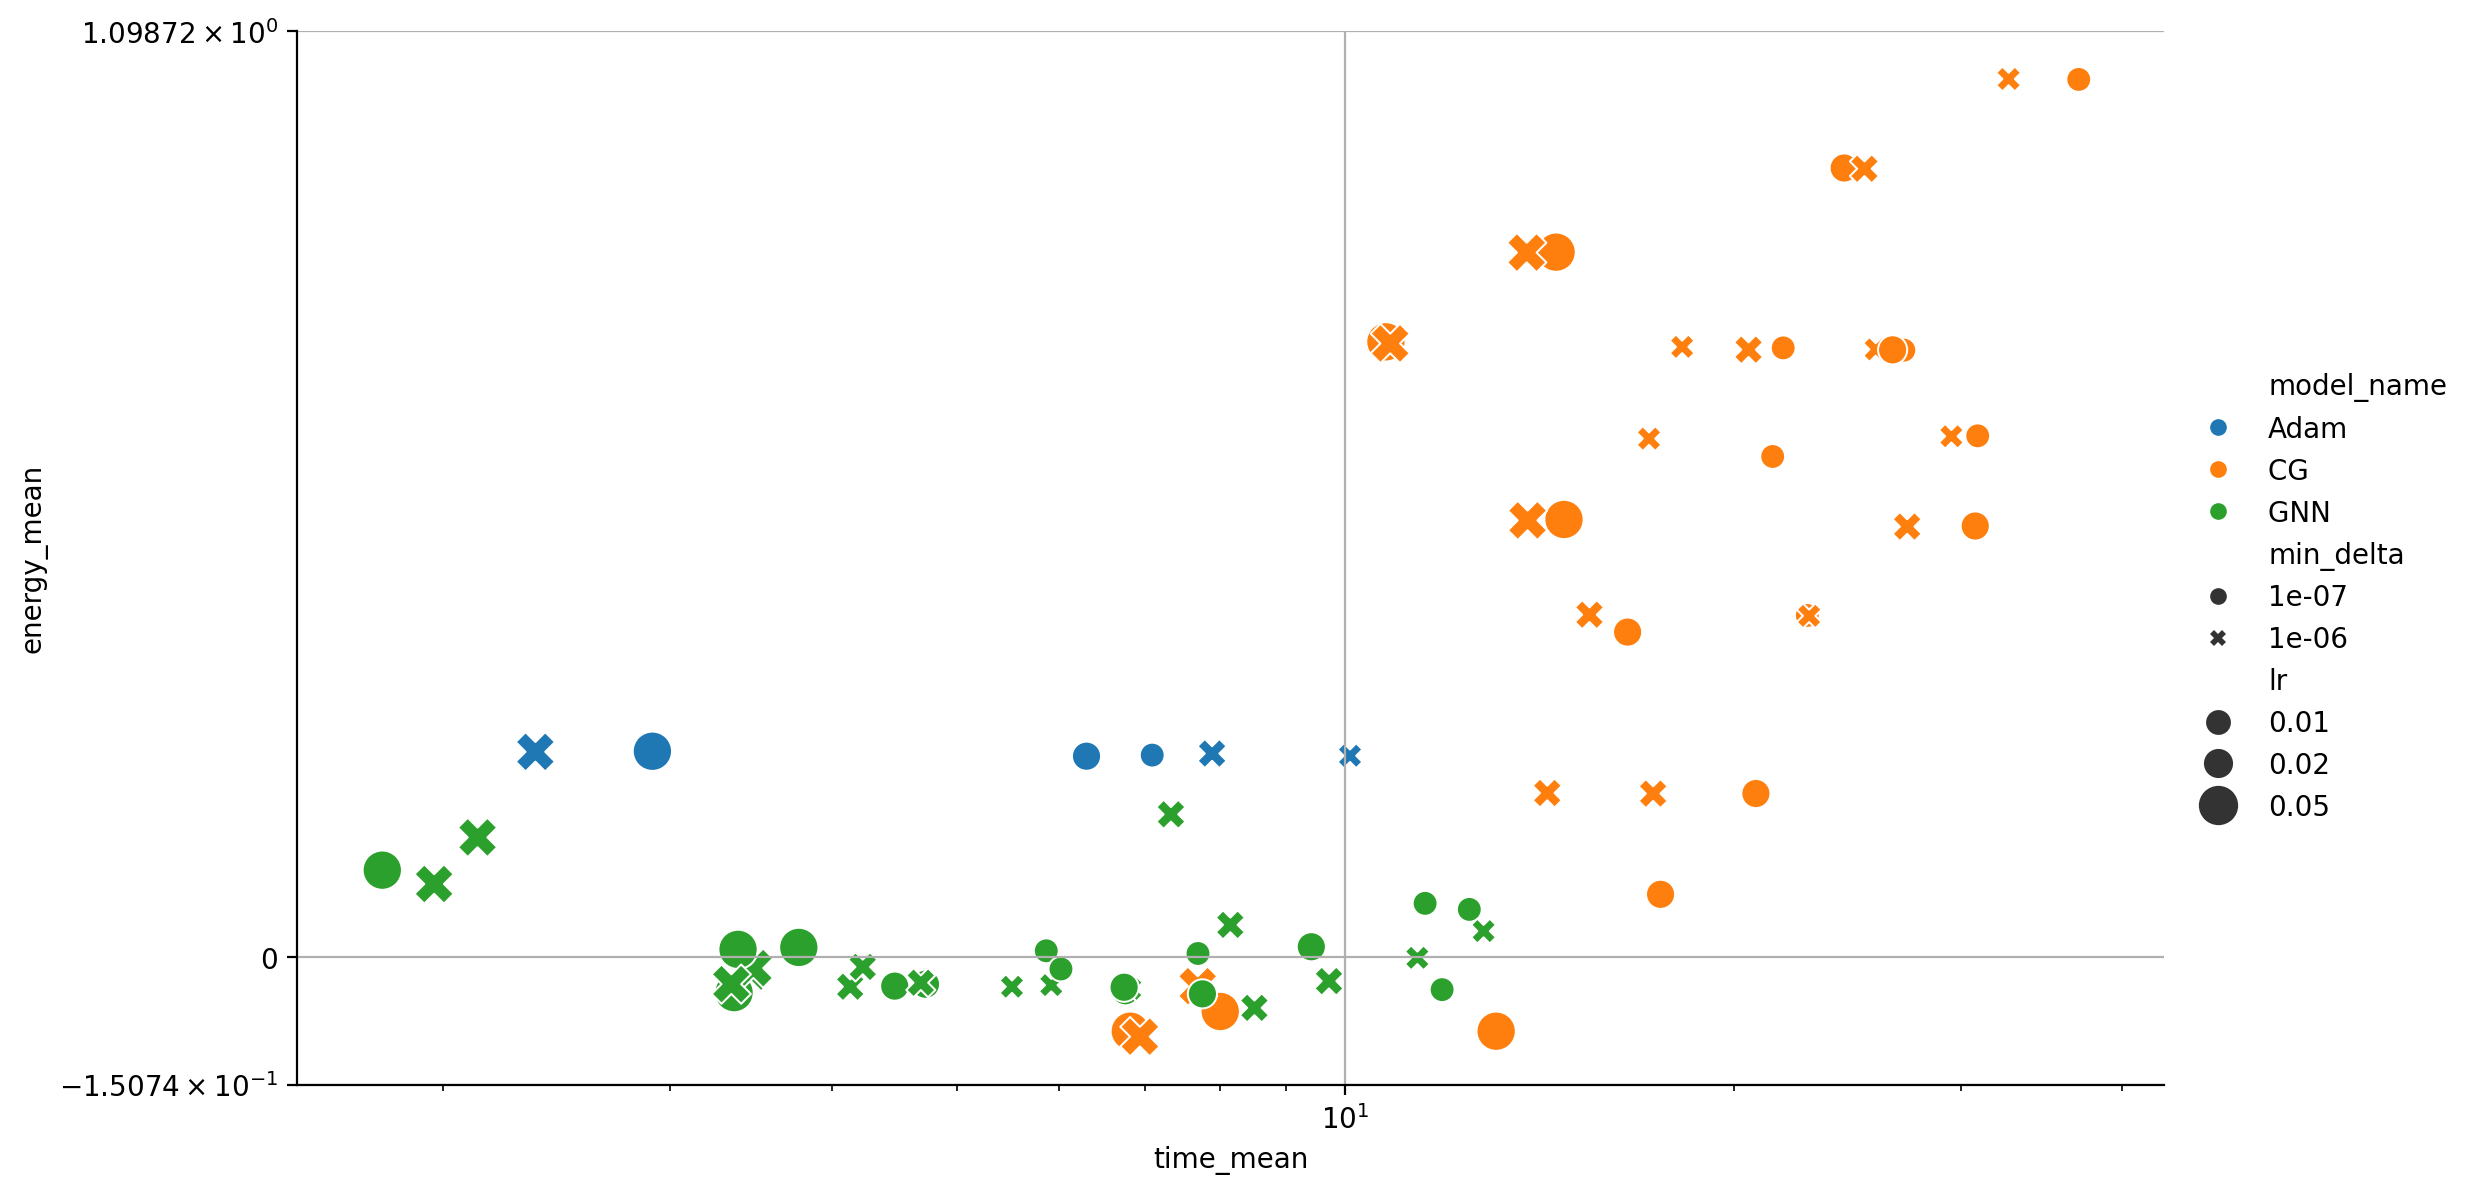

In [148]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

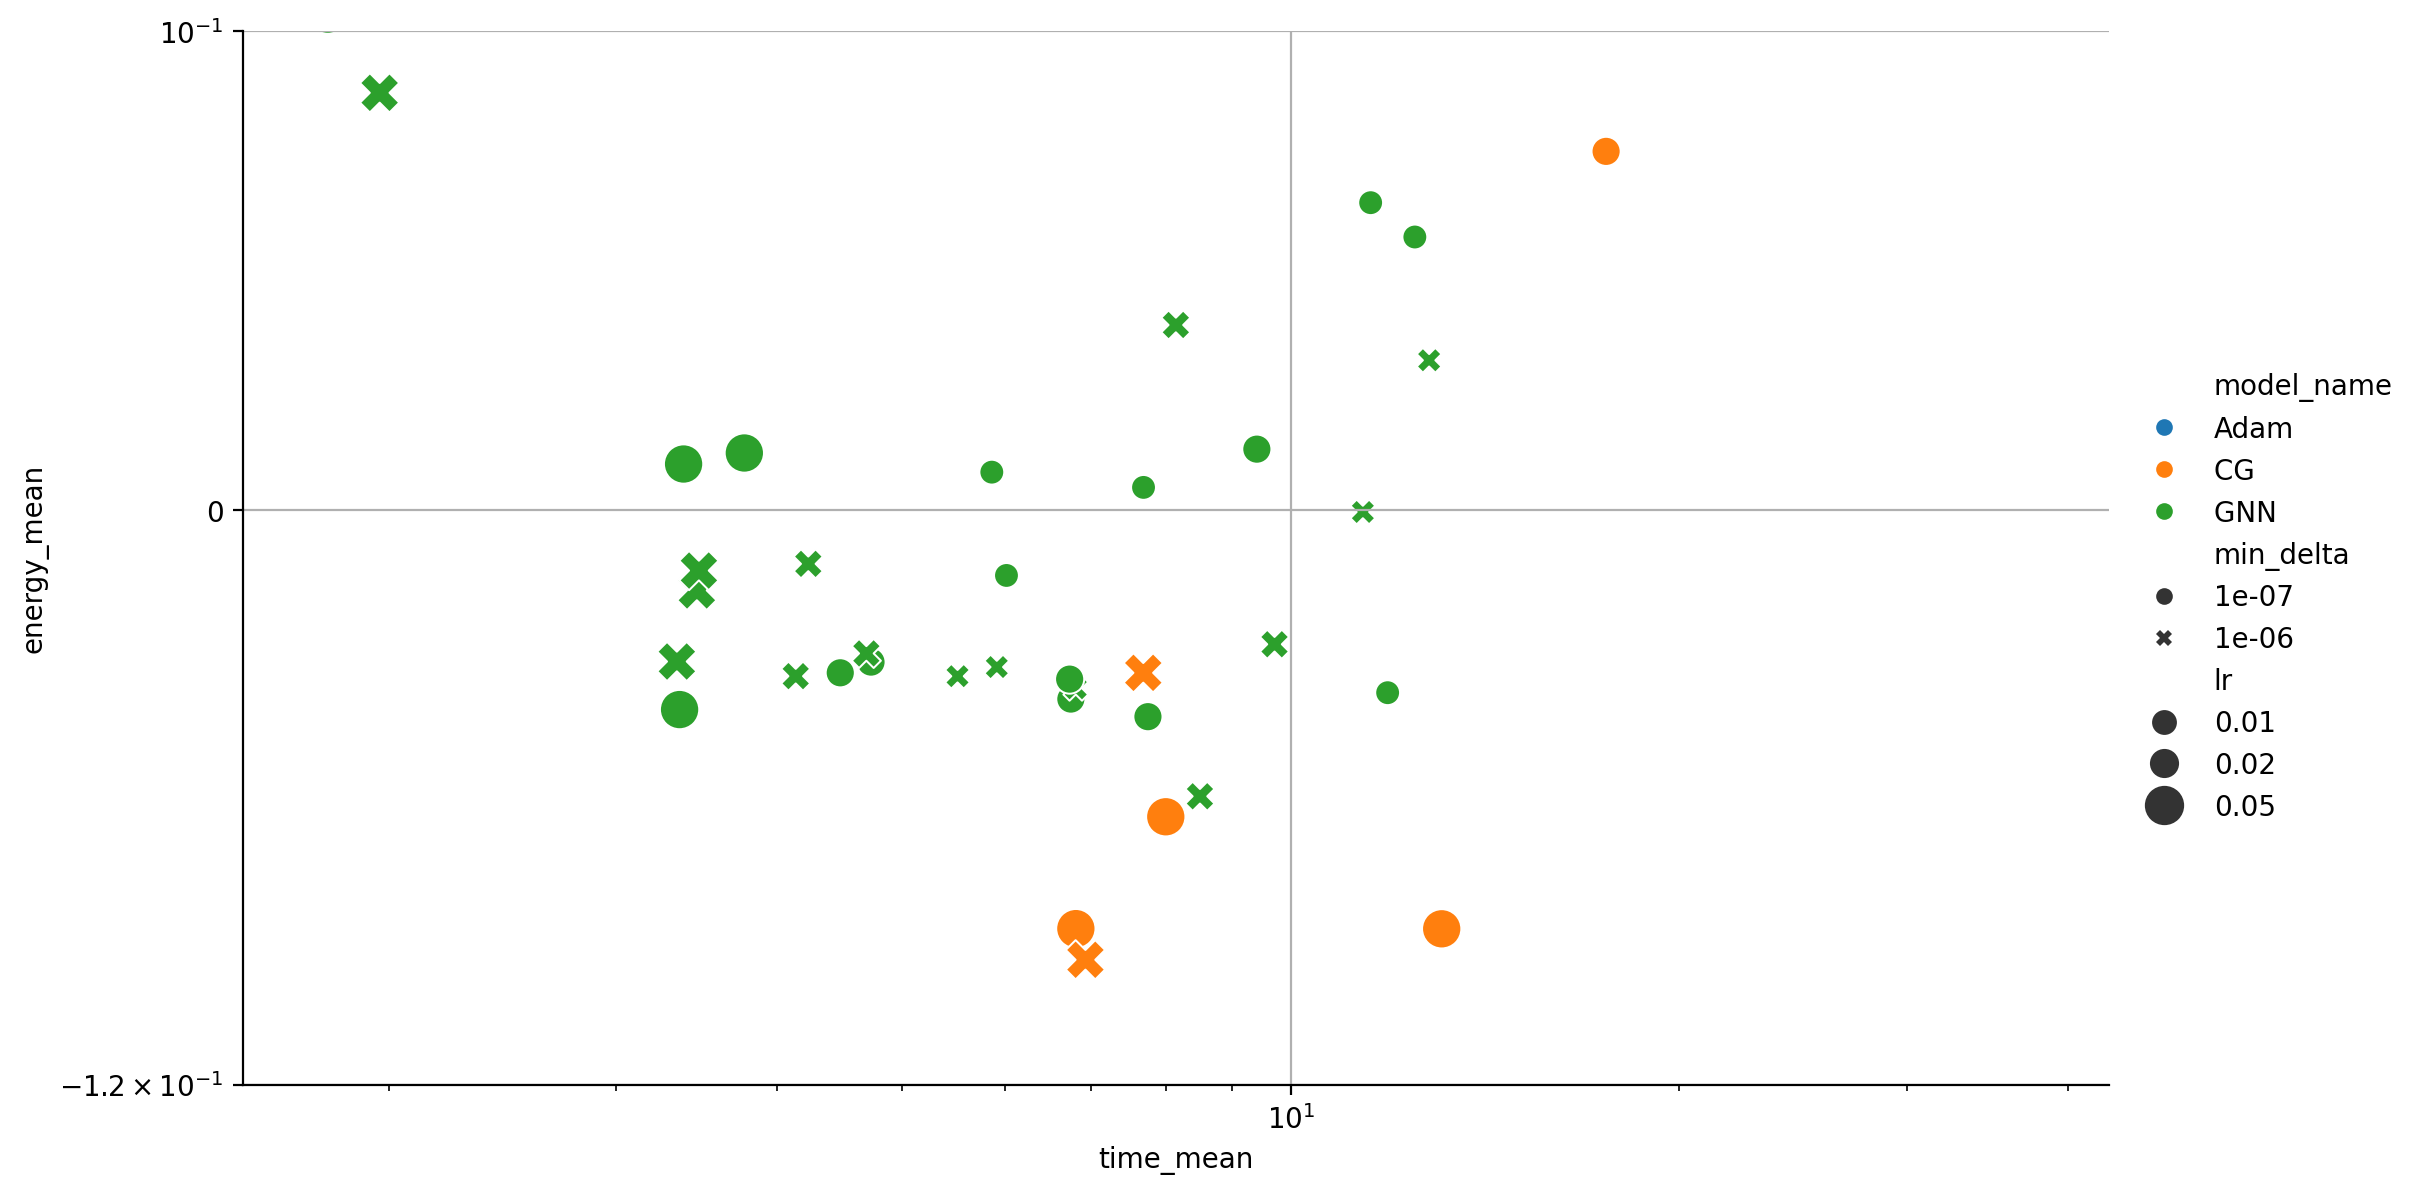

In [149]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

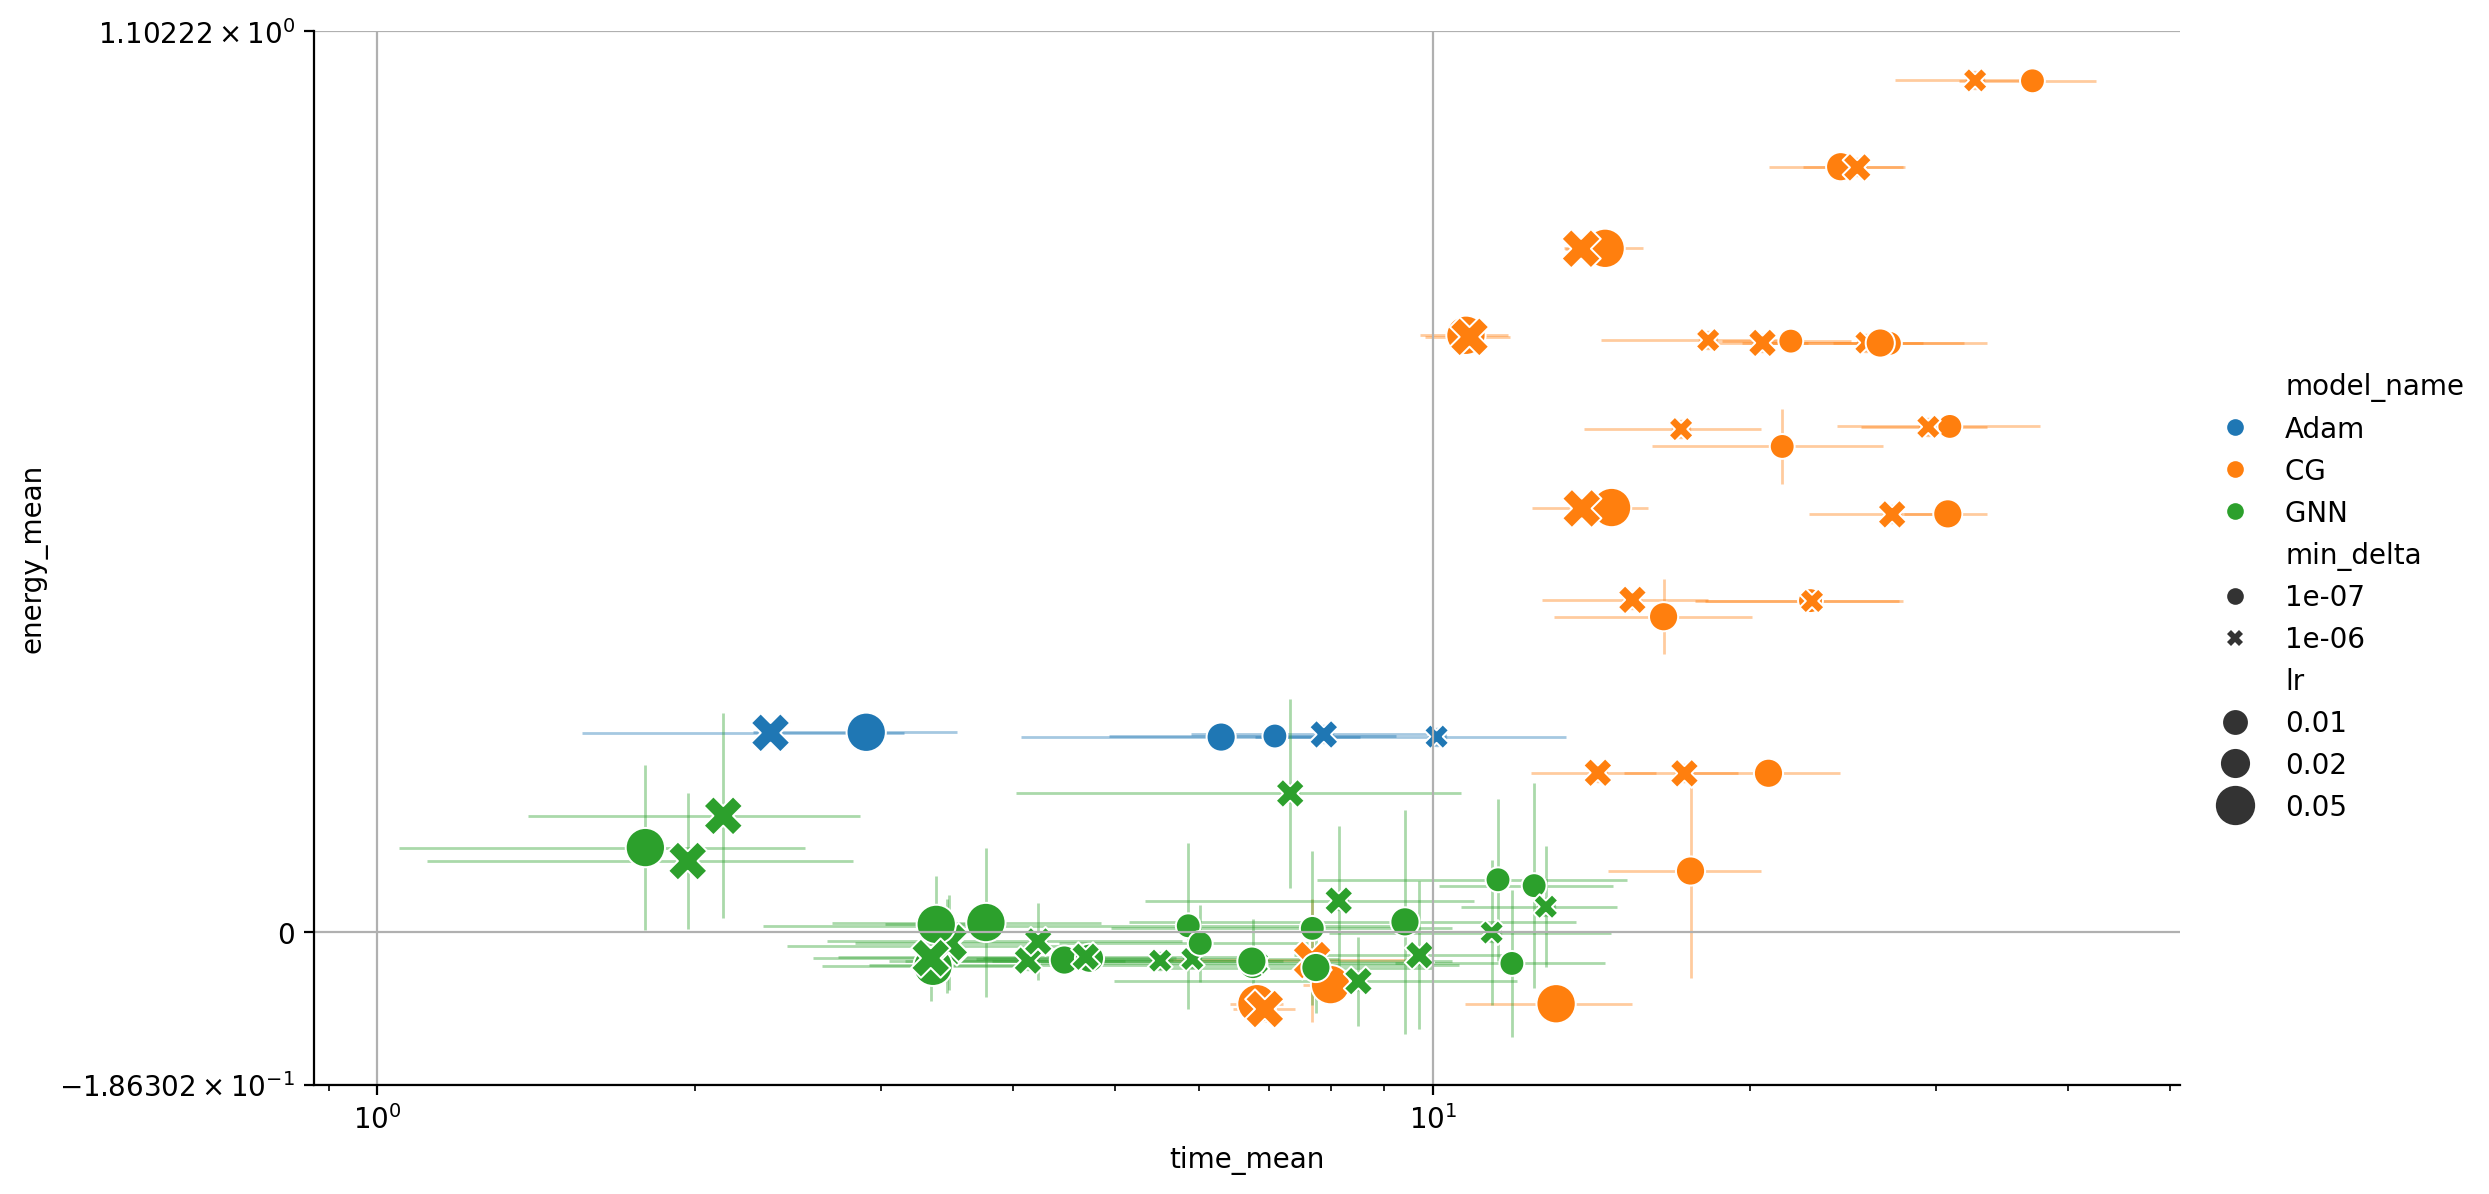

In [150]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

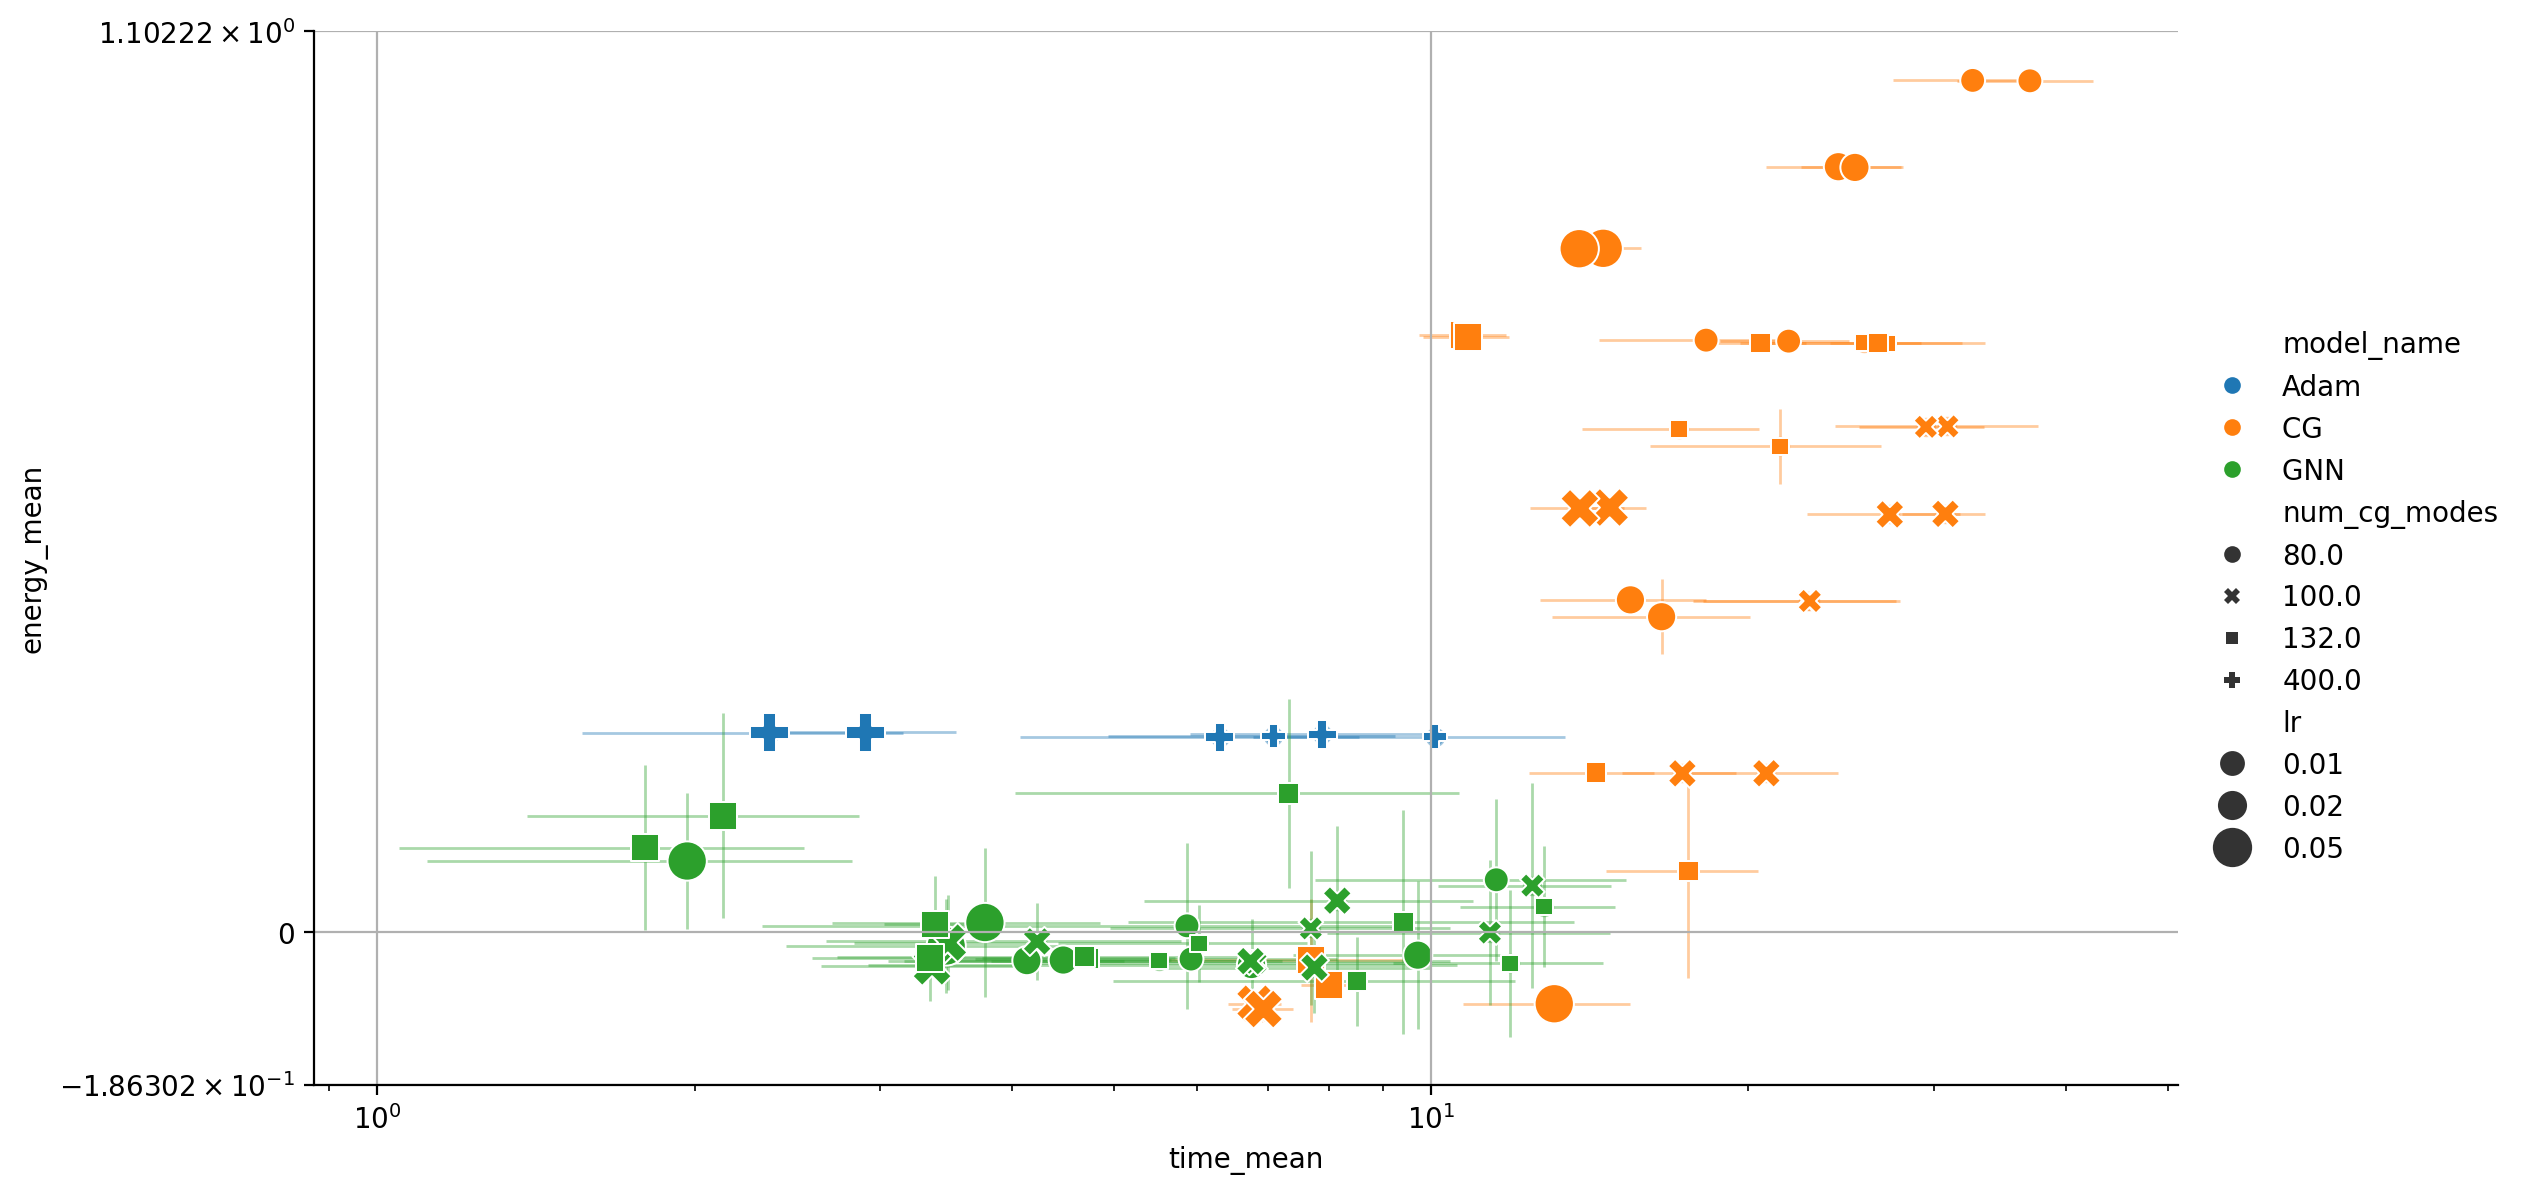

In [151]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

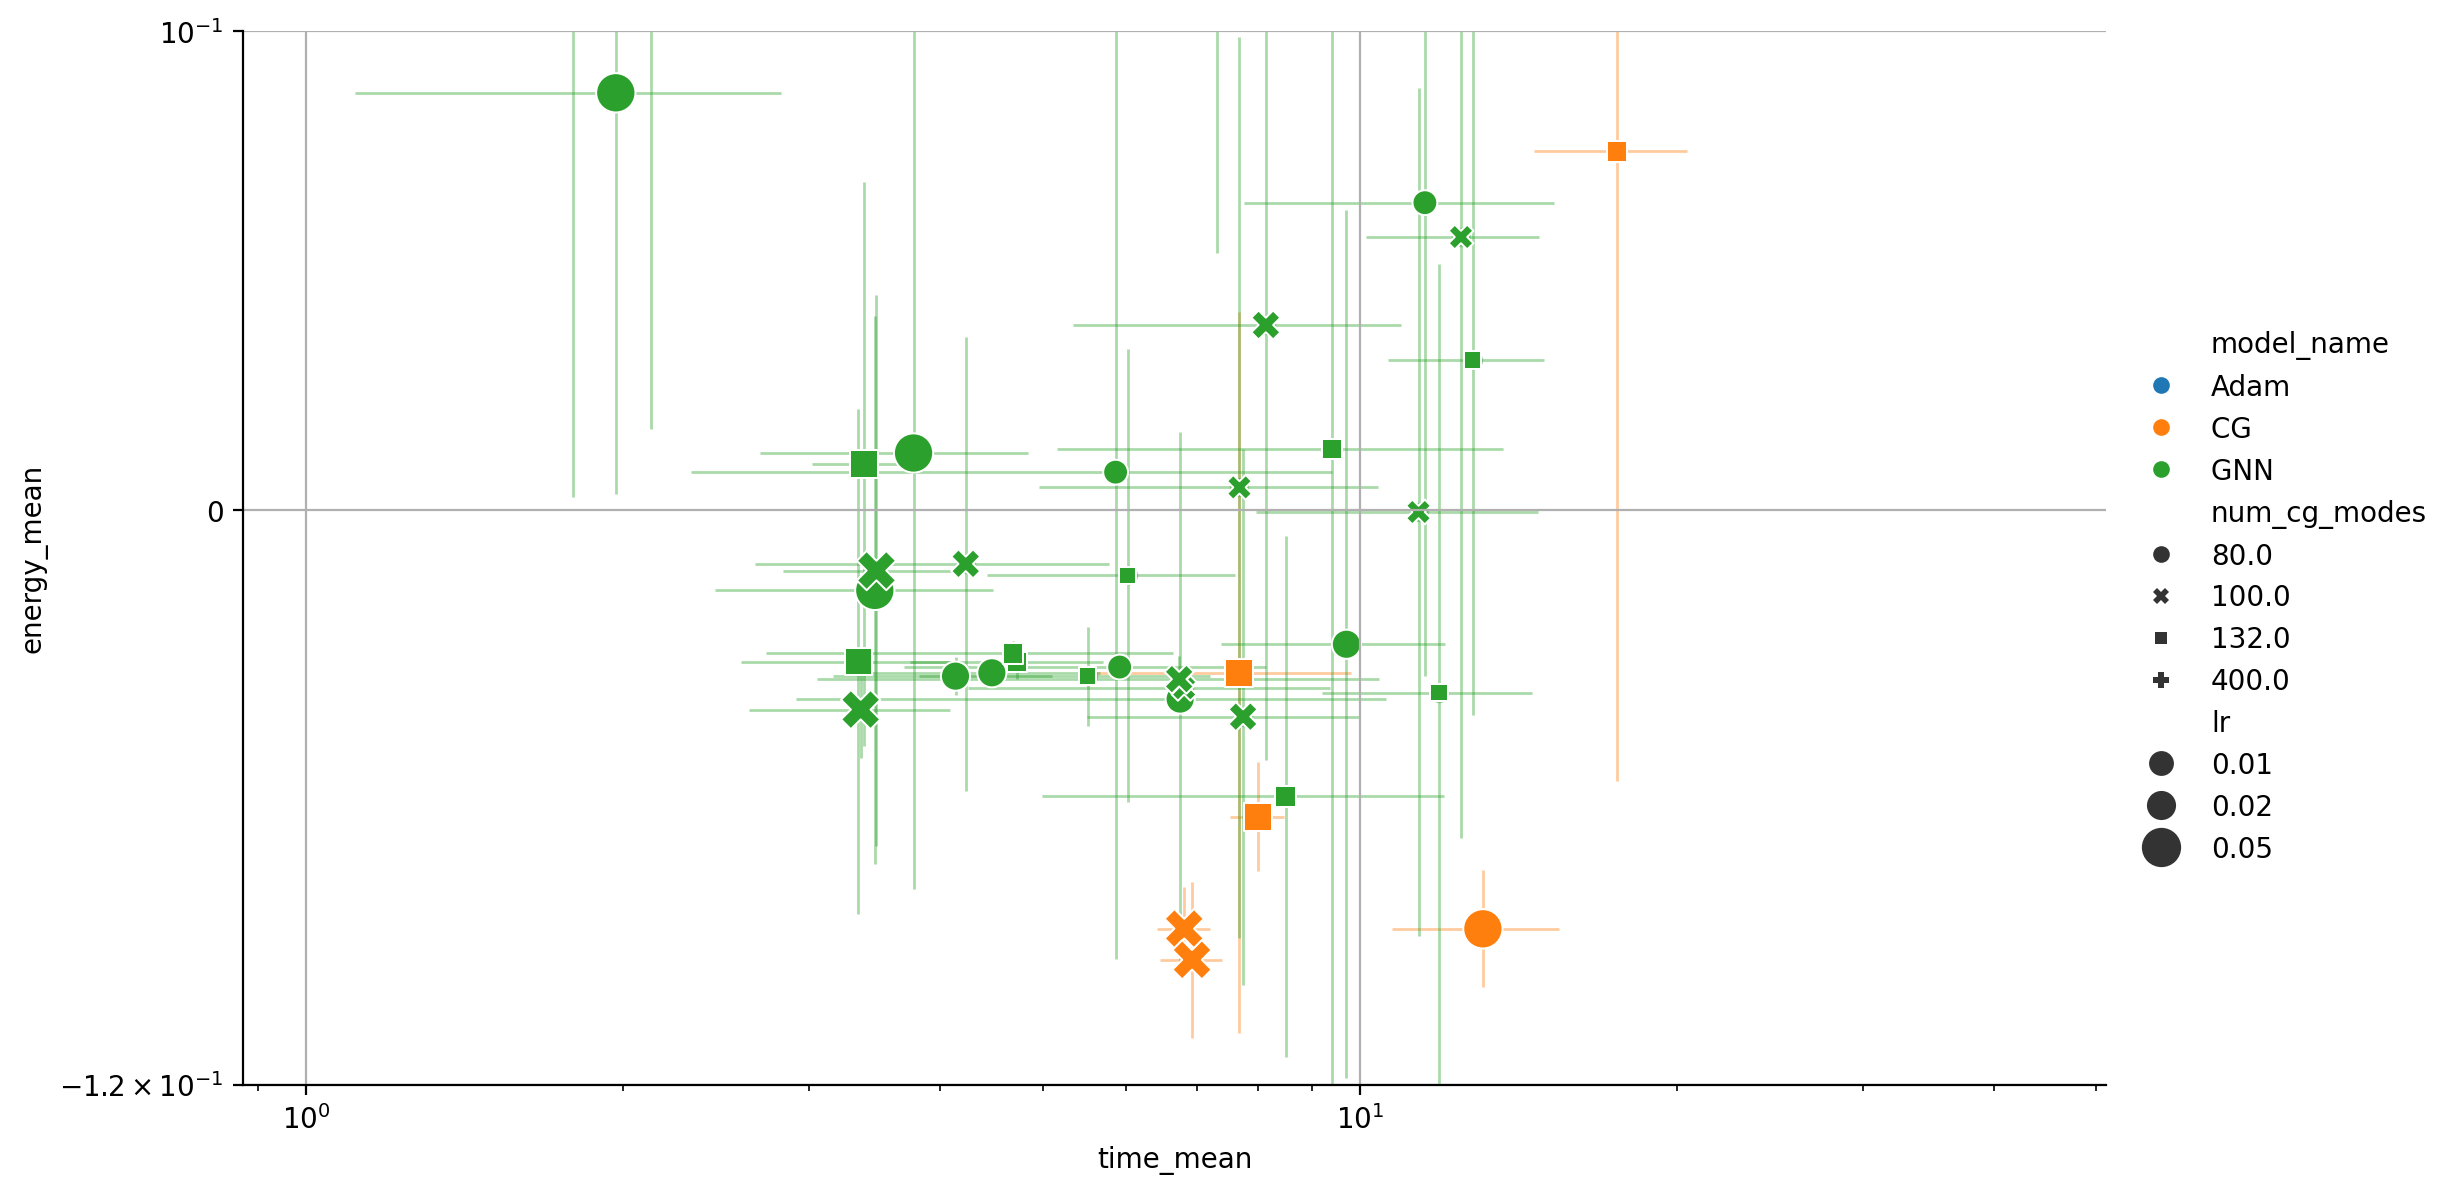

In [152]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

# By type of model

In [20]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [21]:
df_cleaned

energy_function model_name    energy       time    lr  clamp_grads  \
0    Energy_LJ_2scale       Adam  0.247403   1.392278  0.05          0.1   
1    Energy_LJ_2scale        CG   0.727117   9.580374  0.05          0.1   
2    Energy_LJ_2scale       GNN   0.327568  10.335653  0.05          0.1   
3    Energy_LJ_2scale       GNN  -0.053740   3.725070  0.05          0.1   
4    Energy_LJ_2scale        CG   0.518101  14.386985  0.05          0.1   
..                ...        ...       ...        ...   ...          ...   
565  Energy_LJ_2scale       GNN   0.378161   9.386935  0.01          0.1   
566  Energy_LJ_2scale       GNN  -0.035773   7.855705  0.01          0.1   
567  Energy_LJ_2scale        CG   0.723125  19.358500  0.01          0.1   
568  Energy_LJ_2scale       GNN   0.642706  10.697762  0.01          0.1   
569  Energy_LJ_2scale       GNN  -0.040278   5.829245  0.01          0.1   

     patience     min_delta    x0_std  num_nodes  lr_cg  cg_patience  \
0          20  1.000000e-06  1.838327        400    NaN          NaN   
1          20  1.000000e-06  1.838327        400  0.050         20.0   
2          20  1.000000e-06  1.838327        400  0.005         20.0   
3          20  1.000000e-06  1.838327        400  0.005         20.0   
4          20  1.000000e-06  1.838327        400  0.050         20.0   
..        ...           ...       ...        ...    ...          ...   
565        20  1.000000e-07  1.838327        400  0.010         20.0   
566        20  1.000000e-07  1.838327        400  0.010         20.0   
567        20  1.000000e-07  1.838327        400  0.100         20.0   
568        20  1.000000e-07  1.838327        400  0.010         20.0   
569        20  1.000000e-07  1.838327        400  0.010         20.0   

     cg_min_delta  cg_steps    cg_time  cg_energy  num_cg_modes  hidden_dims  
0             NaN       NaN        NaN        NaN           NaN          NaN  
1        0.000010     527.0   8.515158   0.749255           NaN          NaN  
2        0.000010     422.0   8.722153   0.328345         133.0    [8, 4, 3]  
3        0.000010      34.0   1.192533  -0.018955         133.0  [32, 16, 3]  
4        0.000010     822.0  13.196695   0.542127           NaN          NaN  
..            ...       ...        ...        ...           ...          ...  
565      0.000001     220.0   4.761004   0.396002         100.0    [8, 4, 3]  
566      0.000001      26.0   1.015844  -0.003536         100.0  [32, 16, 3]  
567      0.000001     635.0  10.377081   0.760114           NaN          NaN  
568      0.000001     398.0   8.248155   0.643227          80.0    [8, 4, 3]  
569      0.000001      27.0   1.042117  -0.006536          80.0  [32, 16, 3]  

[570 rows x 18 columns]

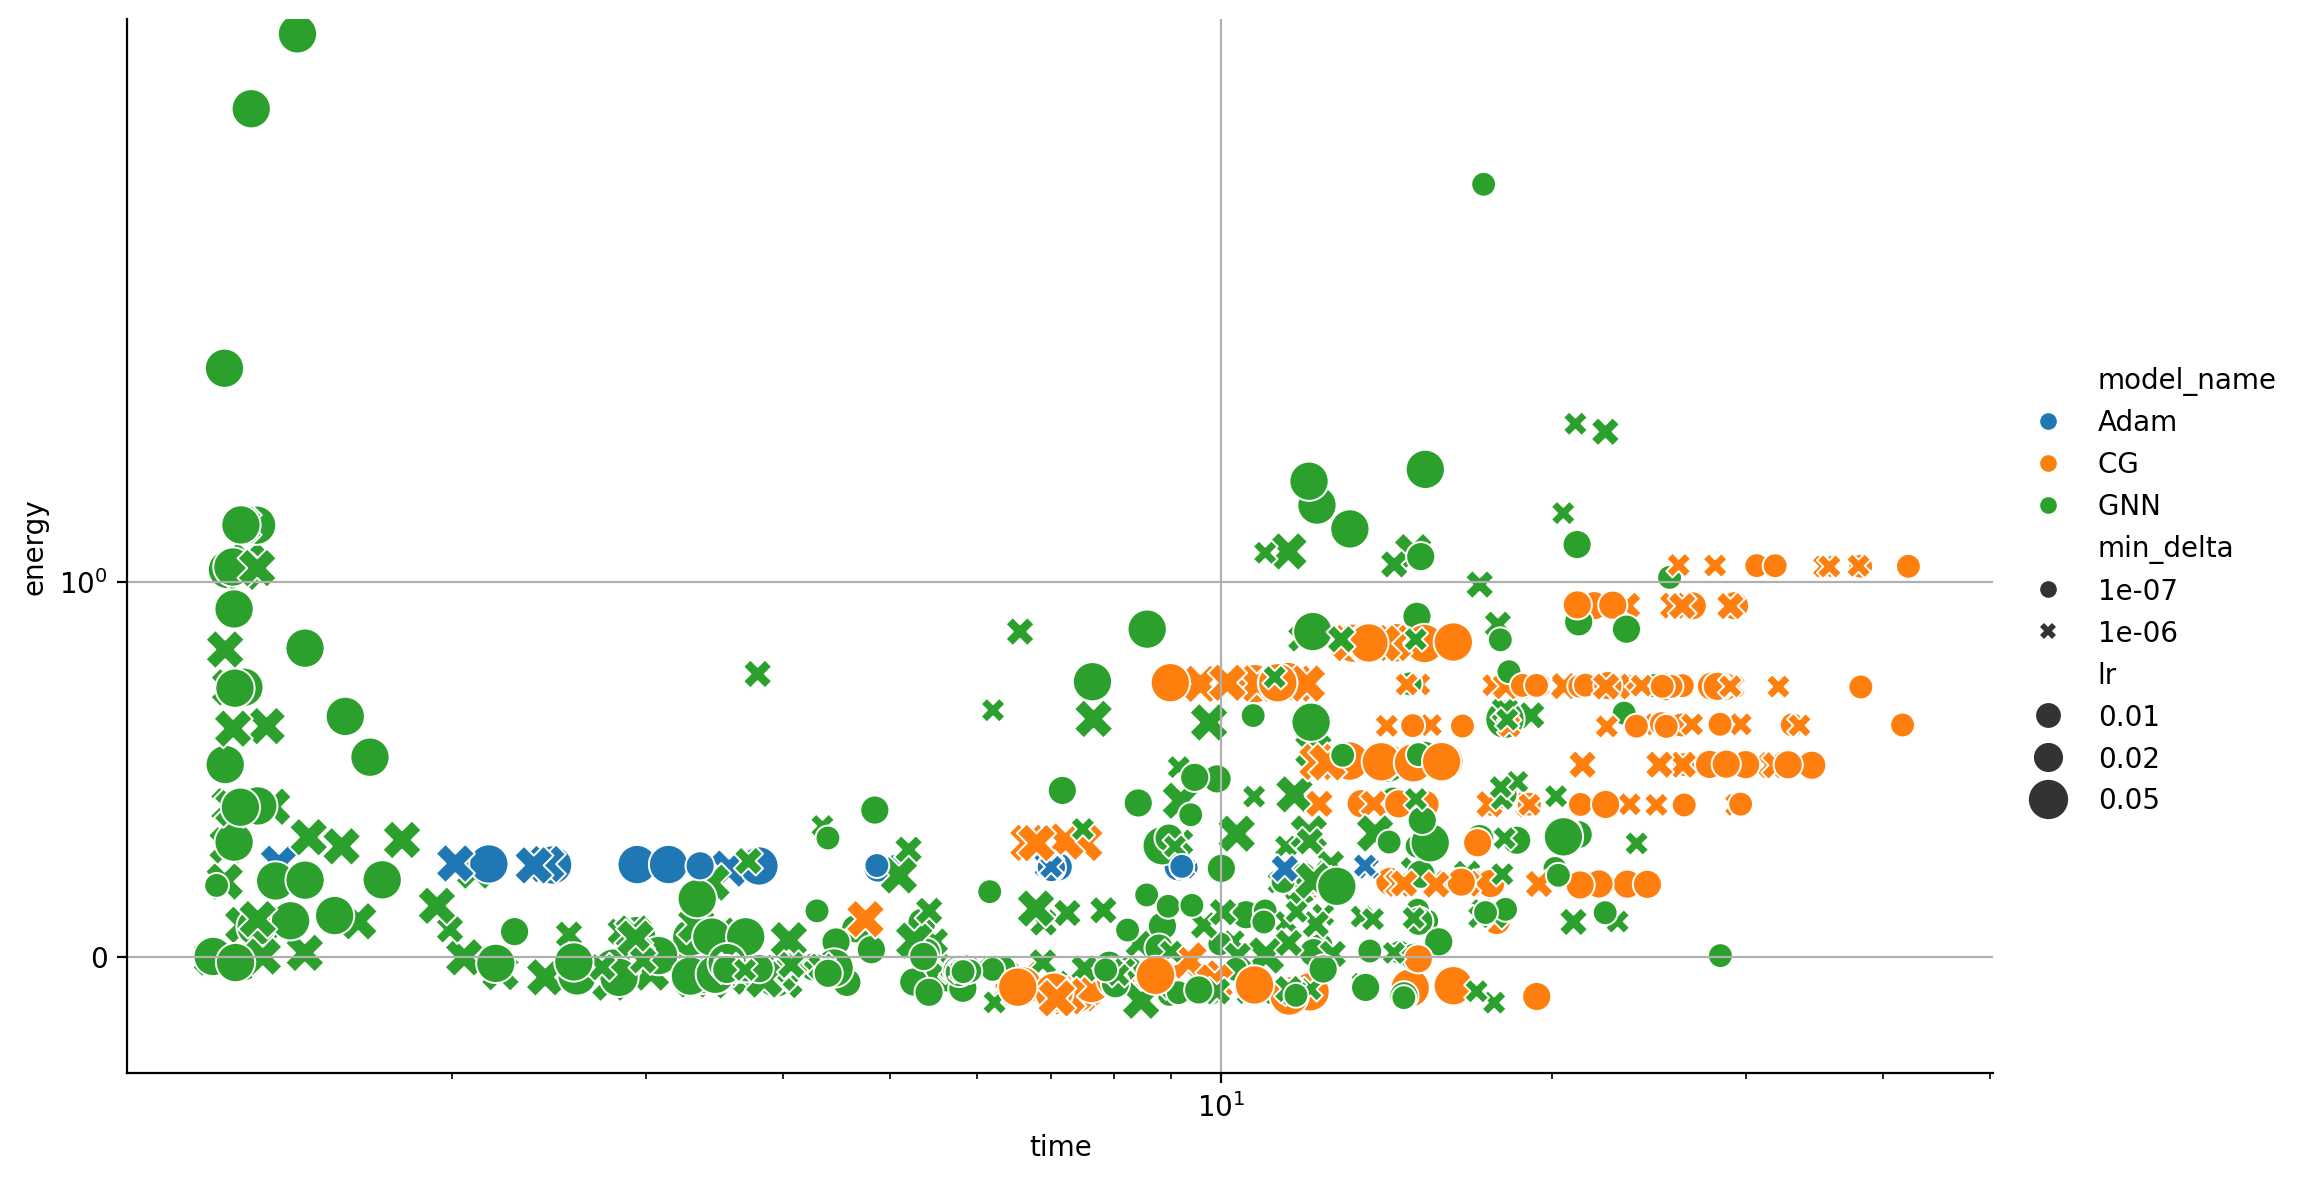

In [23]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

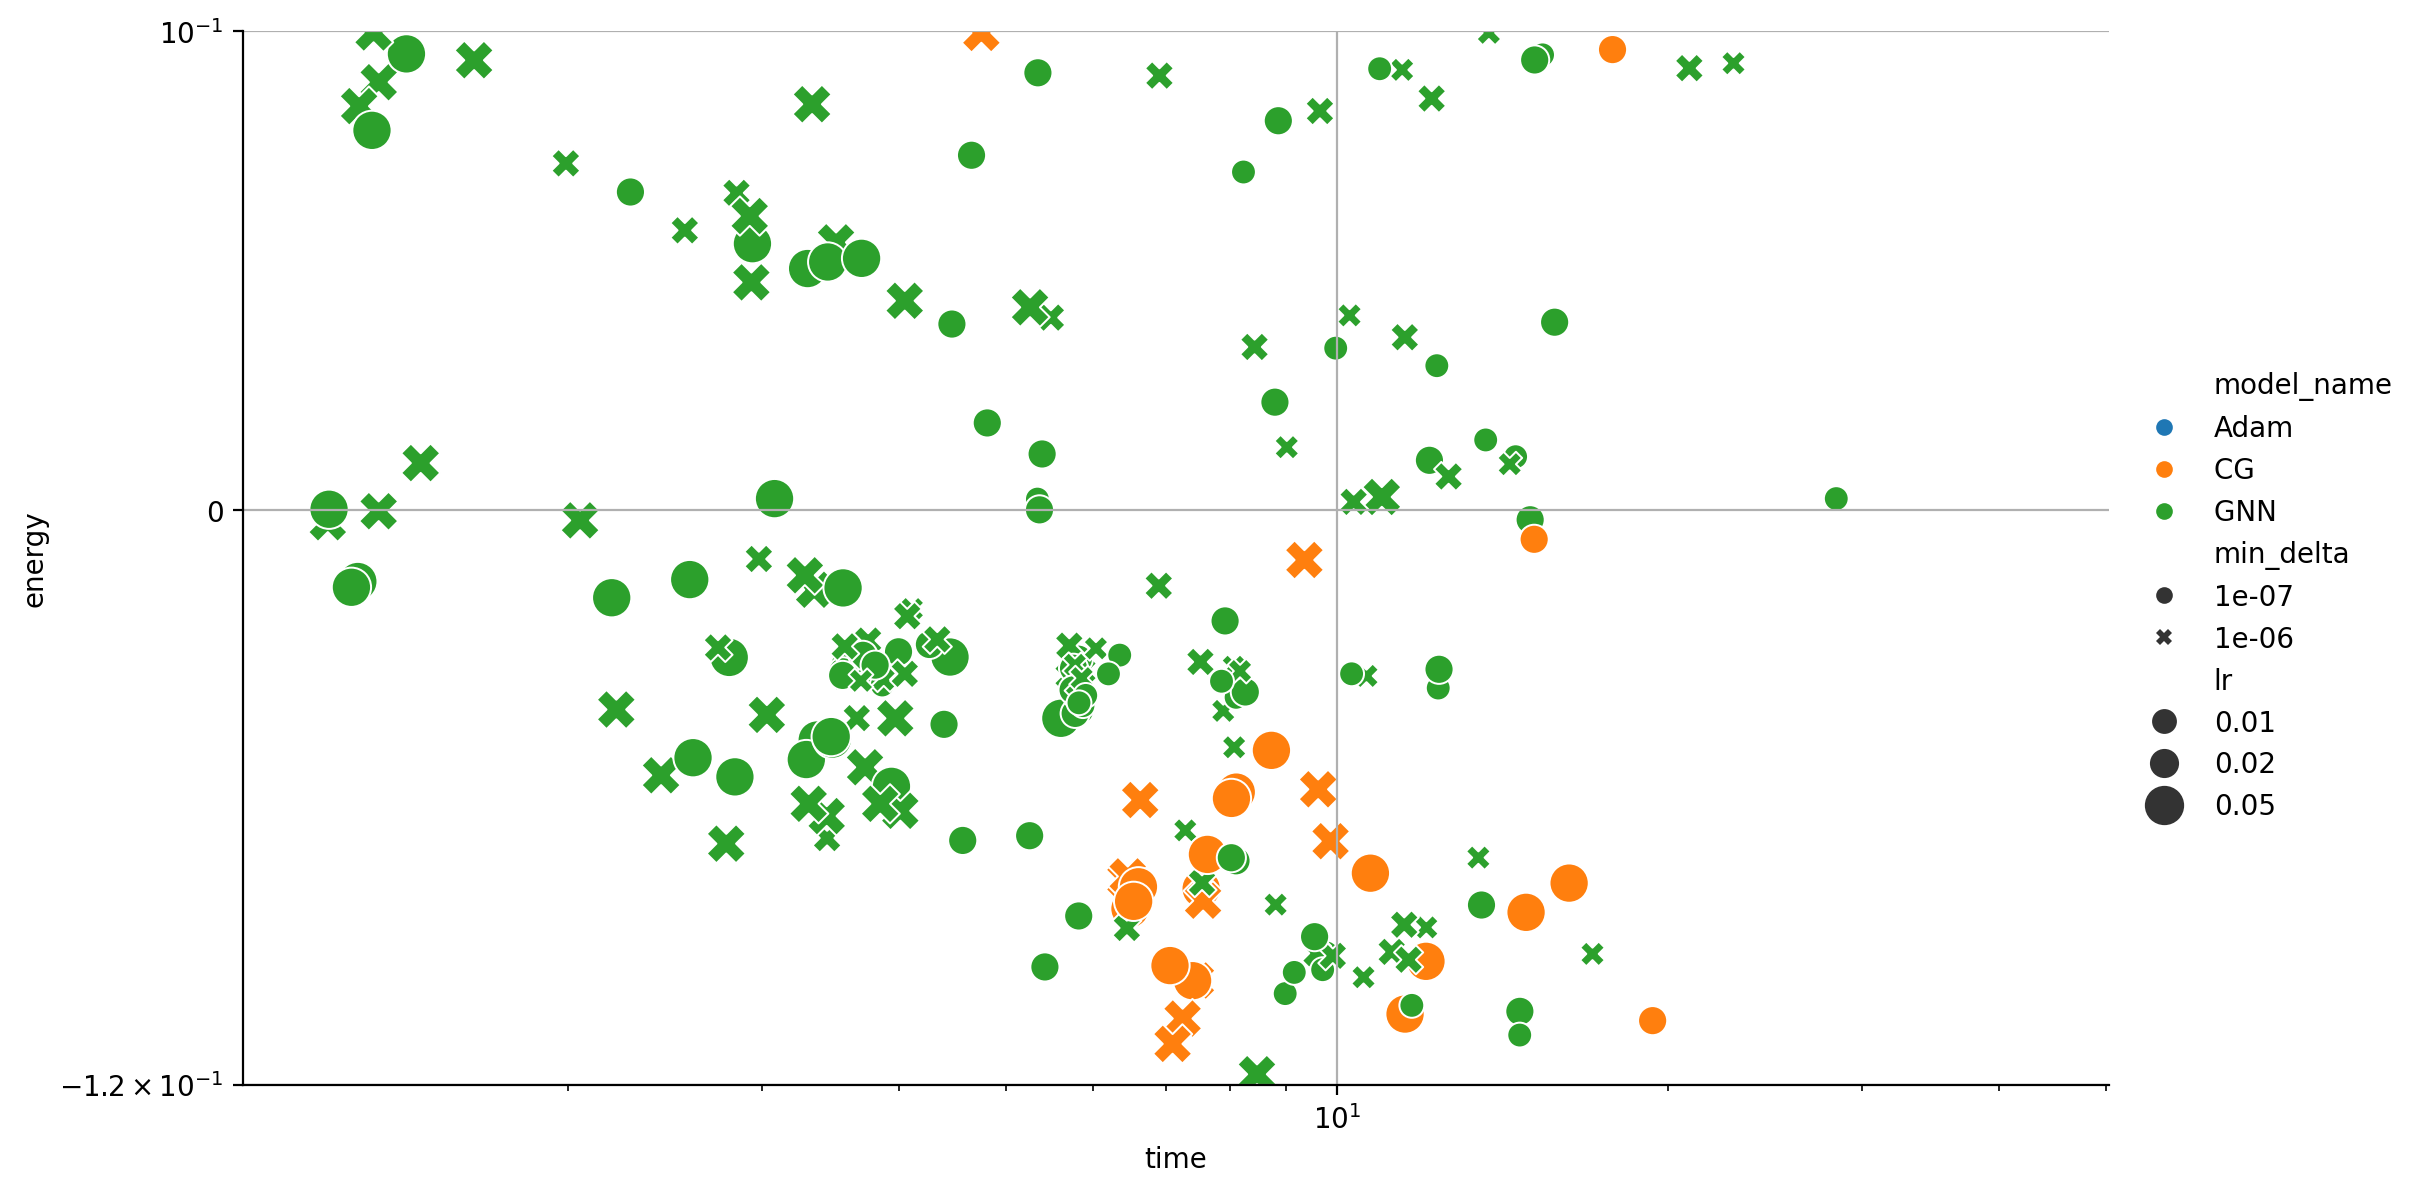

In [22]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()